## Packages

In [14]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

from tqdm import tqdm

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly



import warnings
warnings.filterwarnings('ignore')

## Data loading

In [15]:
data = pd.read_csv('../data/almost_data.csv')
target = pd.read_csv('../data/Target.csv')

data['Date et heure de comptage'] = pd.to_datetime(data['Date et heure de comptage'], utc=True)
data['Date et heure de comptage'] = data['Date et heure de comptage'].dt.tz_localize(None)
# data['Date et heure de comptage'] = pd.to_datetime([ data['Date et heure de comptage'][i].replace('+01:00', '') for i in range(data.shape[0])], utc=True)
# data['Date et heure de comptage'].apply(lambda x: pd.to_datetime(x).tz_convert('US/Eastern'))
data.drop('Unnamed: 0', axis=1, inplace=True )
target.drop(['Unnamed: 0', 'index'], axis=1, inplace=True )

data

,Date et heure de comptage,Vacance,Variation de pression en 3 heures,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Humidité,Visibilité horizontale,Meteo pres,Meteo pass,Libelle_AV_Champs_Elysees,Libelle_Convention,Libelle_Sts_Peres,Etat trafic_Bloqué,Etat trafic_Fluide,Etat trafic_Inconnu,Etat trafic_Pré-saturé,Etat trafic_Saturé,Etat arc_Barré,Etat arc_Invalide
0,2021-12-01 03:00:00,0,-420,230,7,281,90,15000,0,0,1,0,0,0,0,0,1,0,0,1
1,2021-12-01 03:00:00,0,-420,230,7,281,90,15000,0,0,0,0,1,0,1,0,0,0,0,1
2,2021-12-01 03:00:00,0,-420,230,7,281,90,15000,0,0,0,1,0,0,1,0,0,0,0,1
3,2021-12-01 04:00:00,0,-420,230,7,281,90,15000,0,0,1,0,0,0,1,0,0,0,0,1
4,2021-12-01 04:00:00,0,-420,230,7,281,90,15000,0,0,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29223,2023-01-27 19:00:00,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
29224,2023-01-27 20:00:00,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
29225,2023-01-27 21:00:00,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
29226,2023-01-27 22:00:00,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1


In [35]:
def time_series_graph(data_train, data_test, target='Taux d\'occupation', street='Libelle_AV_Champs_Elysees'):
    fig, ax = plt.subplots(figsize=(11, 6))
    data_train[data_train[street] == 1][target].plot(ax=ax, label='train')
    data_test[data_test[street] == 1][target].plot(ax=ax, label='test')
    ax.set_title(target)
    ax.legend()
    plt.show()

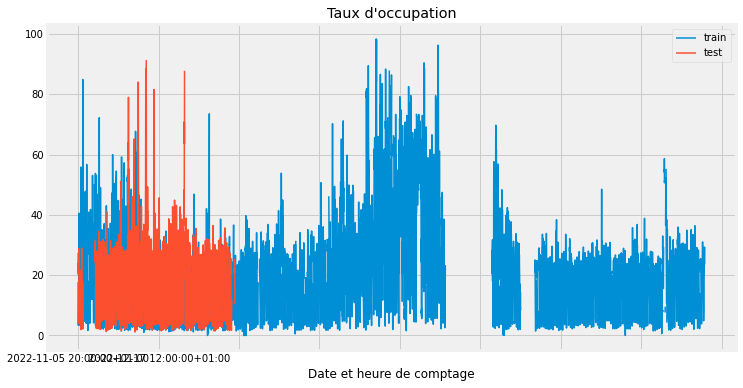

In [36]:
time_series_graph(data_train, data_test)

## Prophet 

In [155]:
def get_appropriate_df(data, target, target_name='Taux', street='Champ'):
    
    assert (target_name, street) != ('Dépit', 'Convention'), print('On ne prédit pas')
    
    if street == 'Champ':
        s = 'Libelle_AV_Champs_Elysees'
    if street == 'Sts':
        s = 'Libelle_Sts_Peres'
    if street == 'Convention':
        s = 'Libelle_Convention'
    
    if target_name == 'Taux':
        s2 = 'Taux d\'occupation'
    if target_name == 'Débit':
        s2 = 'Débit horaire'
    
    indexes = data[data[s] == 1].index
    
    df = pd.concat([data[data[s] ==1]['Date et heure de comptage'], target[s2].iloc[indexes]], axis=1)
    df.rename(columns={'Date et heure de comptage': 'ds', s2: 'y'}, inplace=True)
    df.dropna(inplace=True)
    
    return df


def get_full_data(data, target):
    
    df = {'Taux-Champ': get_appropriate_df(data, target),
         'Taux-Sts:' : get_appropriate_df(data, target, street='Sts'),
         'Taux-Convention' : get_appropriate_df(data, target, street='Convention'), 
         'Débit-Champ' : get_appropriate_df(data, target, target_name='Débit'), 
         'Dépit-Sts': get_appropriate_df(data, target, target_name='Débit', street='Sts')}
    
    return df


def get_holidays_df(nihua_suda_ne_nado=True):
    
    children_holidays = pd.read_csv('../data/vacances_scolaires.csv')
    french_holidays = pd.read_csv('../data/jours_feries_metropole.csv')
    start_date = pd.to_datetime('2021-12-01')
    finish_date = pd.to_datetime('2023-02-01')

    children_holidays['date'] = pd.to_datetime(children_holidays['date'], errors='coerce')
    children_holidays = children_holidays[children_holidays['date'] >= start_date]
    children_holidays = children_holidays[children_holidays['date'] <= finish_date]
    children_holidays = children_holidays['date']
    children_holidays = pd.DataFrame({'ds': children_holidays, 'holiday' : 'vacance'})


    french_holidays['date'] = pd.to_datetime(french_holidays['date'], errors='coerce')
    french_holidays = french_holidays[french_holidays['date'] >= start_date]
    french_holidays = french_holidays[french_holidays['date'] <= finish_date]
    french_holidays = french_holidays['date']
    french_holidays = pd.DataFrame({'ds': french_holidays, 'holiday' : 'no_work'})

    holidays = pd.concat([french_holidays, children_holidays])
    
    return holidays



def prophet_cv(data, holidays, test_size=.2):
    
    train, test = train_test_split(data, test_size=test_size, shuffle=False)
    
    params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
               'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
               'n_changepoints' : list(range(3, 20))}
    
    grid = ParameterGrid(params_grid)
    
    model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
    
    for p in tqdm(grid):
        train_model = Prophet(seasonality_mode = p['seasonality_mode'], 
                        holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_prior_scale = p['changepoint_prior_scale'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holidays)
        train_model.fit(train)
        train_forecast = train_model.predict(test)
        train_forecast = train_forecast[['ds', 'yhat']]
        RMSE = np.sqrt(mean_squared_error(test['y'], (train_forecast['yhat'])))
        print('Root mean squared error Error(RMSE)------------------------------------', RMSE)
        model_parameters = model_parameters.append({'RMSE' : RMSE,'Parameters' : p}, ignore_index=True)
    return model_parameters

### Data for prophet


In [17]:
prophet_df = get_full_data(data, target)

holidays = get_holidays_df()

### Cross-validation (do not relaunch)

In [205]:
def cv_all(data, holidays):
    best_params = {}
    
    model_nums = ['Taux-Champ', 'Taux-Sts:', 'Taux-Convention', 'Débit-Champ', 'Dépit-Sts']
                  
    for num in tqdm(model_nums):
        model_param_curr = prophet_cv(data[num], holidays).sort_values(by='RMSE').iloc[0]
        best_params.update({num : model_param_curr})
    return best_params

In [206]:
best_params = cv_all(prophet_df, holidays)

  0%|                                                                                                                                                                         | 0/850 [00:00<?, ?it/s]21:45:55 - cmdstanpy - INFO - Chain [1] start processing
21:45:55 - cmdstanpy - INFO - Chain [1] done processing

  0%|▏                                                                                                                                                                | 1/850 [00:01<25:59,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.735206905588543


21:45:56 - cmdstanpy - INFO - Chain [1] start processing
21:45:57 - cmdstanpy - INFO - Chain [1] done processing

  0%|▍                                                                                                                                                                | 2/850 [00:03<25:26,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.44436302475255


21:45:58 - cmdstanpy - INFO - Chain [1] start processing
21:45:58 - cmdstanpy - INFO - Chain [1] done processing

  0%|▌                                                                                                                                                                | 3/850 [00:05<23:24,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.526395807906697


21:45:59 - cmdstanpy - INFO - Chain [1] start processing
21:46:00 - cmdstanpy - INFO - Chain [1] done processing

  0%|▊                                                                                                                                                                | 4/850 [00:06<23:00,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.2768295924011


21:46:01 - cmdstanpy - INFO - Chain [1] start processing
21:46:01 - cmdstanpy - INFO - Chain [1] done processing

  1%|▉                                                                                                                                                                | 5/850 [00:08<22:03,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.521899447132387


21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▏                                                                                                                                                               | 6/850 [00:09<21:17,  1.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.03661121541559


21:46:04 - cmdstanpy - INFO - Chain [1] start processing
21:46:05 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▎                                                                                                                                                               | 7/850 [00:11<23:23,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.52622360657491


21:46:06 - cmdstanpy - INFO - Chain [1] start processing
21:46:06 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▌                                                                                                                                                               | 8/850 [00:13<22:56,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.42798705981747


21:46:07 - cmdstanpy - INFO - Chain [1] start processing
21:46:09 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▋                                                                                                                                                               | 9/850 [00:15<26:26,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.748504978317765


21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▉                                                                                                                                                              | 10/850 [00:17<24:51,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.53501164985081


21:46:11 - cmdstanpy - INFO - Chain [1] start processing
21:46:13 - cmdstanpy - INFO - Chain [1] done processing

  1%|██                                                                                                                                                              | 11/850 [00:19<27:46,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.826318298527882


21:46:14 - cmdstanpy - INFO - Chain [1] start processing
21:46:15 - cmdstanpy - INFO - Chain [1] done processing

  1%|██▎                                                                                                                                                             | 12/850 [00:21<28:16,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.28284364535695


21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:17 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▍                                                                                                                                                             | 13/850 [00:23<29:10,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.884915680142054


21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:19 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▋                                                                                                                                                             | 14/850 [00:25<27:23,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.24422895705584


21:46:20 - cmdstanpy - INFO - Chain [1] start processing
21:46:21 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▊                                                                                                                                                             | 15/850 [00:28<30:12,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.926861702943047


21:46:22 - cmdstanpy - INFO - Chain [1] start processing
21:46:23 - cmdstanpy - INFO - Chain [1] done processing

  2%|███                                                                                                                                                             | 16/850 [00:30<29:39,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.25252732922776


21:46:24 - cmdstanpy - INFO - Chain [1] start processing
21:46:26 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▏                                                                                                                                                            | 17/850 [00:32<31:04,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.793656400592488


21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▍                                                                                                                                                            | 18/850 [00:34<29:16,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.357796003662344


21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:30 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▌                                                                                                                                                            | 19/850 [00:36<30:34,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.860912493570837


21:46:31 - cmdstanpy - INFO - Chain [1] start processing
21:46:32 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▊                                                                                                                                                            | 20/850 [00:38<28:30,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 33.19482309650808


21:46:33 - cmdstanpy - INFO - Chain [1] start processing
21:46:34 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▉                                                                                                                                                            | 21/850 [00:41<31:04,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.964655772789907


21:46:35 - cmdstanpy - INFO - Chain [1] start processing
21:46:36 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▏                                                                                                                                                           | 22/850 [00:42<28:02,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.138441911643405


21:46:37 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▎                                                                                                                                                           | 23/850 [00:45<29:01,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.94448268612854


21:46:39 - cmdstanpy - INFO - Chain [1] start processing
21:46:40 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▌                                                                                                                                                           | 24/850 [00:46<27:16,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.64529375083174


21:46:41 - cmdstanpy - INFO - Chain [1] start processing
21:46:43 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▋                                                                                                                                                           | 25/850 [00:49<30:34,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.952690177831915


21:46:44 - cmdstanpy - INFO - Chain [1] start processing
21:46:45 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▉                                                                                                                                                           | 26/850 [00:51<29:05,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.71074703786687


21:46:46 - cmdstanpy - INFO - Chain [1] start processing
21:46:48 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████                                                                                                                                                           | 27/850 [00:54<33:04,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.875085763866977


21:46:49 - cmdstanpy - INFO - Chain [1] start processing
21:46:50 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████▎                                                                                                                                                          | 28/850 [00:56<31:58,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.60359267306101


21:46:51 - cmdstanpy - INFO - Chain [1] start processing
21:46:52 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████▍                                                                                                                                                          | 29/850 [00:59<32:53,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.033254908089503


21:46:53 - cmdstanpy - INFO - Chain [1] start processing
21:46:54 - cmdstanpy - INFO - Chain [1] done processing

  4%|█████▋                                                                                                                                                          | 30/850 [01:01<30:09,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.44198692292827


21:46:55 - cmdstanpy - INFO - Chain [1] start processing
21:46:57 - cmdstanpy - INFO - Chain [1] done processing

  4%|█████▊                                                                                                                                                          | 31/850 [01:03<31:10,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.92976320602273


21:46:58 - cmdstanpy - INFO - Chain [1] start processing
21:46:58 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████                                                                                                                                                          | 32/850 [01:05<28:19,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.499389597537366


21:46:59 - cmdstanpy - INFO - Chain [1] start processing
21:47:01 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▏                                                                                                                                                         | 33/850 [01:07<29:40,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.938967610803761


21:47:02 - cmdstanpy - INFO - Chain [1] start processing
21:47:03 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▍                                                                                                                                                         | 34/850 [01:09<28:40,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.25752734744304


21:47:04 - cmdstanpy - INFO - Chain [1] start processing
21:47:04 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▌                                                                                                                                                         | 35/850 [01:11<26:24,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.662025079463858


21:47:05 - cmdstanpy - INFO - Chain [1] start processing
21:47:06 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▊                                                                                                                                                         | 36/850 [01:12<24:43,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.15660297268631


21:47:07 - cmdstanpy - INFO - Chain [1] start processing
21:47:07 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▉                                                                                                                                                         | 37/850 [01:14<24:01,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.48018578506093


21:47:08 - cmdstanpy - INFO - Chain [1] start processing
21:47:09 - cmdstanpy - INFO - Chain [1] done processing

  4%|███████▏                                                                                                                                                        | 38/850 [01:16<24:00,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.31560981165158


21:47:10 - cmdstanpy - INFO - Chain [1] start processing
21:47:11 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▎                                                                                                                                                        | 39/850 [01:17<24:35,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.464325377895682


21:47:12 - cmdstanpy - INFO - Chain [1] start processing
21:47:13 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▌                                                                                                                                                        | 40/850 [01:19<24:26,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.56436179031946


21:47:15 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▋                                                                                                                                                        | 41/850 [01:22<28:46,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.541706118555412


21:47:17 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▉                                                                                                                                                        | 42/850 [01:24<25:40,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.654876031572094


21:47:18 - cmdstanpy - INFO - Chain [1] start processing
21:47:19 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████                                                                                                                                                        | 43/850 [01:25<25:18,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.571725464018595


21:47:20 - cmdstanpy - INFO - Chain [1] start processing
21:47:21 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▎                                                                                                                                                       | 44/850 [01:27<24:31,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.75769367343373


21:47:22 - cmdstanpy - INFO - Chain [1] start processing
21:47:23 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▍                                                                                                                                                       | 45/850 [01:29<25:50,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.773036124955555


21:47:24 - cmdstanpy - INFO - Chain [1] start processing
21:47:25 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▋                                                                                                                                                       | 46/850 [01:31<25:14,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.26044737948085


21:47:26 - cmdstanpy - INFO - Chain [1] start processing
21:47:27 - cmdstanpy - INFO - Chain [1] done processing

  6%|████████▊                                                                                                                                                       | 47/850 [01:33<26:01,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.853785452908367


21:47:28 - cmdstanpy - INFO - Chain [1] start processing
21:47:28 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████                                                                                                                                                       | 48/850 [01:35<25:26,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.89237439223561


21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:30 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▏                                                                                                                                                      | 49/850 [01:37<25:28,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.757984449325006


21:47:31 - cmdstanpy - INFO - Chain [1] start processing
21:47:32 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▍                                                                                                                                                      | 50/850 [01:38<23:38,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.173282087660354


21:47:33 - cmdstanpy - INFO - Chain [1] start processing
21:47:34 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▌                                                                                                                                                      | 51/850 [01:40<24:45,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.66287791272425


21:47:35 - cmdstanpy - INFO - Chain [1] start processing
21:47:35 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▊                                                                                                                                                      | 52/850 [01:42<23:38,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.04905549286659


21:47:37 - cmdstanpy - INFO - Chain [1] start processing
21:47:38 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▉                                                                                                                                                      | 53/850 [01:44<25:24,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.871210632485687


21:47:39 - cmdstanpy - INFO - Chain [1] start processing
21:47:39 - cmdstanpy - INFO - Chain [1] done processing

  6%|██████████▏                                                                                                                                                     | 54/850 [01:46<25:16,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.388460016637424


21:47:41 - cmdstanpy - INFO - Chain [1] start processing
21:47:42 - cmdstanpy - INFO - Chain [1] done processing

  6%|██████████▎                                                                                                                                                     | 55/850 [01:48<26:21,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.838093853464215


21:47:43 - cmdstanpy - INFO - Chain [1] start processing
21:47:43 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▌                                                                                                                                                     | 56/850 [01:50<24:25,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 33.81282322227523


21:47:44 - cmdstanpy - INFO - Chain [1] start processing
21:47:45 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▋                                                                                                                                                     | 57/850 [01:52<25:38,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.707148067330046


21:47:46 - cmdstanpy - INFO - Chain [1] start processing
21:47:47 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▉                                                                                                                                                     | 58/850 [01:53<24:10,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.5149870467016


21:47:48 - cmdstanpy - INFO - Chain [1] start processing
21:47:49 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████                                                                                                                                                     | 59/850 [01:56<25:49,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.988456497143043


21:47:50 - cmdstanpy - INFO - Chain [1] start processing
21:47:51 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▎                                                                                                                                                    | 60/850 [01:57<24:23,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.538800848685106


21:47:52 - cmdstanpy - INFO - Chain [1] start processing
21:47:53 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▍                                                                                                                                                    | 61/850 [02:00<26:58,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.784897542026856


21:47:54 - cmdstanpy - INFO - Chain [1] start processing
21:47:55 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▋                                                                                                                                                    | 62/850 [02:02<25:42,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.09829840316105


21:47:56 - cmdstanpy - INFO - Chain [1] start processing
21:47:58 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▊                                                                                                                                                    | 63/850 [02:04<27:50,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.8497079982024


21:47:59 - cmdstanpy - INFO - Chain [1] start processing
21:47:59 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████                                                                                                                                                    | 64/850 [02:06<25:55,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 32.350009714720784


21:48:00 - cmdstanpy - INFO - Chain [1] start processing
21:48:02 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▏                                                                                                                                                   | 65/850 [02:08<26:55,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.932354810242249


21:48:03 - cmdstanpy - INFO - Chain [1] start processing
21:48:04 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▍                                                                                                                                                   | 66/850 [02:10<27:06,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.98490546030791


21:48:05 - cmdstanpy - INFO - Chain [1] start processing
21:48:06 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▌                                                                                                                                                   | 67/850 [02:13<29:15,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.90743162740806


21:48:07 - cmdstanpy - INFO - Chain [1] start processing
21:48:08 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▊                                                                                                                                                   | 68/850 [02:15<27:22,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 33.06739504120451


21:48:09 - cmdstanpy - INFO - Chain [1] start processing
21:48:10 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▉                                                                                                                                                   | 69/850 [02:16<25:03,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.595156952599583


21:48:11 - cmdstanpy - INFO - Chain [1] start processing
21:48:11 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▏                                                                                                                                                  | 70/850 [02:17<22:47,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.66872958324937


21:48:12 - cmdstanpy - INFO - Chain [1] start processing
21:48:13 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▎                                                                                                                                                  | 71/850 [02:19<22:14,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.465706287874113


21:48:14 - cmdstanpy - INFO - Chain [1] start processing
21:48:14 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▌                                                                                                                                                  | 72/850 [02:20<21:05,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.93423726818755


21:48:15 - cmdstanpy - INFO - Chain [1] start processing
21:48:16 - cmdstanpy - INFO - Chain [1] done processing

  9%|█████████████▋                                                                                                                                                  | 73/850 [02:22<21:19,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.44098238353135


21:48:17 - cmdstanpy - INFO - Chain [1] start processing
21:48:17 - cmdstanpy - INFO - Chain [1] done processing

  9%|█████████████▉                                                                                                                                                  | 74/850 [02:24<20:29,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.24666367189513


21:48:18 - cmdstanpy - INFO - Chain [1] start processing
21:48:19 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████                                                                                                                                                  | 75/850 [02:25<21:37,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.487092199270357


21:48:20 - cmdstanpy - INFO - Chain [1] start processing
21:48:20 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▎                                                                                                                                                 | 76/850 [02:27<20:17,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.478428820476715


21:48:21 - cmdstanpy - INFO - Chain [1] start processing
21:48:22 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▍                                                                                                                                                 | 77/850 [02:29<21:03,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.584828011109812


21:48:23 - cmdstanpy - INFO - Chain [1] start processing
21:48:24 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▋                                                                                                                                                 | 78/850 [02:30<20:10,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.73269551522856


21:48:25 - cmdstanpy - INFO - Chain [1] start processing
21:48:26 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▊                                                                                                                                                 | 79/850 [02:32<21:55,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.67238309394596


21:48:27 - cmdstanpy - INFO - Chain [1] start processing
21:48:27 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████████████                                                                                                                                                 | 80/850 [02:34<21:26,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.97751436974701


21:48:28 - cmdstanpy - INFO - Chain [1] start processing
21:48:29 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▏                                                                                                                                                | 81/850 [02:35<22:18,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.659157042783061


21:48:30 - cmdstanpy - INFO - Chain [1] start processing
21:48:31 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▍                                                                                                                                                | 82/850 [02:37<21:54,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.334543230939595


21:48:32 - cmdstanpy - INFO - Chain [1] start processing
21:48:33 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▌                                                                                                                                                | 83/850 [02:39<23:18,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.755005458538474


21:48:34 - cmdstanpy - INFO - Chain [1] start processing
21:48:34 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▊                                                                                                                                                | 84/850 [02:41<22:01,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 33.61669050799839


21:48:35 - cmdstanpy - INFO - Chain [1] start processing
21:48:37 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████                                                                                                                                                | 85/850 [02:43<23:57,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.68562408688389


21:48:38 - cmdstanpy - INFO - Chain [1] start processing
21:48:38 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▏                                                                                                                                               | 86/850 [02:45<22:45,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.330859435778926


21:48:39 - cmdstanpy - INFO - Chain [1] start processing
21:48:40 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▍                                                                                                                                               | 87/850 [02:46<23:08,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.81717851491125


21:48:41 - cmdstanpy - INFO - Chain [1] start processing
21:48:42 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▌                                                                                                                                               | 88/850 [02:48<22:46,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.016695193965404


21:48:43 - cmdstanpy - INFO - Chain [1] start processing
21:48:44 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▊                                                                                                                                               | 89/850 [02:51<25:06,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.797012986534979


21:48:45 - cmdstanpy - INFO - Chain [1] start processing
21:48:46 - cmdstanpy - INFO - Chain [1] done processing

 11%|████████████████▉                                                                                                                                               | 90/850 [02:52<23:21,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.2782590939569


21:48:47 - cmdstanpy - INFO - Chain [1] start processing
21:48:48 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▏                                                                                                                                              | 91/850 [02:55<26:14,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.85931771445341


21:48:49 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▎                                                                                                                                              | 92/850 [02:56<24:15,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.406170184331735


21:48:51 - cmdstanpy - INFO - Chain [1] start processing
21:48:52 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▌                                                                                                                                              | 93/850 [02:59<26:47,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.862001358634826


21:48:53 - cmdstanpy - INFO - Chain [1] start processing
21:48:54 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▋                                                                                                                                              | 94/850 [03:01<25:20,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.11480825575372


21:48:55 - cmdstanpy - INFO - Chain [1] start processing
21:48:57 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▉                                                                                                                                              | 95/850 [03:03<27:28,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.815744822903035


21:48:58 - cmdstanpy - INFO - Chain [1] start processing
21:48:58 - cmdstanpy - INFO - Chain [1] done processing

 11%|██████████████████                                                                                                                                              | 96/850 [03:05<25:11,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.902184171840496


21:48:59 - cmdstanpy - INFO - Chain [1] start processing
21:49:01 - cmdstanpy - INFO - Chain [1] done processing

 11%|██████████████████▎                                                                                                                                             | 97/850 [03:07<26:17,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.727293742060901


21:49:02 - cmdstanpy - INFO - Chain [1] start processing
21:49:02 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▍                                                                                                                                             | 98/850 [03:09<24:38,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.2856498298143


21:49:03 - cmdstanpy - INFO - Chain [1] start processing
21:49:06 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▋                                                                                                                                             | 99/850 [03:13<32:45,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.743997960962798


21:49:07 - cmdstanpy - INFO - Chain [1] start processing
21:49:08 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▋                                                                                                                                            | 100/850 [03:15<29:06,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.5261618362765


21:49:09 - cmdstanpy - INFO - Chain [1] start processing
21:49:11 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▉                                                                                                                                            | 101/850 [03:17<29:30,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.848010004802152


21:49:12 - cmdstanpy - INFO - Chain [1] start processing
21:49:12 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████                                                                                                                                            | 102/850 [03:19<26:57,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.118712326397606


21:49:13 - cmdstanpy - INFO - Chain [1] start processing
21:49:14 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▎                                                                                                                                           | 103/850 [03:20<25:04,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.542961772485812


21:49:15 - cmdstanpy - INFO - Chain [1] start processing
21:49:15 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▍                                                                                                                                           | 104/850 [03:22<22:55,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.203393892324385


21:49:17 - cmdstanpy - INFO - Chain [1] start processing
21:49:17 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▋                                                                                                                                           | 105/850 [03:24<23:19,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.459550667320599


21:49:18 - cmdstanpy - INFO - Chain [1] start processing
21:49:19 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▊                                                                                                                                           | 106/850 [03:25<21:48,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 46.09574444550636


21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:21 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████                                                                                                                                           | 107/850 [03:27<21:33,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.42651040250779


21:49:22 - cmdstanpy - INFO - Chain [1] start processing
21:49:22 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▏                                                                                                                                          | 108/850 [03:28<20:23,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.938919695371176


21:49:23 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▍                                                                                                                                          | 109/850 [03:30<21:32,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.523277759177207


21:49:25 - cmdstanpy - INFO - Chain [1] start processing
21:49:25 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▌                                                                                                                                          | 110/850 [03:32<20:35,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.475945615680196


21:49:26 - cmdstanpy - INFO - Chain [1] start processing
21:49:27 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▊                                                                                                                                          | 111/850 [03:34<21:11,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.51194945987835


21:49:28 - cmdstanpy - INFO - Chain [1] start processing
21:49:29 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▉                                                                                                                                          | 112/850 [03:35<20:29,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.46409944514004


21:49:30 - cmdstanpy - INFO - Chain [1] start processing
21:49:31 - cmdstanpy - INFO - Chain [1] done processing

 13%|█████████████████████▏                                                                                                                                         | 113/850 [03:37<20:49,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.73948681886127


21:49:32 - cmdstanpy - INFO - Chain [1] start processing
21:49:32 - cmdstanpy - INFO - Chain [1] done processing

 13%|█████████████████████▎                                                                                                                                         | 114/850 [03:39<20:36,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 45.96453745452741


21:49:33 - cmdstanpy - INFO - Chain [1] start processing
21:49:34 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▌                                                                                                                                         | 115/850 [03:41<22:20,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.628182949147222


21:49:35 - cmdstanpy - INFO - Chain [1] start processing
21:49:36 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▋                                                                                                                                         | 116/850 [03:42<21:27,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.768180420823825


21:49:37 - cmdstanpy - INFO - Chain [1] start processing
21:49:38 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▉                                                                                                                                         | 117/850 [03:45<23:38,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.679008955829731


21:49:39 - cmdstanpy - INFO - Chain [1] start processing
21:49:40 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████                                                                                                                                         | 118/850 [03:46<22:16,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 33.67935775773232


21:49:41 - cmdstanpy - INFO - Chain [1] start processing
21:49:42 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▎                                                                                                                                        | 119/850 [03:49<24:34,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.673009286871963


21:49:43 - cmdstanpy - INFO - Chain [1] start processing
21:49:44 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▍                                                                                                                                        | 120/850 [03:50<22:43,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.52173059897864


21:49:45 - cmdstanpy - INFO - Chain [1] start processing
21:49:46 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▋                                                                                                                                        | 121/850 [03:53<24:58,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.847632482563656


21:49:47 - cmdstanpy - INFO - Chain [1] start processing
21:49:48 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▊                                                                                                                                        | 122/850 [03:54<22:56,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 33.83229215784821


21:49:49 - cmdstanpy - INFO - Chain [1] start processing
21:49:50 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████████████████                                                                                                                                        | 123/850 [03:57<25:07,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.869760664110977


21:49:51 - cmdstanpy - INFO - Chain [1] start processing
21:49:52 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▏                                                                                                                                       | 124/850 [03:58<23:19,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.298486363625976


21:49:53 - cmdstanpy - INFO - Chain [1] start processing
21:49:55 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▍                                                                                                                                       | 125/850 [04:01<25:52,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.577227601192929


21:49:56 - cmdstanpy - INFO - Chain [1] start processing
21:49:56 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▌                                                                                                                                       | 126/850 [04:03<23:53,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.972233789971995


21:49:57 - cmdstanpy - INFO - Chain [1] start processing
21:49:59 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▊                                                                                                                                       | 127/850 [04:06<27:17,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.807422447719196


21:50:00 - cmdstanpy - INFO - Chain [1] start processing
21:50:01 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▉                                                                                                                                       | 128/850 [04:07<25:22,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.135450454581765


21:50:02 - cmdstanpy - INFO - Chain [1] start processing
21:50:03 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▏                                                                                                                                      | 129/850 [04:09<25:05,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.817725682972801


21:50:04 - cmdstanpy - INFO - Chain [1] start processing
21:50:04 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▎                                                                                                                                      | 130/850 [04:11<22:44,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.542128960018104


21:50:05 - cmdstanpy - INFO - Chain [1] start processing
21:50:07 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▌                                                                                                                                      | 131/850 [04:14<26:51,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.748740017084824


21:50:09 - cmdstanpy - INFO - Chain [1] start processing
21:50:10 - cmdstanpy - INFO - Chain [1] done processing

 16%|████████████████████████▋                                                                                                                                      | 132/850 [04:16<26:32,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.90496588396727


21:50:11 - cmdstanpy - INFO - Chain [1] start processing
21:50:13 - cmdstanpy - INFO - Chain [1] done processing

 16%|████████████████████████▉                                                                                                                                      | 133/850 [04:19<30:42,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.718691783427559


21:50:14 - cmdstanpy - INFO - Chain [1] start processing
21:50:15 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████                                                                                                                                      | 134/850 [04:21<27:22,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.142616063274694


21:50:16 - cmdstanpy - INFO - Chain [1] start processing
21:50:18 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▎                                                                                                                                     | 135/850 [04:24<29:44,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.950818522991726


21:50:19 - cmdstanpy - INFO - Chain [1] start processing
21:50:19 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▍                                                                                                                                     | 136/850 [04:26<26:30,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.27939645442723


21:50:20 - cmdstanpy - INFO - Chain [1] start processing
21:50:21 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▋                                                                                                                                     | 137/850 [04:27<24:34,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.494296737914636


21:50:22 - cmdstanpy - INFO - Chain [1] start processing
21:50:22 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▊                                                                                                                                     | 138/850 [04:29<22:17,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 44.73929931125082


21:50:23 - cmdstanpy - INFO - Chain [1] start processing
21:50:24 - cmdstanpy - INFO - Chain [1] done processing

 16%|██████████████████████████                                                                                                                                     | 139/850 [04:30<21:49,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.441878204390056


21:50:25 - cmdstanpy - INFO - Chain [1] start processing
21:50:25 - cmdstanpy - INFO - Chain [1] done processing

 16%|██████████████████████████▏                                                                                                                                    | 140/850 [04:32<20:09,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.2629684948952


21:50:26 - cmdstanpy - INFO - Chain [1] start processing
21:50:27 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▍                                                                                                                                    | 141/850 [04:34<21:08,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.436544102718965


21:50:28 - cmdstanpy - INFO - Chain [1] start processing
21:50:29 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▌                                                                                                                                    | 142/850 [04:35<19:53,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.08618921797496


21:50:30 - cmdstanpy - INFO - Chain [1] start processing
21:50:31 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▋                                                                                                                                    | 143/850 [04:37<21:16,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.5281983532747


21:50:32 - cmdstanpy - INFO - Chain [1] start processing
21:50:33 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▉                                                                                                                                    | 144/850 [04:39<21:20,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.225220196806255


21:50:34 - cmdstanpy - INFO - Chain [1] start processing
21:50:35 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████                                                                                                                                    | 145/850 [04:41<22:02,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.599864458540702


21:50:36 - cmdstanpy - INFO - Chain [1] start processing
21:50:36 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▎                                                                                                                                   | 146/850 [04:43<20:52,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.36862448008036


21:50:37 - cmdstanpy - INFO - Chain [1] start processing
21:50:39 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▍                                                                                                                                   | 147/850 [04:45<22:26,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.54773564996455


21:50:40 - cmdstanpy - INFO - Chain [1] start processing
21:50:40 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▋                                                                                                                                   | 148/850 [04:47<20:58,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.39208495991349


21:50:41 - cmdstanpy - INFO - Chain [1] start processing
21:50:42 - cmdstanpy - INFO - Chain [1] done processing

 18%|███████████████████████████▊                                                                                                                                   | 149/850 [04:49<22:29,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.732345100600774


21:50:43 - cmdstanpy - INFO - Chain [1] start processing
21:50:44 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████                                                                                                                                   | 150/850 [04:51<22:08,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.42776699043243


21:50:45 - cmdstanpy - INFO - Chain [1] start processing
21:50:47 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▏                                                                                                                                  | 151/850 [04:53<23:39,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.551738001592128


21:50:48 - cmdstanpy - INFO - Chain [1] start processing
21:50:48 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▍                                                                                                                                  | 152/850 [04:54<21:25,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 33.65982068605244


21:50:49 - cmdstanpy - INFO - Chain [1] start processing
21:50:51 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▌                                                                                                                                  | 153/850 [04:57<24:10,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.74158440814733


21:50:52 - cmdstanpy - INFO - Chain [1] start processing
21:50:52 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▊                                                                                                                                  | 154/850 [04:58<22:06,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.096770206508076


21:50:53 - cmdstanpy - INFO - Chain [1] start processing
21:50:55 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▉                                                                                                                                  | 155/850 [05:01<24:24,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.829202287208522


21:50:56 - cmdstanpy - INFO - Chain [1] start processing
21:50:56 - cmdstanpy - INFO - Chain [1] done processing

 18%|█████████████████████████████▏                                                                                                                                 | 156/850 [05:03<22:13,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 33.61571723949883


21:50:57 - cmdstanpy - INFO - Chain [1] start processing
21:50:58 - cmdstanpy - INFO - Chain [1] done processing

 18%|█████████████████████████████▎                                                                                                                                 | 157/850 [05:05<23:36,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.808356194329853


21:51:00 - cmdstanpy - INFO - Chain [1] start processing
21:51:00 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▌                                                                                                                                 | 158/850 [05:07<23:15,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 33.77395946430751


21:51:01 - cmdstanpy - INFO - Chain [1] start processing
21:51:04 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▋                                                                                                                                 | 159/850 [05:10<28:52,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.744616177033652


21:51:05 - cmdstanpy - INFO - Chain [1] start processing
21:51:06 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▉                                                                                                                                 | 160/850 [05:12<25:57,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.5514275156163


21:51:07 - cmdstanpy - INFO - Chain [1] start processing
21:51:10 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████                                                                                                                                 | 161/850 [05:16<32:27,  2.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.769263692792402


21:51:11 - cmdstanpy - INFO - Chain [1] start processing
21:51:11 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▎                                                                                                                                | 162/850 [05:18<27:32,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.59381094686298


21:51:12 - cmdstanpy - INFO - Chain [1] start processing
21:51:14 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▍                                                                                                                                | 163/850 [05:21<29:23,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.836228569551055


21:51:15 - cmdstanpy - INFO - Chain [1] start processing
21:51:16 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▋                                                                                                                                | 164/850 [05:22<26:02,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 45.90299222313733


21:51:17 - cmdstanpy - INFO - Chain [1] start processing
21:51:19 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▊                                                                                                                                | 165/850 [05:25<28:40,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.731984642532346


21:51:20 - cmdstanpy - INFO - Chain [1] start processing
21:51:20 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████                                                                                                                                | 166/850 [05:27<25:11,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 32.46392172591738


21:51:21 - cmdstanpy - INFO - Chain [1] start processing
21:51:24 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▏                                                                                                                               | 167/850 [05:30<28:14,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.69073185587331


21:51:25 - cmdstanpy - INFO - Chain [1] start processing
21:51:25 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▍                                                                                                                               | 168/850 [05:32<25:21,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.128247153607774


21:51:27 - cmdstanpy - INFO - Chain [1] start processing
21:51:29 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▌                                                                                                                               | 169/850 [05:35<30:22,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.877544344132398


21:51:30 - cmdstanpy - INFO - Chain [1] start processing
21:51:31 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▊                                                                                                                               | 170/850 [05:37<27:06,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.98638604173122


21:51:32 - cmdstanpy - INFO - Chain [1] start processing
21:51:32 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▉                                                                                                                               | 171/850 [05:38<23:44,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.541016822846272


21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:33 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▏                                                                                                                              | 172/850 [05:40<21:23,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 46.58074737451519


21:51:34 - cmdstanpy - INFO - Chain [1] start processing
21:51:35 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▎                                                                                                                              | 173/850 [05:41<20:04,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.456101668945017


21:51:36 - cmdstanpy - INFO - Chain [1] start processing
21:51:37 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▌                                                                                                                              | 174/850 [05:43<19:44,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.94054112015348


21:51:38 - cmdstanpy - INFO - Chain [1] start processing
21:51:38 - cmdstanpy - INFO - Chain [1] done processing

 21%|████████████████████████████████▋                                                                                                                              | 175/850 [05:45<18:53,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.444060513445761


21:51:39 - cmdstanpy - INFO - Chain [1] start processing
21:51:40 - cmdstanpy - INFO - Chain [1] done processing

 21%|████████████████████████████████▉                                                                                                                              | 176/850 [05:46<18:09,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.4670961123407


21:51:41 - cmdstanpy - INFO - Chain [1] start processing
21:51:41 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████                                                                                                                              | 177/850 [05:48<18:30,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.507469834539487


21:51:42 - cmdstanpy - INFO - Chain [1] start processing
21:51:43 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▎                                                                                                                             | 178/850 [05:49<18:05,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.22443760955191


21:51:44 - cmdstanpy - INFO - Chain [1] start processing
21:51:45 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▍                                                                                                                             | 179/850 [05:51<18:06,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.536852355114624


21:51:46 - cmdstanpy - INFO - Chain [1] start processing
21:51:46 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▋                                                                                                                             | 180/850 [05:52<17:31,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.20980130634319


21:51:47 - cmdstanpy - INFO - Chain [1] start processing
21:51:48 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▊                                                                                                                             | 181/850 [05:54<19:03,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.679193499296497


21:51:49 - cmdstanpy - INFO - Chain [1] start processing
21:51:50 - cmdstanpy - INFO - Chain [1] done processing

 21%|██████████████████████████████████                                                                                                                             | 182/850 [05:56<18:23,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.592418059354706


21:51:51 - cmdstanpy - INFO - Chain [1] start processing
21:51:52 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▏                                                                                                                            | 183/850 [05:58<20:06,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.673691578288595


21:51:53 - cmdstanpy - INFO - Chain [1] start processing
21:51:53 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▍                                                                                                                            | 184/850 [06:00<19:44,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.52021051389442


21:51:54 - cmdstanpy - INFO - Chain [1] start processing
21:51:55 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▌                                                                                                                            | 185/850 [06:02<20:12,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.661540227324048


21:51:56 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▊                                                                                                                            | 186/850 [06:03<19:43,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.73462393203457


21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▉                                                                                                                            | 187/850 [06:06<20:38,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.666324209353593


21:52:00 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▏                                                                                                                           | 188/850 [06:07<19:53,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.301132768644344


21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▎                                                                                                                           | 189/850 [06:09<20:24,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.786666561081482


21:52:04 - cmdstanpy - INFO - Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▌                                                                                                                           | 190/850 [06:11<20:19,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.3262484380418


21:52:06 - cmdstanpy - INFO - Chain [1] start processing
21:52:09 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▋                                                                                                                           | 191/850 [06:15<27:49,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.735257555430007


21:52:10 - cmdstanpy - INFO - Chain [1] start processing
21:52:11 - cmdstanpy - INFO - Chain [1] done processing

 23%|███████████████████████████████████▉                                                                                                                           | 192/850 [06:18<27:39,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.104636109236296


21:52:12 - cmdstanpy - INFO - Chain [1] start processing
21:52:14 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████                                                                                                                           | 193/850 [06:21<30:19,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.675896286386209


21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:17 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▎                                                                                                                          | 194/850 [06:23<28:00,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.003947830595706


21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:20 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▍                                                                                                                          | 195/850 [06:26<29:23,  2.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.826093721837255


21:52:21 - cmdstanpy - INFO - Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▋                                                                                                                          | 196/850 [06:28<25:29,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.56563458013369


21:52:22 - cmdstanpy - INFO - Chain [1] start processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▊                                                                                                                          | 197/850 [06:31<27:55,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.840995797895427


21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing

 23%|█████████████████████████████████████                                                                                                                          | 198/850 [06:32<24:24,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.94479437518318


21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing

 23%|█████████████████████████████████████▏                                                                                                                         | 199/850 [06:35<25:55,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.672611116903598


21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:30 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▍                                                                                                                         | 200/850 [06:37<23:54,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.25557200031219


21:52:31 - cmdstanpy - INFO - Chain [1] start processing
21:52:34 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▌                                                                                                                         | 201/850 [06:40<27:55,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.707477443166201


21:52:35 - cmdstanpy - INFO - Chain [1] start processing
21:52:36 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▊                                                                                                                         | 202/850 [06:42<25:54,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.048762635931354


21:52:37 - cmdstanpy - INFO - Chain [1] start processing
21:52:39 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▉                                                                                                                         | 203/850 [06:45<27:40,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.761123390056682


21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▏                                                                                                                        | 204/850 [06:47<24:21,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.475420140499324


21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:42 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▎                                                                                                                        | 205/850 [06:48<21:21,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.516877564834866


21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:43 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▌                                                                                                                        | 206/850 [06:49<19:26,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.55157480954782


21:52:44 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▋                                                                                                                        | 207/850 [06:51<18:21,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.440128511146629


21:52:45 - cmdstanpy - INFO - Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▉                                                                                                                        | 208/850 [06:52<17:18,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.27225803716829


21:52:47 - cmdstanpy - INFO - Chain [1] start processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████                                                                                                                        | 209/850 [06:54<16:55,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.454581919452078


21:52:48 - cmdstanpy - INFO - Chain [1] start processing
21:52:49 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▎                                                                                                                       | 210/850 [06:56<18:03,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.298626791372335


21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▍                                                                                                                       | 211/850 [06:57<17:58,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.512025237805005


21:52:52 - cmdstanpy - INFO - Chain [1] start processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▋                                                                                                                       | 212/850 [06:59<17:18,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.70068196993402


21:52:53 - cmdstanpy - INFO - Chain [1] start processing
21:52:54 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▊                                                                                                                       | 213/850 [07:00<16:38,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.479321549121805


21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████                                                                                                                       | 214/850 [07:02<16:17,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.95774276257045


21:52:56 - cmdstanpy - INFO - Chain [1] start processing
21:52:57 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████▏                                                                                                                      | 215/850 [07:04<17:29,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.609509419642151


21:52:58 - cmdstanpy - INFO - Chain [1] start processing
21:52:59 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████▍                                                                                                                      | 216/850 [07:05<17:05,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.35566072514136


21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:01 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▌                                                                                                                      | 217/850 [07:07<18:16,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.614945970751473


21:53:02 - cmdstanpy - INFO - Chain [1] start processing
21:53:02 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▊                                                                                                                      | 218/850 [07:09<17:55,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.65839599384961


21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▉                                                                                                                      | 219/850 [07:11<20:04,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.565222034951857


21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▏                                                                                                                     | 220/850 [07:13<19:17,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.632103077249326


21:53:07 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▎                                                                                                                     | 221/850 [07:15<21:19,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.68113799433922


21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:11 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▌                                                                                                                     | 222/850 [07:17<21:20,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.7999301745567


21:53:12 - cmdstanpy - INFO - Chain [1] start processing
21:53:13 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▋                                                                                                                     | 223/850 [07:19<20:50,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.747511519721733


21:53:14 - cmdstanpy - INFO - Chain [1] start processing
21:53:15 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▉                                                                                                                     | 224/850 [07:21<20:04,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 45.423654222391335


21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing

 26%|██████████████████████████████████████████                                                                                                                     | 225/850 [07:23<21:11,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.762993235952312


21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▎                                                                                                                    | 226/850 [07:25<19:41,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.26302935071907


21:53:19 - cmdstanpy - INFO - Chain [1] start processing
21:53:21 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▍                                                                                                                    | 227/850 [07:27<21:02,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.607584735480112


21:53:22 - cmdstanpy - INFO - Chain [1] start processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▋                                                                                                                    | 228/850 [07:29<20:00,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.238110349734626


21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▊                                                                                                                    | 229/850 [07:32<22:39,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.57085281597022


21:53:26 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████                                                                                                                    | 230/850 [07:33<21:09,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.86478763681648


21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:30 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▏                                                                                                                   | 231/850 [07:36<22:57,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.755142571749532


21:53:31 - cmdstanpy - INFO - Chain [1] start processing
21:53:31 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▍                                                                                                                   | 232/850 [07:38<21:25,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.73888320291987


21:53:32 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▌                                                                                                                   | 233/850 [07:40<22:11,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.645750844311944


21:53:35 - cmdstanpy - INFO - Chain [1] start processing
21:53:36 - cmdstanpy - INFO - Chain [1] done processing

 28%|███████████████████████████████████████████▊                                                                                                                   | 234/850 [07:42<21:00,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.35001436283785


21:53:37 - cmdstanpy - INFO - Chain [1] start processing
21:53:39 - cmdstanpy - INFO - Chain [1] done processing

 28%|███████████████████████████████████████████▉                                                                                                                   | 235/850 [07:46<25:48,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.5967853452285


21:53:40 - cmdstanpy - INFO - Chain [1] start processing
21:53:41 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▏                                                                                                                  | 236/850 [07:48<24:58,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.13481896627367


21:53:42 - cmdstanpy - INFO - Chain [1] start processing
21:53:45 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▎                                                                                                                  | 237/850 [07:51<28:26,  2.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.589786873119772


21:53:46 - cmdstanpy - INFO - Chain [1] start processing
21:53:47 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▌                                                                                                                  | 238/850 [07:53<24:54,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.68028790313522


21:53:48 - cmdstanpy - INFO - Chain [1] start processing
21:53:48 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▋                                                                                                                  | 239/850 [07:55<22:12,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.484539023575437


21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:50 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▉                                                                                                                  | 240/850 [07:56<19:34,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.17611787388341


21:53:51 - cmdstanpy - INFO - Chain [1] start processing
21:53:51 - cmdstanpy - INFO - Chain [1] done processing

 28%|█████████████████████████████████████████████                                                                                                                  | 241/850 [07:57<18:19,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.448772390137433


21:53:52 - cmdstanpy - INFO - Chain [1] start processing
21:53:52 - cmdstanpy - INFO - Chain [1] done processing

 28%|█████████████████████████████████████████████▎                                                                                                                 | 242/850 [07:59<16:59,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.69198546401694


21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▍                                                                                                                 | 243/850 [08:01<17:03,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.432446646262726


21:53:55 - cmdstanpy - INFO - Chain [1] start processing
21:53:56 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▋                                                                                                                 | 244/850 [08:02<16:15,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.99541351400731


21:53:57 - cmdstanpy - INFO - Chain [1] start processing
21:53:57 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▊                                                                                                                 | 245/850 [08:04<16:26,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.528516699642237


21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:59 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████                                                                                                                 | 246/850 [08:05<16:35,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 44.18460827158423


21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▏                                                                                                                | 247/850 [08:07<17:31,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.468268046588438


21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:02 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▍                                                                                                                | 248/850 [08:09<16:45,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.739489336600215


21:54:03 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▌                                                                                                                | 249/850 [08:11<17:05,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.65722152838456


21:54:05 - cmdstanpy - INFO - Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▊                                                                                                                | 250/850 [08:12<16:00,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.237771822975844


21:54:07 - cmdstanpy - INFO - Chain [1] start processing
21:54:07 - cmdstanpy - INFO - Chain [1] done processing

 30%|██████████████████████████████████████████████▉                                                                                                                | 251/850 [08:14<16:39,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.565682656259654


21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▏                                                                                                               | 252/850 [08:15<16:30,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.9956488091648


21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:11 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▎                                                                                                               | 253/850 [08:17<16:51,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.642239069154005


21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:13 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▌                                                                                                               | 254/850 [08:19<17:06,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.34743677938457


21:54:14 - cmdstanpy - INFO - Chain [1] start processing
21:54:15 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▋                                                                                                               | 255/850 [08:21<19:13,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.650337622958627


21:54:16 - cmdstanpy - INFO - Chain [1] start processing
21:54:17 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▉                                                                                                               | 256/850 [08:23<18:34,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.32213047695547


21:54:18 - cmdstanpy - INFO - Chain [1] start processing
21:54:19 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████                                                                                                               | 257/850 [08:25<18:37,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.693334941533635


21:54:20 - cmdstanpy - INFO - Chain [1] start processing
21:54:20 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████▎                                                                                                              | 258/850 [08:27<17:41,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.32710524755474


21:54:21 - cmdstanpy - INFO - Chain [1] start processing
21:54:22 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████▍                                                                                                              | 259/850 [08:29<18:16,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.706196993144411


21:54:23 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] done processing

 31%|████████████████████████████████████████████████▋                                                                                                              | 260/850 [08:31<18:23,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.18249299220086


21:54:26 - cmdstanpy - INFO - Chain [1] start processing
21:54:27 - cmdstanpy - INFO - Chain [1] done processing

 31%|████████████████████████████████████████████████▊                                                                                                              | 261/850 [08:33<20:58,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.616970173235936


21:54:28 - cmdstanpy - INFO - Chain [1] start processing
21:54:29 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████                                                                                                              | 262/850 [08:35<20:26,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.804437428744194


21:54:30 - cmdstanpy - INFO - Chain [1] start processing
21:54:32 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▏                                                                                                             | 263/850 [08:38<22:38,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.653647070903993


21:54:33 - cmdstanpy - INFO - Chain [1] start processing
21:54:33 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▍                                                                                                             | 264/850 [08:40<20:33,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.295310046639045


21:54:34 - cmdstanpy - INFO - Chain [1] start processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▌                                                                                                             | 265/850 [08:43<23:15,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.67565651998691


21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:38 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▊                                                                                                             | 266/850 [08:44<21:04,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.58038810022496


21:54:39 - cmdstanpy - INFO - Chain [1] start processing
21:54:41 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▉                                                                                                             | 267/850 [08:47<22:47,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.609126365327569


21:54:42 - cmdstanpy - INFO - Chain [1] start processing
21:54:42 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▏                                                                                                            | 268/850 [08:49<20:37,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.71737598716658


21:54:43 - cmdstanpy - INFO - Chain [1] start processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▎                                                                                                            | 269/850 [08:52<24:12,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.618204141905945


21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:48 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▌                                                                                                            | 270/850 [08:54<21:54,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.39796021822068


21:54:49 - cmdstanpy - INFO - Chain [1] start processing
21:54:50 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▋                                                                                                            | 271/850 [08:57<23:35,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.577759613340417


21:54:51 - cmdstanpy - INFO - Chain [1] start processing
21:54:52 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▉                                                                                                            | 272/850 [08:59<21:33,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.072149370099844


21:54:53 - cmdstanpy - INFO - Chain [1] start processing
21:54:54 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████                                                                                                            | 273/850 [09:00<19:42,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.476120650438501


21:54:55 - cmdstanpy - INFO - Chain [1] start processing
21:54:55 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▎                                                                                                           | 274/850 [09:01<17:37,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.41114083168301


21:54:56 - cmdstanpy - INFO - Chain [1] start processing
21:54:57 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▍                                                                                                           | 275/850 [09:04<18:25,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.43565512123128


21:54:58 - cmdstanpy - INFO - Chain [1] start processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▋                                                                                                           | 276/850 [09:05<16:57,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.80216364121232


21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:00 - cmdstanpy - INFO - Chain [1] done processing

 33%|███████████████████████████████████████████████████▊                                                                                                           | 277/850 [09:07<16:47,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.424930572891682


21:55:01 - cmdstanpy - INFO - Chain [1] start processing
21:55:02 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████                                                                                                           | 278/850 [09:08<15:35,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.40759681291087


21:55:03 - cmdstanpy - INFO - Chain [1] start processing
21:55:03 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▏                                                                                                          | 279/850 [09:10<15:41,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.55313225039943


21:55:04 - cmdstanpy - INFO - Chain [1] start processing
21:55:05 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▍                                                                                                          | 280/850 [09:11<15:40,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.04854790458524


21:55:06 - cmdstanpy - INFO - Chain [1] start processing
21:55:07 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▌                                                                                                          | 281/850 [09:13<16:10,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.4948757977989


21:55:08 - cmdstanpy - INFO - Chain [1] start processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▊                                                                                                          | 282/850 [09:15<15:58,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.7800793756575


21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:11 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▉                                                                                                          | 283/850 [09:17<16:53,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.566966255708673


21:55:12 - cmdstanpy - INFO - Chain [1] start processing
21:55:12 - cmdstanpy - INFO - Chain [1] done processing

 33%|█████████████████████████████████████████████████████                                                                                                          | 284/850 [09:18<15:58,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.44448174773988


21:55:13 - cmdstanpy - INFO - Chain [1] start processing
21:55:14 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▎                                                                                                         | 285/850 [09:20<16:38,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.647018903640598


21:55:15 - cmdstanpy - INFO - Chain [1] start processing
21:55:15 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▍                                                                                                         | 286/850 [09:22<15:48,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.772950504939224


21:55:16 - cmdstanpy - INFO - Chain [1] start processing
21:55:18 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▋                                                                                                         | 287/850 [09:24<17:47,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.581689202228592


21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:20 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▊                                                                                                         | 288/850 [09:26<18:32,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.761398805865305


21:55:21 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████                                                                                                         | 289/850 [09:28<18:39,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.806672491770012


21:55:23 - cmdstanpy - INFO - Chain [1] start processing
21:55:24 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▏                                                                                                        | 290/850 [09:30<17:28,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.75621320435312


21:55:25 - cmdstanpy - INFO - Chain [1] start processing
21:55:25 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▍                                                                                                        | 291/850 [09:32<17:05,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.722225458107452


21:55:26 - cmdstanpy - INFO - Chain [1] start processing
21:55:27 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▌                                                                                                        | 292/850 [09:33<16:21,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.648482290129785


21:55:28 - cmdstanpy - INFO - Chain [1] start processing
21:55:29 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▊                                                                                                        | 293/850 [09:36<18:12,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.681141252732521


21:55:30 - cmdstanpy - INFO - Chain [1] start processing
21:55:31 - cmdstanpy - INFO - Chain [1] done processing

 35%|██████████████████████████████████████████████████████▉                                                                                                        | 294/850 [09:37<17:25,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.59346182529895


21:55:32 - cmdstanpy - INFO - Chain [1] start processing
21:55:34 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▏                                                                                                       | 295/850 [09:40<19:01,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.618724559495446


21:55:35 - cmdstanpy - INFO - Chain [1] start processing
21:55:35 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▎                                                                                                       | 296/850 [09:42<17:35,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.61292008854987


21:55:36 - cmdstanpy - INFO - Chain [1] start processing
21:55:38 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▌                                                                                                       | 297/850 [09:44<20:33,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.741172060945642


21:55:39 - cmdstanpy - INFO - Chain [1] start processing
21:55:40 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▋                                                                                                       | 298/850 [09:46<19:16,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.07231089136392


21:55:41 - cmdstanpy - INFO - Chain [1] start processing
21:55:43 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▉                                                                                                       | 299/850 [09:49<22:18,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.719563268778101


21:55:44 - cmdstanpy - INFO - Chain [1] start processing
21:55:45 - cmdstanpy - INFO - Chain [1] done processing

 35%|████████████████████████████████████████████████████████                                                                                                       | 300/850 [09:51<20:35,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.73534806955644


21:55:46 - cmdstanpy - INFO - Chain [1] start processing
21:55:47 - cmdstanpy - INFO - Chain [1] done processing

 35%|████████████████████████████████████████████████████████▎                                                                                                      | 301/850 [09:54<21:04,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.635909953709064


21:55:48 - cmdstanpy - INFO - Chain [1] start processing
21:55:49 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▍                                                                                                      | 302/850 [09:55<19:24,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.86594338411954


21:55:50 - cmdstanpy - INFO - Chain [1] start processing
21:55:52 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▋                                                                                                      | 303/850 [09:59<22:35,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.61522123602846


21:55:53 - cmdstanpy - INFO - Chain [1] start processing
21:55:54 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▊                                                                                                      | 304/850 [10:00<19:57,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.19959511924972


21:55:55 - cmdstanpy - INFO - Chain [1] start processing
21:55:59 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████                                                                                                      | 305/850 [10:06<28:34,  3.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.520282460385198


21:56:00 - cmdstanpy - INFO - Chain [1] start processing
21:56:02 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▏                                                                                                     | 306/850 [10:08<26:27,  2.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.34904773782005


21:56:03 - cmdstanpy - INFO - Chain [1] start processing
21:56:04 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▍                                                                                                     | 307/850 [10:10<23:58,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.454113692754936


21:56:05 - cmdstanpy - INFO - Chain [1] start processing
21:56:05 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▌                                                                                                     | 308/850 [10:11<20:36,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 47.53137116273593


21:56:06 - cmdstanpy - INFO - Chain [1] start processing
21:56:07 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▊                                                                                                     | 309/850 [10:13<18:52,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.439159558024421


21:56:08 - cmdstanpy - INFO - Chain [1] start processing
21:56:08 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▉                                                                                                     | 310/850 [10:15<17:31,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.45820060117067


21:56:09 - cmdstanpy - INFO - Chain [1] start processing
21:56:10 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▏                                                                                                    | 311/850 [10:17<17:13,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.44141203756174


21:56:11 - cmdstanpy - INFO - Chain [1] start processing
21:56:12 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▎                                                                                                    | 312/850 [10:18<15:51,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.86154653230847


21:56:13 - cmdstanpy - INFO - Chain [1] start processing
21:56:14 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▌                                                                                                    | 313/850 [10:20<16:41,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.516522712456549


21:56:15 - cmdstanpy - INFO - Chain [1] start processing
21:56:16 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▋                                                                                                    | 314/850 [10:22<16:57,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.181567881913175


21:56:17 - cmdstanpy - INFO - Chain [1] start processing
21:56:18 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▉                                                                                                    | 315/850 [10:24<17:07,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.611783226437167


21:56:19 - cmdstanpy - INFO - Chain [1] start processing
21:56:19 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████                                                                                                    | 316/850 [10:26<16:32,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.59252705007027


21:56:20 - cmdstanpy - INFO - Chain [1] start processing
21:56:22 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████▎                                                                                                   | 317/850 [10:28<17:39,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.61230607813984


21:56:23 - cmdstanpy - INFO - Chain [1] start processing
21:56:23 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████▍                                                                                                   | 318/850 [10:30<16:41,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.48361917164791


21:56:24 - cmdstanpy - INFO - Chain [1] start processing
21:56:26 - cmdstanpy - INFO - Chain [1] done processing

 38%|███████████████████████████████████████████████████████████▋                                                                                                   | 319/850 [10:32<18:10,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.662729172161425


21:56:27 - cmdstanpy - INFO - Chain [1] start processing
21:56:27 - cmdstanpy - INFO - Chain [1] done processing

 38%|███████████████████████████████████████████████████████████▊                                                                                                   | 320/850 [10:34<17:21,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.493600184759075


21:56:29 - cmdstanpy - INFO - Chain [1] start processing
21:56:30 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████                                                                                                   | 321/850 [10:37<19:51,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.558787908384623


21:56:31 - cmdstanpy - INFO - Chain [1] start processing
21:56:32 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▏                                                                                                  | 322/850 [10:39<19:11,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.66346605987796


21:56:33 - cmdstanpy - INFO - Chain [1] start processing
21:56:35 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▍                                                                                                  | 323/850 [10:42<20:36,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.716688265963036


21:56:36 - cmdstanpy - INFO - Chain [1] start processing
21:56:37 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▌                                                                                                  | 324/850 [10:44<20:09,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.8837923317385


21:56:39 - cmdstanpy - INFO - Chain [1] start processing
21:56:41 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▊                                                                                                  | 325/850 [10:47<23:33,  2.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.658363261564377


21:56:42 - cmdstanpy - INFO - Chain [1] start processing
21:56:43 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▉                                                                                                  | 326/850 [10:49<21:38,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.38985483884143


21:56:44 - cmdstanpy - INFO - Chain [1] start processing
21:56:46 - cmdstanpy - INFO - Chain [1] done processing

 38%|█████████████████████████████████████████████████████████████▏                                                                                                 | 327/850 [10:52<22:10,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.687135668506563


21:56:47 - cmdstanpy - INFO - Chain [1] start processing
21:56:47 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▎                                                                                                 | 328/850 [10:54<20:17,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.45398312128883


21:56:49 - cmdstanpy - INFO - Chain [1] start processing
21:56:50 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▌                                                                                                 | 329/850 [10:57<21:25,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.639008281029938


21:56:51 - cmdstanpy - INFO - Chain [1] start processing
21:56:52 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▋                                                                                                 | 330/850 [10:59<19:58,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.49669227451398


21:56:53 - cmdstanpy - INFO - Chain [1] start processing
21:56:55 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▉                                                                                                 | 331/850 [11:02<22:03,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.848220303614134


21:56:56 - cmdstanpy - INFO - Chain [1] start processing
21:56:57 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████                                                                                                 | 332/850 [11:04<20:06,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.660453257131465


21:56:58 - cmdstanpy - INFO - Chain [1] start processing
21:57:00 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▎                                                                                                | 333/850 [11:07<22:50,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.734432899056802


21:57:02 - cmdstanpy - INFO - Chain [1] start processing
21:57:02 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▍                                                                                                | 334/850 [11:09<20:26,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.11323636865355


21:57:03 - cmdstanpy - INFO - Chain [1] start processing
21:57:05 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▋                                                                                                | 335/850 [11:11<21:30,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.517195149366529


21:57:06 - cmdstanpy - INFO - Chain [1] start processing
21:57:07 - cmdstanpy - INFO - Chain [1] done processing

 40%|██████████████████████████████████████████████████████████████▊                                                                                                | 336/850 [11:13<20:05,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.995332234114315


21:57:08 - cmdstanpy - INFO - Chain [1] start processing
21:57:10 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████                                                                                                | 337/850 [11:16<21:20,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.572421998204897


21:57:11 - cmdstanpy - INFO - Chain [1] start processing
21:57:12 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▏                                                                                               | 338/850 [11:18<19:27,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 44.99242218463742


21:57:13 - cmdstanpy - INFO - Chain [1] start processing
21:57:15 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▍                                                                                               | 339/850 [11:22<22:52,  2.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.517878764346097


21:57:16 - cmdstanpy - INFO - Chain [1] start processing
21:57:17 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 340/850 [11:23<19:59,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.82671321524346


21:57:18 - cmdstanpy - INFO - Chain [1] start processing
21:57:18 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▊                                                                                               | 341/850 [11:25<17:46,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.461154045761853


21:57:19 - cmdstanpy - INFO - Chain [1] start processing
21:57:21 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▉                                                                                               | 342/850 [11:27<18:38,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 145.31113671245868


21:57:22 - cmdstanpy - INFO - Chain [1] start processing
21:57:22 - cmdstanpy - INFO - Chain [1] done processing

 40%|████████████████████████████████████████████████████████████████▏                                                                                              | 343/850 [11:29<16:45,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.443147974731481


21:57:23 - cmdstanpy - INFO - Chain [1] start processing
21:57:24 - cmdstanpy - INFO - Chain [1] done processing

 40%|████████████████████████████████████████████████████████████████▎                                                                                              | 344/850 [11:30<15:16,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.33115641832472


21:57:25 - cmdstanpy - INFO - Chain [1] start processing
21:57:25 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▌                                                                                              | 345/850 [11:32<14:40,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.439880494804902


21:57:26 - cmdstanpy - INFO - Chain [1] start processing
21:57:27 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 346/850 [11:34<14:55,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.57974256618541


21:57:28 - cmdstanpy - INFO - Chain [1] start processing
21:57:29 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▉                                                                                              | 347/850 [11:35<14:38,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.508572624339168


21:57:30 - cmdstanpy - INFO - Chain [1] start processing
21:57:31 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████                                                                                              | 348/850 [11:37<15:42,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 141.5236251406599


21:57:32 - cmdstanpy - INFO - Chain [1] start processing
21:57:33 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▎                                                                                             | 349/850 [11:39<15:01,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.521015484246496


21:57:34 - cmdstanpy - INFO - Chain [1] start processing
21:57:34 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▍                                                                                             | 350/850 [11:41<14:56,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.99486361959299


21:57:35 - cmdstanpy - INFO - Chain [1] start processing
21:57:37 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▋                                                                                             | 351/850 [11:43<16:01,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.600640418956214


21:57:38 - cmdstanpy - INFO - Chain [1] start processing
21:57:38 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▊                                                                                             | 352/850 [11:45<15:00,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.46908580272129


21:57:40 - cmdstanpy - INFO - Chain [1] start processing
21:57:40 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████                                                                                             | 353/850 [11:47<16:08,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.610890310727177


21:57:41 - cmdstanpy - INFO - Chain [1] start processing
21:57:43 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▏                                                                                            | 354/850 [11:50<18:42,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 138.81705488272215


21:57:44 - cmdstanpy - INFO - Chain [1] start processing
21:57:46 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▍                                                                                            | 355/850 [11:52<19:15,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.60318277763911


21:57:47 - cmdstanpy - INFO - Chain [1] start processing
21:57:48 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▌                                                                                            | 356/850 [11:54<18:19,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.65125231020481


21:57:49 - cmdstanpy - INFO - Chain [1] start processing
21:57:50 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▊                                                                                            | 357/850 [11:57<18:40,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.66977507447044


21:57:51 - cmdstanpy - INFO - Chain [1] start processing
21:57:52 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▉                                                                                            | 358/850 [11:58<17:04,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.32086510679202


21:57:53 - cmdstanpy - INFO - Chain [1] start processing
21:57:54 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▏                                                                                           | 359/850 [12:01<17:31,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.716233438114182


21:57:55 - cmdstanpy - INFO - Chain [1] start processing
21:57:59 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▎                                                                                           | 360/850 [12:05<23:01,  2.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 143.68933982607598


21:58:00 - cmdstanpy - INFO - Chain [1] start processing
21:58:02 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▌                                                                                           | 361/850 [12:08<23:54,  2.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.70077789582942


21:58:03 - cmdstanpy - INFO - Chain [1] start processing
21:58:04 - cmdstanpy - INFO - Chain [1] done processing

 43%|███████████████████████████████████████████████████████████████████▋                                                                                           | 362/850 [12:11<23:19,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.69557468419601


21:58:06 - cmdstanpy - INFO - Chain [1] start processing
21:58:08 - cmdstanpy - INFO - Chain [1] done processing

 43%|███████████████████████████████████████████████████████████████████▉                                                                                           | 363/850 [12:14<24:08,  2.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.628101420603002


21:58:09 - cmdstanpy - INFO - Chain [1] start processing
21:58:09 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████                                                                                           | 364/850 [12:16<21:00,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.21221300387213


21:58:10 - cmdstanpy - INFO - Chain [1] start processing
21:58:13 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▎                                                                                          | 365/850 [12:20<24:09,  2.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.758815285511101


21:58:14 - cmdstanpy - INFO - Chain [1] start processing
21:58:17 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▍                                                                                          | 366/850 [12:24<26:52,  3.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 84.27285676749399


21:58:19 - cmdstanpy - INFO - Chain [1] start processing
21:58:20 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▋                                                                                          | 367/850 [12:27<25:40,  3.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.842220836979811


21:58:21 - cmdstanpy - INFO - Chain [1] start processing
21:58:22 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▊                                                                                          | 368/850 [12:29<22:13,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.769647739269594


21:58:23 - cmdstanpy - INFO - Chain [1] start processing
21:58:25 - cmdstanpy - INFO - Chain [1] done processing

 43%|█████████████████████████████████████████████████████████████████████                                                                                          | 369/850 [12:32<22:56,  2.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.595232248163619


21:58:26 - cmdstanpy - INFO - Chain [1] start processing
21:58:28 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▏                                                                                         | 370/850 [12:34<21:55,  2.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.92888698810961


21:58:29 - cmdstanpy - INFO - Chain [1] start processing
21:58:32 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▍                                                                                         | 371/850 [12:38<25:13,  3.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.613712885402593


21:58:33 - cmdstanpy - INFO - Chain [1] start processing
21:58:36 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                         | 372/850 [12:42<27:47,  3.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.726858853680575


21:58:37 - cmdstanpy - INFO - Chain [1] start processing
21:58:39 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▊                                                                                         | 373/850 [12:46<26:53,  3.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.669753395575817


21:58:40 - cmdstanpy - INFO - Chain [1] start processing
21:58:41 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▉                                                                                         | 374/850 [12:47<23:05,  2.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.145871857012594


21:58:42 - cmdstanpy - INFO - Chain [1] start processing
21:58:43 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                        | 375/850 [12:49<20:02,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.45729333816224


21:58:44 - cmdstanpy - INFO - Chain [1] start processing
21:58:45 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▎                                                                                        | 376/850 [12:52<19:54,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 149.57665563483448


21:58:46 - cmdstanpy - INFO - Chain [1] start processing
21:58:47 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▌                                                                                        | 377/850 [12:54<18:30,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.443000409856179


21:58:49 - cmdstanpy - INFO - Chain [1] start processing
21:58:49 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▋                                                                                        | 378/850 [12:56<18:25,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.628902232995124


21:58:50 - cmdstanpy - INFO - Chain [1] start processing
21:58:51 - cmdstanpy - INFO - Chain [1] done processing

 45%|██████████████████████████████████████████████████████████████████████▉                                                                                        | 379/850 [12:58<17:14,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.441211309668265


21:58:52 - cmdstanpy - INFO - Chain [1] start processing
21:58:53 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████                                                                                        | 380/850 [12:59<16:06,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.28095578641512


21:58:54 - cmdstanpy - INFO - Chain [1] start processing
21:58:55 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▎                                                                                       | 381/850 [13:02<16:25,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.532502092693784


21:58:56 - cmdstanpy - INFO - Chain [1] start processing
21:58:57 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▍                                                                                       | 382/850 [13:04<16:05,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 49.5834019756478


21:58:58 - cmdstanpy - INFO - Chain [1] start processing
21:58:59 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▋                                                                                       | 383/850 [13:05<15:20,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.455909885301143


21:59:00 - cmdstanpy - INFO - Chain [1] start processing
21:59:01 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▊                                                                                       | 384/850 [13:07<14:52,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.73982388383182


21:59:02 - cmdstanpy - INFO - Chain [1] start processing
21:59:03 - cmdstanpy - INFO - Chain [1] done processing

 45%|████████████████████████████████████████████████████████████████████████                                                                                       | 385/850 [13:09<15:30,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.618384953749407


21:59:04 - cmdstanpy - INFO - Chain [1] start processing
21:59:05 - cmdstanpy - INFO - Chain [1] done processing

 45%|████████████████████████████████████████████████████████████████████████▏                                                                                      | 386/850 [13:11<14:29,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.31743589939314


21:59:06 - cmdstanpy - INFO - Chain [1] start processing
21:59:06 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▍                                                                                      | 387/850 [13:13<14:36,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.555517266579276


21:59:07 - cmdstanpy - INFO - Chain [1] start processing
21:59:10 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▌                                                                                      | 388/850 [13:16<17:53,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 141.48744186129977


21:59:11 - cmdstanpy - INFO - Chain [1] start processing
21:59:12 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 389/850 [13:19<18:33,  2.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.589386427708344


21:59:13 - cmdstanpy - INFO - Chain [1] start processing
21:59:14 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▉                                                                                      | 390/850 [13:21<17:03,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.43617796862966


21:59:15 - cmdstanpy - INFO - Chain [1] start processing
21:59:17 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▏                                                                                     | 391/850 [13:23<17:54,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.662167062826192


21:59:18 - cmdstanpy - INFO - Chain [1] start processing
21:59:18 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▎                                                                                     | 392/850 [13:25<16:08,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.99784752611122


21:59:19 - cmdstanpy - INFO - Chain [1] start processing
21:59:21 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▌                                                                                     | 393/850 [13:27<16:28,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.677625123006585


21:59:22 - cmdstanpy - INFO - Chain [1] start processing
21:59:23 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▋                                                                                     | 394/850 [13:30<17:31,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 122.60442219292727


21:59:24 - cmdstanpy - INFO - Chain [1] start processing
21:59:26 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▉                                                                                     | 395/850 [13:32<18:19,  2.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.649134333412473


21:59:27 - cmdstanpy - INFO - Chain [1] start processing
21:59:28 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████                                                                                     | 396/850 [13:35<17:47,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.297568293225766


21:59:29 - cmdstanpy - INFO - Chain [1] start processing
21:59:32 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                    | 397/850 [13:38<20:36,  2.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.635531187001417


21:59:33 - cmdstanpy - INFO - Chain [1] start processing
21:59:33 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                    | 398/850 [13:40<18:21,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.54785586485637


21:59:35 - cmdstanpy - INFO - Chain [1] start processing
21:59:37 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▋                                                                                    | 399/850 [13:43<19:37,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.689535787426466


21:59:38 - cmdstanpy - INFO - Chain [1] start processing
21:59:40 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▊                                                                                    | 400/850 [13:46<21:23,  2.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 52.835547552261104


21:59:41 - cmdstanpy - INFO - Chain [1] start processing
21:59:43 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████                                                                                    | 401/850 [13:49<21:54,  2.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.702270481579587


21:59:44 - cmdstanpy - INFO - Chain [1] start processing
21:59:45 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████▏                                                                                   | 402/850 [13:51<19:22,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.152914628070555


21:59:46 - cmdstanpy - INFO - Chain [1] start processing
21:59:48 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████▍                                                                                   | 403/850 [13:55<21:53,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.521527858357336


21:59:50 - cmdstanpy - INFO - Chain [1] start processing
21:59:51 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                   | 404/850 [13:57<20:13,  2.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.63689836820117


21:59:52 - cmdstanpy - INFO - Chain [1] start processing
21:59:55 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                   | 405/850 [14:01<22:38,  3.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.568149112421105


21:59:56 - cmdstanpy - INFO - Chain [1] start processing
21:59:59 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                   | 406/850 [14:05<24:44,  3.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.90843386571027


22:00:00 - cmdstanpy - INFO - Chain [1] start processing
22:00:01 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                  | 407/850 [14:08<23:18,  3.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.535530198326063


22:00:02 - cmdstanpy - INFO - Chain [1] start processing
22:00:03 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▎                                                                                  | 408/850 [14:09<19:51,  2.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.56701481525119


22:00:04 - cmdstanpy - INFO - Chain [1] start processing
22:00:04 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▌                                                                                  | 409/850 [14:11<16:50,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.44216293487434


22:00:05 - cmdstanpy - INFO - Chain [1] start processing
22:00:06 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▋                                                                                  | 410/850 [14:13<15:59,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 146.52690340916092


22:00:07 - cmdstanpy - INFO - Chain [1] start processing
22:00:08 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▉                                                                                  | 411/850 [14:14<14:16,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.435175585154747


22:00:09 - cmdstanpy - INFO - Chain [1] start processing
22:00:09 - cmdstanpy - INFO - Chain [1] done processing

 48%|█████████████████████████████████████████████████████████████████████████████                                                                                  | 412/850 [14:15<12:56,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.01150944977228


22:00:10 - cmdstanpy - INFO - Chain [1] start processing
22:00:11 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                                 | 413/850 [14:17<13:06,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.435165457444608


22:00:12 - cmdstanpy - INFO - Chain [1] start processing
22:00:13 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                                 | 414/850 [14:19<13:26,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.1450904807408


22:00:14 - cmdstanpy - INFO - Chain [1] start processing
22:00:15 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                                 | 415/850 [14:21<13:02,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.492314391026389


22:00:16 - cmdstanpy - INFO - Chain [1] start processing
22:00:18 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▊                                                                                 | 416/850 [14:25<16:44,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 72.77134737215694


22:00:19 - cmdstanpy - INFO - Chain [1] start processing
22:00:20 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████                                                                                 | 417/850 [14:27<16:08,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.463368643028199


22:00:21 - cmdstanpy - INFO - Chain [1] start processing
22:00:22 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▏                                                                                | 418/850 [14:28<14:33,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.68582634719658


22:00:23 - cmdstanpy - INFO - Chain [1] start processing
22:00:24 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▍                                                                                | 419/850 [14:30<14:47,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.597317002980013


22:00:25 - cmdstanpy - INFO - Chain [1] start processing
22:00:25 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▌                                                                                | 420/850 [14:32<13:46,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.85991155195776


22:00:26 - cmdstanpy - INFO - Chain [1] start processing
22:00:28 - cmdstanpy - INFO - Chain [1] done processing

 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                                | 421/850 [14:34<14:18,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.546055424328566


22:00:29 - cmdstanpy - INFO - Chain [1] start processing
22:00:30 - cmdstanpy - INFO - Chain [1] done processing

 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                                | 422/850 [14:37<15:51,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 97.1120319090151


22:00:31 - cmdstanpy - INFO - Chain [1] start processing
22:00:33 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                               | 423/850 [14:39<16:04,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.555754363575407


22:00:34 - cmdstanpy - INFO - Chain [1] start processing
22:00:35 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▎                                                                               | 424/850 [14:41<15:35,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.532448576034696


22:00:36 - cmdstanpy - INFO - Chain [1] start processing
22:00:37 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 425/850 [14:44<16:02,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.69618342556668


22:00:38 - cmdstanpy - INFO - Chain [1] start processing
22:00:39 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                               | 426/850 [14:46<15:16,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.74691599582642


22:00:40 - cmdstanpy - INFO - Chain [1] start processing
22:00:41 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▊                                                                               | 427/850 [14:48<15:30,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.632637429342177


22:00:42 - cmdstanpy - INFO - Chain [1] start processing
22:00:44 - cmdstanpy - INFO - Chain [1] done processing

 50%|████████████████████████████████████████████████████████████████████████████████                                                                               | 428/850 [14:51<17:12,  2.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 64.270633646951


22:00:45 - cmdstanpy - INFO - Chain [1] start processing
22:00:47 - cmdstanpy - INFO - Chain [1] done processing

 50%|████████████████████████████████████████████████████████████████████████████████▏                                                                              | 429/850 [14:53<17:23,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.636639030370246


22:00:48 - cmdstanpy - INFO - Chain [1] start processing
22:00:49 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                              | 430/850 [14:56<17:06,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.701840703815044


22:00:51 - cmdstanpy - INFO - Chain [1] start processing
22:00:53 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                              | 431/850 [14:59<19:07,  2.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.626510437238409


22:00:54 - cmdstanpy - INFO - Chain [1] start processing
22:00:55 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 432/850 [15:01<17:33,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.944439776949864


22:00:56 - cmdstanpy - INFO - Chain [1] start processing
22:00:58 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▉                                                                              | 433/850 [15:04<18:26,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.750093028893692


22:00:59 - cmdstanpy - INFO - Chain [1] start processing
22:01:02 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▏                                                                             | 434/850 [15:08<21:23,  3.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 91.97637887778552


22:01:03 - cmdstanpy - INFO - Chain [1] start processing
22:01:05 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▎                                                                             | 435/850 [15:11<20:40,  2.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.811878753150953


22:01:06 - cmdstanpy - INFO - Chain [1] start processing
22:01:07 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▌                                                                             | 436/850 [15:13<18:33,  2.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.22970828335071


22:01:08 - cmdstanpy - INFO - Chain [1] start processing
22:01:10 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▋                                                                             | 437/850 [15:16<20:11,  2.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.542813456910588


22:01:11 - cmdstanpy - INFO - Chain [1] start processing
22:01:12 - cmdstanpy - INFO - Chain [1] done processing

 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                             | 438/850 [15:18<17:48,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.258449901863685


22:01:13 - cmdstanpy - INFO - Chain [1] start processing
22:01:14 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████                                                                             | 439/850 [15:21<17:32,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.663052803419486


22:01:15 - cmdstanpy - INFO - Chain [1] start processing
22:01:19 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                            | 440/850 [15:25<21:47,  3.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.33759289836751


22:01:20 - cmdstanpy - INFO - Chain [1] start processing
22:01:22 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▍                                                                            | 441/850 [15:28<21:24,  3.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.495273000655697


22:01:23 - cmdstanpy - INFO - Chain [1] start processing
22:01:24 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                            | 442/850 [15:30<19:04,  2.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.661787386592216


22:01:25 - cmdstanpy - INFO - Chain [1] start processing
22:01:26 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▊                                                                            | 443/850 [15:32<16:29,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.40964192603922


22:01:27 - cmdstanpy - INFO - Chain [1] start processing
22:01:29 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████                                                                            | 444/850 [15:35<18:32,  2.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 124.54557066317656


22:01:30 - cmdstanpy - INFO - Chain [1] start processing
22:01:31 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████▏                                                                           | 445/850 [15:37<16:43,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.438934904572678


22:01:32 - cmdstanpy - INFO - Chain [1] start processing
22:01:33 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████▍                                                                           | 446/850 [15:39<15:03,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.45155199359342


22:01:34 - cmdstanpy - INFO - Chain [1] start processing
22:01:34 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                           | 447/850 [15:41<14:12,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.449015091706414


22:01:36 - cmdstanpy - INFO - Chain [1] start processing
22:01:36 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                           | 448/850 [15:43<13:48,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.932408679134944


22:01:37 - cmdstanpy - INFO - Chain [1] start processing
22:01:38 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                           | 449/850 [15:45<14:02,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.545342057337223


22:01:40 - cmdstanpy - INFO - Chain [1] start processing
22:01:41 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 450/850 [15:47<14:42,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 47.05720939812748


22:01:42 - cmdstanpy - INFO - Chain [1] start processing
22:01:44 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 451/850 [15:51<16:41,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.403406924013552


22:01:45 - cmdstanpy - INFO - Chain [1] start processing
22:01:46 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 452/850 [15:53<15:47,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.25188083227121


22:01:47 - cmdstanpy - INFO - Chain [1] start processing
22:01:49 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 453/850 [15:55<16:06,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.588480015472033


22:01:50 - cmdstanpy - INFO - Chain [1] start processing
22:01:51 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 454/850 [15:57<15:18,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.90210634365688


22:01:52 - cmdstanpy - INFO - Chain [1] start processing
22:01:54 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                          | 455/850 [16:00<16:11,  2.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.56845169953285


22:01:55 - cmdstanpy - INFO - Chain [1] start processing
22:01:59 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 456/850 [16:06<22:41,  3.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 92.8998414903019


22:02:01 - cmdstanpy - INFO - Chain [1] start processing
22:02:03 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 457/850 [16:09<22:17,  3.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.526278907567661


22:02:04 - cmdstanpy - INFO - Chain [1] start processing
22:02:07 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 458/850 [16:14<24:09,  3.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.93876044656124


22:02:08 - cmdstanpy - INFO - Chain [1] start processing
22:02:10 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 459/850 [16:16<22:14,  3.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.618331822444025


22:02:11 - cmdstanpy - INFO - Chain [1] start processing
22:02:12 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                         | 460/850 [16:18<18:47,  2.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.88553189589468


22:02:13 - cmdstanpy - INFO - Chain [1] start processing
22:02:14 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 461/850 [16:20<17:49,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.609199788155967


22:02:15 - cmdstanpy - INFO - Chain [1] start processing
22:02:16 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 462/850 [16:22<16:27,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 46.738608086457944


22:02:17 - cmdstanpy - INFO - Chain [1] start processing
22:02:18 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 463/850 [16:25<16:08,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.62969866797213


22:02:20 - cmdstanpy - INFO - Chain [1] start processing
22:02:22 - cmdstanpy - INFO - Chain [1] done processing

 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 464/850 [16:28<17:10,  2.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.748206345905544


22:02:23 - cmdstanpy - INFO - Chain [1] start processing
22:02:24 - cmdstanpy - INFO - Chain [1] done processing

 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 465/850 [16:31<17:13,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.633920960779959


22:02:25 - cmdstanpy - INFO - Chain [1] start processing
22:02:26 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 466/850 [16:32<15:07,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.87602531283368


22:02:27 - cmdstanpy - INFO - Chain [1] start processing
22:02:29 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 467/850 [16:35<16:10,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.734309770121257


22:02:30 - cmdstanpy - INFO - Chain [1] start processing
22:02:32 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 468/850 [16:38<16:29,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 63.03062170448101


22:02:33 - cmdstanpy - INFO - Chain [1] start processing
22:02:34 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 469/850 [16:41<16:49,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.733712683660281


22:02:36 - cmdstanpy - INFO - Chain [1] start processing
22:02:37 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 470/850 [16:44<17:15,  2.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.36888658244465


22:02:38 - cmdstanpy - INFO - Chain [1] start processing
22:02:40 - cmdstanpy - INFO - Chain [1] done processing

 55%|████████████████████████████████████████████████████████████████████████████████████████                                                                       | 471/850 [16:47<17:36,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.600962276102617


22:02:41 - cmdstanpy - INFO - Chain [1] start processing
22:02:42 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 472/850 [16:49<16:01,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.81330327841812


22:02:43 - cmdstanpy - INFO - Chain [1] start processing
22:02:46 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 473/850 [16:53<19:16,  3.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.585756653196563


22:02:47 - cmdstanpy - INFO - Chain [1] start processing
22:02:50 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 474/850 [16:56<19:50,  3.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.76393136959708


22:02:51 - cmdstanpy - INFO - Chain [1] start processing
22:02:54 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 475/850 [17:00<21:15,  3.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.485188818613574


22:02:55 - cmdstanpy - INFO - Chain [1] start processing
22:02:56 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████                                                                      | 476/850 [17:02<18:36,  2.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.995974618511845


22:02:57 - cmdstanpy - INFO - Chain [1] start processing
22:02:57 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 477/850 [17:04<15:55,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.447672451858368


22:02:58 - cmdstanpy - INFO - Chain [1] start processing
22:02:59 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 478/850 [17:06<14:39,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 148.9484208908274


22:03:00 - cmdstanpy - INFO - Chain [1] start processing
22:03:01 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 479/850 [17:08<14:25,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.441970333482885


22:03:03 - cmdstanpy - INFO - Chain [1] start processing
22:03:03 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 480/850 [17:10<12:58,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.26668430334053


22:03:04 - cmdstanpy - INFO - Chain [1] start processing
22:03:06 - cmdstanpy - INFO - Chain [1] done processing

 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 481/850 [17:12<14:11,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.454111521710646


22:03:07 - cmdstanpy - INFO - Chain [1] start processing
22:03:08 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 482/850 [17:14<13:10,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.62641918272021


22:03:09 - cmdstanpy - INFO - Chain [1] start processing
22:03:10 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 483/850 [17:16<13:27,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.555701889078932


22:03:11 - cmdstanpy - INFO - Chain [1] start processing
22:03:13 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 484/850 [17:19<14:57,  2.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 129.51778800010337


22:03:14 - cmdstanpy - INFO - Chain [1] start processing
22:03:15 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 485/850 [17:21<14:13,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.524883269796467


22:03:16 - cmdstanpy - INFO - Chain [1] start processing
22:03:17 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 486/850 [17:23<13:05,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.987581268541135


22:03:18 - cmdstanpy - INFO - Chain [1] start processing
22:03:19 - cmdstanpy - INFO - Chain [1] done processing

 57%|███████████████████████████████████████████████████████████████████████████████████████████                                                                    | 487/850 [17:26<13:34,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.521064906459413


22:03:20 - cmdstanpy - INFO - Chain [1] start processing
22:03:21 - cmdstanpy - INFO - Chain [1] done processing

 57%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 488/850 [17:28<12:46,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.31954378684353


22:03:22 - cmdstanpy - INFO - Chain [1] start processing
22:03:23 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 489/850 [17:30<13:17,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.598666511271585


22:03:25 - cmdstanpy - INFO - Chain [1] start processing
22:03:27 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 490/850 [17:34<15:45,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.56535950236137


22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:30 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 491/850 [17:36<15:22,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.4570869111639


22:03:31 - cmdstanpy - INFO - Chain [1] start processing
22:03:32 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 492/850 [17:38<14:33,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.56428792671163


22:03:33 - cmdstanpy - INFO - Chain [1] start processing
22:03:34 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 493/850 [17:41<15:14,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.585053576426713


22:03:36 - cmdstanpy - INFO - Chain [1] start processing
22:03:36 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 494/850 [17:43<14:12,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.756881323538636


22:03:38 - cmdstanpy - INFO - Chain [1] start processing
22:03:40 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 495/850 [17:46<15:18,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.632188643091292


22:03:41 - cmdstanpy - INFO - Chain [1] start processing
22:03:43 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 496/850 [17:49<16:04,  2.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 89.34215754394191


22:03:44 - cmdstanpy - INFO - Chain [1] start processing
22:03:46 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 497/850 [17:52<16:35,  2.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.652922723152226


22:03:47 - cmdstanpy - INFO - Chain [1] start processing
22:03:48 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 498/850 [17:54<15:42,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.59086850382241


22:03:49 - cmdstanpy - INFO - Chain [1] start processing
22:03:51 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 499/850 [17:57<16:04,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.552079535552496


22:03:52 - cmdstanpy - INFO - Chain [1] start processing
22:03:53 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 500/850 [17:59<14:14,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.16404013457404


22:03:54 - cmdstanpy - INFO - Chain [1] start processing
22:03:56 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 501/850 [18:02<15:04,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.808170458038141


22:03:57 - cmdstanpy - INFO - Chain [1] start processing
22:03:59 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 502/850 [18:05<16:09,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 75.9912692722671


22:04:00 - cmdstanpy - INFO - Chain [1] start processing
22:04:02 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 503/850 [18:09<17:07,  2.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.847010055899528


22:04:03 - cmdstanpy - INFO - Chain [1] start processing
22:04:04 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 504/850 [18:10<14:52,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.51997879460823


22:04:05 - cmdstanpy - INFO - Chain [1] start processing
22:04:07 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 505/850 [18:13<15:51,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.5700057547251


22:04:08 - cmdstanpy - INFO - Chain [1] start processing
22:04:09 - cmdstanpy - INFO - Chain [1] done processing

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 506/850 [18:15<14:12,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.46246622581442


22:04:10 - cmdstanpy - INFO - Chain [1] start processing
22:04:13 - cmdstanpy - INFO - Chain [1] done processing

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 507/850 [18:19<16:34,  2.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.658102999529188


22:04:14 - cmdstanpy - INFO - Chain [1] start processing
22:04:16 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                | 508/850 [18:22<16:52,  2.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.86647327673973


22:04:17 - cmdstanpy - INFO - Chain [1] start processing
22:04:20 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 509/850 [18:26<18:45,  3.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.546918639826028


22:04:21 - cmdstanpy - INFO - Chain [1] start processing
22:04:22 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 510/850 [18:29<16:50,  2.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.37658732683417


22:04:23 - cmdstanpy - INFO - Chain [1] start processing
22:04:24 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 511/850 [18:30<14:29,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.465305809059238


22:04:25 - cmdstanpy - INFO - Chain [1] start processing
22:04:26 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 512/850 [18:33<14:06,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 162.65452255149063


22:04:27 - cmdstanpy - INFO - Chain [1] start processing
22:04:28 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 513/850 [18:34<12:27,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.441839172377225


22:04:29 - cmdstanpy - INFO - Chain [1] start processing
22:04:29 - cmdstanpy - INFO - Chain [1] done processing

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 514/850 [18:36<11:05,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.65984834192609


22:04:30 - cmdstanpy - INFO - Chain [1] start processing
22:04:31 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 515/850 [18:37<10:19,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.459245984032696


22:04:32 - cmdstanpy - INFO - Chain [1] start processing
22:04:32 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 516/850 [18:39<09:55,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.26388145001995


22:04:33 - cmdstanpy - INFO - Chain [1] start processing
22:04:34 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 517/850 [18:41<10:13,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.520420135804207


22:04:35 - cmdstanpy - INFO - Chain [1] start processing
22:04:37 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 518/850 [18:43<11:25,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.21426497752884


22:04:38 - cmdstanpy - INFO - Chain [1] start processing
22:04:38 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 519/850 [18:45<10:27,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.469283057226614


22:04:39 - cmdstanpy - INFO - Chain [1] start processing
22:04:41 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 520/850 [18:47<11:09,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 30.57764864953056


22:04:42 - cmdstanpy - INFO - Chain [1] start processing
22:04:43 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 521/850 [18:49<11:08,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.60330691897797


22:04:44 - cmdstanpy - INFO - Chain [1] start processing
22:04:46 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 522/850 [18:53<14:10,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 25.571195224205


22:04:48 - cmdstanpy - INFO - Chain [1] start processing
22:04:49 - cmdstanpy - INFO - Chain [1] done processing

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 523/850 [18:56<14:19,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.579871367408652


22:04:50 - cmdstanpy - INFO - Chain [1] start processing
22:04:53 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 524/850 [19:00<16:09,  2.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.34000509048828


22:04:54 - cmdstanpy - INFO - Chain [1] start processing
22:04:56 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 525/850 [19:03<16:25,  3.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.544568508858017


22:04:57 - cmdstanpy - INFO - Chain [1] start processing
22:04:58 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 526/850 [19:04<14:16,  2.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.81288122708746


22:04:59 - cmdstanpy - INFO - Chain [1] start processing
22:05:01 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 527/850 [19:07<14:49,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.609079127345856


22:05:02 - cmdstanpy - INFO - Chain [1] start processing
22:05:03 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 528/850 [19:09<13:24,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.84559959701838


22:05:04 - cmdstanpy - INFO - Chain [1] start processing
22:05:05 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 529/850 [19:12<12:56,  2.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.650409420131703


22:05:06 - cmdstanpy - INFO - Chain [1] start processing
22:05:09 - cmdstanpy - INFO - Chain [1] done processing

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 530/850 [19:15<14:34,  2.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.32181314587687


22:05:10 - cmdstanpy - INFO - Chain [1] start processing
22:05:12 - cmdstanpy - INFO - Chain [1] done processing

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 531/850 [19:18<14:49,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.683322712330115


22:05:13 - cmdstanpy - INFO - Chain [1] start processing
22:05:15 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 532/850 [19:22<16:04,  3.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 61.68464978248941


22:05:16 - cmdstanpy - INFO - Chain [1] start processing
22:05:18 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 533/850 [19:25<16:12,  3.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.612964907388625


22:05:20 - cmdstanpy - INFO - Chain [1] start processing
22:05:22 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 534/850 [19:28<17:03,  3.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 27.738133416725578


22:05:23 - cmdstanpy - INFO - Chain [1] start processing
22:05:26 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 535/850 [19:32<17:50,  3.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.724551647853803


22:05:27 - cmdstanpy - INFO - Chain [1] start processing
22:05:30 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 536/850 [19:36<19:00,  3.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 69.24870152484435


22:05:31 - cmdstanpy - INFO - Chain [1] start processing
22:05:33 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 537/850 [19:40<18:46,  3.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.687925547152417


22:05:34 - cmdstanpy - INFO - Chain [1] start processing
22:05:36 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 538/850 [19:43<17:41,  3.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 20.63154698771047


22:05:37 - cmdstanpy - INFO - Chain [1] start processing
22:05:39 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 539/850 [19:46<16:54,  3.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.568348280599771


22:05:40 - cmdstanpy - INFO - Chain [1] start processing
22:05:41 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 540/850 [19:47<14:33,  2.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.23760536366676


22:05:42 - cmdstanpy - INFO - Chain [1] start processing
22:05:45 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 541/850 [19:52<16:52,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.606865612725018


22:05:46 - cmdstanpy - INFO - Chain [1] start processing
22:05:49 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 542/850 [19:56<17:38,  3.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.951688341676004


22:05:50 - cmdstanpy - INFO - Chain [1] start processing
22:05:54 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 543/850 [20:00<18:57,  3.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.523847402945474


22:05:55 - cmdstanpy - INFO - Chain [1] start processing
22:05:55 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 544/850 [20:02<16:09,  3.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.417049416391116


22:05:57 - cmdstanpy - INFO - Chain [1] start processing
22:05:57 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 545/850 [20:03<13:40,  2.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.462005194154353


22:05:58 - cmdstanpy - INFO - Chain [1] start processing
22:06:00 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 546/850 [20:06<13:23,  2.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 137.28699271985818


22:06:01 - cmdstanpy - INFO - Chain [1] start processing
22:06:02 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 547/850 [20:08<12:20,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.450942088838499


22:06:03 - cmdstanpy - INFO - Chain [1] start processing
22:06:03 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 548/850 [20:10<11:09,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.68858900013005


22:06:04 - cmdstanpy - INFO - Chain [1] start processing
22:06:05 - cmdstanpy - INFO - Chain [1] done processing

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 549/850 [20:11<10:08,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.447343043662997


22:06:06 - cmdstanpy - INFO - Chain [1] start processing
22:06:06 - cmdstanpy - INFO - Chain [1] done processing

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 550/850 [20:13<09:24,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.01012329414775


22:06:07 - cmdstanpy - INFO - Chain [1] start processing
22:06:08 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 551/850 [20:15<09:24,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.532957645787555


22:06:09 - cmdstanpy - INFO - Chain [1] start processing
22:06:11 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 552/850 [20:18<11:10,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 131.20814823899696


22:06:12 - cmdstanpy - INFO - Chain [1] start processing
22:06:13 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 553/850 [20:20<10:26,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.460211584755488


22:06:14 - cmdstanpy - INFO - Chain [1] start processing
22:06:15 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 554/850 [20:21<10:05,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.06060614474693


22:06:16 - cmdstanpy - INFO - Chain [1] start processing
22:06:17 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 555/850 [20:24<10:11,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.57182746497905


22:06:18 - cmdstanpy - INFO - Chain [1] start processing
22:06:20 - cmdstanpy - INFO - Chain [1] done processing

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 556/850 [20:26<11:17,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 28.029341335890376


22:06:21 - cmdstanpy - INFO - Chain [1] start processing
22:06:22 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 557/850 [20:29<10:59,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.52912977690228


22:06:23 - cmdstanpy - INFO - Chain [1] start processing
22:06:26 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 558/850 [20:32<12:48,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 141.63290718300922


22:06:27 - cmdstanpy - INFO - Chain [1] start processing
22:06:29 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 559/850 [20:35<13:38,  2.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.597801655614964


22:06:30 - cmdstanpy - INFO - Chain [1] start processing
22:06:31 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 560/850 [20:38<12:41,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.42274852372241


22:06:32 - cmdstanpy - INFO - Chain [1] start processing
22:06:33 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 561/850 [20:40<12:14,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.578290402600182


22:06:34 - cmdstanpy - INFO - Chain [1] start processing
22:06:35 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 562/850 [20:42<11:15,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.52757628032754


22:06:36 - cmdstanpy - INFO - Chain [1] start processing
22:06:38 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 563/850 [20:44<11:14,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.623047406760097


22:06:39 - cmdstanpy - INFO - Chain [1] start processing
22:06:42 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 564/850 [20:48<13:50,  2.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 96.50275807818755


22:06:43 - cmdstanpy - INFO - Chain [1] start processing
22:06:44 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 565/850 [20:51<13:19,  2.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.632337132269328


22:06:45 - cmdstanpy - INFO - Chain [1] start processing
22:06:49 - cmdstanpy - INFO - Chain [1] done processing

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 566/850 [20:55<15:28,  3.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 67.71153860556171


22:06:50 - cmdstanpy - INFO - Chain [1] start processing
22:06:51 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 567/850 [20:58<14:23,  3.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.616579356506225


22:06:52 - cmdstanpy - INFO - Chain [1] start processing
22:06:54 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 568/850 [21:00<13:32,  2.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.655424161857


22:06:55 - cmdstanpy - INFO - Chain [1] start processing
22:06:57 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 569/850 [21:04<14:15,  3.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.83365794645917


22:06:58 - cmdstanpy - INFO - Chain [1] start processing
22:07:03 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 570/850 [21:09<17:24,  3.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 78.41351546745885


22:07:04 - cmdstanpy - INFO - Chain [1] start processing
22:07:06 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 571/850 [21:12<16:52,  3.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.741197804435084


22:07:07 - cmdstanpy - INFO - Chain [1] start processing
22:07:11 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 572/850 [21:18<18:53,  4.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 22.467414946913024


22:07:12 - cmdstanpy - INFO - Chain [1] start processing
22:07:15 - cmdstanpy - INFO - Chain [1] done processing

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 573/850 [21:21<18:19,  3.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.578380755802124


22:07:16 - cmdstanpy - INFO - Chain [1] start processing
22:07:17 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 574/850 [21:23<15:31,  3.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.98164739502418


22:07:18 - cmdstanpy - INFO - Chain [1] start processing
22:07:21 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 575/850 [21:27<16:21,  3.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.613430614195744


22:07:22 - cmdstanpy - INFO - Chain [1] start processing
22:07:25 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 576/850 [21:31<16:45,  3.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.16394774444942


22:07:26 - cmdstanpy - INFO - Chain [1] start processing
22:07:28 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 577/850 [21:34<15:53,  3.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.4842748771905


22:07:29 - cmdstanpy - INFO - Chain [1] start processing
22:07:30 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 578/850 [21:36<13:28,  2.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.23909047403815


22:07:31 - cmdstanpy - INFO - Chain [1] start processing
22:07:31 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 579/850 [21:37<11:20,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.439426515176423


22:07:32 - cmdstanpy - INFO - Chain [1] start processing
22:07:33 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 580/850 [21:40<10:56,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 163.72408836703215


22:07:34 - cmdstanpy - INFO - Chain [1] start processing
22:07:35 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 581/850 [21:41<09:33,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.441364724821012


22:07:36 - cmdstanpy - INFO - Chain [1] start processing
22:07:36 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 582/850 [21:43<08:36,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.053721351099014


22:07:37 - cmdstanpy - INFO - Chain [1] start processing
22:07:38 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 583/850 [21:44<07:59,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.463942108419564


22:07:39 - cmdstanpy - INFO - Chain [1] start processing
22:07:39 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 584/850 [21:45<07:29,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.15091190445379


22:07:40 - cmdstanpy - INFO - Chain [1] start processing
22:07:41 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 585/850 [21:47<07:40,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.534886650849947


22:07:42 - cmdstanpy - INFO - Chain [1] start processing
22:07:44 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 586/850 [21:50<08:58,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 80.73901727304361


22:07:45 - cmdstanpy - INFO - Chain [1] start processing
22:07:46 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 587/850 [21:52<08:48,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.465366238295344


22:07:47 - cmdstanpy - INFO - Chain [1] start processing
22:07:48 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 588/850 [21:54<08:45,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 29.922287112199747


22:07:49 - cmdstanpy - INFO - Chain [1] start processing
22:07:49 - cmdstanpy - INFO - Chain [1] done processing

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 589/850 [21:56<08:25,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.627965223956819


22:07:50 - cmdstanpy - INFO - Chain [1] start processing
22:07:52 - cmdstanpy - INFO - Chain [1] done processing

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 590/850 [21:58<09:09,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 20.993380215456302


22:07:53 - cmdstanpy - INFO - Chain [1] start processing
22:07:54 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 591/850 [22:00<08:58,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.533699939145572


22:07:55 - cmdstanpy - INFO - Chain [1] start processing
22:07:58 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 592/850 [22:04<11:10,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 122.58887201931933


22:07:59 - cmdstanpy - INFO - Chain [1] start processing
22:08:00 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 593/850 [22:06<10:39,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.494054966816067


22:08:01 - cmdstanpy - INFO - Chain [1] start processing
22:08:02 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 594/850 [22:08<09:45,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.613462686348576


22:08:03 - cmdstanpy - INFO - Chain [1] start processing
22:08:04 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 595/850 [22:10<09:32,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.569483435813149


22:08:05 - cmdstanpy - INFO - Chain [1] start processing
22:08:06 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 596/850 [22:12<08:47,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.05462528101294


22:08:07 - cmdstanpy - INFO - Chain [1] start processing
22:08:08 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 597/850 [22:15<09:42,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.60562008448754


22:08:09 - cmdstanpy - INFO - Chain [1] start processing
22:08:12 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 598/850 [22:18<11:18,  2.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 73.1671051686208


22:08:13 - cmdstanpy - INFO - Chain [1] start processing
22:08:14 - cmdstanpy - INFO - Chain [1] done processing

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 599/850 [22:21<10:58,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.67148517533995


22:08:16 - cmdstanpy - INFO - Chain [1] start processing
22:08:20 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 600/850 [22:26<14:26,  3.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.11288995911417


22:08:21 - cmdstanpy - INFO - Chain [1] start processing
22:08:23 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 601/850 [22:29<13:21,  3.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.602536413442122


22:08:24 - cmdstanpy - INFO - Chain [1] start processing
22:08:25 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 602/850 [22:32<12:34,  3.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.770026638248616


22:08:26 - cmdstanpy - INFO - Chain [1] start processing
22:08:28 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 603/850 [22:34<12:05,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.739699514580515


22:08:29 - cmdstanpy - INFO - Chain [1] start processing
22:08:32 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 604/850 [22:38<13:00,  3.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 55.16217263554086


22:08:33 - cmdstanpy - INFO - Chain [1] start processing
22:08:34 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 605/850 [22:41<12:35,  3.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.76894270871721


22:08:36 - cmdstanpy - INFO - Chain [1] start processing
22:08:38 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 606/850 [22:44<12:43,  3.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 23.902769387354535


22:08:39 - cmdstanpy - INFO - Chain [1] start processing
22:08:40 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 607/850 [22:47<12:07,  2.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.606805884013177


22:08:41 - cmdstanpy - INFO - Chain [1] start processing
22:08:42 - cmdstanpy - INFO - Chain [1] done processing

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 608/850 [22:49<10:29,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.63652115841227


22:08:43 - cmdstanpy - INFO - Chain [1] start processing
22:08:46 - cmdstanpy - INFO - Chain [1] done processing

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 609/850 [22:52<11:42,  2.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.646612577009206


22:08:47 - cmdstanpy - INFO - Chain [1] start processing
22:08:50 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 610/850 [22:56<13:15,  3.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.23101867946863


22:08:51 - cmdstanpy - INFO - Chain [1] start processing
22:08:53 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 611/850 [23:00<13:08,  3.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.492896306524726


22:08:55 - cmdstanpy - INFO - Chain [1] start processing
22:08:56 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 612/850 [23:02<12:19,  3.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.207394886886455


22:08:57 - cmdstanpy - INFO - Chain [1] start processing
22:08:57 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 613/850 [23:04<10:16,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.441959403137389


22:08:58 - cmdstanpy - INFO - Chain [1] start processing
22:08:59 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 614/850 [23:06<09:24,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 134.08226891873358


22:09:00 - cmdstanpy - INFO - Chain [1] start processing
22:09:01 - cmdstanpy - INFO - Chain [1] done processing

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 615/850 [23:07<08:23,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.458686476738118


22:09:02 - cmdstanpy - INFO - Chain [1] start processing
22:09:02 - cmdstanpy - INFO - Chain [1] done processing

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 616/850 [23:09<07:42,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.34460090816628


22:09:03 - cmdstanpy - INFO - Chain [1] start processing
22:09:04 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 617/850 [23:11<07:28,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.44253207760345


22:09:05 - cmdstanpy - INFO - Chain [1] start processing
22:09:06 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 618/850 [23:12<07:06,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.62888332276782


22:09:07 - cmdstanpy - INFO - Chain [1] start processing
22:09:08 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 619/850 [23:14<07:06,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.541223891200024


22:09:09 - cmdstanpy - INFO - Chain [1] start processing
22:09:11 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 620/850 [23:17<08:40,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 84.53280431863975


22:09:12 - cmdstanpy - INFO - Chain [1] start processing
22:09:13 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 621/850 [23:19<08:05,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.444712726131703


22:09:14 - cmdstanpy - INFO - Chain [1] start processing
22:09:14 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 622/850 [23:21<07:40,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.043394483169365


22:09:16 - cmdstanpy - INFO - Chain [1] start processing
22:09:17 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 623/850 [23:23<07:43,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.562926739895023


22:09:18 - cmdstanpy - INFO - Chain [1] start processing
22:09:19 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 624/850 [23:26<08:27,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 25.4807162961309


22:09:20 - cmdstanpy - INFO - Chain [1] start processing
22:09:22 - cmdstanpy - INFO - Chain [1] done processing

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 625/850 [23:28<08:29,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.563676881775946


22:09:23 - cmdstanpy - INFO - Chain [1] start processing
22:09:25 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 626/850 [23:32<10:20,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 131.2270346567542


22:09:27 - cmdstanpy - INFO - Chain [1] start processing
22:09:28 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 627/850 [23:35<10:32,  2.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.499667237061574


22:09:30 - cmdstanpy - INFO - Chain [1] start processing
22:09:31 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 628/850 [23:37<09:43,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.82001249225709


22:09:32 - cmdstanpy - INFO - Chain [1] start processing
22:09:33 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 629/850 [23:40<09:42,  2.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.589833351139722


22:09:34 - cmdstanpy - INFO - Chain [1] start processing
22:09:35 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 630/850 [23:42<09:05,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.78344906098311


22:09:37 - cmdstanpy - INFO - Chain [1] start processing
22:09:38 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 631/850 [23:44<08:47,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.756767562320197


22:09:39 - cmdstanpy - INFO - Chain [1] start processing
22:09:41 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 632/850 [23:48<10:02,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 71.43002864031244


22:09:42 - cmdstanpy - INFO - Chain [1] start processing
22:09:44 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 633/850 [23:50<09:43,  2.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.62656994027585


22:09:45 - cmdstanpy - INFO - Chain [1] start processing
22:09:49 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 634/850 [23:55<12:16,  3.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.22999497975956


22:09:50 - cmdstanpy - INFO - Chain [1] start processing
22:09:53 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 635/850 [24:00<13:02,  3.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.558889788025565


22:09:54 - cmdstanpy - INFO - Chain [1] start processing
22:09:56 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 636/850 [24:02<11:48,  3.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.252087988135266


22:09:57 - cmdstanpy - INFO - Chain [1] start processing
22:10:00 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 637/850 [24:06<12:30,  3.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.747739779296822


22:10:01 - cmdstanpy - INFO - Chain [1] start processing
22:10:03 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 638/850 [24:10<12:40,  3.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 49.32127997594343


22:10:04 - cmdstanpy - INFO - Chain [1] start processing
22:10:06 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 639/850 [24:13<11:41,  3.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.873183864417648


22:10:07 - cmdstanpy - INFO - Chain [1] start processing
22:10:10 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 640/850 [24:17<13:03,  3.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 20.761933255691023


22:10:12 - cmdstanpy - INFO - Chain [1] start processing
22:10:15 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 641/850 [24:21<13:23,  3.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.529009457688662


22:10:16 - cmdstanpy - INFO - Chain [1] start processing
22:10:17 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 642/850 [24:23<11:22,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.102728712878076


22:10:18 - cmdstanpy - INFO - Chain [1] start processing
22:10:22 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 643/850 [24:28<13:19,  3.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.592735585656104


22:10:23 - cmdstanpy - INFO - Chain [1] start processing
22:10:26 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 644/850 [24:33<13:27,  3.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.96077916201539


22:10:27 - cmdstanpy - INFO - Chain [1] start processing
22:10:30 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 645/850 [24:36<13:05,  3.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.519519983756895


22:10:31 - cmdstanpy - INFO - Chain [1] start processing
22:10:32 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 646/850 [24:38<11:24,  3.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.080074935506474


22:10:33 - cmdstanpy - INFO - Chain [1] start processing
22:10:33 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/850 [24:40<09:25,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.410236328799082


22:10:34 - cmdstanpy - INFO - Chain [1] start processing
22:10:36 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 648/850 [24:42<09:06,  2.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.83369466579455


22:10:37 - cmdstanpy - INFO - Chain [1] start processing
22:10:38 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 649/850 [24:44<07:54,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.458425771802657


22:10:39 - cmdstanpy - INFO - Chain [1] start processing
22:10:39 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 650/850 [24:46<07:10,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.07198687391214


22:10:41 - cmdstanpy - INFO - Chain [1] start processing
22:10:42 - cmdstanpy - INFO - Chain [1] done processing

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 651/850 [24:48<07:22,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.450632786306562


22:10:43 - cmdstanpy - INFO - Chain [1] start processing
22:10:43 - cmdstanpy - INFO - Chain [1] done processing

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 652/850 [24:50<06:44,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.541576500435845


22:10:44 - cmdstanpy - INFO - Chain [1] start processing
22:10:45 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 653/850 [24:52<06:42,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.537216968786018


22:10:46 - cmdstanpy - INFO - Chain [1] start processing
22:10:48 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 654/850 [24:55<08:01,  2.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.73624365636921


22:10:50 - cmdstanpy - INFO - Chain [1] start processing
22:10:51 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 655/850 [24:57<07:47,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.451033717461057


22:10:52 - cmdstanpy - INFO - Chain [1] start processing
22:10:53 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 656/850 [24:59<07:25,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 36.098587857851044


22:10:54 - cmdstanpy - INFO - Chain [1] start processing
22:10:55 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 657/850 [25:02<07:38,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.512799885571594


22:10:57 - cmdstanpy - INFO - Chain [1] start processing
22:10:58 - cmdstanpy - INFO - Chain [1] done processing

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 658/850 [25:05<08:14,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 29.88202478810143


22:11:00 - cmdstanpy - INFO - Chain [1] start processing
22:11:01 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 659/850 [25:08<08:12,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.546911761594286


22:11:02 - cmdstanpy - INFO - Chain [1] start processing
22:11:05 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 660/850 [25:11<09:13,  2.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 116.6937249977133


22:11:06 - cmdstanpy - INFO - Chain [1] start processing
22:11:09 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 661/850 [25:16<10:28,  3.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.605611172085665


22:11:10 - cmdstanpy - INFO - Chain [1] start processing
22:11:11 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 662/850 [25:18<09:18,  2.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.03382631417331


22:11:12 - cmdstanpy - INFO - Chain [1] start processing
22:11:14 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 663/850 [25:21<09:05,  2.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.557151814823628


22:11:15 - cmdstanpy - INFO - Chain [1] start processing
22:11:16 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 664/850 [25:22<08:08,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.68272903158351


22:11:17 - cmdstanpy - INFO - Chain [1] start processing
22:11:20 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 665/850 [25:26<09:12,  2.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.621685170027593


22:11:21 - cmdstanpy - INFO - Chain [1] start processing
22:11:25 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 666/850 [25:31<11:08,  3.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 100.90808675091925


22:11:26 - cmdstanpy - INFO - Chain [1] start processing
22:11:28 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 667/850 [25:34<10:04,  3.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.60251573282204


22:11:29 - cmdstanpy - INFO - Chain [1] start processing
22:11:29 - cmdstanpy - INFO - Chain [1] done processing

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 668/850 [25:36<08:29,  2.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.0899820117932


22:11:30 - cmdstanpy - INFO - Chain [1] start processing
22:11:32 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 669/850 [25:38<08:17,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.659958205801777


22:11:33 - cmdstanpy - INFO - Chain [1] start processing
22:11:34 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 670/850 [25:40<07:24,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.911681272868904


22:11:35 - cmdstanpy - INFO - Chain [1] start processing
22:11:37 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 671/850 [25:43<07:46,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.791920042713842


22:11:38 - cmdstanpy - INFO - Chain [1] start processing
22:11:40 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 672/850 [25:47<08:58,  3.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 99.19137629358717


22:11:42 - cmdstanpy - INFO - Chain [1] start processing
22:11:43 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 673/850 [25:50<08:47,  2.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.711952377402694


22:11:44 - cmdstanpy - INFO - Chain [1] start processing
22:11:46 - cmdstanpy - INFO - Chain [1] done processing

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 674/850 [25:53<08:37,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 32.5924526930681


22:11:47 - cmdstanpy - INFO - Chain [1] start processing
22:11:50 - cmdstanpy - INFO - Chain [1] done processing

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 675/850 [25:56<09:02,  3.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.565140558943831


22:11:51 - cmdstanpy - INFO - Chain [1] start processing
22:11:52 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 676/850 [25:58<08:01,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.244605717017734


22:11:53 - cmdstanpy - INFO - Chain [1] start processing
22:11:56 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 677/850 [26:02<09:10,  3.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.660638783165684


22:11:57 - cmdstanpy - INFO - Chain [1] start processing
22:12:01 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 678/850 [26:07<10:40,  3.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 35.26144812646619


22:12:02 - cmdstanpy - INFO - Chain [1] start processing
22:12:04 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 679/850 [26:11<10:24,  3.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.55031730154398


22:12:05 - cmdstanpy - INFO - Chain [1] start processing
22:12:06 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 680/850 [26:13<08:43,  3.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.421326648388224


22:12:07 - cmdstanpy - INFO - Chain [1] start processing
22:12:08 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 681/850 [26:14<07:17,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.414130408662224


22:12:09 - cmdstanpy - INFO - Chain [1] start processing
22:12:11 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 682/850 [26:17<07:35,  2.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 166.97680990012398


22:12:12 - cmdstanpy - INFO - Chain [1] start processing
22:12:12 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 683/850 [26:19<06:40,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.445791445577573


22:12:13 - cmdstanpy - INFO - Chain [1] start processing
22:12:14 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 684/850 [26:20<05:58,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.47006092029202


22:12:15 - cmdstanpy - INFO - Chain [1] start processing
22:12:16 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 685/850 [26:22<05:52,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.446867043562818


22:12:17 - cmdstanpy - INFO - Chain [1] start processing
22:12:17 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 686/850 [26:24<05:13,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.1889112916159


22:12:18 - cmdstanpy - INFO - Chain [1] start processing
22:12:19 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 687/850 [26:26<05:08,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.524960244442202


22:12:20 - cmdstanpy - INFO - Chain [1] start processing
22:12:23 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 688/850 [26:29<06:28,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 99.94094622491912


22:12:24 - cmdstanpy - INFO - Chain [1] start processing
22:12:24 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 689/850 [26:31<05:50,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.473063542120777


22:12:26 - cmdstanpy - INFO - Chain [1] start processing
22:12:27 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 690/850 [26:34<06:29,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 20.735180094607024


22:12:28 - cmdstanpy - INFO - Chain [1] start processing
22:12:31 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 691/850 [26:37<07:03,  2.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.544851352156812


22:12:32 - cmdstanpy - INFO - Chain [1] start processing
22:12:35 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 692/850 [26:42<08:29,  3.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 24.629587155144016


22:12:36 - cmdstanpy - INFO - Chain [1] start processing
22:12:38 - cmdstanpy - INFO - Chain [1] done processing

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 693/850 [26:45<08:34,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.534560299307259


22:12:40 - cmdstanpy - INFO - Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 694/850 [26:51<10:44,  4.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.82434605872953


22:12:46 - cmdstanpy - INFO - Chain [1] start processing
22:12:48 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 695/850 [26:54<09:52,  3.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.552424368804271


22:12:49 - cmdstanpy - INFO - Chain [1] start processing
22:12:50 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 696/850 [26:56<08:35,  3.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.75073834191794


22:12:51 - cmdstanpy - INFO - Chain [1] start processing
22:12:53 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 697/850 [26:59<08:05,  3.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.616582673005189


22:12:54 - cmdstanpy - INFO - Chain [1] start processing
22:12:56 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 698/850 [27:02<07:45,  3.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 19.931059112139284


22:12:57 - cmdstanpy - INFO - Chain [1] start processing
22:12:58 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 699/850 [27:05<07:18,  2.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.635568837499616


22:12:59 - cmdstanpy - INFO - Chain [1] start processing
22:13:03 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 700/850 [27:09<08:45,  3.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.81656730165368


22:13:04 - cmdstanpy - INFO - Chain [1] start processing
22:13:07 - cmdstanpy - INFO - Chain [1] done processing

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 701/850 [27:13<08:48,  3.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.637642829759303


22:13:08 - cmdstanpy - INFO - Chain [1] start processing
22:13:13 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 702/850 [27:20<10:52,  4.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.33166036407452


22:13:15 - cmdstanpy - INFO - Chain [1] start processing
22:13:17 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 703/850 [27:23<10:26,  4.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.620797978614604


22:13:18 - cmdstanpy - INFO - Chain [1] start processing
22:13:21 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 704/850 [27:28<10:25,  4.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 27.72375357817282


22:13:22 - cmdstanpy - INFO - Chain [1] start processing
22:13:25 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 705/850 [27:31<09:41,  4.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.717720316371214


22:13:26 - cmdstanpy - INFO - Chain [1] start processing
22:13:30 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 706/850 [27:37<10:37,  4.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 62.90044096580061


22:13:31 - cmdstanpy - INFO - Chain [1] start processing
22:13:35 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 707/850 [27:41<10:40,  4.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.729072817219684


22:13:36 - cmdstanpy - INFO - Chain [1] start processing
22:13:38 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 708/850 [27:45<10:12,  4.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 29.23617660028722


22:13:40 - cmdstanpy - INFO - Chain [1] start processing
22:13:43 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 709/850 [27:49<10:01,  4.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.539886058945324


22:13:44 - cmdstanpy - INFO - Chain [1] start processing
22:13:46 - cmdstanpy - INFO - Chain [1] done processing

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 710/850 [27:53<09:21,  4.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.0295463516698


22:13:47 - cmdstanpy - INFO - Chain [1] start processing
22:13:51 - cmdstanpy - INFO - Chain [1] done processing

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 711/850 [27:58<09:54,  4.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.565363895730655


22:13:52 - cmdstanpy - INFO - Chain [1] start processing
22:13:58 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 712/850 [28:05<11:53,  5.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 31.974540834546712


22:13:59 - cmdstanpy - INFO - Chain [1] start processing
22:14:03 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 713/850 [28:09<11:12,  4.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.526540727862587


22:14:04 - cmdstanpy - INFO - Chain [1] start processing
22:14:08 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 714/850 [28:15<11:33,  5.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.8794124015124


22:14:10 - cmdstanpy - INFO - Chain [1] start processing
22:14:11 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 715/850 [28:18<10:16,  4.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.440510959843111


22:14:13 - cmdstanpy - INFO - Chain [1] start processing
22:14:14 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 716/850 [28:21<09:03,  4.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 182.13898136187407


22:14:15 - cmdstanpy - INFO - Chain [1] start processing
22:14:16 - cmdstanpy - INFO - Chain [1] done processing

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 717/850 [28:22<07:23,  3.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.450580817926472


22:14:17 - cmdstanpy - INFO - Chain [1] start processing
22:14:18 - cmdstanpy - INFO - Chain [1] done processing

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 718/850 [28:24<06:17,  2.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.373860037879716


22:14:19 - cmdstanpy - INFO - Chain [1] start processing
22:14:20 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 719/850 [28:26<05:38,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.441259857270534


22:14:21 - cmdstanpy - INFO - Chain [1] start processing
22:14:21 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 720/850 [28:28<05:00,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.938038866896584


22:14:22 - cmdstanpy - INFO - Chain [1] start processing
22:14:23 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 721/850 [28:30<04:36,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.527653558872727


22:14:24 - cmdstanpy - INFO - Chain [1] start processing
22:14:27 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 722/850 [28:33<05:22,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.56692458072857


22:14:28 - cmdstanpy - INFO - Chain [1] start processing
22:14:28 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 723/850 [28:35<04:53,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.424586250605017


22:14:29 - cmdstanpy - INFO - Chain [1] start processing
22:14:31 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 724/850 [28:38<05:10,  2.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 17.03275008511922


22:14:32 - cmdstanpy - INFO - Chain [1] start processing
22:14:33 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 725/850 [28:40<04:51,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.535068524631464


22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:36 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 726/850 [28:43<05:21,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 26.02043143148412


22:14:37 - cmdstanpy - INFO - Chain [1] start processing
22:14:38 - cmdstanpy - INFO - Chain [1] done processing

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 727/850 [28:45<04:58,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.54986331770376


22:14:40 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 728/850 [28:48<05:15,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 151.8585529840022


22:14:43 - cmdstanpy - INFO - Chain [1] start processing
22:14:44 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 729/850 [28:50<05:07,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.515021664003008


22:14:45 - cmdstanpy - INFO - Chain [1] start processing
22:14:46 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 730/850 [28:52<04:52,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 33.51881102230918


22:14:47 - cmdstanpy - INFO - Chain [1] start processing
22:14:48 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 731/850 [28:55<04:43,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.617757856242678


22:14:49 - cmdstanpy - INFO - Chain [1] start processing
22:14:51 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 732/850 [28:58<05:00,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 18.22660023862657


22:14:52 - cmdstanpy - INFO - Chain [1] start processing
22:14:54 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 733/850 [29:00<05:06,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.652500545821662


22:14:55 - cmdstanpy - INFO - Chain [1] start processing
22:14:59 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 734/850 [29:06<06:35,  3.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 85.86750414342538


22:15:00 - cmdstanpy - INFO - Chain [1] start processing
22:15:02 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 735/850 [29:08<06:00,  3.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.659500861855916


22:15:03 - cmdstanpy - INFO - Chain [1] start processing
22:15:08 - cmdstanpy - INFO - Chain [1] done processing

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 736/850 [29:14<07:29,  3.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.23218249014397


22:15:09 - cmdstanpy - INFO - Chain [1] start processing
22:15:11 - cmdstanpy - INFO - Chain [1] done processing

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 737/850 [29:18<07:19,  3.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.561745990395137


22:15:12 - cmdstanpy - INFO - Chain [1] start processing
22:15:16 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 738/850 [29:22<07:36,  4.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 24.773439717680706


22:15:17 - cmdstanpy - INFO - Chain [1] start processing
22:15:19 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 739/850 [29:26<07:09,  3.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.680189728051186


22:15:20 - cmdstanpy - INFO - Chain [1] start processing
22:15:24 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 740/850 [29:31<07:57,  4.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.904171461652226


22:15:26 - cmdstanpy - INFO - Chain [1] start processing
22:15:33 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 741/850 [29:39<09:59,  5.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.796320126312956


22:15:34 - cmdstanpy - INFO - Chain [1] start processing
22:15:40 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 742/850 [29:46<10:46,  5.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 31.139793515183843


22:15:41 - cmdstanpy - INFO - Chain [1] start processing
22:15:46 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 743/850 [29:53<10:59,  6.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.59206004834342


22:15:48 - cmdstanpy - INFO - Chain [1] start processing
22:15:49 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 744/850 [29:55<08:50,  5.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.05415053945264


22:15:50 - cmdstanpy - INFO - Chain [1] start processing
22:15:53 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 745/850 [30:00<08:27,  4.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.581405507807316


22:15:54 - cmdstanpy - INFO - Chain [1] start processing
22:15:58 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 746/850 [30:05<08:31,  4.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 31.824459841622886


22:15:59 - cmdstanpy - INFO - Chain [1] start processing
22:16:01 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 747/850 [30:08<07:28,  4.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.52697873889019


22:16:03 - cmdstanpy - INFO - Chain [1] start processing
22:16:05 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 748/850 [30:11<06:54,  4.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.30578909164799


22:16:06 - cmdstanpy - INFO - Chain [1] start processing
22:16:06 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 749/850 [30:13<05:32,  3.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.38821958530248


22:16:07 - cmdstanpy - INFO - Chain [1] start processing
22:16:08 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 750/850 [30:15<04:45,  2.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 189.04792073274083


22:16:09 - cmdstanpy - INFO - Chain [1] start processing
22:16:10 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 751/850 [30:16<04:09,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.456998192747683


22:16:11 - cmdstanpy - INFO - Chain [1] start processing
22:16:11 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 752/850 [30:18<03:36,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 44.53610576053089


22:16:13 - cmdstanpy - INFO - Chain [1] start processing
22:16:13 - cmdstanpy - INFO - Chain [1] done processing

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 753/850 [30:20<03:31,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.449995349487798


22:16:15 - cmdstanpy - INFO - Chain [1] start processing
22:16:15 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 754/850 [30:22<03:17,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.976608142281464


22:16:16 - cmdstanpy - INFO - Chain [1] start processing
22:16:17 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 755/850 [30:24<03:17,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.539075899830097


22:16:19 - cmdstanpy - INFO - Chain [1] start processing
22:16:20 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 756/850 [30:27<03:35,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 93.01202203812541


22:16:21 - cmdstanpy - INFO - Chain [1] start processing
22:16:22 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 757/850 [30:28<03:15,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.455357716218806


22:16:23 - cmdstanpy - INFO - Chain [1] start processing
22:16:25 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 758/850 [30:32<03:53,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 18.162648126984475


22:16:27 - cmdstanpy - INFO - Chain [1] start processing
22:16:28 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 759/850 [30:34<03:41,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.641967400949778


22:16:29 - cmdstanpy - INFO - Chain [1] start processing
22:16:31 - cmdstanpy - INFO - Chain [1] done processing

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 760/850 [30:38<04:07,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 21.951442415546985


22:16:32 - cmdstanpy - INFO - Chain [1] start processing
22:16:33 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 761/850 [30:40<03:53,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.525691947948276


22:16:35 - cmdstanpy - INFO - Chain [1] start processing
22:16:39 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 762/850 [30:46<05:19,  3.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 169.9279953087907


22:16:40 - cmdstanpy - INFO - Chain [1] start processing
22:16:42 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 763/850 [30:48<04:48,  3.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.564360564027425


22:16:43 - cmdstanpy - INFO - Chain [1] start processing
22:16:44 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 764/850 [30:51<04:14,  2.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 38.0344372857443


22:16:45 - cmdstanpy - INFO - Chain [1] start processing
22:16:47 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 765/850 [30:53<04:10,  2.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.5845383611365


22:16:48 - cmdstanpy - INFO - Chain [1] start processing
22:16:50 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 766/850 [30:57<04:09,  2.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 17.27979811022694


22:16:51 - cmdstanpy - INFO - Chain [1] start processing
22:16:52 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 767/850 [30:59<03:46,  2.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.608923198217875


22:16:54 - cmdstanpy - INFO - Chain [1] start processing
22:16:58 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 768/850 [31:05<05:09,  3.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 124.85231004226128


22:17:00 - cmdstanpy - INFO - Chain [1] start processing
22:17:01 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 769/850 [31:08<04:48,  3.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.631268807778332


22:17:03 - cmdstanpy - INFO - Chain [1] start processing
22:17:07 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 770/850 [31:13<05:24,  4.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 32.948440178308964


22:17:08 - cmdstanpy - INFO - Chain [1] start processing
22:17:11 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 771/850 [31:17<05:21,  4.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.63549090433393


22:17:12 - cmdstanpy - INFO - Chain [1] start processing
22:17:17 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 772/850 [31:23<06:04,  4.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 24.946365399397894


22:17:18 - cmdstanpy - INFO - Chain [1] start processing
22:17:21 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 773/850 [31:27<05:36,  4.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.728451650091818


22:17:22 - cmdstanpy - INFO - Chain [1] start processing
22:17:29 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/850 [31:35<07:04,  5.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 71.98601690893382


22:17:30 - cmdstanpy - INFO - Chain [1] start processing
22:17:33 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/850 [31:40<06:31,  5.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.804935615856111


22:17:34 - cmdstanpy - INFO - Chain [1] start processing
22:17:35 - cmdstanpy - INFO - Chain [1] done processing

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 776/850 [31:42<05:11,  4.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.898682375733664


22:17:36 - cmdstanpy - INFO - Chain [1] start processing
22:17:38 - cmdstanpy - INFO - Chain [1] done processing

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 777/850 [31:45<04:43,  3.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.599540526594543


22:17:39 - cmdstanpy - INFO - Chain [1] start processing
22:17:41 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 778/850 [31:48<04:15,  3.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 33.76887511046609


22:17:42 - cmdstanpy - INFO - Chain [1] start processing
22:17:45 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 779/850 [31:51<04:13,  3.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.633728457759513


22:17:46 - cmdstanpy - INFO - Chain [1] start processing
22:17:51 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 780/850 [31:57<05:04,  4.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 30.833495701101857


22:17:52 - cmdstanpy - INFO - Chain [1] start processing
22:17:56 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 781/850 [32:02<05:13,  4.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.524148755679116


22:17:57 - cmdstanpy - INFO - Chain [1] start processing
22:18:01 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 782/850 [32:08<05:24,  4.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.091264866788386


22:18:02 - cmdstanpy - INFO - Chain [1] start processing
22:18:03 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 783/850 [32:09<04:12,  3.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.424336021108468


22:18:04 - cmdstanpy - INFO - Chain [1] start processing
22:18:06 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 784/850 [32:12<03:52,  3.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 171.00479532767542


22:18:07 - cmdstanpy - INFO - Chain [1] start processing
22:18:07 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 785/850 [32:14<03:09,  2.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.453791569052873


22:18:08 - cmdstanpy - INFO - Chain [1] start processing
22:18:09 - cmdstanpy - INFO - Chain [1] done processing

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 786/850 [32:15<02:41,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 43.81984764476688


22:18:10 - cmdstanpy - INFO - Chain [1] start processing
22:18:11 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 787/850 [32:17<02:27,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.443044995617417


22:18:12 - cmdstanpy - INFO - Chain [1] start processing
22:18:12 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 788/850 [32:19<02:10,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 42.18433764147447


22:18:13 - cmdstanpy - INFO - Chain [1] start processing
22:18:14 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 789/850 [32:21<02:08,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.543542970536565


22:18:15 - cmdstanpy - INFO - Chain [1] start processing
22:18:17 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 790/850 [32:23<02:11,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.27318682910295


22:18:18 - cmdstanpy - INFO - Chain [1] start processing
22:18:18 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 791/850 [32:25<01:57,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.493919743810643


22:18:19 - cmdstanpy - INFO - Chain [1] start processing
22:18:21 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 792/850 [32:27<02:07,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 21.90377527674306


22:18:22 - cmdstanpy - INFO - Chain [1] start processing
22:18:23 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 793/850 [32:30<02:08,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.569773039760689


22:18:24 - cmdstanpy - INFO - Chain [1] start processing
22:18:27 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 794/850 [32:34<02:36,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 24.741842174778895


22:18:28 - cmdstanpy - INFO - Chain [1] start processing
22:18:29 - cmdstanpy - INFO - Chain [1] done processing

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 795/850 [32:36<02:23,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.527843024054096


22:18:31 - cmdstanpy - INFO - Chain [1] start processing
22:18:33 - cmdstanpy - INFO - Chain [1] done processing

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 796/850 [32:39<02:34,  2.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 199.92126260404845


22:18:34 - cmdstanpy - INFO - Chain [1] start processing
22:18:35 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 797/850 [32:42<02:25,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.537233715123778


22:18:37 - cmdstanpy - INFO - Chain [1] start processing
22:18:38 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 798/850 [32:44<02:15,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 39.04302267258844


22:18:39 - cmdstanpy - INFO - Chain [1] start processing
22:18:40 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 799/850 [32:47<02:16,  2.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.64137147199434


22:18:42 - cmdstanpy - INFO - Chain [1] start processing
22:18:44 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 800/850 [32:50<02:20,  2.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 17.28190214797607


22:18:45 - cmdstanpy - INFO - Chain [1] start processing
22:18:46 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 801/850 [32:53<02:13,  2.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.611383915831045


22:18:47 - cmdstanpy - INFO - Chain [1] start processing
22:18:50 - cmdstanpy - INFO - Chain [1] done processing

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 802/850 [32:57<02:33,  3.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 121.37411837520125


22:18:52 - cmdstanpy - INFO - Chain [1] start processing
22:18:53 - cmdstanpy - INFO - Chain [1] done processing

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 803/850 [33:00<02:26,  3.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.59724585218548


22:18:54 - cmdstanpy - INFO - Chain [1] start processing
22:18:57 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 804/850 [33:04<02:34,  3.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 63.18265038398738


22:18:58 - cmdstanpy - INFO - Chain [1] start processing
22:19:00 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 805/850 [33:07<02:25,  3.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.63383859731264


22:19:01 - cmdstanpy - INFO - Chain [1] start processing
22:19:04 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 806/850 [33:11<02:31,  3.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 28.752924259718295


22:19:06 - cmdstanpy - INFO - Chain [1] start processing
22:19:08 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 807/850 [33:14<02:27,  3.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.810426629001723


22:19:09 - cmdstanpy - INFO - Chain [1] start processing
22:19:13 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 808/850 [33:20<02:55,  4.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 60.88841241145021


22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:17 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 809/850 [33:23<02:40,  3.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.73652316807913


22:19:18 - cmdstanpy - INFO - Chain [1] start processing
22:19:21 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 810/850 [33:28<02:43,  4.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 29.51411066522049


22:19:22 - cmdstanpy - INFO - Chain [1] start processing
22:19:25 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 811/850 [33:31<02:33,  3.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.582643163761565


22:19:26 - cmdstanpy - INFO - Chain [1] start processing
22:19:28 - cmdstanpy - INFO - Chain [1] done processing

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 812/850 [33:35<02:21,  3.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 32.35632646721492


22:19:29 - cmdstanpy - INFO - Chain [1] start processing
22:19:33 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 813/850 [33:39<02:26,  3.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.641998652213646


22:19:34 - cmdstanpy - INFO - Chain [1] start processing
22:19:37 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 814/850 [33:43<02:27,  4.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 34.55312240966584


22:19:38 - cmdstanpy - INFO - Chain [1] start processing
22:19:40 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 815/850 [33:47<02:14,  3.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.521395199730039


22:19:41 - cmdstanpy - INFO - Chain [1] start processing
22:19:44 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 816/850 [33:50<02:06,  3.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.04306290661691


22:19:45 - cmdstanpy - INFO - Chain [1] start processing
22:19:45 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 817/850 [33:52<01:39,  3.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.422749660095649


22:19:46 - cmdstanpy - INFO - Chain [1] start processing
22:19:48 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 818/850 [33:54<01:33,  2.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 187.91134597097928


22:19:49 - cmdstanpy - INFO - Chain [1] start processing
22:19:50 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 819/850 [33:56<01:19,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.464323730058947


22:19:51 - cmdstanpy - INFO - Chain [1] start processing
22:19:51 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 820/850 [33:58<01:09,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 45.1061053970098


22:19:53 - cmdstanpy - INFO - Chain [1] start processing
22:19:53 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 821/850 [34:00<01:04,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.470641371075846


22:19:54 - cmdstanpy - INFO - Chain [1] start processing
22:19:55 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 822/850 [34:01<00:56,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 40.56061409685858


22:19:56 - cmdstanpy - INFO - Chain [1] start processing
22:19:57 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 823/850 [34:03<00:53,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.559285763378233


22:19:58 - cmdstanpy - INFO - Chain [1] start processing
22:20:00 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 824/850 [34:07<01:04,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.80134553896853


22:20:01 - cmdstanpy - INFO - Chain [1] start processing
22:20:02 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 825/850 [34:09<00:57,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.48005078522692


22:20:03 - cmdstanpy - INFO - Chain [1] start processing
22:20:05 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 826/850 [34:12<01:01,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 32.437367113028344


22:20:06 - cmdstanpy - INFO - Chain [1] start processing
22:20:07 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 827/850 [34:14<00:55,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.566280391321728


22:20:09 - cmdstanpy - INFO - Chain [1] start processing
22:20:11 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 828/850 [34:17<01:00,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 26.63583013557508


22:20:12 - cmdstanpy - INFO - Chain [1] start processing
22:20:13 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 829/850 [34:19<00:53,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.542979575388353


22:20:14 - cmdstanpy - INFO - Chain [1] start processing
22:20:18 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 830/850 [34:24<01:02,  3.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 141.62980391271327


22:20:19 - cmdstanpy - INFO - Chain [1] start processing
22:20:20 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 831/850 [34:26<00:55,  2.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.5199658158898


22:20:21 - cmdstanpy - INFO - Chain [1] start processing
22:20:22 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 832/850 [34:28<00:47,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 37.49023023282935


22:20:23 - cmdstanpy - INFO - Chain [1] start processing
22:20:24 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 833/850 [34:31<00:43,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.560954039470914


22:20:25 - cmdstanpy - INFO - Chain [1] start processing
22:20:27 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 834/850 [34:34<00:45,  2.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 18.830716026006783


22:20:29 - cmdstanpy - INFO - Chain [1] start processing
22:20:30 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 835/850 [34:37<00:41,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.643291103334008


22:20:31 - cmdstanpy - INFO - Chain [1] start processing
22:20:34 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 836/850 [34:41<00:43,  3.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 75.52646174653245


22:20:35 - cmdstanpy - INFO - Chain [1] start processing
22:20:36 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 837/850 [34:43<00:37,  2.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.606208024463026


22:20:38 - cmdstanpy - INFO - Chain [1] start processing
22:20:42 - cmdstanpy - INFO - Chain [1] done processing

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 838/850 [34:48<00:42,  3.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 55.08975421000683


22:20:43 - cmdstanpy - INFO - Chain [1] start processing
22:20:45 - cmdstanpy - INFO - Chain [1] done processing

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 839/850 [34:52<00:38,  3.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.594203675214764


22:20:46 - cmdstanpy - INFO - Chain [1] start processing
22:20:50 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 840/850 [34:56<00:38,  3.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 19.596240469878744


22:20:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:53 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 841/850 [34:59<00:32,  3.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.768603984152369


22:20:54 - cmdstanpy - INFO - Chain [1] start processing
22:21:00 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 842/850 [35:06<00:36,  4.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 86.68368705451024


22:21:01 - cmdstanpy - INFO - Chain [1] start processing
22:21:03 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 843/850 [35:09<00:28,  4.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.95232068868916


22:21:04 - cmdstanpy - INFO - Chain [1] start processing
22:21:07 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 844/850 [35:13<00:24,  4.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 28.129568323267748


22:21:08 - cmdstanpy - INFO - Chain [1] start processing
22:21:10 - cmdstanpy - INFO - Chain [1] done processing

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 845/850 [35:16<00:19,  3.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.59532532476638


22:21:11 - cmdstanpy - INFO - Chain [1] start processing
22:21:14 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 846/850 [35:20<00:15,  3.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 32.46921892629826


22:21:15 - cmdstanpy - INFO - Chain [1] start processing
22:21:17 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 847/850 [35:24<00:11,  3.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.684828415980851


22:21:18 - cmdstanpy - INFO - Chain [1] start processing
22:21:22 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 848/850 [35:29<00:08,  4.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 30.44896023089842


22:21:24 - cmdstanpy - INFO - Chain [1] start processing
22:21:26 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 849/850 [35:32<00:04,  4.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.58089420804643


22:21:27 - cmdstanpy - INFO - Chain [1] start processing
22:21:30 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▊                                                                                                                               | 1/5 [35:36<2:22:27, 2136.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 41.83627252308454



  0%|                                                                                                                                                                         | 0/850 [00:00<?, ?it/s]22:21:31 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] done processing

  0%|▏                                                                                                                                                                | 1/850 [00:01<22:26,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.1890551582789226


22:21:33 - cmdstanpy - INFO - Chain [1] start processing
22:21:33 - cmdstanpy - INFO - Chain [1] done processing

  0%|▍                                                                                                                                                                | 2/850 [00:03<21:36,  1.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.406473452152214


22:21:34 - cmdstanpy - INFO - Chain [1] start processing
22:21:35 - cmdstanpy - INFO - Chain [1] done processing

  0%|▌                                                                                                                                                                | 3/850 [00:04<22:51,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.1977465669731573


22:21:36 - cmdstanpy - INFO - Chain [1] start processing
22:21:36 - cmdstanpy - INFO - Chain [1] done processing

  0%|▊                                                                                                                                                                | 4/850 [00:06<22:58,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.996654800502766


22:21:37 - cmdstanpy - INFO - Chain [1] start processing
22:21:38 - cmdstanpy - INFO - Chain [1] done processing

  1%|▉                                                                                                                                                                | 5/850 [00:08<24:15,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0751484047457454


22:21:39 - cmdstanpy - INFO - Chain [1] start processing
22:21:40 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▏                                                                                                                                                               | 6/850 [00:10<24:58,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.532729012528517


22:21:41 - cmdstanpy - INFO - Chain [1] start processing
22:21:42 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▎                                                                                                                                                               | 7/850 [00:12<27:19,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.907992987778624


22:21:43 - cmdstanpy - INFO - Chain [1] start processing
22:21:44 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▌                                                                                                                                                               | 8/850 [00:14<25:45,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.700864706679146


22:21:45 - cmdstanpy - INFO - Chain [1] start processing
22:21:46 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▋                                                                                                                                                               | 9/850 [00:16<25:58,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8886535688040054


22:21:47 - cmdstanpy - INFO - Chain [1] start processing
22:21:48 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▉                                                                                                                                                              | 10/850 [00:17<25:45,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.458551050507774


22:21:49 - cmdstanpy - INFO - Chain [1] start processing
22:21:50 - cmdstanpy - INFO - Chain [1] done processing

  1%|██                                                                                                                                                              | 11/850 [00:20<28:13,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8923384011026116


22:21:51 - cmdstanpy - INFO - Chain [1] start processing
22:21:52 - cmdstanpy - INFO - Chain [1] done processing

  1%|██▎                                                                                                                                                             | 12/850 [00:22<27:37,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.759476792691759


22:21:53 - cmdstanpy - INFO - Chain [1] start processing
22:21:54 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▍                                                                                                                                                             | 13/850 [00:24<28:26,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.894572087051591


22:21:55 - cmdstanpy - INFO - Chain [1] start processing
22:21:56 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▋                                                                                                                                                             | 14/850 [00:25<26:45,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.853797856862927


22:21:57 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▊                                                                                                                                                             | 15/850 [00:28<30:27,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9211084065561628


22:22:00 - cmdstanpy - INFO - Chain [1] start processing
22:22:01 - cmdstanpy - INFO - Chain [1] done processing

  2%|███                                                                                                                                                             | 16/850 [00:30<29:36,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.138308148574929


22:22:02 - cmdstanpy - INFO - Chain [1] start processing
22:22:04 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▏                                                                                                                                                            | 17/850 [00:34<34:50,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.92725457200646


22:22:05 - cmdstanpy - INFO - Chain [1] start processing
22:22:06 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▍                                                                                                                                                            | 18/850 [00:35<31:44,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.322239145926755


22:22:07 - cmdstanpy - INFO - Chain [1] start processing
22:22:09 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▌                                                                                                                                                            | 19/850 [00:39<35:34,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.863822737403843


22:22:10 - cmdstanpy - INFO - Chain [1] start processing
22:22:11 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▊                                                                                                                                                            | 20/850 [00:41<32:47,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.670982221914208


22:22:12 - cmdstanpy - INFO - Chain [1] start processing
22:22:14 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▉                                                                                                                                                            | 21/850 [00:43<34:23,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8194751634174415


22:22:15 - cmdstanpy - INFO - Chain [1] start processing
22:22:15 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▏                                                                                                                                                           | 22/850 [00:45<30:55,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.656200677397672


22:22:16 - cmdstanpy - INFO - Chain [1] start processing
22:22:18 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▎                                                                                                                                                           | 23/850 [00:48<34:41,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.839960264206716


22:22:20 - cmdstanpy - INFO - Chain [1] start processing
22:22:21 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▌                                                                                                                                                           | 24/850 [00:50<33:39,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.262010228642223


22:22:22 - cmdstanpy - INFO - Chain [1] start processing
22:22:25 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▋                                                                                                                                                           | 25/850 [00:54<39:50,  2.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.883458334529848


22:22:26 - cmdstanpy - INFO - Chain [1] start processing
22:22:27 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▉                                                                                                                                                           | 26/850 [00:56<35:35,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.990968815126186


22:22:28 - cmdstanpy - INFO - Chain [1] start processing
22:22:30 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████                                                                                                                                                           | 27/850 [01:00<39:41,  2.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8398422413727893


22:22:31 - cmdstanpy - INFO - Chain [1] start processing
22:22:32 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████▎                                                                                                                                                          | 28/850 [01:02<36:10,  2.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.226341605458604


22:22:33 - cmdstanpy - INFO - Chain [1] start processing
22:22:36 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████▍                                                                                                                                                          | 29/850 [01:05<39:31,  2.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.847161389295921


22:22:37 - cmdstanpy - INFO - Chain [1] start processing
22:22:37 - cmdstanpy - INFO - Chain [1] done processing

  4%|█████▋                                                                                                                                                          | 30/850 [01:07<35:01,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.448956121601782


22:22:39 - cmdstanpy - INFO - Chain [1] start processing
22:22:42 - cmdstanpy - INFO - Chain [1] done processing

  4%|█████▊                                                                                                                                                          | 31/850 [01:11<41:18,  3.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8656257929205404


22:22:43 - cmdstanpy - INFO - Chain [1] start processing
22:22:43 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████                                                                                                                                                          | 32/850 [01:13<36:17,  2.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.7984561959117


22:22:44 - cmdstanpy - INFO - Chain [1] start processing
22:22:47 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▏                                                                                                                                                         | 33/850 [01:17<40:16,  2.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.915875151214579


22:22:48 - cmdstanpy - INFO - Chain [1] start processing
22:22:49 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▍                                                                                                                                                         | 34/850 [01:19<36:01,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.440996741112807


22:22:50 - cmdstanpy - INFO - Chain [1] start processing
22:22:51 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▌                                                                                                                                                         | 35/850 [01:20<31:48,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.213330829242865


22:22:52 - cmdstanpy - INFO - Chain [1] start processing
22:22:52 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▊                                                                                                                                                         | 36/850 [01:22<28:06,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.515185550193177


22:22:53 - cmdstanpy - INFO - Chain [1] start processing
22:22:54 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▉                                                                                                                                                         | 37/850 [01:24<28:04,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2154564373775125


22:22:55 - cmdstanpy - INFO - Chain [1] start processing
22:22:56 - cmdstanpy - INFO - Chain [1] done processing

  4%|███████▏                                                                                                                                                        | 38/850 [01:25<26:20,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.12388195058313


22:22:57 - cmdstanpy - INFO - Chain [1] start processing
22:22:58 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▎                                                                                                                                                        | 39/850 [01:27<25:55,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0884295438824614


22:22:59 - cmdstanpy - INFO - Chain [1] start processing
22:22:59 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▌                                                                                                                                                        | 40/850 [01:29<25:20,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.84195695007078


22:23:00 - cmdstanpy - INFO - Chain [1] start processing
22:23:01 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▋                                                                                                                                                        | 41/850 [01:31<26:10,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.910541998295847


22:23:03 - cmdstanpy - INFO - Chain [1] start processing
22:23:03 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▉                                                                                                                                                        | 42/850 [01:33<24:39,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.896980931956312


22:23:04 - cmdstanpy - INFO - Chain [1] start processing
22:23:05 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████                                                                                                                                                        | 43/850 [01:35<25:39,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.901723684050572


22:23:06 - cmdstanpy - INFO - Chain [1] start processing
22:23:07 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▎                                                                                                                                                       | 44/850 [01:36<24:21,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.449330379370755


22:23:08 - cmdstanpy - INFO - Chain [1] start processing
22:23:09 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▍                                                                                                                                                       | 45/850 [01:39<27:57,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8706271815162134


22:23:11 - cmdstanpy - INFO - Chain [1] start processing
22:23:11 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▋                                                                                                                                                       | 46/850 [01:41<27:46,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.810648096163762


22:23:13 - cmdstanpy - INFO - Chain [1] start processing
22:23:14 - cmdstanpy - INFO - Chain [1] done processing

  6%|████████▊                                                                                                                                                       | 47/850 [01:44<28:48,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8892323401363065


22:23:15 - cmdstanpy - INFO - Chain [1] start processing
22:23:16 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████                                                                                                                                                       | 48/850 [01:46<28:22,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.783314285506233


22:23:17 - cmdstanpy - INFO - Chain [1] start processing
22:23:19 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▏                                                                                                                                                      | 49/850 [01:48<31:02,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9312385618184864


22:23:20 - cmdstanpy - INFO - Chain [1] start processing
22:23:20 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▍                                                                                                                                                      | 50/850 [01:50<28:24,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.67139847658173


22:23:21 - cmdstanpy - INFO - Chain [1] start processing
22:23:23 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▌                                                                                                                                                      | 51/850 [01:52<29:36,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.928295689382997


22:23:24 - cmdstanpy - INFO - Chain [1] start processing
22:23:25 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▊                                                                                                                                                      | 52/850 [01:54<27:59,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.495596694527114


22:23:26 - cmdstanpy - INFO - Chain [1] start processing
22:23:27 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▉                                                                                                                                                      | 53/850 [01:57<30:07,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.879384848562886


22:23:28 - cmdstanpy - INFO - Chain [1] start processing
22:23:29 - cmdstanpy - INFO - Chain [1] done processing

  6%|██████████▏                                                                                                                                                     | 54/850 [01:59<27:57,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.60301510276458


22:23:30 - cmdstanpy - INFO - Chain [1] start processing
22:23:31 - cmdstanpy - INFO - Chain [1] done processing

  6%|██████████▎                                                                                                                                                     | 55/850 [02:01<29:10,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8355366286146175


22:23:33 - cmdstanpy - INFO - Chain [1] start processing
22:23:33 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▌                                                                                                                                                     | 56/850 [02:03<26:49,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.468138955129803


22:23:34 - cmdstanpy - INFO - Chain [1] start processing
22:23:36 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▋                                                                                                                                                     | 57/850 [02:06<29:50,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8560566285590014


22:23:37 - cmdstanpy - INFO - Chain [1] start processing
22:23:38 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▉                                                                                                                                                     | 58/850 [02:08<29:35,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.795659116310203


22:23:39 - cmdstanpy - INFO - Chain [1] start processing
22:23:41 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████                                                                                                                                                     | 59/850 [02:11<32:49,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.890284064655885


22:23:42 - cmdstanpy - INFO - Chain [1] start processing
22:23:43 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▎                                                                                                                                                    | 60/850 [02:13<29:43,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.888501312954167


22:23:44 - cmdstanpy - INFO - Chain [1] start processing
22:23:46 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▍                                                                                                                                                    | 61/850 [02:16<32:33,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.859569019749841


22:23:47 - cmdstanpy - INFO - Chain [1] start processing
22:23:48 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▋                                                                                                                                                    | 62/850 [02:18<31:05,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.04430981629444


22:23:49 - cmdstanpy - INFO - Chain [1] start processing
22:23:52 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▊                                                                                                                                                    | 63/850 [02:21<36:53,  2.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.863203536420476


22:23:53 - cmdstanpy - INFO - Chain [1] start processing
22:23:54 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████                                                                                                                                                    | 64/850 [02:23<33:26,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.193651908341316


22:23:55 - cmdstanpy - INFO - Chain [1] start processing
22:23:58 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▏                                                                                                                                                   | 65/850 [02:27<38:54,  2.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8996975012001505


22:23:59 - cmdstanpy - INFO - Chain [1] start processing
22:24:00 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▍                                                                                                                                                   | 66/850 [02:30<35:54,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.806857891646526


22:24:02 - cmdstanpy - INFO - Chain [1] start processing
22:24:05 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▌                                                                                                                                                   | 67/850 [02:34<43:53,  3.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.958130144111539


22:24:06 - cmdstanpy - INFO - Chain [1] start processing
22:24:07 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▊                                                                                                                                                   | 68/850 [02:37<39:56,  3.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.063580689057398


22:24:08 - cmdstanpy - INFO - Chain [1] start processing
22:24:09 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▉                                                                                                                                                   | 69/850 [02:39<34:55,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.205317757482032


22:24:10 - cmdstanpy - INFO - Chain [1] start processing
22:24:10 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▏                                                                                                                                                  | 70/850 [02:40<30:47,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.984214147742918


22:24:12 - cmdstanpy - INFO - Chain [1] start processing
22:24:12 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▎                                                                                                                                                  | 71/850 [02:42<29:18,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2313672485700513


22:24:14 - cmdstanpy - INFO - Chain [1] start processing
22:24:14 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▌                                                                                                                                                  | 72/850 [02:44<26:46,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.370391276209094


22:24:15 - cmdstanpy - INFO - Chain [1] start processing
22:24:16 - cmdstanpy - INFO - Chain [1] done processing

  9%|█████████████▋                                                                                                                                                  | 73/850 [02:46<27:27,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.079515970958503


22:24:18 - cmdstanpy - INFO - Chain [1] start processing
22:24:18 - cmdstanpy - INFO - Chain [1] done processing

  9%|█████████████▉                                                                                                                                                  | 74/850 [02:48<26:49,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.81800892391251


22:24:19 - cmdstanpy - INFO - Chain [1] start processing
22:24:20 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████                                                                                                                                                  | 75/850 [02:50<26:56,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.909397415615669


22:24:22 - cmdstanpy - INFO - Chain [1] start processing
22:24:23 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▎                                                                                                                                                 | 76/850 [02:52<27:54,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.792964091455078


22:24:24 - cmdstanpy - INFO - Chain [1] start processing
22:24:26 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▍                                                                                                                                                 | 77/850 [02:55<30:38,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.89351121157999


22:24:27 - cmdstanpy - INFO - Chain [1] start processing
22:24:27 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▋                                                                                                                                                 | 78/850 [02:57<27:39,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.184873150508997


22:24:28 - cmdstanpy - INFO - Chain [1] start processing
22:24:30 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▊                                                                                                                                                 | 79/850 [03:00<30:48,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8878974592907487


22:24:31 - cmdstanpy - INFO - Chain [1] start processing
22:24:32 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████████████                                                                                                                                                 | 80/850 [03:02<27:43,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.024688372298517


22:24:33 - cmdstanpy - INFO - Chain [1] start processing
22:24:34 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▏                                                                                                                                                | 81/850 [03:04<28:19,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9093777364822984


22:24:35 - cmdstanpy - INFO - Chain [1] start processing
22:24:36 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▍                                                                                                                                                | 82/850 [03:06<26:37,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.254833111916628


22:24:37 - cmdstanpy - INFO - Chain [1] start processing
22:24:39 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▌                                                                                                                                                | 83/850 [03:09<29:44,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.937314522935443


22:24:40 - cmdstanpy - INFO - Chain [1] start processing
22:24:41 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▊                                                                                                                                                | 84/850 [03:10<27:51,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.861796527997845


22:24:42 - cmdstanpy - INFO - Chain [1] start processing
22:24:43 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████                                                                                                                                                | 85/850 [03:13<29:37,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.939331002838513


22:24:44 - cmdstanpy - INFO - Chain [1] start processing
22:24:45 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▏                                                                                                                                               | 86/850 [03:15<27:29,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.970235477150204


22:24:46 - cmdstanpy - INFO - Chain [1] start processing
22:24:48 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▍                                                                                                                                               | 87/850 [03:18<30:48,  2.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.913100133727375


22:24:49 - cmdstanpy - INFO - Chain [1] start processing
22:24:50 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▌                                                                                                                                               | 88/850 [03:20<28:12,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.401618967933434


22:24:51 - cmdstanpy - INFO - Chain [1] start processing
22:24:54 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▊                                                                                                                                               | 89/850 [03:23<34:25,  2.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.835249044421211


22:24:55 - cmdstanpy - INFO - Chain [1] start processing
22:24:56 - cmdstanpy - INFO - Chain [1] done processing

 11%|████████████████▉                                                                                                                                               | 90/850 [03:26<32:39,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.257584043106016


22:24:57 - cmdstanpy - INFO - Chain [1] start processing
22:24:59 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▏                                                                                                                                              | 91/850 [03:29<35:57,  2.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.86696546665601


22:25:01 - cmdstanpy - INFO - Chain [1] start processing
22:25:01 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▎                                                                                                                                              | 92/850 [03:31<32:05,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.575986178976454


22:25:03 - cmdstanpy - INFO - Chain [1] start processing
22:25:05 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▌                                                                                                                                              | 93/850 [03:35<35:37,  2.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.925698477122573


22:25:06 - cmdstanpy - INFO - Chain [1] start processing
22:25:07 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▋                                                                                                                                              | 94/850 [03:36<31:40,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.204756413212277


22:25:08 - cmdstanpy - INFO - Chain [1] start processing
22:25:10 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▉                                                                                                                                              | 95/850 [03:40<36:03,  2.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8293324543233926


22:25:11 - cmdstanpy - INFO - Chain [1] start processing
22:25:12 - cmdstanpy - INFO - Chain [1] done processing

 11%|██████████████████                                                                                                                                              | 96/850 [03:42<32:29,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.017663591176001


22:25:13 - cmdstanpy - INFO - Chain [1] start processing
22:25:16 - cmdstanpy - INFO - Chain [1] done processing

 11%|██████████████████▎                                                                                                                                             | 97/850 [03:45<35:48,  2.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8842170665158573


22:25:17 - cmdstanpy - INFO - Chain [1] start processing
22:25:18 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▍                                                                                                                                             | 98/850 [03:48<33:31,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.612914782653705


22:25:19 - cmdstanpy - INFO - Chain [1] start processing
22:25:22 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▋                                                                                                                                             | 99/850 [03:52<38:37,  3.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.85136016230611


22:25:23 - cmdstanpy - INFO - Chain [1] start processing
22:25:24 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▋                                                                                                                                            | 100/850 [03:54<33:59,  2.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.838291089278082


22:25:25 - cmdstanpy - INFO - Chain [1] start processing
22:25:28 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▉                                                                                                                                            | 101/850 [03:58<41:02,  3.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9375674245672387


22:25:30 - cmdstanpy - INFO - Chain [1] start processing
22:25:31 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████                                                                                                                                            | 102/850 [04:00<36:38,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.364932146334251


22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:32 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▎                                                                                                                                           | 103/850 [04:02<31:46,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.213361658868584


22:25:33 - cmdstanpy - INFO - Chain [1] start processing
22:25:34 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▍                                                                                                                                           | 104/850 [04:03<27:43,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.757449225130081


22:25:35 - cmdstanpy - INFO - Chain [1] start processing
22:25:36 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▋                                                                                                                                           | 105/850 [04:05<26:58,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.229842339065451


22:25:37 - cmdstanpy - INFO - Chain [1] start processing
22:25:37 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▊                                                                                                                                           | 106/850 [04:07<24:31,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.875716548605698


22:25:38 - cmdstanpy - INFO - Chain [1] start processing
22:25:39 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████                                                                                                                                           | 107/850 [04:09<24:16,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.095241448567132


22:25:40 - cmdstanpy - INFO - Chain [1] start processing
22:25:41 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▏                                                                                                                                          | 108/850 [04:11<23:20,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.890889621437275


22:25:42 - cmdstanpy - INFO - Chain [1] start processing
22:25:43 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▍                                                                                                                                          | 109/850 [04:13<24:56,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9125143862298435


22:25:44 - cmdstanpy - INFO - Chain [1] start processing
22:25:45 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▌                                                                                                                                          | 110/850 [04:15<24:33,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.44316930009365


22:25:46 - cmdstanpy - INFO - Chain [1] start processing
22:25:48 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▊                                                                                                                                          | 111/850 [04:17<25:50,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.911592879544677


22:25:49 - cmdstanpy - INFO - Chain [1] start processing
22:25:50 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▉                                                                                                                                          | 112/850 [04:19<25:28,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.424847142407803


22:25:51 - cmdstanpy - INFO - Chain [1] start processing
22:25:52 - cmdstanpy - INFO - Chain [1] done processing

 13%|█████████████████████▏                                                                                                                                         | 113/850 [04:22<28:42,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.862685971027725


22:25:54 - cmdstanpy - INFO - Chain [1] start processing
22:25:54 - cmdstanpy - INFO - Chain [1] done processing

 13%|█████████████████████▎                                                                                                                                         | 114/850 [04:24<26:25,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.939779758205429


22:25:55 - cmdstanpy - INFO - Chain [1] start processing
22:25:57 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▌                                                                                                                                         | 115/850 [04:27<29:27,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9082744022893086


22:25:58 - cmdstanpy - INFO - Chain [1] start processing
22:25:59 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▋                                                                                                                                         | 116/850 [04:29<26:38,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.07210875138106


22:26:00 - cmdstanpy - INFO - Chain [1] start processing
22:26:01 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▉                                                                                                                                         | 117/850 [04:31<27:53,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.951894808069269


22:26:03 - cmdstanpy - INFO - Chain [1] start processing
22:26:03 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████                                                                                                                                         | 118/850 [04:33<26:01,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.889985450402518


22:26:04 - cmdstanpy - INFO - Chain [1] start processing
22:26:06 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▎                                                                                                                                        | 119/850 [04:36<29:20,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9700360332766533


22:26:07 - cmdstanpy - INFO - Chain [1] start processing
22:26:08 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▍                                                                                                                                        | 120/850 [04:38<27:24,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.811364701640723


22:26:09 - cmdstanpy - INFO - Chain [1] start processing
22:26:11 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▋                                                                                                                                        | 121/850 [04:41<30:48,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9289795733701696


22:26:12 - cmdstanpy - INFO - Chain [1] start processing
22:26:13 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▊                                                                                                                                        | 122/850 [04:43<27:15,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.20945859415571


22:26:14 - cmdstanpy - INFO - Chain [1] start processing
22:26:16 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████████████████                                                                                                                                        | 123/850 [04:46<31:44,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8320054794954648


22:26:18 - cmdstanpy - INFO - Chain [1] start processing
22:26:18 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▏                                                                                                                                       | 124/850 [04:48<28:53,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.972502480182188


22:26:19 - cmdstanpy - INFO - Chain [1] start processing
22:26:21 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▍                                                                                                                                       | 125/850 [04:51<30:58,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8708467296458635


22:26:22 - cmdstanpy - INFO - Chain [1] start processing
22:26:23 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▌                                                                                                                                       | 126/850 [04:53<27:50,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.229409699294449


22:26:24 - cmdstanpy - INFO - Chain [1] start processing
22:26:27 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▊                                                                                                                                       | 127/850 [04:57<33:40,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8984099980516254


22:26:28 - cmdstanpy - INFO - Chain [1] start processing
22:26:29 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▉                                                                                                                                       | 128/850 [04:58<29:47,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.851425605686527


22:26:30 - cmdstanpy - INFO - Chain [1] start processing
22:26:32 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▏                                                                                                                                      | 129/850 [05:02<32:30,  2.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8394525098765158


22:26:33 - cmdstanpy - INFO - Chain [1] start processing
22:26:34 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▎                                                                                                                                      | 130/850 [05:03<29:16,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.834057310563743


22:26:35 - cmdstanpy - INFO - Chain [1] start processing
22:26:38 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▌                                                                                                                                      | 131/850 [05:08<37:19,  3.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.841141373292359


22:26:39 - cmdstanpy - INFO - Chain [1] start processing
22:26:40 - cmdstanpy - INFO - Chain [1] done processing

 16%|████████████████████████▋                                                                                                                                      | 132/850 [05:10<32:03,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.315958102566723


22:26:41 - cmdstanpy - INFO - Chain [1] start processing
22:26:44 - cmdstanpy - INFO - Chain [1] done processing

 16%|████████████████████████▉                                                                                                                                      | 133/850 [05:14<37:10,  3.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.861662431816215


22:26:45 - cmdstanpy - INFO - Chain [1] start processing
22:26:46 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████                                                                                                                                      | 134/850 [05:16<32:32,  2.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.06681927167075


22:26:47 - cmdstanpy - INFO - Chain [1] start processing
22:26:51 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▎                                                                                                                                     | 135/850 [05:21<40:51,  3.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8747126724890935


22:26:52 - cmdstanpy - INFO - Chain [1] start processing
22:26:53 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▍                                                                                                                                     | 136/850 [05:23<34:59,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.39848427653787


22:26:54 - cmdstanpy - INFO - Chain [1] start processing
22:26:55 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▋                                                                                                                                     | 137/850 [05:25<31:40,  2.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.20743452351126


22:26:56 - cmdstanpy - INFO - Chain [1] start processing
22:26:56 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▊                                                                                                                                     | 138/850 [05:26<27:33,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.89793286880665


22:26:57 - cmdstanpy - INFO - Chain [1] start processing
22:26:58 - cmdstanpy - INFO - Chain [1] done processing

 16%|██████████████████████████                                                                                                                                     | 139/850 [05:28<26:20,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.231055664831265


22:26:59 - cmdstanpy - INFO - Chain [1] start processing
22:27:00 - cmdstanpy - INFO - Chain [1] done processing

 16%|██████████████████████████▏                                                                                                                                    | 140/850 [05:30<24:05,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.158218640770281


22:27:01 - cmdstanpy - INFO - Chain [1] start processing
22:27:02 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▍                                                                                                                                    | 141/850 [05:32<24:06,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.1025416685993594


22:27:03 - cmdstanpy - INFO - Chain [1] start processing
22:27:04 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▌                                                                                                                                    | 142/850 [05:33<23:11,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.863274436403927


22:27:05 - cmdstanpy - INFO - Chain [1] start processing
22:27:06 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▋                                                                                                                                    | 143/850 [05:36<24:10,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.909983385040297


22:27:07 - cmdstanpy - INFO - Chain [1] start processing
22:27:08 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▉                                                                                                                                    | 144/850 [05:37<22:58,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.78067854843602


22:27:09 - cmdstanpy - INFO - Chain [1] start processing
22:27:10 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████                                                                                                                                    | 145/850 [05:40<25:04,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9071376708522108


22:27:11 - cmdstanpy - INFO - Chain [1] start processing
22:27:12 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▎                                                                                                                                   | 146/850 [05:42<23:02,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.02203789527037


22:27:13 - cmdstanpy - INFO - Chain [1] start processing
22:27:15 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▍                                                                                                                                   | 147/850 [05:45<28:28,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.883782426572821


22:27:17 - cmdstanpy - INFO - Chain [1] start processing
22:27:17 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▋                                                                                                                                   | 148/850 [05:47<25:37,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.904491887172064


22:27:18 - cmdstanpy - INFO - Chain [1] start processing
22:27:20 - cmdstanpy - INFO - Chain [1] done processing

 18%|███████████████████████████▊                                                                                                                                   | 149/850 [05:50<28:08,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.903317450151928


22:27:21 - cmdstanpy - INFO - Chain [1] start processing
22:27:22 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████                                                                                                                                   | 150/850 [05:51<25:26,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.01314651406701


22:27:23 - cmdstanpy - INFO - Chain [1] start processing
22:27:25 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▏                                                                                                                                  | 151/850 [05:55<29:11,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9564058030766813


22:27:26 - cmdstanpy - INFO - Chain [1] start processing
22:27:27 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▍                                                                                                                                  | 152/850 [05:56<26:23,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.825769049878875


22:27:28 - cmdstanpy - INFO - Chain [1] start processing
22:27:30 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▌                                                                                                                                  | 153/850 [06:00<30:45,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.964959989881121


22:27:31 - cmdstanpy - INFO - Chain [1] start processing
22:27:32 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▊                                                                                                                                  | 154/850 [06:01<27:15,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.878200167607893


22:27:33 - cmdstanpy - INFO - Chain [1] start processing
22:27:34 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▉                                                                                                                                  | 155/850 [06:04<26:09,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8670433965899744


22:27:35 - cmdstanpy - INFO - Chain [1] start processing
22:27:36 - cmdstanpy - INFO - Chain [1] done processing

 18%|█████████████████████████████▏                                                                                                                                 | 156/850 [06:05<24:06,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.527811907157094


22:27:37 - cmdstanpy - INFO - Chain [1] start processing
22:27:39 - cmdstanpy - INFO - Chain [1] done processing

 18%|█████████████████████████████▎                                                                                                                                 | 157/850 [06:08<28:02,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8280443169374596


22:27:40 - cmdstanpy - INFO - Chain [1] start processing
22:27:40 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▌                                                                                                                                 | 158/850 [06:10<24:55,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.814786076778631


22:27:41 - cmdstanpy - INFO - Chain [1] start processing
22:27:44 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▋                                                                                                                                 | 159/850 [06:14<30:05,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8597625587746243


22:27:45 - cmdstanpy - INFO - Chain [1] start processing
22:27:46 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▉                                                                                                                                 | 160/850 [06:15<26:48,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.495880959563575


22:27:47 - cmdstanpy - INFO - Chain [1] start processing
22:27:51 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████                                                                                                                                 | 161/850 [06:21<37:06,  3.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8778900161098986


22:27:52 - cmdstanpy - INFO - Chain [1] start processing
22:27:53 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▎                                                                                                                                | 162/850 [06:22<32:05,  2.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.07563516232254


22:27:54 - cmdstanpy - INFO - Chain [1] start processing
22:27:57 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▍                                                                                                                                | 163/850 [06:27<37:30,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.840451901540102


22:27:58 - cmdstanpy - INFO - Chain [1] start processing
22:27:59 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▋                                                                                                                                | 164/850 [06:29<32:44,  2.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.088042970014808


22:28:00 - cmdstanpy - INFO - Chain [1] start processing
22:28:04 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▊                                                                                                                                | 165/850 [06:34<40:46,  3.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.835610916345127


22:28:05 - cmdstanpy - INFO - Chain [1] start processing
22:28:06 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████                                                                                                                                | 166/850 [06:35<33:38,  2.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.252595262701947


22:28:07 - cmdstanpy - INFO - Chain [1] start processing
22:28:10 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▏                                                                                                                               | 167/850 [06:40<38:24,  3.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8401747984540053


22:28:11 - cmdstanpy - INFO - Chain [1] start processing
22:28:12 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▍                                                                                                                               | 168/850 [06:42<32:48,  2.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.911638811279335


22:28:13 - cmdstanpy - INFO - Chain [1] start processing
22:28:16 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▌                                                                                                                               | 169/850 [06:46<37:40,  3.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9260382217241947


22:28:17 - cmdstanpy - INFO - Chain [1] start processing
22:28:18 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▊                                                                                                                               | 170/850 [06:48<32:39,  2.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.411409967012663


22:28:19 - cmdstanpy - INFO - Chain [1] start processing
22:28:20 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▉                                                                                                                               | 171/850 [06:49<27:55,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.1986776375867434


22:28:21 - cmdstanpy - INFO - Chain [1] start processing
22:28:21 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▏                                                                                                                              | 172/850 [06:51<24:17,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.968514636268845


22:28:22 - cmdstanpy - INFO - Chain [1] start processing
22:28:23 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▎                                                                                                                              | 173/850 [06:53<23:13,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2456582230378777


22:28:24 - cmdstanpy - INFO - Chain [1] start processing
22:28:24 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▌                                                                                                                              | 174/850 [06:54<21:07,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.240672546224998


22:28:25 - cmdstanpy - INFO - Chain [1] start processing
22:28:26 - cmdstanpy - INFO - Chain [1] done processing

 21%|████████████████████████████████▋                                                                                                                              | 175/850 [06:56<20:18,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.1001333190676896


22:28:27 - cmdstanpy - INFO - Chain [1] start processing
22:28:27 - cmdstanpy - INFO - Chain [1] done processing

 21%|████████████████████████████████▉                                                                                                                              | 176/850 [06:57<19:15,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.96407657460305


22:28:29 - cmdstanpy - INFO - Chain [1] start processing
22:28:29 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████                                                                                                                              | 177/850 [06:59<19:40,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9093085236435976


22:28:30 - cmdstanpy - INFO - Chain [1] start processing
22:28:31 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▎                                                                                                                             | 178/850 [07:00<18:41,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.786039653934335


22:28:32 - cmdstanpy - INFO - Chain [1] start processing
22:28:33 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▍                                                                                                                             | 179/850 [07:03<20:37,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.903019498184666


22:28:34 - cmdstanpy - INFO - Chain [1] start processing
22:28:34 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▋                                                                                                                             | 180/850 [07:04<19:26,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.771064251145802


22:28:36 - cmdstanpy - INFO - Chain [1] start processing
22:28:37 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▊                                                                                                                             | 181/850 [07:07<21:48,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8799220143131046


22:28:38 - cmdstanpy - INFO - Chain [1] start processing
22:28:39 - cmdstanpy - INFO - Chain [1] done processing

 21%|██████████████████████████████████                                                                                                                             | 182/850 [07:09<21:46,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.641346547277193


22:28:40 - cmdstanpy - INFO - Chain [1] start processing
22:28:42 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▏                                                                                                                            | 183/850 [07:11<24:31,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.900721262272439


22:28:43 - cmdstanpy - INFO - Chain [1] start processing
22:28:44 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▍                                                                                                                            | 184/850 [07:14<24:25,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.945206299540754


22:28:45 - cmdstanpy - INFO - Chain [1] start processing
22:28:46 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▌                                                                                                                            | 185/850 [07:16<25:04,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.900719311252848


22:28:47 - cmdstanpy - INFO - Chain [1] start processing
22:28:48 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▊                                                                                                                            | 186/850 [07:18<24:38,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.165606907675926


22:28:50 - cmdstanpy - INFO - Chain [1] start processing
22:28:51 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▉                                                                                                                            | 187/850 [07:21<26:23,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.944430539423101


22:28:52 - cmdstanpy - INFO - Chain [1] start processing
22:28:53 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▏                                                                                                                           | 188/850 [07:23<25:36,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.28162730769192


22:28:54 - cmdstanpy - INFO - Chain [1] start processing
22:28:56 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▎                                                                                                                           | 189/850 [07:26<27:44,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9069135439385096


22:28:57 - cmdstanpy - INFO - Chain [1] start processing
22:28:59 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▌                                                                                                                           | 190/850 [07:29<27:53,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.495618978814676


22:29:00 - cmdstanpy - INFO - Chain [1] start processing
22:29:02 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▋                                                                                                                           | 191/850 [07:32<29:15,  2.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8432303589282455


22:29:03 - cmdstanpy - INFO - Chain [1] start processing
22:29:04 - cmdstanpy - INFO - Chain [1] done processing

 23%|███████████████████████████████████▉                                                                                                                           | 192/850 [07:33<26:14,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.588060334916502


22:29:05 - cmdstanpy - INFO - Chain [1] start processing
22:29:06 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████                                                                                                                           | 193/850 [07:36<27:19,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8621441983894114


22:29:08 - cmdstanpy - INFO - Chain [1] start processing
22:29:09 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▎                                                                                                                          | 194/850 [07:39<29:23,  2.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.07632574911538


22:29:11 - cmdstanpy - INFO - Chain [1] start processing
22:29:12 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▍                                                                                                                          | 195/850 [07:42<30:03,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9108726667222067


22:29:13 - cmdstanpy - INFO - Chain [1] start processing
22:29:16 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▋                                                                                                                          | 196/850 [07:45<32:08,  2.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.686601897452947


22:29:17 - cmdstanpy - INFO - Chain [1] start processing
22:29:19 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▊                                                                                                                          | 197/850 [07:49<33:55,  3.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.843743107404036


22:29:20 - cmdstanpy - INFO - Chain [1] start processing
22:29:23 - cmdstanpy - INFO - Chain [1] done processing

 23%|█████████████████████████████████████                                                                                                                          | 198/850 [07:52<34:24,  3.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.406719451217597


22:29:24 - cmdstanpy - INFO - Chain [1] start processing
22:29:26 - cmdstanpy - INFO - Chain [1] done processing

 23%|█████████████████████████████████████▏                                                                                                                         | 199/850 [07:56<35:36,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8516535648677332


22:29:27 - cmdstanpy - INFO - Chain [1] start processing
22:29:29 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▍                                                                                                                         | 200/850 [07:59<33:36,  3.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.309550413805823


22:29:30 - cmdstanpy - INFO - Chain [1] start processing
22:29:32 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▌                                                                                                                         | 201/850 [08:02<34:58,  3.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8968066813903044


22:29:33 - cmdstanpy - INFO - Chain [1] start processing
22:29:34 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▊                                                                                                                         | 202/850 [08:04<29:36,  2.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.715661652749068


22:29:35 - cmdstanpy - INFO - Chain [1] start processing
22:29:39 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▉                                                                                                                         | 203/850 [08:09<37:53,  3.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9083377553252223


22:29:40 - cmdstanpy - INFO - Chain [1] start processing
22:29:43 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▏                                                                                                                        | 204/850 [08:13<38:08,  3.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.044242135298209


22:29:44 - cmdstanpy - INFO - Chain [1] start processing
22:29:44 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▎                                                                                                                        | 205/850 [08:14<31:48,  2.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2088262237799294


22:29:46 - cmdstanpy - INFO - Chain [1] start processing
22:29:46 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▌                                                                                                                        | 206/850 [08:16<27:02,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.441446163620062


22:29:47 - cmdstanpy - INFO - Chain [1] start processing
22:29:48 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▋                                                                                                                        | 207/850 [08:17<24:12,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.253927597268641


22:29:49 - cmdstanpy - INFO - Chain [1] start processing
22:29:49 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▉                                                                                                                        | 208/850 [08:19<21:53,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.595372545683961


22:29:50 - cmdstanpy - INFO - Chain [1] start processing
22:29:51 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████                                                                                                                        | 209/850 [08:21<20:30,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0786648804506425


22:29:52 - cmdstanpy - INFO - Chain [1] start processing
22:29:52 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▎                                                                                                                       | 210/850 [08:22<19:39,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.186089115423295


22:29:54 - cmdstanpy - INFO - Chain [1] start processing
22:29:54 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▍                                                                                                                       | 211/850 [08:24<19:46,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9141439034295678


22:29:56 - cmdstanpy - INFO - Chain [1] start processing
22:29:56 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▋                                                                                                                       | 212/850 [08:26<20:01,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.39653483353267


22:29:57 - cmdstanpy - INFO - Chain [1] start processing
22:29:58 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▊                                                                                                                       | 213/850 [08:28<20:49,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8977056310855156


22:30:00 - cmdstanpy - INFO - Chain [1] start processing
22:30:00 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████                                                                                                                       | 214/850 [08:30<19:08,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.490036590832963


22:30:01 - cmdstanpy - INFO - Chain [1] start processing
22:30:02 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████▏                                                                                                                      | 215/850 [08:32<20:31,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.877770503624192


22:30:03 - cmdstanpy - INFO - Chain [1] start processing
22:30:04 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████▍                                                                                                                      | 216/850 [08:34<19:39,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.345415655017467


22:30:05 - cmdstanpy - INFO - Chain [1] start processing
22:30:06 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▌                                                                                                                      | 217/850 [08:36<22:18,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9081302631573878


22:30:08 - cmdstanpy - INFO - Chain [1] start processing
22:30:08 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▊                                                                                                                      | 218/850 [08:38<20:26,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.441117672025388


22:30:10 - cmdstanpy - INFO - Chain [1] start processing
22:30:11 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▉                                                                                                                      | 219/850 [08:41<23:20,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.949282860655184


22:30:12 - cmdstanpy - INFO - Chain [1] start processing
22:30:13 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▏                                                                                                                     | 220/850 [08:42<21:54,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.834362467754946


22:30:14 - cmdstanpy - INFO - Chain [1] start processing
22:30:15 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▎                                                                                                                     | 221/850 [08:45<24:17,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9532408289912158


22:30:17 - cmdstanpy - INFO - Chain [1] start processing
22:30:18 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▌                                                                                                                     | 222/850 [08:47<23:14,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.648575793487547


22:30:19 - cmdstanpy - INFO - Chain [1] start processing
22:30:20 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▋                                                                                                                     | 223/850 [08:50<24:36,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.899051064366174


22:30:21 - cmdstanpy - INFO - Chain [1] start processing
22:30:24 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▉                                                                                                                     | 224/850 [08:54<29:39,  2.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.247657764451823


22:30:25 - cmdstanpy - INFO - Chain [1] start processing
22:30:28 - cmdstanpy - INFO - Chain [1] done processing

 26%|██████████████████████████████████████████                                                                                                                     | 225/850 [08:58<32:08,  3.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.861211577904877


22:30:29 - cmdstanpy - INFO - Chain [1] start processing
22:30:32 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▎                                                                                                                    | 226/850 [09:02<36:30,  3.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.033722468482248


22:30:34 - cmdstanpy - INFO - Chain [1] start processing
22:30:36 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▍                                                                                                                    | 227/850 [09:06<37:21,  3.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.855519033830436


22:30:38 - cmdstanpy - INFO - Chain [1] start processing
22:30:39 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▋                                                                                                                    | 228/850 [09:09<34:49,  3.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.428431182586959


22:30:41 - cmdstanpy - INFO - Chain [1] start processing
22:30:45 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▊                                                                                                                    | 229/850 [09:15<43:19,  4.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.916162373372446


22:30:46 - cmdstanpy - INFO - Chain [1] start processing
22:30:50 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████                                                                                                                    | 230/850 [09:19<44:45,  4.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.748920799605608


22:30:51 - cmdstanpy - INFO - Chain [1] start processing
22:30:53 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▏                                                                                                                   | 231/850 [09:22<40:27,  3.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8814304216757396


22:30:54 - cmdstanpy - INFO - Chain [1] start processing
22:30:54 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▍                                                                                                                   | 232/850 [09:24<33:49,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.542639621405224


22:30:56 - cmdstanpy - INFO - Chain [1] start processing
22:30:59 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▌                                                                                                                   | 233/850 [09:29<37:07,  3.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8524911685311007


22:31:00 - cmdstanpy - INFO - Chain [1] start processing
22:31:02 - cmdstanpy - INFO - Chain [1] done processing

 28%|███████████████████████████████████████████▊                                                                                                                   | 234/850 [09:32<35:24,  3.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.357046409669104


22:31:03 - cmdstanpy - INFO - Chain [1] start processing
22:31:06 - cmdstanpy - INFO - Chain [1] done processing

 28%|███████████████████████████████████████████▉                                                                                                                   | 235/850 [09:35<36:17,  3.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.930913885365858


22:31:07 - cmdstanpy - INFO - Chain [1] start processing
22:31:07 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▏                                                                                                                  | 236/850 [09:37<30:40,  3.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.465215571918975


22:31:09 - cmdstanpy - INFO - Chain [1] start processing
22:31:12 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▎                                                                                                                  | 237/850 [09:42<36:46,  3.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9130844996534426


22:31:14 - cmdstanpy - INFO - Chain [1] start processing
22:31:15 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▌                                                                                                                  | 238/850 [09:45<34:28,  3.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.509429761416985


22:31:16 - cmdstanpy - INFO - Chain [1] start processing
22:31:17 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▋                                                                                                                  | 239/850 [09:47<29:04,  2.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2216667285065794


22:31:18 - cmdstanpy - INFO - Chain [1] start processing
22:31:18 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▉                                                                                                                  | 240/850 [09:48<25:05,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.055494083531357


22:31:20 - cmdstanpy - INFO - Chain [1] start processing
22:31:20 - cmdstanpy - INFO - Chain [1] done processing

 28%|█████████████████████████████████████████████                                                                                                                  | 241/850 [09:50<22:09,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.264732089731003


22:31:21 - cmdstanpy - INFO - Chain [1] start processing
22:31:21 - cmdstanpy - INFO - Chain [1] done processing

 28%|█████████████████████████████████████████████▎                                                                                                                 | 242/850 [09:51<20:01,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.476559872283534


22:31:23 - cmdstanpy - INFO - Chain [1] start processing
22:31:23 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▍                                                                                                                 | 243/850 [09:53<19:10,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.086200742283513


22:31:24 - cmdstanpy - INFO - Chain [1] start processing
22:31:25 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▋                                                                                                                 | 244/850 [09:55<18:30,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.915456385909343


22:31:26 - cmdstanpy - INFO - Chain [1] start processing
22:31:27 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▊                                                                                                                 | 245/850 [09:57<19:58,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9333764042033277


22:31:28 - cmdstanpy - INFO - Chain [1] start processing
22:31:29 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████                                                                                                                 | 246/850 [09:58<18:27,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.401007346915991


22:31:30 - cmdstanpy - INFO - Chain [1] start processing
22:31:31 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▏                                                                                                                | 247/850 [10:01<20:40,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.888312311854412


22:31:33 - cmdstanpy - INFO - Chain [1] start processing
22:31:34 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▍                                                                                                                | 248/850 [10:04<22:06,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.4633691962667665


22:31:35 - cmdstanpy - INFO - Chain [1] start processing
22:31:36 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▌                                                                                                                | 249/850 [10:06<23:18,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.875966676192319


22:31:38 - cmdstanpy - INFO - Chain [1] start processing
22:31:38 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▊                                                                                                                | 250/850 [10:08<21:12,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.209941000341574


22:31:39 - cmdstanpy - INFO - Chain [1] start processing
22:31:40 - cmdstanpy - INFO - Chain [1] done processing

 30%|██████████████████████████████████████████████▉                                                                                                                | 251/850 [10:10<21:59,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.920096128345774


22:31:42 - cmdstanpy - INFO - Chain [1] start processing
22:31:42 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▏                                                                                                               | 252/850 [10:12<20:09,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.696417627751867


22:31:43 - cmdstanpy - INFO - Chain [1] start processing
22:31:45 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▎                                                                                                               | 253/850 [10:14<21:37,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9646027508749913


22:31:46 - cmdstanpy - INFO - Chain [1] start processing
22:31:47 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▌                                                                                                               | 254/850 [10:17<22:03,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.231702275196135


22:31:48 - cmdstanpy - INFO - Chain [1] start processing
22:31:50 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▋                                                                                                               | 255/850 [10:19<23:14,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.952778019164762


22:31:51 - cmdstanpy - INFO - Chain [1] start processing
22:31:51 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▉                                                                                                               | 256/850 [10:21<21:52,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.18422178568464


22:31:53 - cmdstanpy - INFO - Chain [1] start processing
22:31:54 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████                                                                                                               | 257/850 [10:24<22:43,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8931721828788795


22:31:55 - cmdstanpy - INFO - Chain [1] start processing
22:31:57 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████▎                                                                                                              | 258/850 [10:27<25:14,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.007600798981422


22:31:58 - cmdstanpy - INFO - Chain [1] start processing
22:32:00 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████▍                                                                                                              | 259/850 [10:30<26:51,  2.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8582923709366788


22:32:01 - cmdstanpy - INFO - Chain [1] start processing
22:32:02 - cmdstanpy - INFO - Chain [1] done processing

 31%|████████████████████████████████████████████████▋                                                                                                              | 260/850 [10:32<25:02,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.515050970665039


22:32:04 - cmdstanpy - INFO - Chain [1] start processing
22:32:05 - cmdstanpy - INFO - Chain [1] done processing

 31%|████████████████████████████████████████████████▊                                                                                                              | 261/850 [10:35<25:56,  2.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.878942165148563


22:32:06 - cmdstanpy - INFO - Chain [1] start processing
22:32:08 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████                                                                                                              | 262/850 [10:38<26:29,  2.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.336835036318769


22:32:09 - cmdstanpy - INFO - Chain [1] start processing
22:32:11 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▏                                                                                                             | 263/850 [10:41<28:21,  2.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.925438082605032


22:32:13 - cmdstanpy - INFO - Chain [1] start processing
22:32:14 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▍                                                                                                             | 264/850 [10:44<27:16,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.502480884167351


22:32:15 - cmdstanpy - INFO - Chain [1] start processing
22:32:18 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▌                                                                                                             | 265/850 [10:48<30:34,  3.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.868002730611379


22:32:19 - cmdstanpy - INFO - Chain [1] start processing
22:32:21 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▊                                                                                                             | 266/850 [10:51<30:07,  3.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.57411017733978


22:32:22 - cmdstanpy - INFO - Chain [1] start processing
22:32:25 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▉                                                                                                             | 267/850 [10:55<33:43,  3.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8750627873457755


22:32:26 - cmdstanpy - INFO - Chain [1] start processing
22:32:28 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▏                                                                                                            | 268/850 [10:58<31:21,  3.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.086524992151064


22:32:29 - cmdstanpy - INFO - Chain [1] start processing
22:32:32 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▎                                                                                                            | 269/850 [11:02<34:29,  3.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8875932432908007


22:32:33 - cmdstanpy - INFO - Chain [1] start processing
22:32:34 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▌                                                                                                            | 270/850 [11:04<30:00,  3.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.528040503035365


22:32:35 - cmdstanpy - INFO - Chain [1] start processing
22:32:39 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▋                                                                                                            | 271/850 [11:09<34:43,  3.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.938072562056795


22:32:40 - cmdstanpy - INFO - Chain [1] start processing
22:32:42 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▉                                                                                                            | 272/850 [11:12<34:02,  3.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.323541421561451


22:32:44 - cmdstanpy - INFO - Chain [1] start processing
22:32:44 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████                                                                                                            | 273/850 [11:14<28:29,  2.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.22439576171702


22:32:45 - cmdstanpy - INFO - Chain [1] start processing
22:32:46 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▎                                                                                                           | 274/850 [11:15<24:36,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.506008263194673


22:32:47 - cmdstanpy - INFO - Chain [1] start processing
22:32:47 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▍                                                                                                           | 275/850 [11:17<21:50,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.249386309381782


22:32:49 - cmdstanpy - INFO - Chain [1] start processing
22:32:49 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▋                                                                                                           | 276/850 [11:19<19:35,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.674693300971285


22:32:50 - cmdstanpy - INFO - Chain [1] start processing
22:32:51 - cmdstanpy - INFO - Chain [1] done processing

 33%|███████████████████████████████████████████████████▊                                                                                                           | 277/850 [11:20<18:50,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0968304675265172


22:32:52 - cmdstanpy - INFO - Chain [1] start processing
22:32:52 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████                                                                                                           | 278/850 [11:22<17:53,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.895896466662991


22:32:54 - cmdstanpy - INFO - Chain [1] start processing
22:32:55 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▏                                                                                                          | 279/850 [11:24<19:10,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.89355231007787


22:32:56 - cmdstanpy - INFO - Chain [1] start processing
22:32:56 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▍                                                                                                          | 280/850 [11:26<18:14,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.374593008905203


22:32:57 - cmdstanpy - INFO - Chain [1] start processing
22:32:59 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▌                                                                                                          | 281/850 [11:29<20:19,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9028010129018456


22:33:00 - cmdstanpy - INFO - Chain [1] start processing
22:33:01 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▊                                                                                                          | 282/850 [11:31<20:21,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.661208011019858


22:33:03 - cmdstanpy - INFO - Chain [1] start processing
22:33:04 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▉                                                                                                          | 283/850 [11:34<23:15,  2.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8677753841150366


22:33:06 - cmdstanpy - INFO - Chain [1] start processing
22:33:06 - cmdstanpy - INFO - Chain [1] done processing

 33%|█████████████████████████████████████████████████████                                                                                                          | 284/850 [11:36<21:38,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.398749149092225


22:33:07 - cmdstanpy - INFO - Chain [1] start processing
22:33:10 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▎                                                                                                         | 285/850 [11:39<24:53,  2.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.913816356623031


22:33:11 - cmdstanpy - INFO - Chain [1] start processing
22:33:11 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▍                                                                                                         | 286/850 [11:41<21:58,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.504669718561697


22:33:13 - cmdstanpy - INFO - Chain [1] start processing
22:33:14 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▋                                                                                                         | 287/850 [11:44<24:10,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9602042242750994


22:33:16 - cmdstanpy - INFO - Chain [1] start processing
22:33:16 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▊                                                                                                         | 288/850 [11:46<21:19,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.149842548892568


22:33:17 - cmdstanpy - INFO - Chain [1] start processing
22:33:19 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████                                                                                                         | 289/850 [11:49<23:59,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9849358715929584


22:33:20 - cmdstanpy - INFO - Chain [1] start processing
22:33:22 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▏                                                                                                        | 290/850 [11:52<24:54,  2.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.057599179316874


22:33:23 - cmdstanpy - INFO - Chain [1] start processing
22:33:27 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▍                                                                                                        | 291/850 [11:56<30:11,  3.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9238545905449675


22:33:28 - cmdstanpy - INFO - Chain [1] start processing
22:33:31 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▌                                                                                                        | 292/850 [12:01<33:39,  3.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.946344723393798


22:33:32 - cmdstanpy - INFO - Chain [1] start processing
22:33:35 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▊                                                                                                        | 293/850 [12:05<34:02,  3.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8566251136136716


22:33:36 - cmdstanpy - INFO - Chain [1] start processing
22:33:39 - cmdstanpy - INFO - Chain [1] done processing

 35%|██████████████████████████████████████████████████████▉                                                                                                        | 294/850 [12:08<34:05,  3.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.873620516746541


22:33:40 - cmdstanpy - INFO - Chain [1] start processing
22:33:42 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▏                                                                                                       | 295/850 [12:12<34:12,  3.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8817852858078066


22:33:44 - cmdstanpy - INFO - Chain [1] start processing
22:33:46 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▎                                                                                                       | 296/850 [12:16<33:39,  3.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.078799589290957


22:33:48 - cmdstanpy - INFO - Chain [1] start processing
22:33:51 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▌                                                                                                       | 297/850 [12:20<36:04,  3.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8657215819855884


22:33:52 - cmdstanpy - INFO - Chain [1] start processing
22:33:54 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▋                                                                                                       | 298/850 [12:24<34:13,  3.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.584208450519991


22:33:55 - cmdstanpy - INFO - Chain [1] start processing
22:33:58 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▉                                                                                                       | 299/850 [12:28<35:02,  3.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.870527485230633


22:33:59 - cmdstanpy - INFO - Chain [1] start processing
22:34:02 - cmdstanpy - INFO - Chain [1] done processing

 35%|████████████████████████████████████████████████████████                                                                                                       | 300/850 [12:32<35:29,  3.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.437675988817757


22:34:03 - cmdstanpy - INFO - Chain [1] start processing
22:34:07 - cmdstanpy - INFO - Chain [1] done processing

 35%|████████████████████████████████████████████████████████▎                                                                                                      | 301/850 [12:36<37:45,  4.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.891813820640555


22:34:08 - cmdstanpy - INFO - Chain [1] start processing
22:34:11 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▍                                                                                                      | 302/850 [12:41<39:41,  4.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.030698315017462


22:34:13 - cmdstanpy - INFO - Chain [1] start processing
22:34:17 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▋                                                                                                      | 303/850 [12:47<42:26,  4.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8862115381862914


22:34:18 - cmdstanpy - INFO - Chain [1] start processing
22:34:20 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▊                                                                                                      | 304/850 [12:49<37:13,  4.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.58431145437823


22:34:21 - cmdstanpy - INFO - Chain [1] start processing
22:34:27 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████                                                                                                      | 305/850 [12:57<46:49,  5.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9571204297000824


22:34:28 - cmdstanpy - INFO - Chain [1] start processing
22:34:31 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▏                                                                                                     | 306/850 [13:00<42:07,  4.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.00859586430903


22:34:32 - cmdstanpy - INFO - Chain [1] start processing
22:34:33 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▍                                                                                                     | 307/850 [13:02<34:50,  3.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.211693356818423


22:34:34 - cmdstanpy - INFO - Chain [1] start processing
22:34:34 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▌                                                                                                     | 308/850 [13:04<29:24,  3.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.412814723091643


22:34:36 - cmdstanpy - INFO - Chain [1] start processing
22:34:37 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▊                                                                                                     | 309/850 [13:07<28:06,  3.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.261702628275077


22:34:39 - cmdstanpy - INFO - Chain [1] start processing
22:34:39 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▉                                                                                                     | 310/850 [13:09<24:58,  2.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.366792635183112


22:34:41 - cmdstanpy - INFO - Chain [1] start processing
22:34:42 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▏                                                                                                    | 311/850 [13:12<24:17,  2.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.08095871373247


22:34:43 - cmdstanpy - INFO - Chain [1] start processing
22:34:44 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▎                                                                                                    | 312/850 [13:14<23:35,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.84530871491558


22:34:46 - cmdstanpy - INFO - Chain [1] start processing
22:34:49 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▌                                                                                                    | 313/850 [13:18<28:19,  3.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8974563139953236


22:34:50 - cmdstanpy - INFO - Chain [1] start processing
22:34:51 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▋                                                                                                    | 314/850 [13:21<26:22,  2.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.471019016840998


22:34:52 - cmdstanpy - INFO - Chain [1] start processing
22:34:56 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▉                                                                                                    | 315/850 [13:26<32:20,  3.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9120616688029206


22:34:58 - cmdstanpy - INFO - Chain [1] start processing
22:34:59 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████                                                                                                    | 316/850 [13:29<29:05,  3.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.190772182694613


22:35:00 - cmdstanpy - INFO - Chain [1] start processing
22:35:03 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████▎                                                                                                   | 317/850 [13:32<30:49,  3.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8717268670633485


22:35:04 - cmdstanpy - INFO - Chain [1] start processing
22:35:05 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████▍                                                                                                   | 318/850 [13:35<28:13,  3.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.346852430577304


22:35:07 - cmdstanpy - INFO - Chain [1] start processing
22:35:09 - cmdstanpy - INFO - Chain [1] done processing

 38%|███████████████████████████████████████████████████████████▋                                                                                                   | 319/850 [13:39<30:59,  3.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8870713077892


22:35:11 - cmdstanpy - INFO - Chain [1] start processing
22:35:12 - cmdstanpy - INFO - Chain [1] done processing

 38%|███████████████████████████████████████████████████████████▊                                                                                                   | 320/850 [13:42<28:35,  3.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.749155542045866


22:35:13 - cmdstanpy - INFO - Chain [1] start processing
22:35:19 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████                                                                                                   | 321/850 [13:49<38:21,  4.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9931500151303463


22:35:20 - cmdstanpy - INFO - Chain [1] start processing
22:35:22 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▏                                                                                                  | 322/850 [13:52<35:16,  4.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.340273083858381


22:35:24 - cmdstanpy - INFO - Chain [1] start processing
22:35:29 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▍                                                                                                  | 323/850 [13:59<43:40,  4.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0105339860638494


22:35:31 - cmdstanpy - INFO - Chain [1] start processing
22:35:32 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▌                                                                                                  | 324/850 [14:02<37:08,  4.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.223458785471264


22:35:33 - cmdstanpy - INFO - Chain [1] start processing
22:35:37 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▊                                                                                                  | 325/850 [14:07<39:54,  4.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9368511877388803


22:35:39 - cmdstanpy - INFO - Chain [1] start processing
22:35:41 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▉                                                                                                  | 326/850 [14:11<37:58,  4.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.377047868306598


22:35:43 - cmdstanpy - INFO - Chain [1] start processing
22:35:47 - cmdstanpy - INFO - Chain [1] done processing

 38%|█████████████████████████████████████████████████████████████▏                                                                                                 | 327/850 [14:17<42:00,  4.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8677616429757027


22:35:48 - cmdstanpy - INFO - Chain [1] start processing
22:35:51 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▎                                                                                                 | 328/850 [14:21<41:02,  4.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.31453932097076


22:35:53 - cmdstanpy - INFO - Chain [1] start processing
22:35:56 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▌                                                                                                 | 329/850 [14:26<41:03,  4.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8879846104411255


22:35:58 - cmdstanpy - INFO - Chain [1] start processing
22:36:00 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▋                                                                                                 | 330/850 [14:30<38:01,  4.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.439712685627704


22:36:01 - cmdstanpy - INFO - Chain [1] start processing
22:36:10 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▉                                                                                                 | 331/850 [14:40<54:02,  6.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.878668593417226


22:36:12 - cmdstanpy - INFO - Chain [1] start processing
22:36:18 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████                                                                                                 | 332/850 [14:48<58:46,  6.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.712690714627497


22:36:20 - cmdstanpy - INFO - Chain [1] start processing
22:36:27 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▌                                                                                               | 333/850 [14:57<1:02:15,  7.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.847244787133349


22:36:28 - cmdstanpy - INFO - Chain [1] start processing
22:36:29 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▍                                                                                                | 334/850 [14:59<49:28,  5.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.791311163136086


22:36:30 - cmdstanpy - INFO - Chain [1] start processing
22:36:34 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▋                                                                                                | 335/850 [15:04<47:38,  5.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8529192783430672


22:36:36 - cmdstanpy - INFO - Chain [1] start processing
22:36:40 - cmdstanpy - INFO - Chain [1] done processing

 40%|██████████████████████████████████████████████████████████████▊                                                                                                | 336/850 [15:09<47:19,  5.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.322726937242672


22:36:41 - cmdstanpy - INFO - Chain [1] start processing
22:36:45 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████                                                                                                | 337/850 [15:14<45:29,  5.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8850980078949897


22:36:46 - cmdstanpy - INFO - Chain [1] start processing
22:36:47 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▏                                                                                               | 338/850 [15:16<37:24,  4.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.511142554240147


22:36:48 - cmdstanpy - INFO - Chain [1] start processing
22:36:53 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▍                                                                                               | 339/850 [15:23<41:35,  4.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9530165716747083


22:36:54 - cmdstanpy - INFO - Chain [1] start processing
22:36:58 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 340/850 [15:27<41:22,  4.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.08099959532111


22:36:59 - cmdstanpy - INFO - Chain [1] start processing
22:36:59 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▊                                                                                               | 341/850 [15:29<33:02,  3.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.232664930614715


22:37:00 - cmdstanpy - INFO - Chain [1] start processing
22:37:01 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▉                                                                                               | 342/850 [15:31<27:34,  3.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.702060113398181


22:37:02 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] done processing

 40%|████████████████████████████████████████████████████████████████▏                                                                                              | 343/850 [15:33<24:28,  2.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2665722381682354


22:37:04 - cmdstanpy - INFO - Chain [1] start processing
22:37:05 - cmdstanpy - INFO - Chain [1] done processing

 40%|████████████████████████████████████████████████████████████████▎                                                                                              | 344/850 [15:34<21:04,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.82691874975296


22:37:06 - cmdstanpy - INFO - Chain [1] start processing
22:37:07 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▌                                                                                              | 345/850 [15:37<20:59,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.102847273829985


22:37:08 - cmdstanpy - INFO - Chain [1] start processing
22:37:09 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 346/850 [15:39<19:04,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.266571062383719


22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:11 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▉                                                                                              | 347/850 [15:41<19:30,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.925693435943459


22:37:13 - cmdstanpy - INFO - Chain [1] start processing
22:37:14 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████                                                                                              | 348/850 [15:44<20:40,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.07792220651365


22:37:15 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▎                                                                                             | 349/850 [15:46<20:59,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8931671506549455


22:37:18 - cmdstanpy - INFO - Chain [1] start processing
22:37:19 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▍                                                                                             | 350/850 [15:49<19:43,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.237427289332174


22:37:20 - cmdstanpy - INFO - Chain [1] start processing
22:37:22 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▋                                                                                             | 351/850 [15:52<21:38,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.867969764992315


22:37:23 - cmdstanpy - INFO - Chain [1] start processing
22:37:24 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▊                                                                                             | 352/850 [15:54<21:35,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.068885619483313


22:37:26 - cmdstanpy - INFO - Chain [1] start processing
22:37:27 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████                                                                                             | 353/850 [15:57<22:05,  2.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9040590056775892


22:37:29 - cmdstanpy - INFO - Chain [1] start processing
22:37:29 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▏                                                                                            | 354/850 [15:59<19:22,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.952042920640805


22:37:30 - cmdstanpy - INFO - Chain [1] start processing
22:37:33 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▍                                                                                            | 355/850 [16:02<22:27,  2.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9622701352481484


22:37:34 - cmdstanpy - INFO - Chain [1] start processing
22:37:37 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▌                                                                                            | 356/850 [16:06<25:39,  3.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.803209428467607


22:37:38 - cmdstanpy - INFO - Chain [1] start processing
22:37:40 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▊                                                                                            | 357/850 [16:10<27:43,  3.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9662757362052656


22:37:42 - cmdstanpy - INFO - Chain [1] start processing
22:37:44 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▉                                                                                            | 358/850 [16:14<28:34,  3.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.72847892580496


22:37:46 - cmdstanpy - INFO - Chain [1] start processing
22:37:49 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▏                                                                                           | 359/850 [16:19<32:45,  4.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9034900209098473


22:37:51 - cmdstanpy - INFO - Chain [1] start processing
22:37:54 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▎                                                                                           | 360/850 [16:24<34:51,  4.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.8583440119144825


22:37:56 - cmdstanpy - INFO - Chain [1] start processing
22:37:59 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▌                                                                                           | 361/850 [16:29<35:02,  4.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8446195745827243


22:38:00 - cmdstanpy - INFO - Chain [1] start processing
22:38:02 - cmdstanpy - INFO - Chain [1] done processing

 43%|███████████████████████████████████████████████████████████████████▋                                                                                           | 362/850 [16:32<32:53,  4.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.775836578202789


22:38:04 - cmdstanpy - INFO - Chain [1] start processing
22:38:08 - cmdstanpy - INFO - Chain [1] done processing

 43%|███████████████████████████████████████████████████████████████████▉                                                                                           | 363/850 [16:38<38:14,  4.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.863849528425358


22:38:10 - cmdstanpy - INFO - Chain [1] start processing
22:38:12 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████                                                                                           | 364/850 [16:42<34:56,  4.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.591246296458121


22:38:13 - cmdstanpy - INFO - Chain [1] start processing
22:38:19 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▎                                                                                          | 365/850 [16:49<42:27,  5.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9083911865599577


22:38:21 - cmdstanpy - INFO - Chain [1] start processing
22:38:24 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▍                                                                                          | 366/850 [16:54<42:24,  5.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.252301733362153


22:38:26 - cmdstanpy - INFO - Chain [1] start processing
22:38:31 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▋                                                                                          | 367/850 [17:01<46:15,  5.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8497027175967333


22:38:33 - cmdstanpy - INFO - Chain [1] start processing
22:38:40 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▊                                                                                          | 368/850 [17:10<53:37,  6.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.499706590608048


22:38:42 - cmdstanpy - INFO - Chain [1] start processing
22:38:49 - cmdstanpy - INFO - Chain [1] done processing

 43%|█████████████████████████████████████████████████████████████████████                                                                                          | 369/850 [17:19<57:55,  7.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8575809618940573


22:38:50 - cmdstanpy - INFO - Chain [1] start processing
22:38:51 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▏                                                                                         | 370/850 [17:21<46:10,  5.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.951366016547935


22:38:53 - cmdstanpy - INFO - Chain [1] start processing
22:38:58 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▍                                                                                         | 371/850 [17:28<49:28,  6.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.886319252766672


22:39:00 - cmdstanpy - INFO - Chain [1] start processing
22:39:02 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                         | 372/850 [17:32<43:49,  5.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.9186276722847597


22:39:04 - cmdstanpy - INFO - Chain [1] start processing
22:39:10 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▊                                                                                         | 373/850 [17:40<50:30,  6.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9517475258170123


22:39:12 - cmdstanpy - INFO - Chain [1] start processing
22:39:16 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▉                                                                                         | 374/850 [17:46<49:24,  6.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.9119945588319


22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:19 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                        | 375/850 [17:49<39:53,  5.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2346615389845144


22:39:20 - cmdstanpy - INFO - Chain [1] start processing
22:39:21 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▎                                                                                        | 376/850 [17:51<32:53,  4.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.790928440005171


22:39:22 - cmdstanpy - INFO - Chain [1] start processing
22:39:23 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▌                                                                                        | 377/850 [17:53<28:56,  3.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.264563066177676


22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▋                                                                                        | 378/850 [17:55<25:04,  3.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.2482214655718


22:39:27 - cmdstanpy - INFO - Chain [1] start processing
22:39:28 - cmdstanpy - INFO - Chain [1] done processing

 45%|██████████████████████████████████████████████████████████████████████▉                                                                                        | 379/850 [17:58<23:57,  3.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.095098449456253


22:39:30 - cmdstanpy - INFO - Chain [1] start processing
22:39:31 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████                                                                                        | 380/850 [18:00<22:36,  2.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.20413620120219


22:39:32 - cmdstanpy - INFO - Chain [1] start processing
22:39:33 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▎                                                                                       | 381/850 [18:03<22:40,  2.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.916373381384771


22:39:35 - cmdstanpy - INFO - Chain [1] start processing
22:39:36 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▍                                                                                       | 382/850 [18:06<22:57,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.231111218623445


22:39:38 - cmdstanpy - INFO - Chain [1] start processing
22:39:40 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▋                                                                                       | 383/850 [18:10<24:02,  3.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8998226727097554


22:39:42 - cmdstanpy - INFO - Chain [1] start processing
22:39:45 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▊                                                                                       | 384/850 [18:15<27:31,  3.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.5952311611225


22:39:46 - cmdstanpy - INFO - Chain [1] start processing
22:39:48 - cmdstanpy - INFO - Chain [1] done processing

 45%|████████████████████████████████████████████████████████████████████████                                                                                       | 385/850 [18:19<28:36,  3.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8678663718593227


22:39:50 - cmdstanpy - INFO - Chain [1] start processing
22:39:51 - cmdstanpy - INFO - Chain [1] done processing

 45%|████████████████████████████████████████████████████████████████████████▏                                                                                      | 386/850 [18:21<26:14,  3.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.676546423033749


22:39:53 - cmdstanpy - INFO - Chain [1] start processing
22:39:55 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▍                                                                                      | 387/850 [18:25<25:59,  3.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8994169380799484


22:39:56 - cmdstanpy - INFO - Chain [1] start processing
22:39:57 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▌                                                                                      | 388/850 [18:26<22:23,  2.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.110577112277644


22:39:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:01 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 389/850 [18:31<26:15,  3.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9489687844642276


22:40:03 - cmdstanpy - INFO - Chain [1] start processing
22:40:07 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▉                                                                                      | 390/850 [18:36<31:00,  4.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.202876606755925


22:40:08 - cmdstanpy - INFO - Chain [1] start processing
22:40:11 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▏                                                                                     | 391/850 [18:41<31:38,  4.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.967111086789661


22:40:12 - cmdstanpy - INFO - Chain [1] start processing
22:40:13 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▎                                                                                     | 392/850 [18:43<27:59,  3.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.669830603472956


22:40:15 - cmdstanpy - INFO - Chain [1] start processing
22:40:19 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▌                                                                                     | 393/850 [18:49<31:12,  4.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9153995337588836


22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:21 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▋                                                                                     | 394/850 [18:51<27:20,  3.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.483726759379356


22:40:22 - cmdstanpy - INFO - Chain [1] start processing
22:40:25 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▉                                                                                     | 395/850 [18:55<27:12,  3.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.876471076909939


22:40:26 - cmdstanpy - INFO - Chain [1] start processing
22:40:26 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████                                                                                     | 396/850 [18:56<22:57,  3.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.919735436279369


22:40:28 - cmdstanpy - INFO - Chain [1] start processing
22:40:31 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                    | 397/850 [19:00<25:07,  3.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8629597202754202


22:40:32 - cmdstanpy - INFO - Chain [1] start processing
22:40:32 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                    | 398/850 [19:02<21:43,  2.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.206378552939692


22:40:34 - cmdstanpy - INFO - Chain [1] start processing
22:40:37 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▋                                                                                    | 399/850 [19:07<26:08,  3.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.890034465374536


22:40:38 - cmdstanpy - INFO - Chain [1] start processing
22:40:41 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▊                                                                                    | 400/850 [19:10<26:02,  3.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.273337339907074


22:40:42 - cmdstanpy - INFO - Chain [1] start processing
22:40:45 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████                                                                                    | 401/850 [19:15<27:44,  3.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.858324817397053


22:40:46 - cmdstanpy - INFO - Chain [1] start processing
22:40:49 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████▏                                                                                   | 402/850 [19:18<27:26,  3.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.139846024607268


22:40:50 - cmdstanpy - INFO - Chain [1] start processing
22:40:53 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████▍                                                                                   | 403/850 [19:23<30:13,  4.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9010622246979647


22:40:55 - cmdstanpy - INFO - Chain [1] start processing
22:40:55 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                   | 404/850 [19:25<25:19,  3.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.670092668587069


22:40:57 - cmdstanpy - INFO - Chain [1] start processing
22:41:00 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                   | 405/850 [19:30<27:47,  3.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8780222093039614


22:41:01 - cmdstanpy - INFO - Chain [1] start processing
22:41:02 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                   | 406/850 [19:32<24:08,  3.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.57801245571887


22:41:03 - cmdstanpy - INFO - Chain [1] start processing
22:41:11 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                  | 407/850 [19:41<37:19,  5.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.930643551953835


22:41:13 - cmdstanpy - INFO - Chain [1] start processing
22:41:16 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▎                                                                                  | 408/850 [19:46<36:48,  5.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.126034389267375


22:41:17 - cmdstanpy - INFO - Chain [1] start processing
22:41:18 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▌                                                                                  | 409/850 [19:48<31:08,  4.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2383137550608287


22:41:20 - cmdstanpy - INFO - Chain [1] start processing
22:41:21 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▋                                                                                  | 410/850 [19:50<26:21,  3.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.36741331001927


22:41:22 - cmdstanpy - INFO - Chain [1] start processing
22:41:23 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▉                                                                                  | 411/850 [19:53<23:42,  3.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.26626606828345


22:41:24 - cmdstanpy - INFO - Chain [1] start processing
22:41:25 - cmdstanpy - INFO - Chain [1] done processing

 48%|█████████████████████████████████████████████████████████████████████████████                                                                                  | 412/850 [19:55<20:59,  2.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.66411579436244


22:41:26 - cmdstanpy - INFO - Chain [1] start processing
22:41:28 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                                 | 413/850 [19:58<20:32,  2.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0997489379261887


22:41:29 - cmdstanpy - INFO - Chain [1] start processing
22:41:30 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                                 | 414/850 [20:00<19:07,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.397633234229808


22:41:31 - cmdstanpy - INFO - Chain [1] start processing
22:41:33 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                                 | 415/850 [20:03<19:16,  2.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9155913786504692


22:41:34 - cmdstanpy - INFO - Chain [1] start processing
22:41:35 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▊                                                                                 | 416/850 [20:05<18:13,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.609553717227584


22:41:36 - cmdstanpy - INFO - Chain [1] start processing
22:41:38 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████                                                                                 | 417/850 [20:08<20:26,  2.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8913687951539693


22:41:40 - cmdstanpy - INFO - Chain [1] start processing
22:41:41 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▏                                                                                | 418/850 [20:11<19:32,  2.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.270099818232815


22:41:43 - cmdstanpy - INFO - Chain [1] start processing
22:41:45 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▍                                                                                | 419/850 [20:15<23:24,  3.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8589666403071576


22:41:47 - cmdstanpy - INFO - Chain [1] start processing
22:41:48 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▌                                                                                | 420/850 [20:17<20:55,  2.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.220583353237482


22:41:49 - cmdstanpy - INFO - Chain [1] start processing
22:41:50 - cmdstanpy - INFO - Chain [1] done processing

 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                                | 421/850 [20:20<19:45,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9121789924850265


22:41:51 - cmdstanpy - INFO - Chain [1] start processing
22:41:51 - cmdstanpy - INFO - Chain [1] done processing

 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                                | 422/850 [20:21<16:52,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.00299484491622


22:41:53 - cmdstanpy - INFO - Chain [1] start processing
22:41:54 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                               | 423/850 [20:24<16:51,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9818432072979695


22:41:55 - cmdstanpy - INFO - Chain [1] start processing
22:41:55 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▎                                                                               | 424/850 [20:25<15:04,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.485450324614947


22:41:57 - cmdstanpy - INFO - Chain [1] start processing
22:41:58 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 425/850 [20:28<16:32,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9991157336907857


22:41:59 - cmdstanpy - INFO - Chain [1] start processing
22:42:00 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                               | 426/850 [20:30<16:09,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 15.082123065945584


22:42:02 - cmdstanpy - INFO - Chain [1] start processing
22:42:03 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▊                                                                               | 427/850 [20:33<17:08,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9258021411891533


22:42:04 - cmdstanpy - INFO - Chain [1] start processing
22:42:06 - cmdstanpy - INFO - Chain [1] done processing

 50%|████████████████████████████████████████████████████████████████████████████████                                                                               | 428/850 [20:35<17:25,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.68827877426462


22:42:07 - cmdstanpy - INFO - Chain [1] start processing
22:42:09 - cmdstanpy - INFO - Chain [1] done processing

 50%|████████████████████████████████████████████████████████████████████████████████▏                                                                              | 429/850 [20:39<19:27,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.874232787170431


22:42:10 - cmdstanpy - INFO - Chain [1] start processing
22:42:11 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                              | 430/850 [20:41<17:25,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.772686824681686


22:42:12 - cmdstanpy - INFO - Chain [1] start processing
22:42:14 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                              | 431/850 [20:44<17:54,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8677930030098078


22:42:15 - cmdstanpy - INFO - Chain [1] start processing
22:42:16 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 432/850 [20:46<17:44,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.155579278428267


22:42:18 - cmdstanpy - INFO - Chain [1] start processing
22:42:20 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▉                                                                              | 433/850 [20:50<20:25,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.944074647501252


22:42:21 - cmdstanpy - INFO - Chain [1] start processing
22:42:23 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▏                                                                             | 434/850 [20:53<20:21,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.68132159324482


22:42:24 - cmdstanpy - INFO - Chain [1] start processing
22:42:28 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▎                                                                             | 435/850 [20:58<24:13,  3.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8598661795997837


22:42:29 - cmdstanpy - INFO - Chain [1] start processing
22:42:32 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▌                                                                             | 436/850 [21:02<26:42,  3.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.050566171194584


22:42:34 - cmdstanpy - INFO - Chain [1] start processing
22:42:39 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▋                                                                             | 437/850 [21:09<31:48,  4.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8697937329593204


22:42:40 - cmdstanpy - INFO - Chain [1] start processing
22:42:42 - cmdstanpy - INFO - Chain [1] done processing

 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                             | 438/850 [21:12<28:32,  4.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.445121879594423


22:42:43 - cmdstanpy - INFO - Chain [1] start processing
22:42:47 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████                                                                             | 439/850 [21:16<29:19,  4.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9332309896856956


22:42:48 - cmdstanpy - INFO - Chain [1] start processing
22:42:51 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                            | 440/850 [21:21<29:13,  4.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.72483066021195


22:42:52 - cmdstanpy - INFO - Chain [1] start processing
22:42:56 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▍                                                                            | 441/850 [21:26<30:49,  4.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.967809835447634


22:42:57 - cmdstanpy - INFO - Chain [1] start processing
22:42:59 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                            | 442/850 [21:29<28:24,  4.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.557694208313539


22:43:01 - cmdstanpy - INFO - Chain [1] start processing
22:43:02 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▊                                                                            | 443/850 [21:31<24:27,  3.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2241555466736815


22:43:03 - cmdstanpy - INFO - Chain [1] start processing
22:43:03 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████                                                                            | 444/850 [21:33<20:21,  3.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.882012503919137


22:43:05 - cmdstanpy - INFO - Chain [1] start processing
22:43:05 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████▏                                                                           | 445/850 [21:35<19:10,  2.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2541349129107107


22:43:07 - cmdstanpy - INFO - Chain [1] start processing
22:43:08 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████▍                                                                           | 446/850 [21:38<17:59,  2.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.084517411030761


22:43:09 - cmdstanpy - INFO - Chain [1] start processing
22:43:11 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                           | 447/850 [21:41<18:18,  2.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.1031006203542195


22:43:12 - cmdstanpy - INFO - Chain [1] start processing
22:43:13 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                           | 448/850 [21:43<17:32,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.985998736564392


22:43:14 - cmdstanpy - INFO - Chain [1] start processing
22:43:15 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                           | 449/850 [21:45<15:52,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.919600441572329


22:43:16 - cmdstanpy - INFO - Chain [1] start processing
22:43:17 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 450/850 [21:46<14:12,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.067384769369156


22:43:18 - cmdstanpy - INFO - Chain [1] start processing
22:43:18 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 451/850 [21:48<13:40,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9015800193268984


22:43:20 - cmdstanpy - INFO - Chain [1] start processing
22:43:20 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 452/850 [21:50<12:33,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.7355983141148466


22:43:21 - cmdstanpy - INFO - Chain [1] start processing
22:43:22 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 453/850 [21:52<12:28,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.858908047190697


22:43:23 - cmdstanpy - INFO - Chain [1] start processing
22:43:24 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 454/850 [21:54<14:06,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.462034301100901


22:43:26 - cmdstanpy - INFO - Chain [1] start processing
22:43:28 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                          | 455/850 [21:57<16:00,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.897788743308524


22:43:29 - cmdstanpy - INFO - Chain [1] start processing
22:43:30 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 456/850 [22:00<16:19,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.926782078963177


22:43:32 - cmdstanpy - INFO - Chain [1] start processing
22:43:33 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 457/850 [22:03<17:10,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.997651588982541


22:43:34 - cmdstanpy - INFO - Chain [1] start processing
22:43:35 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 458/850 [22:05<16:16,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.330504868860433


22:43:37 - cmdstanpy - INFO - Chain [1] start processing
22:43:38 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 459/850 [22:08<16:50,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9813198386558692


22:43:39 - cmdstanpy - INFO - Chain [1] start processing
22:43:40 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                         | 460/850 [22:10<15:09,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.784047444119404


22:43:41 - cmdstanpy - INFO - Chain [1] start processing
22:43:42 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 461/850 [22:12<15:05,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8953808901130254


22:43:43 - cmdstanpy - INFO - Chain [1] start processing
22:43:44 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 462/850 [22:14<14:01,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.387244341229549


22:43:45 - cmdstanpy - INFO - Chain [1] start processing
22:43:47 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 463/850 [22:17<15:29,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8739974462371807


22:43:48 - cmdstanpy - INFO - Chain [1] start processing
22:43:49 - cmdstanpy - INFO - Chain [1] done processing

 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 464/850 [22:19<15:01,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.517663029274176


22:43:50 - cmdstanpy - INFO - Chain [1] start processing
22:43:52 - cmdstanpy - INFO - Chain [1] done processing

 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 465/850 [22:22<15:36,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.87182892279592


22:43:53 - cmdstanpy - INFO - Chain [1] start processing
22:43:54 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 466/850 [22:24<15:33,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.5288056211939125


22:43:55 - cmdstanpy - INFO - Chain [1] start processing
22:43:58 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 467/850 [22:28<17:33,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8991330753701576


22:43:59 - cmdstanpy - INFO - Chain [1] start processing
22:44:01 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 468/850 [22:31<19:16,  3.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.404092378575825


22:44:03 - cmdstanpy - INFO - Chain [1] start processing
22:44:05 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 469/850 [22:35<19:59,  3.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.861742186343866


22:44:06 - cmdstanpy - INFO - Chain [1] start processing
22:44:08 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 470/850 [22:38<19:53,  3.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.131057731770816


22:44:09 - cmdstanpy - INFO - Chain [1] start processing
22:44:11 - cmdstanpy - INFO - Chain [1] done processing

 55%|████████████████████████████████████████████████████████████████████████████████████████                                                                       | 471/850 [22:41<20:21,  3.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8864703239610683


22:44:13 - cmdstanpy - INFO - Chain [1] start processing
22:44:14 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 472/850 [22:43<18:35,  2.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.331477356572538


22:44:15 - cmdstanpy - INFO - Chain [1] start processing
22:44:17 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 473/850 [22:47<19:36,  3.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9450208155173683


22:44:18 - cmdstanpy - INFO - Chain [1] start processing
22:44:20 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 474/850 [22:49<18:05,  2.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.482342591876656


22:44:21 - cmdstanpy - INFO - Chain [1] start processing
22:44:24 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 475/850 [22:54<21:20,  3.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.954274663678116


22:44:25 - cmdstanpy - INFO - Chain [1] start processing
22:44:26 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████                                                                      | 476/850 [22:56<18:06,  2.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.494839052371094


22:44:27 - cmdstanpy - INFO - Chain [1] start processing
22:44:27 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 477/850 [22:57<15:25,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2335700334987916


22:44:29 - cmdstanpy - INFO - Chain [1] start processing
22:44:29 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 478/850 [22:59<13:25,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.880175750652095


22:44:30 - cmdstanpy - INFO - Chain [1] start processing
22:44:30 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 479/850 [23:00<12:09,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2656688643122647


22:44:32 - cmdstanpy - INFO - Chain [1] start processing
22:44:32 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 480/850 [23:01<10:54,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.92224000084213


22:44:33 - cmdstanpy - INFO - Chain [1] start processing
22:44:33 - cmdstanpy - INFO - Chain [1] done processing

 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 481/850 [23:03<10:44,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.103402387962716


22:44:35 - cmdstanpy - INFO - Chain [1] start processing
22:44:35 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 482/850 [23:05<10:05,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.272148958468144


22:44:36 - cmdstanpy - INFO - Chain [1] start processing
22:44:37 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 483/850 [23:06<10:11,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.915418847945679


22:44:38 - cmdstanpy - INFO - Chain [1] start processing
22:44:39 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 484/850 [23:08<11:05,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.134938881303289


22:44:40 - cmdstanpy - INFO - Chain [1] start processing
22:44:41 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 485/850 [23:10<11:20,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.893632367482254


22:44:42 - cmdstanpy - INFO - Chain [1] start processing
22:44:42 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 486/850 [23:12<10:49,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.817658692058099


22:44:43 - cmdstanpy - INFO - Chain [1] start processing
22:44:44 - cmdstanpy - INFO - Chain [1] done processing

 57%|███████████████████████████████████████████████████████████████████████████████████████████                                                                    | 487/850 [23:14<11:33,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.868843367343846


22:44:46 - cmdstanpy - INFO - Chain [1] start processing
22:44:46 - cmdstanpy - INFO - Chain [1] done processing

 57%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 488/850 [23:16<10:57,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.052171603805508


22:44:47 - cmdstanpy - INFO - Chain [1] start processing
22:44:49 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 489/850 [23:18<12:11,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9179969658404783


22:44:50 - cmdstanpy - INFO - Chain [1] start processing
22:44:50 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 490/850 [23:20<10:50,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.867635905109749


22:44:51 - cmdstanpy - INFO - Chain [1] start processing
22:44:53 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 491/850 [23:22<12:40,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.968984440362758


22:44:54 - cmdstanpy - INFO - Chain [1] start processing
22:44:55 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 492/850 [23:24<12:22,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.284682262068149


22:44:56 - cmdstanpy - INFO - Chain [1] start processing
22:44:57 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 493/850 [23:27<13:04,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.998627836161774


22:44:58 - cmdstanpy - INFO - Chain [1] start processing
22:44:59 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 494/850 [23:29<12:42,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 15.02143897472668


22:45:00 - cmdstanpy - INFO - Chain [1] start processing
22:45:01 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 495/850 [23:31<12:53,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9331183139822206


22:45:03 - cmdstanpy - INFO - Chain [1] start processing
22:45:04 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 496/850 [23:34<13:52,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.256737030111148


22:45:05 - cmdstanpy - INFO - Chain [1] start processing
22:45:07 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 497/850 [23:37<15:03,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.884282055563484


22:45:08 - cmdstanpy - INFO - Chain [1] start processing
22:45:09 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 498/850 [23:39<14:07,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.502277268853728


22:45:10 - cmdstanpy - INFO - Chain [1] start processing
22:45:12 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 499/850 [23:42<14:28,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.887851669553042


22:45:13 - cmdstanpy - INFO - Chain [1] start processing
22:45:13 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 500/850 [23:43<12:48,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.188547202555668


22:45:15 - cmdstanpy - INFO - Chain [1] start processing
22:45:17 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 501/850 [23:47<14:50,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.917902847109104


22:45:18 - cmdstanpy - INFO - Chain [1] start processing
22:45:18 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 502/850 [23:48<13:08,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.9836315655433525


22:45:20 - cmdstanpy - INFO - Chain [1] start processing
22:45:21 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 503/850 [23:51<14:07,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.87978612363377


22:45:22 - cmdstanpy - INFO - Chain [1] start processing
22:45:23 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 504/850 [23:53<13:15,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.205885859204405


22:45:24 - cmdstanpy - INFO - Chain [1] start processing
22:45:27 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 505/850 [23:56<14:59,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8956703002638764


22:45:28 - cmdstanpy - INFO - Chain [1] start processing
22:45:29 - cmdstanpy - INFO - Chain [1] done processing

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 506/850 [23:58<14:06,  2.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.234963080014388


22:45:30 - cmdstanpy - INFO - Chain [1] start processing
22:45:33 - cmdstanpy - INFO - Chain [1] done processing

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 507/850 [24:02<16:24,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8696988223926887


22:45:34 - cmdstanpy - INFO - Chain [1] start processing
22:45:35 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                | 508/850 [24:05<16:19,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.125688111570875


22:45:37 - cmdstanpy - INFO - Chain [1] start processing
22:45:40 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 509/850 [24:09<18:26,  3.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.958530133853121


22:45:41 - cmdstanpy - INFO - Chain [1] start processing
22:45:42 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 510/850 [24:11<16:28,  2.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.628395069143166


22:45:43 - cmdstanpy - INFO - Chain [1] start processing
22:45:43 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 511/850 [24:13<14:04,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.223264520084869


22:45:44 - cmdstanpy - INFO - Chain [1] start processing
22:45:45 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 512/850 [24:14<12:06,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.478110494553357


22:45:46 - cmdstanpy - INFO - Chain [1] start processing
22:45:46 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 513/850 [24:16<11:11,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2616179790796433


22:45:47 - cmdstanpy - INFO - Chain [1] start processing
22:45:48 - cmdstanpy - INFO - Chain [1] done processing

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 514/850 [24:17<10:16,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.802479627444347


22:45:49 - cmdstanpy - INFO - Chain [1] start processing
22:45:49 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 515/850 [24:19<09:49,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0837950910932905


22:45:50 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 516/850 [24:21<09:37,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.737847260115492


22:45:52 - cmdstanpy - INFO - Chain [1] start processing
22:45:53 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 517/850 [24:22<09:46,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9160378115351078


22:45:54 - cmdstanpy - INFO - Chain [1] start processing
22:45:54 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 518/850 [24:24<09:46,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.944007904663328


22:45:56 - cmdstanpy - INFO - Chain [1] start processing
22:45:56 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 519/850 [24:26<10:00,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9053022138709665


22:45:58 - cmdstanpy - INFO - Chain [1] start processing
22:45:59 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 520/850 [24:29<11:14,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.8620279069216075


22:46:00 - cmdstanpy - INFO - Chain [1] start processing
22:46:01 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 521/850 [24:31<10:53,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.854454925397622


22:46:02 - cmdstanpy - INFO - Chain [1] start processing
22:46:03 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 522/850 [24:32<10:34,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.220921978427976


22:46:04 - cmdstanpy - INFO - Chain [1] start processing
22:46:05 - cmdstanpy - INFO - Chain [1] done processing

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 523/850 [24:35<11:25,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9097081099264086


22:46:06 - cmdstanpy - INFO - Chain [1] start processing
22:46:07 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 524/850 [24:36<10:20,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.231921986098479


22:46:08 - cmdstanpy - INFO - Chain [1] start processing
22:46:09 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 525/850 [24:39<11:52,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.970572406773043


22:46:11 - cmdstanpy - INFO - Chain [1] start processing
22:46:11 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 526/850 [24:41<11:02,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.692764498134723


22:46:12 - cmdstanpy - INFO - Chain [1] start processing
22:46:14 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 527/850 [24:43<11:50,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.975891719065472


22:46:15 - cmdstanpy - INFO - Chain [1] start processing
22:46:16 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 528/850 [24:46<12:14,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 17.011881283031702


22:46:17 - cmdstanpy - INFO - Chain [1] start processing
22:46:19 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 529/850 [24:48<12:40,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9261165642927134


22:46:20 - cmdstanpy - INFO - Chain [1] start processing
22:46:21 - cmdstanpy - INFO - Chain [1] done processing

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 530/850 [24:51<12:07,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.508001550769724


22:46:22 - cmdstanpy - INFO - Chain [1] start processing
22:46:24 - cmdstanpy - INFO - Chain [1] done processing

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 531/850 [24:53<12:46,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8660222679756946


22:46:25 - cmdstanpy - INFO - Chain [1] start processing
22:46:25 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 532/850 [24:55<11:57,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.8626852494937385


22:46:27 - cmdstanpy - INFO - Chain [1] start processing
22:46:28 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 533/850 [24:58<12:22,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8559039029012148


22:46:29 - cmdstanpy - INFO - Chain [1] start processing
22:46:30 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 534/850 [25:00<11:52,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.547335868500268


22:46:31 - cmdstanpy - INFO - Chain [1] start processing
22:46:33 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 535/850 [25:03<13:23,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8920954369202554


22:46:34 - cmdstanpy - INFO - Chain [1] start processing
22:46:35 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 536/850 [25:05<12:07,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.73074150163711


22:46:36 - cmdstanpy - INFO - Chain [1] start processing
22:46:38 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 537/850 [25:08<13:46,  2.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8649148955507675


22:46:40 - cmdstanpy - INFO - Chain [1] start processing
22:46:41 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 538/850 [25:11<13:35,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.316377637488541


22:46:42 - cmdstanpy - INFO - Chain [1] start processing
22:46:45 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 539/850 [25:15<15:32,  3.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8653295603928437


22:46:46 - cmdstanpy - INFO - Chain [1] start processing
22:46:47 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 540/850 [25:17<14:53,  2.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.61834570925925


22:46:49 - cmdstanpy - INFO - Chain [1] start processing
22:46:51 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 541/850 [25:21<15:56,  3.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8797290007067713


22:46:52 - cmdstanpy - INFO - Chain [1] start processing
22:46:53 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 542/850 [25:23<13:49,  2.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.78274214245762


22:46:54 - cmdstanpy - INFO - Chain [1] start processing
22:46:57 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 543/850 [25:27<16:48,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9359581862814603


22:46:59 - cmdstanpy - INFO - Chain [1] start processing
22:47:00 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 544/850 [25:30<16:21,  3.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.247558719952237


22:47:02 - cmdstanpy - INFO - Chain [1] start processing
22:47:02 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 545/850 [25:32<14:18,  2.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.236085301416586


22:47:04 - cmdstanpy - INFO - Chain [1] start processing
22:47:04 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 546/850 [25:33<12:00,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.827591708927415


22:47:05 - cmdstanpy - INFO - Chain [1] start processing
22:47:05 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 547/850 [25:35<10:47,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.268132665595261


22:47:07 - cmdstanpy - INFO - Chain [1] start processing
22:47:07 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 548/850 [25:37<09:54,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.622813056956613


22:47:08 - cmdstanpy - INFO - Chain [1] start processing
22:47:09 - cmdstanpy - INFO - Chain [1] done processing

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 549/850 [25:38<09:22,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0902996536505793


22:47:10 - cmdstanpy - INFO - Chain [1] start processing
22:47:10 - cmdstanpy - INFO - Chain [1] done processing

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 550/850 [25:40<08:37,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.948175695661998


22:47:11 - cmdstanpy - INFO - Chain [1] start processing
22:47:12 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 551/850 [25:41<08:36,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9193978029941694


22:47:13 - cmdstanpy - INFO - Chain [1] start processing
22:47:13 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 552/850 [25:43<08:15,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.453797639461588


22:47:15 - cmdstanpy - INFO - Chain [1] start processing
22:47:15 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 553/850 [25:45<09:09,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8889036676722624


22:47:17 - cmdstanpy - INFO - Chain [1] start processing
22:47:17 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 554/850 [25:47<08:38,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.5457223562473645


22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:19 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 555/850 [25:49<09:15,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.85557423563199


22:47:20 - cmdstanpy - INFO - Chain [1] start processing
22:47:21 - cmdstanpy - INFO - Chain [1] done processing

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 556/850 [25:51<09:10,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.254713410713121


22:47:22 - cmdstanpy - INFO - Chain [1] start processing
22:47:23 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 557/850 [25:53<09:48,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8980437199110125


22:47:24 - cmdstanpy - INFO - Chain [1] start processing
22:47:25 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 558/850 [25:55<09:14,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.032441743167695


22:47:26 - cmdstanpy - INFO - Chain [1] start processing
22:47:28 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 559/850 [25:58<10:31,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9919753768563293


22:47:29 - cmdstanpy - INFO - Chain [1] start processing
22:47:30 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 560/850 [26:00<10:39,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.66560270140876


22:47:31 - cmdstanpy - INFO - Chain [1] start processing
22:47:33 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 561/850 [26:03<11:23,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9909008163001474


22:47:34 - cmdstanpy - INFO - Chain [1] start processing
22:47:35 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 562/850 [26:04<10:28,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.123869654499695


22:47:36 - cmdstanpy - INFO - Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 563/850 [26:07<11:20,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8766524203109567


22:47:39 - cmdstanpy - INFO - Chain [1] start processing
22:47:40 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 564/850 [26:10<12:18,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.656905720954468


22:47:42 - cmdstanpy - INFO - Chain [1] start processing
22:47:44 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 565/850 [26:14<13:44,  2.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.872360094199822


22:47:45 - cmdstanpy - INFO - Chain [1] start processing
22:47:46 - cmdstanpy - INFO - Chain [1] done processing

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 566/850 [26:16<12:20,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.430591620279429


22:47:47 - cmdstanpy - INFO - Chain [1] start processing
22:47:49 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 567/850 [26:19<13:15,  2.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8508951861528566


22:47:50 - cmdstanpy - INFO - Chain [1] start processing
22:47:51 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 568/850 [26:21<11:28,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.094512795585894


22:47:52 - cmdstanpy - INFO - Chain [1] start processing
22:47:54 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 569/850 [26:23<11:58,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9251612107475773


22:47:55 - cmdstanpy - INFO - Chain [1] start processing
22:47:57 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 570/850 [26:27<12:39,  2.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.90362181970602


22:47:58 - cmdstanpy - INFO - Chain [1] start processing
22:48:01 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 571/850 [26:31<14:49,  3.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.842064592493513


22:48:02 - cmdstanpy - INFO - Chain [1] start processing
22:48:03 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 572/850 [26:33<13:08,  2.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.929224758645593


22:48:04 - cmdstanpy - INFO - Chain [1] start processing
22:48:07 - cmdstanpy - INFO - Chain [1] done processing

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 573/850 [26:37<15:07,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8703755295218287


22:48:09 - cmdstanpy - INFO - Chain [1] start processing
22:48:10 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 574/850 [26:40<13:56,  3.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.864451336491925


22:48:11 - cmdstanpy - INFO - Chain [1] start processing
22:48:14 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 575/850 [26:44<15:48,  3.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8711975691287783


22:48:16 - cmdstanpy - INFO - Chain [1] start processing
22:48:16 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 576/850 [26:46<13:34,  2.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.925496158559884


22:48:17 - cmdstanpy - INFO - Chain [1] start processing
22:48:20 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 577/850 [26:50<15:00,  3.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9457155427423345


22:48:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:22 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 578/850 [26:52<12:53,  2.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.396339132728237


22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 579/850 [26:53<11:15,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.227743709784999


22:48:25 - cmdstanpy - INFO - Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 580/850 [26:55<09:50,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.338998668342539


22:48:26 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 581/850 [26:57<09:02,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.263678323244677


22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 582/850 [26:58<08:19,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.523520587370097


22:48:29 - cmdstanpy - INFO - Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 583/850 [27:00<08:02,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0876971428639006


22:48:31 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 584/850 [27:01<07:43,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.722474382461989


22:48:33 - cmdstanpy - INFO - Chain [1] start processing
22:48:33 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 585/850 [27:03<07:59,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9185308672754258


22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 586/850 [27:05<08:27,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.106585601373383


22:48:37 - cmdstanpy - INFO - Chain [1] start processing
22:48:38 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 587/850 [27:08<08:43,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.890829812596835


22:48:39 - cmdstanpy - INFO - Chain [1] start processing
22:48:40 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 588/850 [27:10<08:40,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.122691554695754


22:48:41 - cmdstanpy - INFO - Chain [1] start processing
22:48:42 - cmdstanpy - INFO - Chain [1] done processing

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 589/850 [27:12<08:55,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8607800649415998


22:48:43 - cmdstanpy - INFO - Chain [1] start processing
22:48:44 - cmdstanpy - INFO - Chain [1] done processing

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 590/850 [27:14<08:43,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.700066543343042


22:48:45 - cmdstanpy - INFO - Chain [1] start processing
22:48:47 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 591/850 [27:16<09:31,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9105191075471053


22:48:48 - cmdstanpy - INFO - Chain [1] start processing
22:48:48 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 592/850 [27:18<08:40,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.77175209044483


22:48:49 - cmdstanpy - INFO - Chain [1] start processing
22:48:51 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 593/850 [27:21<10:09,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9771217645745267


22:48:53 - cmdstanpy - INFO - Chain [1] start processing
22:48:54 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 594/850 [27:24<10:09,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.939252266851268


22:48:55 - cmdstanpy - INFO - Chain [1] start processing
22:48:57 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 595/850 [27:26<10:52,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9979768762652617


22:48:58 - cmdstanpy - INFO - Chain [1] start processing
22:48:59 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 596/850 [27:28<09:54,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.67039721871587


22:49:00 - cmdstanpy - INFO - Chain [1] start processing
22:49:01 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 597/850 [27:31<09:45,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.896782967597873


22:49:02 - cmdstanpy - INFO - Chain [1] start processing
22:49:03 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 598/850 [27:33<09:27,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.3487680601767


22:49:04 - cmdstanpy - INFO - Chain [1] start processing
22:49:06 - cmdstanpy - INFO - Chain [1] done processing

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 599/850 [27:35<09:48,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8656373739019125


22:49:07 - cmdstanpy - INFO - Chain [1] start processing
22:49:07 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 600/850 [27:37<09:10,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.8110113941389425


22:49:09 - cmdstanpy - INFO - Chain [1] start processing
22:49:10 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 601/850 [27:40<09:33,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.860232073740224


22:49:11 - cmdstanpy - INFO - Chain [1] start processing
22:49:11 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 602/850 [27:41<08:35,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.8912253812038204


22:49:13 - cmdstanpy - INFO - Chain [1] start processing
22:49:14 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 603/850 [27:44<09:29,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.900912022108836


22:49:16 - cmdstanpy - INFO - Chain [1] start processing
22:49:16 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 604/850 [27:46<08:49,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.158025596840998


22:49:17 - cmdstanpy - INFO - Chain [1] start processing
22:49:19 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 605/850 [27:49<09:51,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.87766269438431


22:49:20 - cmdstanpy - INFO - Chain [1] start processing
22:49:21 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 606/850 [27:51<09:14,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.282471895285132


22:49:22 - cmdstanpy - INFO - Chain [1] start processing
22:49:24 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 607/850 [27:54<10:33,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.870092355100219


22:49:26 - cmdstanpy - INFO - Chain [1] start processing
22:49:26 - cmdstanpy - INFO - Chain [1] done processing

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 608/850 [27:56<09:13,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.187262457213308


22:49:27 - cmdstanpy - INFO - Chain [1] start processing
22:49:29 - cmdstanpy - INFO - Chain [1] done processing

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 609/850 [27:59<10:22,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9430720676340187


22:49:30 - cmdstanpy - INFO - Chain [1] start processing
22:49:31 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 610/850 [28:01<09:25,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.486677425749121


22:49:33 - cmdstanpy - INFO - Chain [1] start processing
22:49:36 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 611/850 [28:05<11:54,  2.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.967452851095367


22:49:37 - cmdstanpy - INFO - Chain [1] start processing
22:49:37 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 612/850 [28:07<10:22,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.057530939062634


22:49:38 - cmdstanpy - INFO - Chain [1] start processing
22:49:39 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 613/850 [28:09<08:57,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.245324525325665


22:49:40 - cmdstanpy - INFO - Chain [1] start processing
22:49:40 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 614/850 [28:10<07:58,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.528243731029566


22:49:41 - cmdstanpy - INFO - Chain [1] start processing
22:49:42 - cmdstanpy - INFO - Chain [1] done processing

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 615/850 [28:11<07:16,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2533213473644667


22:49:43 - cmdstanpy - INFO - Chain [1] start processing
22:49:43 - cmdstanpy - INFO - Chain [1] done processing

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 616/850 [28:13<06:52,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.59271564363601


22:49:44 - cmdstanpy - INFO - Chain [1] start processing
22:49:45 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 617/850 [28:15<06:37,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0968048565641135


22:49:46 - cmdstanpy - INFO - Chain [1] start processing
22:49:46 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 618/850 [28:16<06:27,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.225841049334824


22:49:48 - cmdstanpy - INFO - Chain [1] start processing
22:49:48 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 619/850 [28:18<06:28,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9200610267278315


22:49:49 - cmdstanpy - INFO - Chain [1] start processing
22:49:50 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 620/850 [28:19<06:19,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.641981825263656


22:49:51 - cmdstanpy - INFO - Chain [1] start processing
22:49:52 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 621/850 [28:22<06:59,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.887048654093572


22:49:53 - cmdstanpy - INFO - Chain [1] start processing
22:49:54 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 622/850 [28:23<06:47,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.388764812195339


22:49:55 - cmdstanpy - INFO - Chain [1] start processing
22:49:56 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 623/850 [28:26<07:12,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8699220059273927


22:49:57 - cmdstanpy - INFO - Chain [1] start processing
22:49:57 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 624/850 [28:27<06:46,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.298619380019999


22:49:58 - cmdstanpy - INFO - Chain [1] start processing
22:50:00 - cmdstanpy - INFO - Chain [1] done processing

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 625/850 [28:29<07:17,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.926392245826518


22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 626/850 [28:31<07:04,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.553459688344302


22:50:03 - cmdstanpy - INFO - Chain [1] start processing
22:50:04 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 627/850 [28:34<07:44,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9878174543201252


22:50:05 - cmdstanpy - INFO - Chain [1] start processing
22:50:05 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 628/850 [28:35<07:03,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.374618707327613


22:50:07 - cmdstanpy - INFO - Chain [1] start processing
22:50:09 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 629/850 [28:38<08:16,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9968059661853186


22:50:10 - cmdstanpy - INFO - Chain [1] start processing
22:50:10 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 630/850 [28:40<07:49,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 15.518848963006937


22:50:11 - cmdstanpy - INFO - Chain [1] start processing
22:50:13 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 631/850 [28:43<08:13,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9298408142154564


22:50:14 - cmdstanpy - INFO - Chain [1] start processing
22:50:14 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 632/850 [28:44<07:21,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.543457464377624


22:50:16 - cmdstanpy - INFO - Chain [1] start processing
22:50:17 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 633/850 [28:47<07:59,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.865982552003824


22:50:18 - cmdstanpy - INFO - Chain [1] start processing
22:50:19 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 634/850 [28:49<07:47,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.773677060850567


22:50:20 - cmdstanpy - INFO - Chain [1] start processing
22:50:22 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 635/850 [28:52<08:59,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8504848474549687


22:50:24 - cmdstanpy - INFO - Chain [1] start processing
22:50:24 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 636/850 [28:54<07:55,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.86328573650743


22:50:25 - cmdstanpy - INFO - Chain [1] start processing
22:50:27 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 637/850 [28:56<08:22,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.944495034455379


22:50:28 - cmdstanpy - INFO - Chain [1] start processing
22:50:29 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 638/850 [28:58<07:53,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.576584213787306


22:50:30 - cmdstanpy - INFO - Chain [1] start processing
22:50:32 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 639/850 [29:02<09:14,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.867346800272581


22:50:34 - cmdstanpy - INFO - Chain [1] start processing
22:50:35 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 640/850 [29:04<08:55,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.4887445172910905


22:50:36 - cmdstanpy - INFO - Chain [1] start processing
22:50:38 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 641/850 [29:08<09:39,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8751451738980136


22:50:39 - cmdstanpy - INFO - Chain [1] start processing
22:50:40 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 642/850 [29:10<09:13,  2.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.621392544497894


22:50:41 - cmdstanpy - INFO - Chain [1] start processing
22:50:44 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 643/850 [29:13<09:57,  2.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9007235814130077


22:50:45 - cmdstanpy - INFO - Chain [1] start processing
22:50:47 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 644/850 [29:16<10:00,  2.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.928581046672489


22:50:48 - cmdstanpy - INFO - Chain [1] start processing
22:50:50 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 645/850 [29:20<10:32,  3.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9504540601617197


22:50:51 - cmdstanpy - INFO - Chain [1] start processing
22:50:52 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 646/850 [29:22<09:23,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.012153826544209


22:50:53 - cmdstanpy - INFO - Chain [1] start processing
22:50:54 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/850 [29:23<08:02,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.223116404420985


22:50:55 - cmdstanpy - INFO - Chain [1] start processing
22:50:55 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 648/850 [29:25<07:01,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.349403959984156


22:50:56 - cmdstanpy - INFO - Chain [1] start processing
22:50:57 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 649/850 [29:26<06:29,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2658627505668316


22:50:58 - cmdstanpy - INFO - Chain [1] start processing
22:50:58 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 650/850 [29:28<05:53,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.706944194684544


22:50:59 - cmdstanpy - INFO - Chain [1] start processing
22:50:59 - cmdstanpy - INFO - Chain [1] done processing

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 651/850 [29:29<05:39,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0936428751310974


22:51:01 - cmdstanpy - INFO - Chain [1] start processing
22:51:01 - cmdstanpy - INFO - Chain [1] done processing

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 652/850 [29:31<05:22,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.220602622624107


22:51:02 - cmdstanpy - INFO - Chain [1] start processing
22:51:03 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 653/850 [29:32<05:28,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.915024811343569


22:51:04 - cmdstanpy - INFO - Chain [1] start processing
22:51:05 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 654/850 [29:34<05:35,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.208933880117379


22:51:06 - cmdstanpy - INFO - Chain [1] start processing
22:51:06 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 655/850 [29:36<05:42,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8912440617286395


22:51:07 - cmdstanpy - INFO - Chain [1] start processing
22:51:08 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 656/850 [29:38<05:48,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.5938413761852654


22:51:09 - cmdstanpy - INFO - Chain [1] start processing
22:51:11 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 657/850 [29:40<06:15,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8588539207552826


22:51:12 - cmdstanpy - INFO - Chain [1] start processing
22:51:13 - cmdstanpy - INFO - Chain [1] done processing

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 658/850 [29:42<06:27,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.043487924467916


22:51:14 - cmdstanpy - INFO - Chain [1] start processing
22:51:15 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 659/850 [29:45<06:41,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.924457207601595


22:51:16 - cmdstanpy - INFO - Chain [1] start processing
22:51:17 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 660/850 [29:47<06:20,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.7876789196054


22:51:18 - cmdstanpy - INFO - Chain [1] start processing
22:51:19 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 661/850 [29:49<06:43,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.998943764461888


22:51:20 - cmdstanpy - INFO - Chain [1] start processing
22:51:21 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 662/850 [29:51<06:12,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.81852950898511


22:51:22 - cmdstanpy - INFO - Chain [1] start processing
22:51:23 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 663/850 [29:53<06:42,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9838526994566257


22:51:25 - cmdstanpy - INFO - Chain [1] start processing
22:51:25 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 664/850 [29:55<06:09,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.111625824470052


22:51:26 - cmdstanpy - INFO - Chain [1] start processing
22:51:28 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 665/850 [29:57<06:34,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9107418986426015


22:51:29 - cmdstanpy - INFO - Chain [1] start processing
22:51:29 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 666/850 [29:59<06:20,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.266063979748946


22:51:31 - cmdstanpy - INFO - Chain [1] start processing
22:51:32 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 667/850 [30:02<07:02,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.895720094553866


22:51:33 - cmdstanpy - INFO - Chain [1] start processing
22:51:34 - cmdstanpy - INFO - Chain [1] done processing

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 668/850 [30:04<06:23,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.758123045674205


22:51:35 - cmdstanpy - INFO - Chain [1] start processing
22:51:37 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 669/850 [30:07<07:30,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.858424419443644


22:51:38 - cmdstanpy - INFO - Chain [1] start processing
22:51:39 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 670/850 [30:09<06:50,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.72359313760819


22:51:40 - cmdstanpy - INFO - Chain [1] start processing
22:51:43 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 671/850 [30:12<07:54,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.885954648424749


22:51:44 - cmdstanpy - INFO - Chain [1] start processing
22:51:46 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 672/850 [30:15<08:17,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.850094501543972


22:51:47 - cmdstanpy - INFO - Chain [1] start processing
22:51:49 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 673/850 [30:19<08:58,  3.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.868368443544489


22:51:50 - cmdstanpy - INFO - Chain [1] start processing
22:51:51 - cmdstanpy - INFO - Chain [1] done processing

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 674/850 [30:21<08:07,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.521087730632007


22:51:53 - cmdstanpy - INFO - Chain [1] start processing
22:51:55 - cmdstanpy - INFO - Chain [1] done processing

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 675/850 [30:25<09:08,  3.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8444356737198766


22:51:57 - cmdstanpy - INFO - Chain [1] start processing
22:51:57 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 676/850 [30:27<07:49,  2.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.618163606050339


22:51:58 - cmdstanpy - INFO - Chain [1] start processing
22:52:00 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 677/850 [30:30<08:17,  2.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8987012744512954


22:52:02 - cmdstanpy - INFO - Chain [1] start processing
22:52:02 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 678/850 [30:32<07:19,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.927541022980006


22:52:03 - cmdstanpy - INFO - Chain [1] start processing
22:52:06 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 679/850 [30:36<08:12,  2.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9672061664817213


22:52:07 - cmdstanpy - INFO - Chain [1] start processing
22:52:08 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 680/850 [30:37<07:17,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.372286765695005


22:52:09 - cmdstanpy - INFO - Chain [1] start processing
22:52:09 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 681/850 [30:39<06:26,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.23324060605033


22:52:10 - cmdstanpy - INFO - Chain [1] start processing
22:52:11 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 682/850 [30:41<05:43,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.653660469684167


22:52:12 - cmdstanpy - INFO - Chain [1] start processing
22:52:12 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 683/850 [30:42<05:18,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.269025070661139


22:52:14 - cmdstanpy - INFO - Chain [1] start processing
22:52:14 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 684/850 [30:44<05:04,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.541108787073872


22:52:15 - cmdstanpy - INFO - Chain [1] start processing
22:52:16 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 685/850 [30:45<04:52,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.095456170179582


22:52:17 - cmdstanpy - INFO - Chain [1] start processing
22:52:17 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 686/850 [30:47<04:33,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.808058268159067


22:52:18 - cmdstanpy - INFO - Chain [1] start processing
22:52:19 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 687/850 [30:49<04:29,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9311526334521933


22:52:20 - cmdstanpy - INFO - Chain [1] start processing
22:52:20 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 688/850 [30:50<04:24,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.952816689069752


22:52:21 - cmdstanpy - INFO - Chain [1] start processing
22:52:22 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 689/850 [30:52<04:37,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9091586882171514


22:52:23 - cmdstanpy - INFO - Chain [1] start processing
22:52:24 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 690/850 [30:54<04:35,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.282783990225894


22:52:25 - cmdstanpy - INFO - Chain [1] start processing
22:52:26 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 691/850 [30:56<04:56,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8704425098797954


22:52:27 - cmdstanpy - INFO - Chain [1] start processing
22:52:28 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 692/850 [30:58<04:51,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.441208217257819


22:52:29 - cmdstanpy - INFO - Chain [1] start processing
22:52:30 - cmdstanpy - INFO - Chain [1] done processing

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 693/850 [31:00<05:13,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9110590294270158


22:52:32 - cmdstanpy - INFO - Chain [1] start processing
22:52:32 - cmdstanpy - INFO - Chain [1] done processing

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 694/850 [31:02<05:00,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.86640556242764


22:52:34 - cmdstanpy - INFO - Chain [1] start processing
22:52:35 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 695/850 [31:05<05:41,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.976794634135027


22:52:36 - cmdstanpy - INFO - Chain [1] start processing
22:52:38 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 696/850 [31:07<05:54,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.618355999494648


22:52:39 - cmdstanpy - INFO - Chain [1] start processing
22:52:40 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 697/850 [31:10<06:01,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9764750061530205


22:52:41 - cmdstanpy - INFO - Chain [1] start processing
22:52:42 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 698/850 [31:12<05:35,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.487321127440104


22:52:43 - cmdstanpy - INFO - Chain [1] start processing
22:52:45 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 699/850 [31:14<05:53,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.919090535993732


22:52:46 - cmdstanpy - INFO - Chain [1] start processing
22:52:46 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 700/850 [31:16<05:21,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.193437623363829


22:52:47 - cmdstanpy - INFO - Chain [1] start processing
22:52:49 - cmdstanpy - INFO - Chain [1] done processing

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 701/850 [31:19<05:42,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8770281689838266


22:52:50 - cmdstanpy - INFO - Chain [1] start processing
22:52:50 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 702/850 [31:20<05:08,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.9714174507273


22:52:52 - cmdstanpy - INFO - Chain [1] start processing
22:52:53 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 703/850 [31:23<05:23,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.840703042242164


22:52:54 - cmdstanpy - INFO - Chain [1] start processing
22:52:55 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 704/850 [31:25<05:13,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.539022153531594


22:52:56 - cmdstanpy - INFO - Chain [1] start processing
22:52:59 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 705/850 [31:29<06:34,  2.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8950225739967235


22:53:00 - cmdstanpy - INFO - Chain [1] start processing
22:53:01 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 706/850 [31:30<05:50,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.449038144313262


22:53:02 - cmdstanpy - INFO - Chain [1] start processing
22:53:04 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 707/850 [31:34<06:31,  2.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.856696998555849


22:53:05 - cmdstanpy - INFO - Chain [1] start processing
22:53:07 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 708/850 [31:37<06:28,  2.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.618095830890855


22:53:08 - cmdstanpy - INFO - Chain [1] start processing
22:53:10 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 709/850 [31:40<06:53,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.866230640453283


22:53:11 - cmdstanpy - INFO - Chain [1] start processing
22:53:12 - cmdstanpy - INFO - Chain [1] done processing

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 710/850 [31:42<06:14,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.545089832318922


22:53:14 - cmdstanpy - INFO - Chain [1] start processing
22:53:16 - cmdstanpy - INFO - Chain [1] done processing

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 711/850 [31:46<07:00,  3.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8869491210436053


22:53:17 - cmdstanpy - INFO - Chain [1] start processing
22:53:19 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 712/850 [31:49<06:47,  2.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.526306434846768


22:53:20 - cmdstanpy - INFO - Chain [1] start processing
22:53:23 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 713/850 [31:53<07:42,  3.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.941353089204709


22:53:25 - cmdstanpy - INFO - Chain [1] start processing
22:53:25 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 714/850 [31:55<06:43,  2.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.411874330344015


22:53:27 - cmdstanpy - INFO - Chain [1] start processing
22:53:27 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 715/850 [31:57<05:38,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2337743299575785


22:53:28 - cmdstanpy - INFO - Chain [1] start processing
22:53:28 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 716/850 [31:58<04:50,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.081817305014086


22:53:29 - cmdstanpy - INFO - Chain [1] start processing
22:53:30 - cmdstanpy - INFO - Chain [1] done processing

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 717/850 [31:59<04:24,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2719422904888447


22:53:31 - cmdstanpy - INFO - Chain [1] start processing
22:53:31 - cmdstanpy - INFO - Chain [1] done processing

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 718/850 [32:01<04:03,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.962835597195202


22:53:32 - cmdstanpy - INFO - Chain [1] start processing
22:53:33 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 719/850 [32:03<03:51,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.093362555532795


22:53:34 - cmdstanpy - INFO - Chain [1] start processing
22:53:34 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 720/850 [32:04<03:36,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.312223583609024


22:53:35 - cmdstanpy - INFO - Chain [1] start processing
22:53:36 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 721/850 [32:06<03:36,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.911875320869238


22:53:37 - cmdstanpy - INFO - Chain [1] start processing
22:53:38 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 722/850 [32:07<03:27,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.013541138045293


22:53:39 - cmdstanpy - INFO - Chain [1] start processing
22:53:40 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 723/850 [32:09<03:44,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8905779617235328


22:53:41 - cmdstanpy - INFO - Chain [1] start processing
22:53:41 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 724/850 [32:11<03:31,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.240901699162516


22:53:42 - cmdstanpy - INFO - Chain [1] start processing
22:53:43 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 725/850 [32:13<03:44,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8613577477707746


22:53:44 - cmdstanpy - INFO - Chain [1] start processing
22:53:45 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 726/850 [32:15<03:37,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.241867891236647


22:53:46 - cmdstanpy - INFO - Chain [1] start processing
22:53:47 - cmdstanpy - INFO - Chain [1] done processing

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 727/850 [32:17<03:48,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9023245301373044


22:53:48 - cmdstanpy - INFO - Chain [1] start processing
22:53:48 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 728/850 [32:18<03:31,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.928107879011005


22:53:49 - cmdstanpy - INFO - Chain [1] start processing
22:53:51 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 729/850 [32:21<04:03,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9811812776286617


22:53:52 - cmdstanpy - INFO - Chain [1] start processing
22:53:53 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 730/850 [32:23<03:59,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.418705963852194


22:53:54 - cmdstanpy - INFO - Chain [1] start processing
22:53:55 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 731/850 [32:25<04:15,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.99256867985518


22:53:57 - cmdstanpy - INFO - Chain [1] start processing
22:53:57 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 732/850 [32:27<03:58,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.26389901613983


22:53:58 - cmdstanpy - INFO - Chain [1] start processing
22:54:00 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 733/850 [32:29<04:10,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9033994718997316


22:54:01 - cmdstanpy - INFO - Chain [1] start processing
22:54:01 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 734/850 [32:31<03:53,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.908485922584838


22:54:02 - cmdstanpy - INFO - Chain [1] start processing
22:54:04 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 735/850 [32:34<04:26,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8675067884869896


22:54:05 - cmdstanpy - INFO - Chain [1] start processing
22:54:06 - cmdstanpy - INFO - Chain [1] done processing

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 736/850 [32:36<04:00,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.436050555828258


22:54:07 - cmdstanpy - INFO - Chain [1] start processing
22:54:09 - cmdstanpy - INFO - Chain [1] done processing

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 737/850 [32:39<04:25,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8547024029341403


22:54:10 - cmdstanpy - INFO - Chain [1] start processing
22:54:11 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 738/850 [32:40<04:04,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.145231000406144


22:54:12 - cmdstanpy - INFO - Chain [1] start processing
22:54:14 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 739/850 [32:43<04:31,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.896420803870559


22:54:15 - cmdstanpy - INFO - Chain [1] start processing
22:54:16 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 740/850 [32:45<04:10,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.68041611658625


22:54:17 - cmdstanpy - INFO - Chain [1] start processing
22:54:19 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 741/850 [32:49<04:47,  2.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.839303481074211


22:54:20 - cmdstanpy - INFO - Chain [1] start processing
22:54:21 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 742/850 [32:51<04:22,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.887246786474922


22:54:22 - cmdstanpy - INFO - Chain [1] start processing
22:54:25 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 743/850 [32:54<04:52,  2.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.888181503789926


22:54:26 - cmdstanpy - INFO - Chain [1] start processing
22:54:26 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 744/850 [32:56<04:23,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.482082583330779


22:54:28 - cmdstanpy - INFO - Chain [1] start processing
22:54:30 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 745/850 [33:00<05:08,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.880645130414597


22:54:32 - cmdstanpy - INFO - Chain [1] start processing
22:54:33 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 746/850 [33:02<04:45,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.709934037684905


22:54:34 - cmdstanpy - INFO - Chain [1] start processing
22:54:36 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 747/850 [33:06<05:05,  2.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9631201322623206


22:54:38 - cmdstanpy - INFO - Chain [1] start processing
22:54:39 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 748/850 [33:08<04:46,  2.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.223575196322447


22:54:40 - cmdstanpy - INFO - Chain [1] start processing
22:54:40 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 749/850 [33:10<04:01,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.241956757988257


22:54:41 - cmdstanpy - INFO - Chain [1] start processing
22:54:42 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 750/850 [33:11<03:31,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.777914800067174


22:54:43 - cmdstanpy - INFO - Chain [1] start processing
22:54:43 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 751/850 [33:13<03:11,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2363762916453425


22:54:44 - cmdstanpy - INFO - Chain [1] start processing
22:54:45 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 752/850 [33:14<03:03,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.622052571960176


22:54:46 - cmdstanpy - INFO - Chain [1] start processing
22:54:46 - cmdstanpy - INFO - Chain [1] done processing

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 753/850 [33:16<02:54,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.1080258222460793


22:54:47 - cmdstanpy - INFO - Chain [1] start processing
22:54:48 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 754/850 [33:18<02:41,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.660722800437437


22:54:49 - cmdstanpy - INFO - Chain [1] start processing
22:54:50 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 755/850 [33:19<02:44,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9141949495703456


22:54:51 - cmdstanpy - INFO - Chain [1] start processing
22:54:51 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 756/850 [33:21<02:36,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.869646189425663


22:54:52 - cmdstanpy - INFO - Chain [1] start processing
22:54:53 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 757/850 [33:23<02:42,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.890947340036836


22:54:54 - cmdstanpy - INFO - Chain [1] start processing
22:54:55 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 758/850 [33:24<02:36,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.546605303978653


22:54:56 - cmdstanpy - INFO - Chain [1] start processing
22:54:57 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 759/850 [33:26<02:45,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8510470850979246


22:54:58 - cmdstanpy - INFO - Chain [1] start processing
22:54:58 - cmdstanpy - INFO - Chain [1] done processing

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 760/850 [33:28<02:38,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.804343228376547


22:55:00 - cmdstanpy - INFO - Chain [1] start processing
22:55:01 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 761/850 [33:30<02:52,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9093237857182297


22:55:02 - cmdstanpy - INFO - Chain [1] start processing
22:55:02 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 762/850 [33:32<02:39,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.549502113890296


22:55:03 - cmdstanpy - INFO - Chain [1] start processing
22:55:05 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 763/850 [33:35<03:03,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0044901702621125


22:55:06 - cmdstanpy - INFO - Chain [1] start processing
22:55:07 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 764/850 [33:36<02:49,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.310732826453885


22:55:08 - cmdstanpy - INFO - Chain [1] start processing
22:55:09 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 765/850 [33:39<03:04,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9944346257504315


22:55:10 - cmdstanpy - INFO - Chain [1] start processing
22:55:11 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 766/850 [33:41<02:49,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.267189041872063


22:55:12 - cmdstanpy - INFO - Chain [1] start processing
22:55:14 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 767/850 [33:43<02:59,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9300423812666945


22:55:15 - cmdstanpy - INFO - Chain [1] start processing
22:55:15 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 768/850 [33:45<02:41,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.189173464860147


22:55:16 - cmdstanpy - INFO - Chain [1] start processing
22:55:18 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 769/850 [33:47<02:55,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.881267486853376


22:55:19 - cmdstanpy - INFO - Chain [1] start processing
22:55:19 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 770/850 [33:49<02:40,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.567573423376837


22:55:20 - cmdstanpy - INFO - Chain [1] start processing
22:55:22 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 771/850 [33:52<02:59,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.851463737333267


22:55:23 - cmdstanpy - INFO - Chain [1] start processing
22:55:24 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 772/850 [33:54<02:46,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.436923832002929


22:55:25 - cmdstanpy - INFO - Chain [1] start processing
22:55:27 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 773/850 [33:57<03:04,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9182349483843613


22:55:28 - cmdstanpy - INFO - Chain [1] start processing
22:55:29 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/850 [33:59<02:59,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.47563195942671


22:55:30 - cmdstanpy - INFO - Chain [1] start processing
22:55:32 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/850 [34:02<03:13,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.86917904901941


22:55:33 - cmdstanpy - INFO - Chain [1] start processing
22:55:34 - cmdstanpy - INFO - Chain [1] done processing

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 776/850 [34:04<02:57,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.676482013856361


22:55:35 - cmdstanpy - INFO - Chain [1] start processing
22:55:38 - cmdstanpy - INFO - Chain [1] done processing

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 777/850 [34:08<03:22,  2.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8941028015632875


22:55:39 - cmdstanpy - INFO - Chain [1] start processing
22:55:40 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 778/850 [34:10<03:11,  2.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.829271319204189


22:55:42 - cmdstanpy - INFO - Chain [1] start processing
22:55:44 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 779/850 [34:14<03:30,  2.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9145351062230778


22:55:45 - cmdstanpy - INFO - Chain [1] start processing
22:55:46 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 780/850 [34:16<03:15,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.688771357258666


22:55:48 - cmdstanpy - INFO - Chain [1] start processing
22:55:50 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 781/850 [34:20<03:32,  3.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.947657092467126


22:55:51 - cmdstanpy - INFO - Chain [1] start processing
22:55:52 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 782/850 [34:22<03:09,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.249863156827772


22:55:53 - cmdstanpy - INFO - Chain [1] start processing
22:55:54 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 783/850 [34:24<02:41,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.224417255825976


22:55:55 - cmdstanpy - INFO - Chain [1] start processing
22:55:55 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 784/850 [34:25<02:19,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.045168453326449


22:55:56 - cmdstanpy - INFO - Chain [1] start processing
22:55:57 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 785/850 [34:26<02:05,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2708170733775717


22:55:58 - cmdstanpy - INFO - Chain [1] start processing
22:55:58 - cmdstanpy - INFO - Chain [1] done processing

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 786/850 [34:28<01:57,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.1668325925945195


22:55:59 - cmdstanpy - INFO - Chain [1] start processing
22:56:00 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 787/850 [34:30<01:51,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0975847210622605


22:56:01 - cmdstanpy - INFO - Chain [1] start processing
22:56:01 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 788/850 [34:31<01:42,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.364066389779952


22:56:03 - cmdstanpy - INFO - Chain [1] start processing
22:56:03 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 789/850 [34:33<01:43,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.918802438524193


22:56:04 - cmdstanpy - INFO - Chain [1] start processing
22:56:05 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 790/850 [34:34<01:38,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.935738591863672


22:56:06 - cmdstanpy - INFO - Chain [1] start processing
22:56:07 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 791/850 [34:36<01:42,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.891743095745039


22:56:08 - cmdstanpy - INFO - Chain [1] start processing
22:56:08 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 792/850 [34:38<01:37,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.924017476226784


22:56:09 - cmdstanpy - INFO - Chain [1] start processing
22:56:10 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 793/850 [34:40<01:40,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8565928814766233


22:56:12 - cmdstanpy - INFO - Chain [1] start processing
22:56:13 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 794/850 [34:42<01:49,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.824232915847629


22:56:14 - cmdstanpy - INFO - Chain [1] start processing
22:56:15 - cmdstanpy - INFO - Chain [1] done processing

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 795/850 [34:44<01:51,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9003799966009067


22:56:16 - cmdstanpy - INFO - Chain [1] start processing
22:56:17 - cmdstanpy - INFO - Chain [1] done processing

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 796/850 [34:46<01:47,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.14943804841997


22:56:18 - cmdstanpy - INFO - Chain [1] start processing
22:56:19 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 797/850 [34:49<01:53,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.000074622045868


22:56:20 - cmdstanpy - INFO - Chain [1] start processing
22:56:21 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 798/850 [34:51<01:53,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.814267369049892


22:56:23 - cmdstanpy - INFO - Chain [1] start processing
22:56:24 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 799/850 [34:54<01:56,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9977547274456056


22:56:25 - cmdstanpy - INFO - Chain [1] start processing
22:56:26 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 800/850 [34:56<01:47,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.159586987355434


22:56:27 - cmdstanpy - INFO - Chain [1] start processing
22:56:28 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 801/850 [34:58<01:51,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.919212136886957


22:56:30 - cmdstanpy - INFO - Chain [1] start processing
22:56:30 - cmdstanpy - INFO - Chain [1] done processing

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 802/850 [35:00<01:41,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.522736215357527


22:56:31 - cmdstanpy - INFO - Chain [1] start processing
22:56:33 - cmdstanpy - INFO - Chain [1] done processing

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 803/850 [35:03<01:50,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8740035265400516


22:56:34 - cmdstanpy - INFO - Chain [1] start processing
22:56:35 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 804/850 [35:04<01:37,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.2441917927403425


22:56:36 - cmdstanpy - INFO - Chain [1] start processing
22:56:37 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 805/850 [35:07<01:44,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.863224072180663


22:56:39 - cmdstanpy - INFO - Chain [1] start processing
22:56:39 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 806/850 [35:09<01:33,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.360987081959785


22:56:40 - cmdstanpy - INFO - Chain [1] start processing
22:56:42 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 807/850 [35:12<01:46,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8981925010725504


22:56:44 - cmdstanpy - INFO - Chain [1] start processing
22:56:45 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 808/850 [35:15<01:45,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.299228718446411


22:56:46 - cmdstanpy - INFO - Chain [1] start processing
22:56:49 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 809/850 [35:18<01:55,  2.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8878965021133487


22:56:50 - cmdstanpy - INFO - Chain [1] start processing
22:56:50 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 810/850 [35:20<01:41,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.4450650030836405


22:56:52 - cmdstanpy - INFO - Chain [1] start processing
22:56:54 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 811/850 [35:24<01:51,  2.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8897910873117194


22:56:55 - cmdstanpy - INFO - Chain [1] start processing
22:56:56 - cmdstanpy - INFO - Chain [1] done processing

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 812/850 [35:26<01:38,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.907808348779621


22:56:57 - cmdstanpy - INFO - Chain [1] start processing
22:57:00 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 813/850 [35:29<01:47,  2.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9157020754112146


22:57:01 - cmdstanpy - INFO - Chain [1] start processing
22:57:02 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 814/850 [35:32<01:38,  2.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.795626914490718


22:57:03 - cmdstanpy - INFO - Chain [1] start processing
22:57:06 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 815/850 [35:36<01:48,  3.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.963026415030948


22:57:07 - cmdstanpy - INFO - Chain [1] start processing
22:57:08 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 816/850 [35:38<01:33,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.38626742666983


22:57:09 - cmdstanpy - INFO - Chain [1] start processing
22:57:09 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 817/850 [35:39<01:17,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2395764886216294


22:57:10 - cmdstanpy - INFO - Chain [1] start processing
22:57:11 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 818/850 [35:40<01:05,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.846527324680434


22:57:12 - cmdstanpy - INFO - Chain [1] start processing
22:57:12 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 819/850 [35:42<00:58,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.2786778767164098


22:57:14 - cmdstanpy - INFO - Chain [1] start processing
22:57:14 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 820/850 [35:44<00:55,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.284554858197895


22:57:15 - cmdstanpy - INFO - Chain [1] start processing
22:57:16 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 821/850 [35:45<00:52,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.0998488734177663


22:57:17 - cmdstanpy - INFO - Chain [1] start processing
22:57:17 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 822/850 [35:47<00:47,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.761823244025012


22:57:18 - cmdstanpy - INFO - Chain [1] start processing
22:57:19 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 823/850 [35:49<00:46,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.906454483059158


22:57:20 - cmdstanpy - INFO - Chain [1] start processing
22:57:20 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 824/850 [35:50<00:43,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.437194651855467


22:57:22 - cmdstanpy - INFO - Chain [1] start processing
22:57:22 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 825/850 [35:52<00:43,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8945940962229266


22:57:23 - cmdstanpy - INFO - Chain [1] start processing
22:57:24 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 826/850 [35:54<00:40,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.681350647461426


22:57:25 - cmdstanpy - INFO - Chain [1] start processing
22:57:26 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 827/850 [35:56<00:41,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8558837030678617


22:57:27 - cmdstanpy - INFO - Chain [1] start processing
22:57:28 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 828/850 [35:58<00:39,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.618428458656971


22:57:29 - cmdstanpy - INFO - Chain [1] start processing
22:57:30 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 829/850 [36:00<00:40,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9333674929980273


22:57:31 - cmdstanpy - INFO - Chain [1] start processing
22:57:32 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 830/850 [36:02<00:37,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.270185933446436


22:57:33 - cmdstanpy - INFO - Chain [1] start processing
22:57:35 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 831/850 [36:05<00:43,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.015314326442071


22:57:36 - cmdstanpy - INFO - Chain [1] start processing
22:57:37 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 832/850 [36:06<00:37,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.56161898796455


22:57:38 - cmdstanpy - INFO - Chain [1] start processing
22:57:39 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 833/850 [36:09<00:37,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.020429315645812


22:57:40 - cmdstanpy - INFO - Chain [1] start processing
22:57:41 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 834/850 [36:11<00:32,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.455537027191108


22:57:42 - cmdstanpy - INFO - Chain [1] start processing
22:57:44 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 835/850 [36:13<00:33,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.949455987180996


22:57:45 - cmdstanpy - INFO - Chain [1] start processing
22:57:46 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 836/850 [36:15<00:30,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.63193008521227


22:57:47 - cmdstanpy - INFO - Chain [1] start processing
22:57:48 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 837/850 [36:18<00:30,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.877730706580291


22:57:49 - cmdstanpy - INFO - Chain [1] start processing
22:57:51 - cmdstanpy - INFO - Chain [1] done processing

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 838/850 [36:20<00:27,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.38181472922454


22:57:52 - cmdstanpy - INFO - Chain [1] start processing
22:57:53 - cmdstanpy - INFO - Chain [1] done processing

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 839/850 [36:23<00:26,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.869150658420076


22:57:54 - cmdstanpy - INFO - Chain [1] start processing
22:57:55 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 840/850 [36:25<00:21,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.701226914454362


22:57:56 - cmdstanpy - INFO - Chain [1] start processing
22:57:59 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 841/850 [36:28<00:24,  2.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.901365478083334


22:58:00 - cmdstanpy - INFO - Chain [1] start processing
22:58:01 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 842/850 [36:30<00:19,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.815612384609107


22:58:02 - cmdstanpy - INFO - Chain [1] start processing
22:58:04 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 843/850 [36:34<00:18,  2.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.8823004600014603


22:58:05 - cmdstanpy - INFO - Chain [1] start processing
22:58:05 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 844/850 [36:35<00:14,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 3.622127707553184


22:58:07 - cmdstanpy - INFO - Chain [1] start processing
22:58:09 - cmdstanpy - INFO - Chain [1] done processing

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 845/850 [36:39<00:13,  2.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9060101456576146


22:58:10 - cmdstanpy - INFO - Chain [1] start processing
22:58:11 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 846/850 [36:41<00:09,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.605039726101995


22:58:12 - cmdstanpy - INFO - Chain [1] start processing
22:58:15 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 847/850 [36:44<00:08,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9047517473188726


22:58:16 - cmdstanpy - INFO - Chain [1] start processing
22:58:16 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 848/850 [36:46<00:04,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 4.33995679564734


22:58:17 - cmdstanpy - INFO - Chain [1] start processing
22:58:20 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 849/850 [36:50<00:02,  2.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 2.9528529663615455


22:58:21 - cmdstanpy - INFO - Chain [1] start processing
22:58:22 - cmdstanpy - INFO - Chain [1] done processing

 40%|██████████████████████████████████████████████████████████████▊                                                                                              | 2/5 [1:12:28<1:49:03, 2181.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 5.5578437103878



  0%|                                                                                                                                                                         | 0/850 [00:00<?, ?it/s]22:58:23 - cmdstanpy - INFO - Chain [1] start processing
22:58:23 - cmdstanpy - INFO - Chain [1] done processing

  0%|▏                                                                                                                                                                | 1/850 [00:01<20:13,  1.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.603741037623738


22:58:24 - cmdstanpy - INFO - Chain [1] start processing
22:58:25 - cmdstanpy - INFO - Chain [1] done processing

  0%|▍                                                                                                                                                                | 2/850 [00:02<18:50,  1.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.809633871174038


22:58:26 - cmdstanpy - INFO - Chain [1] start processing
22:58:26 - cmdstanpy - INFO - Chain [1] done processing

  0%|▌                                                                                                                                                                | 3/850 [00:04<21:06,  1.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.899722092901511


22:58:27 - cmdstanpy - INFO - Chain [1] start processing
22:58:28 - cmdstanpy - INFO - Chain [1] done processing

  0%|▊                                                                                                                                                                | 4/850 [00:05<19:56,  1.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.816548480836928


22:58:29 - cmdstanpy - INFO - Chain [1] start processing
22:58:29 - cmdstanpy - INFO - Chain [1] done processing

  1%|▉                                                                                                                                                                | 5/850 [00:07<20:53,  1.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.265770470642751


22:58:30 - cmdstanpy - INFO - Chain [1] start processing
22:58:31 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▏                                                                                                                                                               | 6/850 [00:08<20:09,  1.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.816197911733364


22:58:32 - cmdstanpy - INFO - Chain [1] start processing
22:58:32 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▎                                                                                                                                                               | 7/850 [00:10<21:20,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.53671035095978


22:58:33 - cmdstanpy - INFO - Chain [1] start processing
22:58:34 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▌                                                                                                                                                               | 8/850 [00:11<20:20,  1.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.819766591482051


22:58:35 - cmdstanpy - INFO - Chain [1] start processing
22:58:36 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▋                                                                                                                                                               | 9/850 [00:13<23:50,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.546236683937614


22:58:37 - cmdstanpy - INFO - Chain [1] start processing
22:58:37 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▉                                                                                                                                                              | 10/850 [00:15<22:14,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.822639031273683


22:58:38 - cmdstanpy - INFO - Chain [1] start processing
22:58:39 - cmdstanpy - INFO - Chain [1] done processing

  1%|██                                                                                                                                                              | 11/850 [00:17<23:33,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.912201589665724


22:58:40 - cmdstanpy - INFO - Chain [1] start processing
22:58:40 - cmdstanpy - INFO - Chain [1] done processing

  1%|██▎                                                                                                                                                             | 12/850 [00:18<22:00,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.831005908088388


22:58:42 - cmdstanpy - INFO - Chain [1] start processing
22:58:42 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▍                                                                                                                                                             | 13/850 [00:20<24:16,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.71664290999413


22:58:44 - cmdstanpy - INFO - Chain [1] start processing
22:58:44 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▋                                                                                                                                                             | 14/850 [00:21<22:44,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.842233609549037


22:58:45 - cmdstanpy - INFO - Chain [1] start processing
22:58:46 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▊                                                                                                                                                             | 15/850 [00:24<25:01,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.547824400330104


22:58:48 - cmdstanpy - INFO - Chain [1] start processing
22:58:48 - cmdstanpy - INFO - Chain [1] done processing

  2%|███                                                                                                                                                             | 16/850 [00:25<24:46,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.833095037270619


22:58:49 - cmdstanpy - INFO - Chain [1] start processing
22:58:50 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▏                                                                                                                                                            | 17/850 [00:28<27:28,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.83316377266648


22:58:51 - cmdstanpy - INFO - Chain [1] start processing
22:58:52 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▍                                                                                                                                                            | 18/850 [00:29<24:51,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.8301422442141595


22:58:53 - cmdstanpy - INFO - Chain [1] start processing
22:58:54 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▌                                                                                                                                                            | 19/850 [00:32<27:33,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.732023406232278


22:58:55 - cmdstanpy - INFO - Chain [1] start processing
22:58:55 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▊                                                                                                                                                            | 20/850 [00:33<24:43,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.82342672096058


22:58:56 - cmdstanpy - INFO - Chain [1] start processing
22:58:57 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▉                                                                                                                                                            | 21/850 [00:35<25:58,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.957465859236171


22:58:59 - cmdstanpy - INFO - Chain [1] start processing
22:58:59 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▏                                                                                                                                                           | 22/850 [00:36<23:58,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.823426823899157


22:59:00 - cmdstanpy - INFO - Chain [1] start processing
22:59:01 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▎                                                                                                                                                           | 23/850 [00:39<27:31,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.849281309629859


22:59:03 - cmdstanpy - INFO - Chain [1] start processing
22:59:03 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▌                                                                                                                                                           | 24/850 [00:40<24:36,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.825235243059993


22:59:04 - cmdstanpy - INFO - Chain [1] start processing
22:59:06 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▋                                                                                                                                                           | 25/850 [00:43<28:40,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.818972966875178


22:59:07 - cmdstanpy - INFO - Chain [1] start processing
22:59:07 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▉                                                                                                                                                           | 26/850 [00:45<27:06,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.832805646880026


22:59:08 - cmdstanpy - INFO - Chain [1] start processing
22:59:10 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████                                                                                                                                                           | 27/850 [00:47<29:54,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.621899488382759


22:59:11 - cmdstanpy - INFO - Chain [1] start processing
22:59:11 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████▎                                                                                                                                                          | 28/850 [00:49<26:25,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.828486993202597


22:59:12 - cmdstanpy - INFO - Chain [1] start processing
22:59:14 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████▍                                                                                                                                                          | 29/850 [00:52<30:20,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.77039859865563


22:59:15 - cmdstanpy - INFO - Chain [1] start processing
22:59:16 - cmdstanpy - INFO - Chain [1] done processing

  4%|█████▋                                                                                                                                                          | 30/850 [00:53<26:49,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.834848930422677


22:59:17 - cmdstanpy - INFO - Chain [1] start processing
22:59:18 - cmdstanpy - INFO - Chain [1] done processing

  4%|█████▊                                                                                                                                                          | 31/850 [00:56<30:10,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.865497556152626


22:59:19 - cmdstanpy - INFO - Chain [1] start processing
22:59:20 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████                                                                                                                                                          | 32/850 [00:57<26:26,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.852368883233272


22:59:21 - cmdstanpy - INFO - Chain [1] start processing
22:59:23 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▏                                                                                                                                                         | 33/850 [01:00<31:13,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.701088276958721


22:59:24 - cmdstanpy - INFO - Chain [1] start processing
22:59:24 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▍                                                                                                                                                         | 34/850 [01:02<28:50,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.839140401081902


22:59:26 - cmdstanpy - INFO - Chain [1] start processing
22:59:26 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▌                                                                                                                                                         | 35/850 [01:04<26:57,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.675298890703736


22:59:27 - cmdstanpy - INFO - Chain [1] start processing
22:59:27 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▊                                                                                                                                                         | 36/850 [01:05<24:01,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.808520512977435


22:59:29 - cmdstanpy - INFO - Chain [1] start processing
22:59:29 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▉                                                                                                                                                         | 37/850 [01:07<23:35,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.011453990936918


22:59:30 - cmdstanpy - INFO - Chain [1] start processing
22:59:30 - cmdstanpy - INFO - Chain [1] done processing

  4%|███████▏                                                                                                                                                        | 38/850 [01:08<21:45,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.817210128586158


22:59:31 - cmdstanpy - INFO - Chain [1] start processing
22:59:32 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▎                                                                                                                                                        | 39/850 [01:10<22:15,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.315488488149883


22:59:33 - cmdstanpy - INFO - Chain [1] start processing
22:59:33 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▌                                                                                                                                                        | 40/850 [01:11<20:49,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.814900248819089


22:59:35 - cmdstanpy - INFO - Chain [1] start processing
22:59:35 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▋                                                                                                                                                        | 41/850 [01:13<22:36,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.676574940594874


22:59:37 - cmdstanpy - INFO - Chain [1] start processing
22:59:37 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▉                                                                                                                                                        | 42/850 [01:14<21:19,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.818159633027336


22:59:38 - cmdstanpy - INFO - Chain [1] start processing
22:59:39 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████                                                                                                                                                        | 43/850 [01:16<22:53,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.602064111134892


22:59:40 - cmdstanpy - INFO - Chain [1] start processing
22:59:40 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▎                                                                                                                                                       | 44/850 [01:18<21:19,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.823043550180779


22:59:41 - cmdstanpy - INFO - Chain [1] start processing
22:59:42 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▍                                                                                                                                                       | 45/850 [01:20<24:38,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.969039973415002


22:59:44 - cmdstanpy - INFO - Chain [1] start processing
22:59:44 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▋                                                                                                                                                       | 46/850 [01:21<22:40,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.828698346416381


22:59:45 - cmdstanpy - INFO - Chain [1] start processing
22:59:46 - cmdstanpy - INFO - Chain [1] done processing

  6%|████████▊                                                                                                                                                       | 47/850 [01:23<24:14,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.873382487923635


22:59:47 - cmdstanpy - INFO - Chain [1] start processing
22:59:47 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████                                                                                                                                                       | 48/850 [01:25<22:06,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.832440627410077


22:59:48 - cmdstanpy - INFO - Chain [1] start processing
22:59:50 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▏                                                                                                                                                      | 49/850 [01:27<24:44,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.623678937574926


22:59:51 - cmdstanpy - INFO - Chain [1] start processing
22:59:51 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▍                                                                                                                                                      | 50/850 [01:28<22:46,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.832949803307708


22:59:52 - cmdstanpy - INFO - Chain [1] start processing
22:59:53 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▌                                                                                                                                                      | 51/850 [01:31<24:13,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.830778836302029


22:59:54 - cmdstanpy - INFO - Chain [1] start processing
22:59:54 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▊                                                                                                                                                      | 52/850 [01:32<22:19,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.828661133428622


22:59:55 - cmdstanpy - INFO - Chain [1] start processing
22:59:57 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▉                                                                                                                                                      | 53/850 [01:34<25:44,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.69900164562975


22:59:58 - cmdstanpy - INFO - Chain [1] start processing
22:59:58 - cmdstanpy - INFO - Chain [1] done processing

  6%|██████████▏                                                                                                                                                     | 54/850 [01:36<23:23,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.822897871380532


22:59:59 - cmdstanpy - INFO - Chain [1] start processing
23:00:01 - cmdstanpy - INFO - Chain [1] done processing

  6%|██████████▎                                                                                                                                                     | 55/850 [01:38<26:57,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.077656498392665


23:00:02 - cmdstanpy - INFO - Chain [1] start processing
23:00:02 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▌                                                                                                                                                     | 56/850 [01:40<24:10,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.821094239775493


23:00:03 - cmdstanpy - INFO - Chain [1] start processing
23:00:05 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▋                                                                                                                                                     | 57/850 [01:42<27:07,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.904624714900566


23:00:06 - cmdstanpy - INFO - Chain [1] start processing
23:00:06 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▉                                                                                                                                                     | 58/850 [01:44<24:07,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.823010885577


23:00:07 - cmdstanpy - INFO - Chain [1] start processing
23:00:09 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████                                                                                                                                                     | 59/850 [01:46<27:47,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.716419308236778


23:00:10 - cmdstanpy - INFO - Chain [1] start processing
23:00:10 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▎                                                                                                                                                    | 60/850 [01:48<24:45,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.827351959217161


23:00:11 - cmdstanpy - INFO - Chain [1] start processing
23:00:13 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▍                                                                                                                                                    | 61/850 [01:50<27:51,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.717967902134891


23:00:14 - cmdstanpy - INFO - Chain [1] start processing
23:00:14 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▋                                                                                                                                                    | 62/850 [01:52<24:40,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.826040513714309


23:00:15 - cmdstanpy - INFO - Chain [1] start processing
23:00:17 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▊                                                                                                                                                    | 63/850 [01:55<28:51,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.797767871708635


23:00:19 - cmdstanpy - INFO - Chain [1] start processing
23:00:19 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████                                                                                                                                                    | 64/850 [01:56<26:30,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.8485074190348065


23:00:20 - cmdstanpy - INFO - Chain [1] start processing
23:00:22 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▏                                                                                                                                                   | 65/850 [01:59<29:31,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.891837349341609


23:00:23 - cmdstanpy - INFO - Chain [1] start processing
23:00:23 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▍                                                                                                                                                   | 66/850 [02:00<25:44,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.849377302937252


23:00:24 - cmdstanpy - INFO - Chain [1] start processing
23:00:26 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▌                                                                                                                                                   | 67/850 [02:04<31:52,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.612338402336777


23:00:28 - cmdstanpy - INFO - Chain [1] start processing
23:00:28 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▊                                                                                                                                                   | 68/850 [02:05<27:22,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.848737169838421


23:00:29 - cmdstanpy - INFO - Chain [1] start processing
23:00:29 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▉                                                                                                                                                   | 69/850 [02:07<25:42,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.693860709083989


23:00:31 - cmdstanpy - INFO - Chain [1] start processing
23:00:31 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▏                                                                                                                                                  | 70/850 [02:08<22:48,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.808349615225847


23:00:32 - cmdstanpy - INFO - Chain [1] start processing
23:00:32 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▎                                                                                                                                                  | 71/850 [02:10<22:50,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.002978458688187


23:00:34 - cmdstanpy - INFO - Chain [1] start processing
23:00:34 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▌                                                                                                                                                  | 72/850 [02:11<21:04,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.818129412210579


23:00:35 - cmdstanpy - INFO - Chain [1] start processing
23:00:36 - cmdstanpy - INFO - Chain [1] done processing

  9%|█████████████▋                                                                                                                                                  | 73/850 [02:13<21:36,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.316183758831007


23:00:37 - cmdstanpy - INFO - Chain [1] start processing
23:00:37 - cmdstanpy - INFO - Chain [1] done processing

  9%|█████████████▉                                                                                                                                                  | 74/850 [02:14<20:24,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.814530637823592


23:00:38 - cmdstanpy - INFO - Chain [1] start processing
23:00:39 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████                                                                                                                                                  | 75/850 [02:16<21:52,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.72681508939328


23:00:40 - cmdstanpy - INFO - Chain [1] start processing
23:00:40 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▎                                                                                                                                                 | 76/850 [02:18<20:18,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.8174866863646795


23:00:41 - cmdstanpy - INFO - Chain [1] start processing
23:00:42 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▍                                                                                                                                                 | 77/850 [02:20<23:14,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.646838404756215


23:00:44 - cmdstanpy - INFO - Chain [1] start processing
23:00:44 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▋                                                                                                                                                 | 78/850 [02:21<21:24,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.823252800590058


23:00:45 - cmdstanpy - INFO - Chain [1] start processing
23:00:46 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▊                                                                                                                                                 | 79/850 [02:24<24:18,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.066286882920144


23:00:48 - cmdstanpy - INFO - Chain [1] start processing
23:00:48 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████████████                                                                                                                                                 | 80/850 [02:25<23:24,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.825875794604727


23:00:49 - cmdstanpy - INFO - Chain [1] start processing
23:00:51 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▏                                                                                                                                                | 81/850 [02:28<27:13,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.911053476404227


23:00:52 - cmdstanpy - INFO - Chain [1] start processing
23:00:52 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▍                                                                                                                                                | 82/850 [02:30<23:59,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.83276794643717


23:00:53 - cmdstanpy - INFO - Chain [1] start processing
23:00:54 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▌                                                                                                                                                | 83/850 [02:32<25:49,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.718919338584863


23:00:55 - cmdstanpy - INFO - Chain [1] start processing
23:00:56 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▊                                                                                                                                                | 84/850 [02:33<23:11,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.829679018160623


23:00:57 - cmdstanpy - INFO - Chain [1] start processing
23:00:59 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████                                                                                                                                                | 85/850 [02:36<26:57,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.898191226147949


23:01:00 - cmdstanpy - INFO - Chain [1] start processing
23:01:00 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▏                                                                                                                                               | 86/850 [02:37<23:57,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.828267447316626


23:01:01 - cmdstanpy - INFO - Chain [1] start processing
23:01:02 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▍                                                                                                                                               | 87/850 [02:40<26:01,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.68533404620139


23:01:03 - cmdstanpy - INFO - Chain [1] start processing
23:01:04 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▌                                                                                                                                               | 88/850 [02:41<23:12,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.821832165193102


23:01:05 - cmdstanpy - INFO - Chain [1] start processing
23:01:06 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▊                                                                                                                                               | 89/850 [02:44<26:33,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.26537029149


23:01:07 - cmdstanpy - INFO - Chain [1] start processing
23:01:08 - cmdstanpy - INFO - Chain [1] done processing

 11%|████████████████▉                                                                                                                                               | 90/850 [02:45<23:35,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.821344020058371


23:01:09 - cmdstanpy - INFO - Chain [1] start processing
23:01:10 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▏                                                                                                                                              | 91/850 [02:48<26:36,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.86223610363442


23:01:11 - cmdstanpy - INFO - Chain [1] start processing
23:01:12 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▎                                                                                                                                              | 92/850 [02:49<23:30,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.822894525498894


23:01:13 - cmdstanpy - INFO - Chain [1] start processing
23:01:14 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▌                                                                                                                                              | 93/850 [02:52<27:11,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.664574858258545


23:01:16 - cmdstanpy - INFO - Chain [1] start processing
23:01:16 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▋                                                                                                                                              | 94/850 [02:54<25:10,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.82806237131248


23:01:17 - cmdstanpy - INFO - Chain [1] start processing
23:01:19 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▉                                                                                                                                              | 95/850 [02:56<28:02,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.684868747613972


23:01:20 - cmdstanpy - INFO - Chain [1] start processing
23:01:20 - cmdstanpy - INFO - Chain [1] done processing

 11%|██████████████████                                                                                                                                              | 96/850 [02:58<24:42,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.825226753284889


23:01:21 - cmdstanpy - INFO - Chain [1] start processing
23:01:24 - cmdstanpy - INFO - Chain [1] done processing

 11%|██████████████████▎                                                                                                                                             | 97/850 [03:02<32:02,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.82605983126241


23:01:25 - cmdstanpy - INFO - Chain [1] start processing
23:01:25 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▍                                                                                                                                             | 98/850 [03:03<27:09,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.848626020962513


23:01:26 - cmdstanpy - INFO - Chain [1] start processing
23:01:29 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▋                                                                                                                                             | 99/850 [03:07<33:20,  2.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.762771446161665


23:01:30 - cmdstanpy - INFO - Chain [1] start processing
23:01:30 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▋                                                                                                                                            | 100/850 [03:08<28:02,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.849679137502691


23:01:32 - cmdstanpy - INFO - Chain [1] start processing
23:01:35 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▉                                                                                                                                            | 101/850 [03:12<35:18,  2.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.608816095340027


23:01:36 - cmdstanpy - INFO - Chain [1] start processing
23:01:36 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████                                                                                                                                            | 102/850 [03:14<29:57,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.833478613944907


23:01:37 - cmdstanpy - INFO - Chain [1] start processing
23:01:38 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▎                                                                                                                                           | 103/850 [03:15<27:26,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.735103537465507


23:01:39 - cmdstanpy - INFO - Chain [1] start processing
23:01:39 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▍                                                                                                                                           | 104/850 [03:17<23:47,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.808297997485353


23:01:40 - cmdstanpy - INFO - Chain [1] start processing
23:01:41 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▋                                                                                                                                           | 105/850 [03:18<23:08,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.099686218993638


23:01:42 - cmdstanpy - INFO - Chain [1] start processing
23:01:42 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▊                                                                                                                                           | 106/850 [03:20<22:09,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.815329336930104


23:01:44 - cmdstanpy - INFO - Chain [1] start processing
23:01:44 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████                                                                                                                                           | 107/850 [03:22<22:56,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.368171313723309


23:01:46 - cmdstanpy - INFO - Chain [1] start processing
23:01:46 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▏                                                                                                                                          | 108/850 [03:23<20:42,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.814768037948162


23:01:47 - cmdstanpy - INFO - Chain [1] start processing
23:01:48 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▍                                                                                                                                          | 109/850 [03:25<21:56,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.76414893177183


23:01:49 - cmdstanpy - INFO - Chain [1] start processing
23:01:49 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▌                                                                                                                                          | 110/850 [03:27<20:09,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.817805163150245


23:01:50 - cmdstanpy - INFO - Chain [1] start processing
23:01:52 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▊                                                                                                                                          | 111/850 [03:29<23:36,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.669030432239134


23:01:53 - cmdstanpy - INFO - Chain [1] start processing
23:01:53 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▉                                                                                                                                          | 112/850 [03:30<21:11,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.820099308618661


23:01:54 - cmdstanpy - INFO - Chain [1] start processing
23:01:56 - cmdstanpy - INFO - Chain [1] done processing

 13%|█████████████████████▏                                                                                                                                         | 113/850 [03:33<24:50,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.024600737021423


23:01:57 - cmdstanpy - INFO - Chain [1] start processing
23:01:57 - cmdstanpy - INFO - Chain [1] done processing

 13%|█████████████████████▎                                                                                                                                         | 114/850 [03:34<22:12,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.826863139881513


23:01:58 - cmdstanpy - INFO - Chain [1] start processing
23:02:00 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▌                                                                                                                                         | 115/850 [03:37<26:06,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.715356391449323


23:02:01 - cmdstanpy - INFO - Chain [1] start processing
23:02:01 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▋                                                                                                                                         | 116/850 [03:39<22:52,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.833289137999296


23:02:02 - cmdstanpy - INFO - Chain [1] start processing
23:02:04 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▉                                                                                                                                         | 117/850 [03:42<28:01,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.652099647677982


23:02:05 - cmdstanpy - INFO - Chain [1] start processing
23:02:06 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████                                                                                                                                         | 118/850 [03:43<24:11,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.831240943565506


23:02:07 - cmdstanpy - INFO - Chain [1] start processing
23:02:09 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▎                                                                                                                                        | 119/850 [03:46<28:36,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.855166970722886


23:02:10 - cmdstanpy - INFO - Chain [1] start processing
23:02:10 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▍                                                                                                                                        | 120/850 [03:48<24:49,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.82548931219041


23:02:11 - cmdstanpy - INFO - Chain [1] start processing
23:02:13 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▋                                                                                                                                        | 121/850 [03:51<27:49,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.75322768011605


23:02:14 - cmdstanpy - INFO - Chain [1] start processing
23:02:14 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▊                                                                                                                                        | 122/850 [03:52<24:10,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.820412323845812


23:02:15 - cmdstanpy - INFO - Chain [1] start processing
23:02:17 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████████████████                                                                                                                                        | 123/850 [03:55<28:21,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.201250732870994


23:02:19 - cmdstanpy - INFO - Chain [1] start processing
23:02:19 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▏                                                                                                                                       | 124/850 [03:56<24:39,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.820690772240986


23:02:20 - cmdstanpy - INFO - Chain [1] start processing
23:02:22 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▍                                                                                                                                       | 125/850 [03:59<27:18,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.88142257990477


23:02:23 - cmdstanpy - INFO - Chain [1] start processing
23:02:23 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▌                                                                                                                                       | 126/850 [04:00<23:45,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.821959010491505


23:02:24 - cmdstanpy - INFO - Chain [1] start processing
23:02:26 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▊                                                                                                                                       | 127/850 [04:04<28:37,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.772322429574192


23:02:27 - cmdstanpy - INFO - Chain [1] start processing
23:02:27 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▉                                                                                                                                       | 128/850 [04:05<24:41,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.824810943983989


23:02:29 - cmdstanpy - INFO - Chain [1] start processing
23:02:31 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▏                                                                                                                                      | 129/850 [04:09<30:52,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.650760196960489


23:02:32 - cmdstanpy - INFO - Chain [1] start processing
23:02:33 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▎                                                                                                                                      | 130/850 [04:10<26:23,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.825668080118277


23:02:34 - cmdstanpy - INFO - Chain [1] start processing
23:02:37 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▌                                                                                                                                      | 131/850 [04:15<34:27,  2.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.860115141283783


23:02:38 - cmdstanpy - INFO - Chain [1] start processing
23:02:38 - cmdstanpy - INFO - Chain [1] done processing

 16%|████████████████████████▋                                                                                                                                      | 132/850 [04:16<28:52,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.830435551285669


23:02:39 - cmdstanpy - INFO - Chain [1] start processing
23:02:42 - cmdstanpy - INFO - Chain [1] done processing

 16%|████████████████████████▉                                                                                                                                      | 133/850 [04:20<34:29,  2.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.83059891594931


23:02:43 - cmdstanpy - INFO - Chain [1] start processing
23:02:44 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████                                                                                                                                      | 134/850 [04:21<28:49,  2.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.835441617226693


23:02:45 - cmdstanpy - INFO - Chain [1] start processing
23:02:47 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▎                                                                                                                                     | 135/850 [04:25<32:43,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.615906720901199


23:02:49 - cmdstanpy - INFO - Chain [1] start processing
23:02:49 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▍                                                                                                                                     | 136/850 [04:26<28:41,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.848712054573145


23:02:50 - cmdstanpy - INFO - Chain [1] start processing
23:02:51 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▋                                                                                                                                     | 137/850 [04:28<26:25,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.723283316443181


23:02:52 - cmdstanpy - INFO - Chain [1] start processing
23:02:52 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▊                                                                                                                                     | 138/850 [04:29<22:50,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.808268496358712


23:02:53 - cmdstanpy - INFO - Chain [1] start processing
23:02:54 - cmdstanpy - INFO - Chain [1] done processing

 16%|██████████████████████████                                                                                                                                     | 139/850 [04:31<23:04,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.08420764688196


23:02:55 - cmdstanpy - INFO - Chain [1] start processing
23:02:55 - cmdstanpy - INFO - Chain [1] done processing

 16%|██████████████████████████▏                                                                                                                                    | 140/850 [04:33<20:39,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.815114521002228


23:02:56 - cmdstanpy - INFO - Chain [1] start processing
23:02:57 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▍                                                                                                                                    | 141/850 [04:34<21:01,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.428420565620057


23:02:58 - cmdstanpy - INFO - Chain [1] start processing
23:02:58 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▌                                                                                                                                    | 142/850 [04:36<19:11,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.814871110625611


23:02:59 - cmdstanpy - INFO - Chain [1] start processing
23:03:00 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▋                                                                                                                                    | 143/850 [04:38<21:30,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.902584950445206


23:03:02 - cmdstanpy - INFO - Chain [1] start processing
23:03:02 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▉                                                                                                                                    | 144/850 [04:39<19:26,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.817963164416081


23:03:03 - cmdstanpy - INFO - Chain [1] start processing
23:03:05 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████                                                                                                                                    | 145/850 [04:43<25:09,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.809796487324789


23:03:06 - cmdstanpy - INFO - Chain [1] start processing
23:03:06 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▎                                                                                                                                   | 146/850 [04:44<22:20,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.822255485695628


23:03:07 - cmdstanpy - INFO - Chain [1] start processing
23:03:09 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▍                                                                                                                                   | 147/850 [04:46<24:40,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.06532775511854


23:03:10 - cmdstanpy - INFO - Chain [1] start processing
23:03:10 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▋                                                                                                                                   | 148/850 [04:48<21:59,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.825724538569531


23:03:11 - cmdstanpy - INFO - Chain [1] start processing
23:03:14 - cmdstanpy - INFO - Chain [1] done processing

 18%|███████████████████████████▊                                                                                                                                   | 149/850 [04:51<27:21,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.893718901734154


23:03:15 - cmdstanpy - INFO - Chain [1] start processing
23:03:15 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████                                                                                                                                   | 150/850 [04:53<23:34,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.833254812155309


23:03:16 - cmdstanpy - INFO - Chain [1] start processing
23:03:18 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▏                                                                                                                                  | 151/850 [04:55<26:26,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.75402657648286


23:03:19 - cmdstanpy - INFO - Chain [1] start processing
23:03:20 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▍                                                                                                                                  | 152/850 [04:57<24:19,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.829800105009859


23:03:21 - cmdstanpy - INFO - Chain [1] start processing
23:03:24 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▌                                                                                                                                  | 153/850 [05:01<30:58,  2.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.920908948925502


23:03:25 - cmdstanpy - INFO - Chain [1] start processing
23:03:25 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▊                                                                                                                                  | 154/850 [05:02<26:12,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.826868153177573


23:03:26 - cmdstanpy - INFO - Chain [1] start processing
23:03:28 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▉                                                                                                                                  | 155/850 [05:05<28:38,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.750256592309224


23:03:29 - cmdstanpy - INFO - Chain [1] start processing
23:03:29 - cmdstanpy - INFO - Chain [1] done processing

 18%|█████████████████████████████▏                                                                                                                                 | 156/850 [05:07<24:29,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.820808810332039


23:03:30 - cmdstanpy - INFO - Chain [1] start processing
23:03:33 - cmdstanpy - INFO - Chain [1] done processing

 18%|█████████████████████████████▎                                                                                                                                 | 157/850 [05:10<29:24,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.002668867815457


23:03:34 - cmdstanpy - INFO - Chain [1] start processing
23:03:34 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▌                                                                                                                                 | 158/850 [05:12<25:08,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.820548025648829


23:03:35 - cmdstanpy - INFO - Chain [1] start processing
23:03:38 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▋                                                                                                                                 | 159/850 [05:15<30:29,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.892217913120108


23:03:39 - cmdstanpy - INFO - Chain [1] start processing
23:03:39 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▉                                                                                                                                 | 160/850 [05:17<25:53,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.821827701753382


23:03:40 - cmdstanpy - INFO - Chain [1] start processing
23:03:43 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████                                                                                                                                 | 161/850 [05:21<31:43,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.808713147303887


23:03:44 - cmdstanpy - INFO - Chain [1] start processing
23:03:45 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▎                                                                                                                                | 162/850 [05:22<27:54,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.824931528511758


23:03:46 - cmdstanpy - INFO - Chain [1] start processing
23:03:49 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▍                                                                                                                                | 163/850 [05:26<33:15,  2.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.559451356712247


23:03:50 - cmdstanpy - INFO - Chain [1] start processing
23:03:50 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▋                                                                                                                                | 164/850 [05:28<27:43,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.825713543585722


23:03:51 - cmdstanpy - INFO - Chain [1] start processing
23:03:53 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▊                                                                                                                                | 165/850 [05:31<31:26,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.852809832919691


23:03:55 - cmdstanpy - INFO - Chain [1] start processing
23:03:55 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████                                                                                                                                | 166/850 [05:32<26:39,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.830205636496616


23:03:56 - cmdstanpy - INFO - Chain [1] start processing
23:03:59 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▏                                                                                                                               | 167/850 [05:36<31:39,  2.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.941582933618756


23:04:00 - cmdstanpy - INFO - Chain [1] start processing
23:04:00 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▍                                                                                                                               | 168/850 [05:38<26:37,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.834155710544132


23:04:01 - cmdstanpy - INFO - Chain [1] start processing
23:04:05 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▌                                                                                                                               | 169/850 [05:42<34:26,  3.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.67772832225618


23:04:06 - cmdstanpy - INFO - Chain [1] start processing
23:04:06 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▊                                                                                                                               | 170/850 [05:44<29:52,  2.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.834952384482079


23:04:07 - cmdstanpy - INFO - Chain [1] start processing
23:04:08 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▉                                                                                                                               | 171/850 [05:45<26:11,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.728942394095021


23:04:09 - cmdstanpy - INFO - Chain [1] start processing
23:04:09 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▏                                                                                                                              | 172/850 [05:47<22:44,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.063051227221587


23:04:10 - cmdstanpy - INFO - Chain [1] start processing
23:04:11 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▎                                                                                                                              | 173/850 [05:48<21:26,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.080197258563688


23:04:12 - cmdstanpy - INFO - Chain [1] start processing
23:04:12 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▌                                                                                                                              | 174/850 [05:50<19:24,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.77624683629163


23:04:13 - cmdstanpy - INFO - Chain [1] start processing
23:04:14 - cmdstanpy - INFO - Chain [1] done processing

 21%|████████████████████████████████▋                                                                                                                              | 175/850 [05:51<18:48,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.349846979625749


23:04:15 - cmdstanpy - INFO - Chain [1] start processing
23:04:15 - cmdstanpy - INFO - Chain [1] done processing

 21%|████████████████████████████████▉                                                                                                                              | 176/850 [05:53<17:32,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.859525576439296


23:04:16 - cmdstanpy - INFO - Chain [1] start processing
23:04:17 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████                                                                                                                              | 177/850 [05:54<18:15,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.880694138763797


23:04:18 - cmdstanpy - INFO - Chain [1] start processing
23:04:18 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▎                                                                                                                             | 178/850 [05:56<17:16,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.888740607427152


23:04:19 - cmdstanpy - INFO - Chain [1] start processing
23:04:20 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▍                                                                                                                             | 179/850 [05:58<19:37,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.731511544720895


23:04:21 - cmdstanpy - INFO - Chain [1] start processing
23:04:22 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▋                                                                                                                             | 180/850 [05:59<18:16,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.971020656600437


23:04:23 - cmdstanpy - INFO - Chain [1] start processing
23:04:24 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▊                                                                                                                             | 181/850 [06:02<20:34,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.015548103395536


23:04:25 - cmdstanpy - INFO - Chain [1] start processing
23:04:25 - cmdstanpy - INFO - Chain [1] done processing

 21%|██████████████████████████████████                                                                                                                             | 182/850 [06:03<18:34,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.847542829856926


23:04:26 - cmdstanpy - INFO - Chain [1] start processing
23:04:27 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▏                                                                                                                            | 183/850 [06:05<20:01,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.884273002983095


23:04:29 - cmdstanpy - INFO - Chain [1] start processing
23:04:29 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▍                                                                                                                            | 184/850 [06:06<18:25,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.749564047839147


23:04:30 - cmdstanpy - INFO - Chain [1] start processing
23:04:31 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▌                                                                                                                            | 185/850 [06:08<19:23,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.620444944825122


23:04:32 - cmdstanpy - INFO - Chain [1] start processing
23:04:32 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▊                                                                                                                            | 186/850 [06:10<17:51,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.8594443081021


23:04:33 - cmdstanpy - INFO - Chain [1] start processing
23:04:34 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▉                                                                                                                            | 187/850 [06:12<20:21,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.897985488695053


23:04:36 - cmdstanpy - INFO - Chain [1] start processing
23:04:36 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▏                                                                                                                           | 188/850 [06:13<18:56,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.734914142382784


23:04:37 - cmdstanpy - INFO - Chain [1] start processing
23:04:38 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▎                                                                                                                           | 189/850 [06:16<21:42,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.744468331396623


23:04:40 - cmdstanpy - INFO - Chain [1] start processing
23:04:40 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▌                                                                                                                           | 190/850 [06:17<19:36,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.697248387545569


23:04:41 - cmdstanpy - INFO - Chain [1] start processing
23:04:42 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▋                                                                                                                           | 191/850 [06:20<21:53,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.218434291987235


23:04:43 - cmdstanpy - INFO - Chain [1] start processing
23:04:44 - cmdstanpy - INFO - Chain [1] done processing

 23%|███████████████████████████████████▉                                                                                                                           | 192/850 [06:21<19:46,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.784026820629372


23:04:45 - cmdstanpy - INFO - Chain [1] start processing
23:04:46 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████                                                                                                                           | 193/850 [06:24<22:31,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.831529846633165


23:04:47 - cmdstanpy - INFO - Chain [1] start processing
23:04:48 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▎                                                                                                                          | 194/850 [06:25<20:35,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.613140894004564


23:04:49 - cmdstanpy - INFO - Chain [1] start processing
23:04:50 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▍                                                                                                                          | 195/850 [06:28<23:27,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.695805968253019


23:04:52 - cmdstanpy - INFO - Chain [1] start processing
23:04:52 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▋                                                                                                                          | 196/850 [06:29<21:04,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.13795954659278


23:04:53 - cmdstanpy - INFO - Chain [1] start processing
23:04:55 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▊                                                                                                                          | 197/850 [06:33<24:46,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.707662093806766


23:04:56 - cmdstanpy - INFO - Chain [1] start processing
23:04:56 - cmdstanpy - INFO - Chain [1] done processing

 23%|█████████████████████████████████████                                                                                                                          | 198/850 [06:34<21:51,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.032307679964678


23:04:57 - cmdstanpy - INFO - Chain [1] start processing
23:04:59 - cmdstanpy - INFO - Chain [1] done processing

 23%|█████████████████████████████████████▏                                                                                                                         | 199/850 [06:37<25:20,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.770904305125784


23:05:01 - cmdstanpy - INFO - Chain [1] start processing
23:05:01 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▍                                                                                                                         | 200/850 [06:39<23:37,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.892265662274529


23:05:02 - cmdstanpy - INFO - Chain [1] start processing
23:05:04 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▌                                                                                                                         | 201/850 [06:42<26:00,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.842399038421712


23:05:05 - cmdstanpy - INFO - Chain [1] start processing
23:05:06 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▊                                                                                                                         | 202/850 [06:43<22:32,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.881584865207722


23:05:07 - cmdstanpy - INFO - Chain [1] start processing
23:05:09 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▉                                                                                                                         | 203/850 [06:46<25:54,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.716318467093455


23:05:10 - cmdstanpy - INFO - Chain [1] start processing
23:05:10 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▏                                                                                                                        | 204/850 [06:48<22:55,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.712349927438065


23:05:11 - cmdstanpy - INFO - Chain [1] start processing
23:05:12 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▎                                                                                                                        | 205/850 [06:49<21:08,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.77984661686505


23:05:13 - cmdstanpy - INFO - Chain [1] start processing
23:05:13 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▌                                                                                                                        | 206/850 [06:51<18:50,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.817899887394319


23:05:14 - cmdstanpy - INFO - Chain [1] start processing
23:05:15 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▋                                                                                                                        | 207/850 [06:52<18:09,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.140556892307242


23:05:16 - cmdstanpy - INFO - Chain [1] start processing
23:05:16 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▉                                                                                                                        | 208/850 [06:53<16:45,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.827516602862587


23:05:17 - cmdstanpy - INFO - Chain [1] start processing
23:05:17 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████                                                                                                                        | 209/850 [06:55<16:34,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.432048029159434


23:05:18 - cmdstanpy - INFO - Chain [1] start processing
23:05:19 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▎                                                                                                                       | 210/850 [06:56<15:51,  1.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.864451375265521


23:05:20 - cmdstanpy - INFO - Chain [1] start processing
23:05:20 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▍                                                                                                                       | 211/850 [06:58<16:10,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.861032446976617


23:05:21 - cmdstanpy - INFO - Chain [1] start processing
23:05:22 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▋                                                                                                                       | 212/850 [06:59<15:43,  1.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.970882572801864


23:05:23 - cmdstanpy - INFO - Chain [1] start processing
23:05:23 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▊                                                                                                                       | 213/850 [07:01<16:32,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.776566426878935


23:05:25 - cmdstanpy - INFO - Chain [1] start processing
23:05:25 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████                                                                                                                       | 214/850 [07:02<15:49,  1.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.038832114992557


23:05:26 - cmdstanpy - INFO - Chain [1] start processing
23:05:27 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████▏                                                                                                                      | 215/850 [07:04<17:37,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.079782536088176


23:05:28 - cmdstanpy - INFO - Chain [1] start processing
23:05:29 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████▍                                                                                                                      | 216/850 [07:06<17:45,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.809533785448168


23:05:30 - cmdstanpy - INFO - Chain [1] start processing
23:05:31 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▌                                                                                                                      | 217/850 [07:08<18:47,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.853238417588347


23:05:32 - cmdstanpy - INFO - Chain [1] start processing
23:05:32 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▊                                                                                                                      | 218/850 [07:10<17:27,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.839801871365927


23:05:33 - cmdstanpy - INFO - Chain [1] start processing
23:05:34 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▉                                                                                                                      | 219/850 [07:12<18:43,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.569417866778462


23:05:35 - cmdstanpy - INFO - Chain [1] start processing
23:05:35 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▏                                                                                                                     | 220/850 [07:13<17:30,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.964644865614847


23:05:37 - cmdstanpy - INFO - Chain [1] start processing
23:05:38 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▎                                                                                                                     | 221/850 [07:15<19:15,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.82116376673869


23:05:39 - cmdstanpy - INFO - Chain [1] start processing
23:05:39 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▌                                                                                                                     | 222/850 [07:17<18:02,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.88329538491365


23:05:40 - cmdstanpy - INFO - Chain [1] start processing
23:05:41 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▋                                                                                                                     | 223/850 [07:19<19:49,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.748954803092971


23:05:43 - cmdstanpy - INFO - Chain [1] start processing
23:05:43 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▉                                                                                                                     | 224/850 [07:20<18:19,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.840407277828355


23:05:44 - cmdstanpy - INFO - Chain [1] start processing
23:05:45 - cmdstanpy - INFO - Chain [1] done processing

 26%|██████████████████████████████████████████                                                                                                                     | 225/850 [07:23<19:44,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.165779424668335


23:05:46 - cmdstanpy - INFO - Chain [1] start processing
23:05:46 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▎                                                                                                                    | 226/850 [07:24<18:00,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.852653096589725


23:05:48 - cmdstanpy - INFO - Chain [1] start processing
23:05:49 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▍                                                                                                                    | 227/850 [07:26<20:23,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.958892020872756


23:05:50 - cmdstanpy - INFO - Chain [1] start processing
23:05:50 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▋                                                                                                                    | 228/850 [07:28<18:16,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.858660897806105


23:05:51 - cmdstanpy - INFO - Chain [1] start processing
23:05:53 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▊                                                                                                                    | 229/850 [07:31<21:55,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.756605067948765


23:05:55 - cmdstanpy - INFO - Chain [1] start processing
23:05:55 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████                                                                                                                    | 230/850 [07:32<20:35,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.870524691533202


23:05:56 - cmdstanpy - INFO - Chain [1] start processing
23:05:58 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▏                                                                                                                   | 231/850 [07:35<23:05,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.687486940578456


23:05:59 - cmdstanpy - INFO - Chain [1] start processing
23:05:59 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▍                                                                                                                   | 232/850 [07:37<20:18,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.883734999289153


23:06:00 - cmdstanpy - INFO - Chain [1] start processing
23:06:02 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▌                                                                                                                   | 233/850 [07:39<21:56,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.800248253338516


23:06:03 - cmdstanpy - INFO - Chain [1] start processing
23:06:03 - cmdstanpy - INFO - Chain [1] done processing

 28%|███████████████████████████████████████████▊                                                                                                                   | 234/850 [07:40<19:26,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.890481260298336


23:06:04 - cmdstanpy - INFO - Chain [1] start processing
23:06:06 - cmdstanpy - INFO - Chain [1] done processing

 28%|███████████████████████████████████████████▉                                                                                                                   | 235/850 [07:43<22:46,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.803229365955941


23:06:07 - cmdstanpy - INFO - Chain [1] start processing
23:06:07 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▏                                                                                                                  | 236/850 [07:45<20:20,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.7717832347921725


23:06:08 - cmdstanpy - INFO - Chain [1] start processing
23:06:11 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▎                                                                                                                  | 237/850 [07:48<24:42,  2.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.661923546394906


23:06:12 - cmdstanpy - INFO - Chain [1] start processing
23:06:12 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▌                                                                                                                  | 238/850 [07:50<21:32,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.9049508237118244


23:06:13 - cmdstanpy - INFO - Chain [1] start processing
23:06:14 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▋                                                                                                                  | 239/850 [07:51<19:58,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.829446776199994


23:06:15 - cmdstanpy - INFO - Chain [1] start processing
23:06:15 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▉                                                                                                                  | 240/850 [07:53<17:51,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.919114155238514


23:06:16 - cmdstanpy - INFO - Chain [1] start processing
23:06:16 - cmdstanpy - INFO - Chain [1] done processing

 28%|█████████████████████████████████████████████                                                                                                                  | 241/850 [07:54<16:57,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.173248194015079


23:06:18 - cmdstanpy - INFO - Chain [1] start processing
23:06:18 - cmdstanpy - INFO - Chain [1] done processing

 28%|█████████████████████████████████████████████▎                                                                                                                 | 242/850 [07:56<17:01,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.029945844872417


23:06:19 - cmdstanpy - INFO - Chain [1] start processing
23:06:20 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▍                                                                                                                 | 243/850 [07:58<17:21,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.4296283290818


23:06:21 - cmdstanpy - INFO - Chain [1] start processing
23:06:21 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▋                                                                                                                 | 244/850 [07:59<16:13,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.973395988412023


23:06:22 - cmdstanpy - INFO - Chain [1] start processing
23:06:23 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▊                                                                                                                 | 245/850 [08:01<16:59,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.976415362641232


23:06:24 - cmdstanpy - INFO - Chain [1] start processing
23:06:25 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████                                                                                                                 | 246/850 [08:02<15:56,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.8760805186070915


23:06:26 - cmdstanpy - INFO - Chain [1] start processing
23:06:27 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▏                                                                                                                | 247/850 [08:04<17:30,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.726067720224513


23:06:28 - cmdstanpy - INFO - Chain [1] start processing
23:06:28 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▍                                                                                                                | 248/850 [08:06<16:12,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.874636868195152


23:06:29 - cmdstanpy - INFO - Chain [1] start processing
23:06:30 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▌                                                                                                                | 249/850 [08:08<18:09,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.132385686067414


23:06:31 - cmdstanpy - INFO - Chain [1] start processing
23:06:32 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▊                                                                                                                | 250/850 [08:09<16:41,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.955753604552297


23:06:33 - cmdstanpy - INFO - Chain [1] start processing
23:06:34 - cmdstanpy - INFO - Chain [1] done processing

 30%|██████████████████████████████████████████████▉                                                                                                                | 251/850 [08:11<17:51,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.848391955510207


23:06:35 - cmdstanpy - INFO - Chain [1] start processing
23:06:35 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▏                                                                                                               | 252/850 [08:13<16:29,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.712958694236231


23:06:36 - cmdstanpy - INFO - Chain [1] start processing
23:06:38 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▎                                                                                                               | 253/850 [08:15<19:22,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.737075218650148


23:06:39 - cmdstanpy - INFO - Chain [1] start processing
23:06:39 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▌                                                                                                               | 254/850 [08:17<17:34,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.655356039419298


23:06:40 - cmdstanpy - INFO - Chain [1] start processing
23:06:42 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▋                                                                                                               | 255/850 [08:19<20:03,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.983793814041418


23:06:43 - cmdstanpy - INFO - Chain [1] start processing
23:06:43 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▉                                                                                                               | 256/850 [08:21<18:05,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.871988393900773


23:06:44 - cmdstanpy - INFO - Chain [1] start processing
23:06:45 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████                                                                                                               | 257/850 [08:23<19:42,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.69991885428818


23:06:46 - cmdstanpy - INFO - Chain [1] start processing
23:06:47 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████▎                                                                                                              | 258/850 [08:24<17:47,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.861167143021118


23:06:48 - cmdstanpy - INFO - Chain [1] start processing
23:06:49 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████▍                                                                                                              | 259/850 [08:27<20:16,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.231615192542167


23:06:50 - cmdstanpy - INFO - Chain [1] start processing
23:06:51 - cmdstanpy - INFO - Chain [1] done processing

 31%|████████████████████████████████████████████████▋                                                                                                              | 260/850 [08:28<18:05,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.849933180840074


23:06:52 - cmdstanpy - INFO - Chain [1] start processing
23:06:54 - cmdstanpy - INFO - Chain [1] done processing

 31%|████████████████████████████████████████████████▊                                                                                                              | 261/850 [08:31<21:08,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.928614718065013


23:06:55 - cmdstanpy - INFO - Chain [1] start processing
23:06:55 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████                                                                                                              | 262/850 [08:33<19:04,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.784757696188079


23:06:56 - cmdstanpy - INFO - Chain [1] start processing
23:06:58 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▏                                                                                                             | 263/850 [08:36<23:03,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.72864013390804


23:06:59 - cmdstanpy - INFO - Chain [1] start processing
23:07:00 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▍                                                                                                             | 264/850 [08:37<20:24,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.726192029746741


23:07:01 - cmdstanpy - INFO - Chain [1] start processing
23:07:03 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▌                                                                                                             | 265/850 [08:40<22:48,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.727735029656962


23:07:04 - cmdstanpy - INFO - Chain [1] start processing
23:07:04 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▊                                                                                                             | 266/850 [08:42<20:10,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.074061689885443


23:07:05 - cmdstanpy - INFO - Chain [1] start processing
23:07:08 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▉                                                                                                             | 267/850 [08:45<24:16,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.935926947958237


23:07:09 - cmdstanpy - INFO - Chain [1] start processing
23:07:09 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▏                                                                                                            | 268/850 [08:47<21:12,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.875336134036682


23:07:10 - cmdstanpy - INFO - Chain [1] start processing
23:07:13 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▎                                                                                                            | 269/850 [08:50<25:36,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.066471506249723


23:07:14 - cmdstanpy - INFO - Chain [1] start processing
23:07:14 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▌                                                                                                            | 270/850 [08:52<21:48,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.876501828932001


23:07:15 - cmdstanpy - INFO - Chain [1] start processing
23:07:18 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▋                                                                                                            | 271/850 [08:55<25:18,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.587024145104058


23:07:19 - cmdstanpy - INFO - Chain [1] start processing
23:07:19 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▉                                                                                                            | 272/850 [08:57<22:47,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.90144653124431


23:07:21 - cmdstanpy - INFO - Chain [1] start processing
23:07:21 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████                                                                                                            | 273/850 [08:59<20:53,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.801330877854591


23:07:22 - cmdstanpy - INFO - Chain [1] start processing
23:07:22 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▎                                                                                                           | 274/850 [09:00<18:18,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.864942026936103


23:07:24 - cmdstanpy - INFO - Chain [1] start processing
23:07:24 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▍                                                                                                           | 275/850 [09:02<17:49,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.176811796286174


23:07:25 - cmdstanpy - INFO - Chain [1] start processing
23:07:26 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▋                                                                                                           | 276/850 [09:03<16:13,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.869427128578254


23:07:27 - cmdstanpy - INFO - Chain [1] start processing
23:07:27 - cmdstanpy - INFO - Chain [1] done processing

 33%|███████████████████████████████████████████████████▊                                                                                                           | 277/850 [09:05<16:29,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.409606655027936


23:07:28 - cmdstanpy - INFO - Chain [1] start processing
23:07:29 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████                                                                                                           | 278/850 [09:06<15:14,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.758301976726633


23:07:30 - cmdstanpy - INFO - Chain [1] start processing
23:07:31 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▏                                                                                                          | 279/850 [09:08<16:25,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.955507057800418


23:07:32 - cmdstanpy - INFO - Chain [1] start processing
23:07:32 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▍                                                                                                          | 280/850 [09:10<15:27,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.920654434847824


23:07:33 - cmdstanpy - INFO - Chain [1] start processing
23:07:35 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▌                                                                                                          | 281/850 [09:12<18:39,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.819287455006828


23:07:36 - cmdstanpy - INFO - Chain [1] start processing
23:07:36 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▊                                                                                                          | 282/850 [09:14<16:50,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.863279215286217


23:07:37 - cmdstanpy - INFO - Chain [1] start processing
23:07:39 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▉                                                                                                          | 283/850 [09:16<19:30,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.103060271817329


23:07:40 - cmdstanpy - INFO - Chain [1] start processing
23:07:40 - cmdstanpy - INFO - Chain [1] done processing

 33%|█████████████████████████████████████████████████████                                                                                                          | 284/850 [09:18<17:27,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.83260746864146


23:07:41 - cmdstanpy - INFO - Chain [1] start processing
23:07:42 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▎                                                                                                         | 285/850 [09:20<18:29,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.025258277432208


23:07:44 - cmdstanpy - INFO - Chain [1] start processing
23:07:44 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▍                                                                                                         | 286/850 [09:21<16:42,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.740871942235367


23:07:45 - cmdstanpy - INFO - Chain [1] start processing
23:07:46 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▋                                                                                                         | 287/850 [09:24<18:46,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.905573377695973


23:07:48 - cmdstanpy - INFO - Chain [1] start processing
23:07:48 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▊                                                                                                         | 288/850 [09:25<17:39,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.855729291361734


23:07:49 - cmdstanpy - INFO - Chain [1] start processing
23:07:51 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████                                                                                                         | 289/850 [09:28<19:59,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.91491245051539


23:07:52 - cmdstanpy - INFO - Chain [1] start processing
23:07:52 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▏                                                                                                        | 290/850 [09:30<17:57,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.887476816128959


23:07:53 - cmdstanpy - INFO - Chain [1] start processing
23:07:54 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▍                                                                                                        | 291/850 [09:32<18:51,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.643657414313306


23:07:55 - cmdstanpy - INFO - Chain [1] start processing
23:07:56 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▌                                                                                                        | 292/850 [09:33<17:03,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.814182521532186


23:07:57 - cmdstanpy - INFO - Chain [1] start processing
23:07:59 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▊                                                                                                        | 293/850 [09:36<20:37,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.096470765891027


23:08:00 - cmdstanpy - INFO - Chain [1] start processing
23:08:00 - cmdstanpy - INFO - Chain [1] done processing

 35%|██████████████████████████████████████████████████████▉                                                                                                        | 294/850 [09:38<18:08,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.851166515294703


23:08:01 - cmdstanpy - INFO - Chain [1] start processing
23:08:03 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▏                                                                                                       | 295/850 [09:41<20:44,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.92309174617893


23:08:04 - cmdstanpy - INFO - Chain [1] start processing
23:08:05 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▎                                                                                                       | 296/850 [09:42<18:29,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.757547752035738


23:08:06 - cmdstanpy - INFO - Chain [1] start processing
23:08:08 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▌                                                                                                       | 297/850 [09:46<22:42,  2.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.748683274441508


23:08:10 - cmdstanpy - INFO - Chain [1] start processing
23:08:10 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▋                                                                                                       | 298/850 [09:47<20:26,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.869208882796402


23:08:11 - cmdstanpy - INFO - Chain [1] start processing
23:08:13 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▉                                                                                                       | 299/850 [09:51<24:20,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.78282531750899


23:08:15 - cmdstanpy - INFO - Chain [1] start processing
23:08:15 - cmdstanpy - INFO - Chain [1] done processing

 35%|████████████████████████████████████████████████████████                                                                                                       | 300/850 [09:52<20:41,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.8770436912452135


23:08:16 - cmdstanpy - INFO - Chain [1] start processing
23:08:18 - cmdstanpy - INFO - Chain [1] done processing

 35%|████████████████████████████████████████████████████████▎                                                                                                      | 301/850 [09:56<23:48,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.993595129848803


23:08:19 - cmdstanpy - INFO - Chain [1] start processing
23:08:20 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▍                                                                                                      | 302/850 [09:57<20:33,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.672670222269425


23:08:21 - cmdstanpy - INFO - Chain [1] start processing
23:08:23 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▋                                                                                                      | 303/850 [10:01<23:47,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.94449382453109


23:08:24 - cmdstanpy - INFO - Chain [1] start processing
23:08:24 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▊                                                                                                      | 304/850 [10:02<20:27,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.901199332491224


23:08:26 - cmdstanpy - INFO - Chain [1] start processing
23:08:28 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████                                                                                                      | 305/850 [10:05<22:39,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.60327097764992


23:08:29 - cmdstanpy - INFO - Chain [1] start processing
23:08:29 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▏                                                                                                     | 306/850 [10:07<20:27,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.900727375219435


23:08:30 - cmdstanpy - INFO - Chain [1] start processing
23:08:31 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▍                                                                                                     | 307/850 [10:09<19:22,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.833366527978876


23:08:32 - cmdstanpy - INFO - Chain [1] start processing
23:08:32 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▌                                                                                                     | 308/850 [10:10<17:01,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.015950980449047


23:08:33 - cmdstanpy - INFO - Chain [1] start processing
23:08:34 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▊                                                                                                     | 309/850 [10:12<16:35,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.145367480131322


23:08:35 - cmdstanpy - INFO - Chain [1] start processing
23:08:36 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▉                                                                                                     | 310/850 [10:13<15:25,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.735824137364679


23:08:37 - cmdstanpy - INFO - Chain [1] start processing
23:08:38 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▏                                                                                                    | 311/850 [10:15<16:34,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.376121291384809


23:08:39 - cmdstanpy - INFO - Chain [1] start processing
23:08:39 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▎                                                                                                    | 312/850 [10:17<15:20,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.793613888517746


23:08:40 - cmdstanpy - INFO - Chain [1] start processing
23:08:42 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▌                                                                                                    | 313/850 [10:19<17:24,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.078834450303992


23:08:43 - cmdstanpy - INFO - Chain [1] start processing
23:08:43 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▋                                                                                                    | 314/850 [10:21<16:04,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.794553049038581


23:08:44 - cmdstanpy - INFO - Chain [1] start processing
23:08:45 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▉                                                                                                    | 315/850 [10:23<17:25,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.750351154088468


23:08:46 - cmdstanpy - INFO - Chain [1] start processing
23:08:47 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████                                                                                                    | 316/850 [10:24<15:51,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.864435344932935


23:08:48 - cmdstanpy - INFO - Chain [1] start processing
23:08:50 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████▎                                                                                                   | 317/850 [10:27<18:58,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.204297593677108


23:08:51 - cmdstanpy - INFO - Chain [1] start processing
23:08:51 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████▍                                                                                                   | 318/850 [10:29<17:02,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.663297376768354


23:08:52 - cmdstanpy - INFO - Chain [1] start processing
23:08:53 - cmdstanpy - INFO - Chain [1] done processing

 38%|███████████████████████████████████████████████████████████▋                                                                                                   | 319/850 [10:31<18:00,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.0296128240035


23:08:54 - cmdstanpy - INFO - Chain [1] start processing
23:08:55 - cmdstanpy - INFO - Chain [1] done processing

 38%|███████████████████████████████████████████████████████████▊                                                                                                   | 320/850 [10:32<15:59,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.857128194257619


23:08:56 - cmdstanpy - INFO - Chain [1] start processing
23:08:58 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████                                                                                                   | 321/850 [10:35<19:40,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.703145098680377


23:08:59 - cmdstanpy - INFO - Chain [1] start processing
23:08:59 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▏                                                                                                  | 322/850 [10:37<17:16,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.85476209561031


23:09:00 - cmdstanpy - INFO - Chain [1] start processing
23:09:02 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▍                                                                                                  | 323/850 [10:40<20:33,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.946798921355914


23:09:04 - cmdstanpy - INFO - Chain [1] start processing
23:09:04 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▌                                                                                                  | 324/850 [10:41<18:14,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.830282713278455


23:09:05 - cmdstanpy - INFO - Chain [1] start processing
23:09:07 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▊                                                                                                  | 325/850 [10:44<19:41,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.730755516262617


23:09:08 - cmdstanpy - INFO - Chain [1] start processing
23:09:08 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▉                                                                                                  | 326/850 [10:45<17:13,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.856890141401988


23:09:09 - cmdstanpy - INFO - Chain [1] start processing
23:09:11 - cmdstanpy - INFO - Chain [1] done processing

 38%|█████████████████████████████████████████████████████████████▏                                                                                                 | 327/850 [10:49<20:38,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.07165484072928


23:09:12 - cmdstanpy - INFO - Chain [1] start processing
23:09:12 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▎                                                                                                 | 328/850 [10:50<17:47,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.8481825298247445


23:09:14 - cmdstanpy - INFO - Chain [1] start processing
23:09:15 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▌                                                                                                 | 329/850 [10:53<19:24,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.208011437307272


23:09:16 - cmdstanpy - INFO - Chain [1] start processing
23:09:17 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▋                                                                                                 | 330/850 [10:54<17:09,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.737008109110472


23:09:18 - cmdstanpy - INFO - Chain [1] start processing
23:09:20 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▉                                                                                                 | 331/850 [10:57<19:53,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.797530772082323


23:09:21 - cmdstanpy - INFO - Chain [1] start processing
23:09:21 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████                                                                                                 | 332/850 [10:59<17:30,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.920111405779266


23:09:22 - cmdstanpy - INFO - Chain [1] start processing
23:09:25 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▎                                                                                                | 333/850 [11:02<21:25,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.806284040524089


23:09:26 - cmdstanpy - INFO - Chain [1] start processing
23:09:26 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▍                                                                                                | 334/850 [11:03<18:28,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.875763929693961


23:09:27 - cmdstanpy - INFO - Chain [1] start processing
23:09:29 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▋                                                                                                | 335/850 [11:06<19:56,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.804218381322997


23:09:30 - cmdstanpy - INFO - Chain [1] start processing
23:09:30 - cmdstanpy - INFO - Chain [1] done processing

 40%|██████████████████████████████████████████████████████████████▊                                                                                                | 336/850 [11:08<18:10,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.888947239904933


23:09:31 - cmdstanpy - INFO - Chain [1] start processing
23:09:34 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████                                                                                                | 337/850 [11:12<22:46,  2.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.013554686862468


23:09:35 - cmdstanpy - INFO - Chain [1] start processing
23:09:36 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▏                                                                                               | 338/850 [11:13<19:21,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.902563779768822


23:09:37 - cmdstanpy - INFO - Chain [1] start processing
23:09:39 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▍                                                                                               | 339/850 [11:17<22:12,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.665419832708745


23:09:40 - cmdstanpy - INFO - Chain [1] start processing
23:09:40 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 340/850 [11:18<19:00,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.900527954047973


23:09:41 - cmdstanpy - INFO - Chain [1] start processing
23:09:42 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▊                                                                                               | 341/850 [11:19<17:15,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.797350918325971


23:09:43 - cmdstanpy - INFO - Chain [1] start processing
23:09:43 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▉                                                                                               | 342/850 [11:21<15:28,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.8772899372743215


23:09:44 - cmdstanpy - INFO - Chain [1] start processing
23:09:45 - cmdstanpy - INFO - Chain [1] done processing

 40%|████████████████████████████████████████████████████████████████▏                                                                                              | 343/850 [11:22<14:56,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.150640827983148


23:09:46 - cmdstanpy - INFO - Chain [1] start processing
23:09:46 - cmdstanpy - INFO - Chain [1] done processing

 40%|████████████████████████████████████████████████████████████████▎                                                                                              | 344/850 [11:24<13:47,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.511267599009515


23:09:47 - cmdstanpy - INFO - Chain [1] start processing
23:09:48 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▌                                                                                              | 345/850 [11:25<13:50,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.42061247890601


23:09:49 - cmdstanpy - INFO - Chain [1] start processing
23:09:49 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 346/850 [11:27<12:55,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.830905917227983


23:09:50 - cmdstanpy - INFO - Chain [1] start processing
23:09:51 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▉                                                                                              | 347/850 [11:29<13:38,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.946831673963716


23:09:52 - cmdstanpy - INFO - Chain [1] start processing
23:09:52 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████                                                                                              | 348/850 [11:30<12:54,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.86073371160012


23:09:53 - cmdstanpy - INFO - Chain [1] start processing
23:09:54 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▎                                                                                             | 349/850 [11:32<13:52,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.692976524966312


23:09:55 - cmdstanpy - INFO - Chain [1] start processing
23:09:56 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▍                                                                                             | 350/850 [11:33<13:08,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.7249683927783295


23:09:57 - cmdstanpy - INFO - Chain [1] start processing
23:09:58 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▋                                                                                             | 351/850 [11:35<14:29,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.088495255160637


23:09:59 - cmdstanpy - INFO - Chain [1] start processing
23:10:00 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▊                                                                                             | 352/850 [11:37<14:30,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.7272920564354965


23:10:01 - cmdstanpy - INFO - Chain [1] start processing
23:10:02 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████                                                                                             | 353/850 [11:39<15:26,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.943629920021529


23:10:03 - cmdstanpy - INFO - Chain [1] start processing
23:10:03 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▏                                                                                            | 354/850 [11:41<14:09,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.859011553322336


23:10:04 - cmdstanpy - INFO - Chain [1] start processing
23:10:05 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▍                                                                                            | 355/850 [11:43<15:15,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.688608844097557


23:10:06 - cmdstanpy - INFO - Chain [1] start processing
23:10:07 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▌                                                                                            | 356/850 [11:44<14:32,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.581622922019661


23:10:08 - cmdstanpy - INFO - Chain [1] start processing
23:10:09 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▊                                                                                            | 357/850 [11:47<16:06,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.82073488863325


23:10:10 - cmdstanpy - INFO - Chain [1] start processing
23:10:11 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▉                                                                                            | 358/850 [11:48<14:35,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.952599354212882


23:10:12 - cmdstanpy - INFO - Chain [1] start processing
23:10:13 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▏                                                                                           | 359/850 [11:51<16:11,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.682493396903102


23:10:14 - cmdstanpy - INFO - Chain [1] start processing
23:10:14 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▎                                                                                           | 360/850 [11:52<14:36,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.7297350303999695


23:10:15 - cmdstanpy - INFO - Chain [1] start processing
23:10:17 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▌                                                                                           | 361/850 [11:54<15:56,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.325423709945762


23:10:18 - cmdstanpy - INFO - Chain [1] start processing
23:10:18 - cmdstanpy - INFO - Chain [1] done processing

 43%|███████████████████████████████████████████████████████████████████▋                                                                                           | 362/850 [11:56<14:36,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.7228180793128445


23:10:19 - cmdstanpy - INFO - Chain [1] start processing
23:10:21 - cmdstanpy - INFO - Chain [1] done processing

 43%|███████████████████████████████████████████████████████████████████▉                                                                                           | 363/850 [11:58<17:02,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.863483051153073


23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:22 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████                                                                                           | 364/850 [12:00<15:11,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.800656672877088


23:10:23 - cmdstanpy - INFO - Chain [1] start processing
23:10:26 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▎                                                                                          | 365/850 [12:03<18:31,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.67809964229507


23:10:27 - cmdstanpy - INFO - Chain [1] start processing
23:10:27 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▍                                                                                          | 366/850 [12:05<17:09,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.712106875647499


23:10:28 - cmdstanpy - INFO - Chain [1] start processing
23:10:31 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▋                                                                                          | 367/850 [12:08<19:54,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.819772524102824


23:10:32 - cmdstanpy - INFO - Chain [1] start processing
23:10:32 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▊                                                                                          | 368/850 [12:10<17:19,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.824263731194131


23:10:33 - cmdstanpy - INFO - Chain [1] start processing
23:10:36 - cmdstanpy - INFO - Chain [1] done processing

 43%|█████████████████████████████████████████████████████████████████████                                                                                          | 369/850 [12:13<20:41,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.846821599826463


23:10:37 - cmdstanpy - INFO - Chain [1] start processing
23:10:37 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▏                                                                                         | 370/850 [12:15<18:00,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.93430313794097


23:10:38 - cmdstanpy - INFO - Chain [1] start processing
23:10:40 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▍                                                                                         | 371/850 [12:18<20:10,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.934906921731878


23:10:41 - cmdstanpy - INFO - Chain [1] start processing
23:10:42 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                         | 372/850 [12:19<17:33,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.902637103642708


23:10:43 - cmdstanpy - INFO - Chain [1] start processing
23:10:45 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▊                                                                                         | 373/850 [12:23<20:30,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.647246913549294


23:10:46 - cmdstanpy - INFO - Chain [1] start processing
23:10:47 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▉                                                                                         | 374/850 [12:24<17:52,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.03679621906455


23:10:48 - cmdstanpy - INFO - Chain [1] start processing
23:10:48 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                        | 375/850 [12:26<15:50,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.807809907497164


23:10:49 - cmdstanpy - INFO - Chain [1] start processing
23:10:49 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▎                                                                                        | 376/850 [12:27<14:10,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.713287801540916


23:10:50 - cmdstanpy - INFO - Chain [1] start processing
23:10:51 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▌                                                                                        | 377/850 [12:28<13:32,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.163870525925043


23:10:52 - cmdstanpy - INFO - Chain [1] start processing
23:10:53 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▋                                                                                        | 378/850 [12:30<13:27,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.8031757387407685


23:10:54 - cmdstanpy - INFO - Chain [1] start processing
23:10:54 - cmdstanpy - INFO - Chain [1] done processing

 45%|██████████████████████████████████████████████████████████████████████▉                                                                                        | 379/850 [12:32<12:57,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.439403148148466


23:10:55 - cmdstanpy - INFO - Chain [1] start processing
23:10:55 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████                                                                                        | 380/850 [12:33<12:05,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.596497098336844


23:10:56 - cmdstanpy - INFO - Chain [1] start processing
23:10:57 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▎                                                                                       | 381/850 [12:35<12:26,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.999439721996337


23:10:58 - cmdstanpy - INFO - Chain [1] start processing
23:10:58 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▍                                                                                       | 382/850 [12:36<11:52,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.779445639390043


23:11:00 - cmdstanpy - INFO - Chain [1] start processing
23:11:00 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▋                                                                                       | 383/850 [12:38<12:16,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.7050988408131


23:11:01 - cmdstanpy - INFO - Chain [1] start processing
23:11:02 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▊                                                                                       | 384/850 [12:39<11:48,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.777970935378283


23:11:03 - cmdstanpy - INFO - Chain [1] start processing
23:11:03 - cmdstanpy - INFO - Chain [1] done processing

 45%|████████████████████████████████████████████████████████████████████████                                                                                       | 385/850 [12:41<12:44,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.207465862208062


23:11:05 - cmdstanpy - INFO - Chain [1] start processing
23:11:05 - cmdstanpy - INFO - Chain [1] done processing

 45%|████████████████████████████████████████████████████████████████████████▏                                                                                      | 386/850 [12:42<11:55,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.826050185289894


23:11:06 - cmdstanpy - INFO - Chain [1] start processing
23:11:07 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▍                                                                                      | 387/850 [12:45<13:30,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.93208296527171


23:11:08 - cmdstanpy - INFO - Chain [1] start processing
23:11:08 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▌                                                                                      | 388/850 [12:46<12:32,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.9006720285712


23:11:10 - cmdstanpy - INFO - Chain [1] start processing
23:11:11 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 389/850 [12:48<13:50,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.706838460963786


23:11:12 - cmdstanpy - INFO - Chain [1] start processing
23:11:12 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▉                                                                                      | 390/850 [12:49<12:54,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.517097645121257


23:11:13 - cmdstanpy - INFO - Chain [1] start processing
23:11:14 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▏                                                                                     | 391/850 [12:52<14:20,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.966639984101391


23:11:15 - cmdstanpy - INFO - Chain [1] start processing
23:11:16 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▎                                                                                     | 392/850 [12:53<13:08,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.483996162565562


23:11:17 - cmdstanpy - INFO - Chain [1] start processing
23:11:18 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▌                                                                                     | 393/850 [12:55<14:29,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.666880642559489


23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▋                                                                                     | 394/850 [12:57<13:18,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.998045694691692


23:11:20 - cmdstanpy - INFO - Chain [1] start processing
23:11:22 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▉                                                                                     | 395/850 [12:59<14:48,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.174834053979717


23:11:23 - cmdstanpy - INFO - Chain [1] start processing
23:11:23 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████                                                                                     | 396/850 [13:01<13:40,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.894759709194674


23:11:24 - cmdstanpy - INFO - Chain [1] start processing
23:11:26 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                    | 397/850 [13:04<16:13,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.97971218989207


23:11:27 - cmdstanpy - INFO - Chain [1] start processing
23:11:28 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                    | 398/850 [13:05<14:29,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.85350012555157


23:11:29 - cmdstanpy - INFO - Chain [1] start processing
23:11:31 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▋                                                                                    | 399/850 [13:08<17:18,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.78514705616636


23:11:32 - cmdstanpy - INFO - Chain [1] start processing
23:11:32 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▊                                                                                    | 400/850 [13:10<15:17,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.8353956523145865


23:11:33 - cmdstanpy - INFO - Chain [1] start processing
23:11:35 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████                                                                                    | 401/850 [13:13<17:05,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.74326719738011


23:11:36 - cmdstanpy - INFO - Chain [1] start processing
23:11:36 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████▏                                                                                   | 402/850 [13:14<15:07,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.746571173987292


23:11:38 - cmdstanpy - INFO - Chain [1] start processing
23:11:39 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████▍                                                                                   | 403/850 [13:17<17:03,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.898440934294314


23:11:40 - cmdstanpy - INFO - Chain [1] start processing
23:11:41 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                   | 404/850 [13:18<15:06,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.6519001854029


23:11:42 - cmdstanpy - INFO - Chain [1] start processing
23:11:44 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                   | 405/850 [13:21<17:12,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.933250685033837


23:11:45 - cmdstanpy - INFO - Chain [1] start processing
23:11:45 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                   | 406/850 [13:23<15:27,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.920315992721029


23:11:46 - cmdstanpy - INFO - Chain [1] start processing
23:11:48 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                  | 407/850 [13:26<17:08,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.58448216119814


23:11:50 - cmdstanpy - INFO - Chain [1] start processing
23:11:50 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▎                                                                                  | 408/850 [13:28<15:58,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.755959292748212


23:11:51 - cmdstanpy - INFO - Chain [1] start processing
23:11:51 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▌                                                                                  | 409/850 [13:29<14:14,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.841667774991311


23:11:53 - cmdstanpy - INFO - Chain [1] start processing
23:11:53 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▋                                                                                  | 410/850 [13:30<12:45,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.791560594552957


23:11:54 - cmdstanpy - INFO - Chain [1] start processing
23:11:54 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▉                                                                                  | 411/850 [13:32<12:03,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.184563747893646


23:11:55 - cmdstanpy - INFO - Chain [1] start processing
23:11:55 - cmdstanpy - INFO - Chain [1] done processing

 48%|█████████████████████████████████████████████████████████████████████████████                                                                                  | 412/850 [13:33<11:16,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.872615802212344


23:11:57 - cmdstanpy - INFO - Chain [1] start processing
23:11:57 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                                 | 413/850 [13:35<11:11,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.455737045412034


23:11:58 - cmdstanpy - INFO - Chain [1] start processing
23:11:58 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                                 | 414/850 [13:36<10:45,  1.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.137432398687842


23:11:59 - cmdstanpy - INFO - Chain [1] start processing
23:12:00 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                                 | 415/850 [13:38<11:49,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.065512938084087


23:12:01 - cmdstanpy - INFO - Chain [1] start processing
23:12:02 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▊                                                                                 | 416/850 [13:39<11:17,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.23263187948949


23:12:03 - cmdstanpy - INFO - Chain [1] start processing
23:12:04 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████                                                                                 | 417/850 [13:41<12:38,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.827918353984584


23:12:05 - cmdstanpy - INFO - Chain [1] start processing
23:12:05 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▏                                                                                | 418/850 [13:43<11:53,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.469081936817504


23:12:06 - cmdstanpy - INFO - Chain [1] start processing
23:12:07 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▍                                                                                | 419/850 [13:45<12:27,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.17521591625851


23:12:08 - cmdstanpy - INFO - Chain [1] start processing
23:12:09 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▌                                                                                | 420/850 [13:46<11:39,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.5502921371691665


23:12:10 - cmdstanpy - INFO - Chain [1] start processing
23:12:11 - cmdstanpy - INFO - Chain [1] done processing

 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                                | 421/850 [13:48<12:28,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.865319610075078


23:12:12 - cmdstanpy - INFO - Chain [1] start processing
23:12:12 - cmdstanpy - INFO - Chain [1] done processing

 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                                | 422/850 [13:50<11:34,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.831048999271268


23:12:13 - cmdstanpy - INFO - Chain [1] start processing
23:12:14 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                               | 423/850 [13:52<12:34,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.772983135376874


23:12:15 - cmdstanpy - INFO - Chain [1] start processing
23:12:16 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▎                                                                               | 424/850 [13:53<12:21,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.636031404882847


23:12:17 - cmdstanpy - INFO - Chain [1] start processing
23:12:18 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 425/850 [13:56<13:47,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.951601365264851


23:12:19 - cmdstanpy - INFO - Chain [1] start processing
23:12:20 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                               | 426/850 [13:57<12:39,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.891738226738488


23:12:21 - cmdstanpy - INFO - Chain [1] start processing
23:12:22 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▊                                                                               | 427/850 [14:00<13:54,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.719749430300624


23:12:23 - cmdstanpy - INFO - Chain [1] start processing
23:12:23 - cmdstanpy - INFO - Chain [1] done processing

 50%|████████████████████████████████████████████████████████████████████████████████                                                                               | 428/850 [14:01<12:37,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.808152723224251


23:12:24 - cmdstanpy - INFO - Chain [1] start processing
23:12:26 - cmdstanpy - INFO - Chain [1] done processing

 50%|████████████████████████████████████████████████████████████████████████████████▏                                                                              | 429/850 [14:03<14:04,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.300234073841272


23:12:27 - cmdstanpy - INFO - Chain [1] start processing
23:12:27 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                              | 430/850 [14:05<13:01,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.132690448907647


23:12:29 - cmdstanpy - INFO - Chain [1] start processing
23:12:30 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                              | 431/850 [14:08<14:27,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.963519901716655


23:12:31 - cmdstanpy - INFO - Chain [1] start processing
23:12:31 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 432/850 [14:09<12:58,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.8256203483860745


23:12:32 - cmdstanpy - INFO - Chain [1] start processing
23:12:34 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▉                                                                              | 433/850 [14:12<15:18,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.77773308279065


23:12:36 - cmdstanpy - INFO - Chain [1] start processing
23:12:36 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▏                                                                             | 434/850 [14:14<14:20,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.894892360322634


23:12:37 - cmdstanpy - INFO - Chain [1] start processing
23:12:39 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▎                                                                             | 435/850 [14:17<16:31,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.775956955889955


23:12:40 - cmdstanpy - INFO - Chain [1] start processing
23:12:41 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▌                                                                             | 436/850 [14:18<14:39,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.773047570514668


23:12:42 - cmdstanpy - INFO - Chain [1] start processing
23:12:44 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▋                                                                             | 437/850 [14:21<16:10,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.943924918620802


23:12:45 - cmdstanpy - INFO - Chain [1] start processing
23:12:45 - cmdstanpy - INFO - Chain [1] done processing

 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                             | 438/850 [14:23<14:17,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.699015785512448


23:12:46 - cmdstanpy - INFO - Chain [1] start processing
23:12:48 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████                                                                             | 439/850 [14:26<15:56,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.846071764359255


23:12:49 - cmdstanpy - INFO - Chain [1] start processing
23:12:49 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                            | 440/850 [14:27<13:58,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.885474524116497


23:12:50 - cmdstanpy - INFO - Chain [1] start processing
23:12:53 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▍                                                                            | 441/850 [14:30<16:42,  2.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.624071164431806


23:12:54 - cmdstanpy - INFO - Chain [1] start processing
23:12:55 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                            | 442/850 [14:32<15:17,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.769633269366368


23:12:56 - cmdstanpy - INFO - Chain [1] start processing
23:12:56 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▊                                                                            | 443/850 [14:34<14:06,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.818013998615397


23:12:57 - cmdstanpy - INFO - Chain [1] start processing
23:12:58 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████                                                                            | 444/850 [14:35<12:33,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.843970363725386


23:12:59 - cmdstanpy - INFO - Chain [1] start processing
23:12:59 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████▏                                                                           | 445/850 [14:37<11:48,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.206036718424171


23:13:00 - cmdstanpy - INFO - Chain [1] start processing
23:13:00 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████▍                                                                           | 446/850 [14:38<11:00,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.796917802456588


23:13:02 - cmdstanpy - INFO - Chain [1] start processing
23:13:02 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                           | 447/850 [14:40<11:20,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.458780063182152


23:13:03 - cmdstanpy - INFO - Chain [1] start processing
23:13:04 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                           | 448/850 [14:41<10:46,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.97102641581558


23:13:05 - cmdstanpy - INFO - Chain [1] start processing
23:13:06 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                           | 449/850 [14:43<12:05,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.998143139447352


23:13:07 - cmdstanpy - INFO - Chain [1] start processing
23:13:07 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 450/850 [14:45<11:07,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.159013563627097


23:13:08 - cmdstanpy - INFO - Chain [1] start processing
23:13:09 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 451/850 [14:47<11:29,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.768807820456134


23:13:10 - cmdstanpy - INFO - Chain [1] start processing
23:13:11 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 452/850 [14:48<10:45,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.795083997051568


23:13:12 - cmdstanpy - INFO - Chain [1] start processing
23:13:13 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 453/850 [14:50<12:07,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.133931162392548


23:13:14 - cmdstanpy - INFO - Chain [1] start processing
23:13:14 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 454/850 [14:52<11:12,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.721423952368708


23:13:15 - cmdstanpy - INFO - Chain [1] start processing
23:13:16 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                          | 455/850 [14:54<12:15,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.982635266996494


23:13:18 - cmdstanpy - INFO - Chain [1] start processing
23:13:18 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 456/850 [14:55<11:11,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.825589061222583


23:13:19 - cmdstanpy - INFO - Chain [1] start processing
23:13:20 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 457/850 [14:57<11:58,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.749410491201155


23:13:21 - cmdstanpy - INFO - Chain [1] start processing
23:13:21 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 458/850 [14:59<11:05,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.718315347252198


23:13:22 - cmdstanpy - INFO - Chain [1] start processing
23:13:24 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 459/850 [15:01<12:07,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.032480707156004


23:13:25 - cmdstanpy - INFO - Chain [1] start processing
23:13:25 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                         | 460/850 [15:02<11:08,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.646289474362937


23:13:26 - cmdstanpy - INFO - Chain [1] start processing
23:13:27 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 461/850 [15:05<12:18,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.779514288746512


23:13:28 - cmdstanpy - INFO - Chain [1] start processing
23:13:29 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 462/850 [15:06<11:26,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.645952225114501


23:13:30 - cmdstanpy - INFO - Chain [1] start processing
23:13:31 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 463/850 [15:09<12:48,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.31599120947822


23:13:32 - cmdstanpy - INFO - Chain [1] start processing
23:13:33 - cmdstanpy - INFO - Chain [1] done processing

 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 464/850 [15:10<11:46,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.774476375960741


23:13:34 - cmdstanpy - INFO - Chain [1] start processing
23:13:36 - cmdstanpy - INFO - Chain [1] done processing

 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 465/850 [15:13<13:50,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.903536009164082


23:13:37 - cmdstanpy - INFO - Chain [1] start processing
23:13:37 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 466/850 [15:15<12:35,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.6744145611799475


23:13:38 - cmdstanpy - INFO - Chain [1] start processing
23:13:41 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 467/850 [15:18<15:59,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.846524715769972


23:13:42 - cmdstanpy - INFO - Chain [1] start processing
23:13:42 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 468/850 [15:20<13:53,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.818034342879852


23:13:43 - cmdstanpy - INFO - Chain [1] start processing
23:13:45 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 469/850 [15:23<15:04,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.763076986579224


23:13:46 - cmdstanpy - INFO - Chain [1] start processing
23:13:47 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 470/850 [15:24<13:17,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.621038168218276


23:13:48 - cmdstanpy - INFO - Chain [1] start processing
23:13:50 - cmdstanpy - INFO - Chain [1] done processing

 55%|████████████████████████████████████████████████████████████████████████████████████████                                                                       | 471/850 [15:27<15:35,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.003164318562739


23:13:51 - cmdstanpy - INFO - Chain [1] start processing
23:13:52 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 472/850 [15:29<14:19,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.87968712838695


23:13:53 - cmdstanpy - INFO - Chain [1] start processing
23:13:55 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 473/850 [15:33<16:30,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.069307825325971


23:13:56 - cmdstanpy - INFO - Chain [1] start processing
23:13:57 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 474/850 [15:34<14:17,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.823826813636666


23:13:58 - cmdstanpy - INFO - Chain [1] start processing
23:14:00 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 475/850 [15:38<16:09,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.791865756442224


23:14:01 - cmdstanpy - INFO - Chain [1] start processing
23:14:01 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████                                                                      | 476/850 [15:39<13:57,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.77358914634268


23:14:02 - cmdstanpy - INFO - Chain [1] start processing
23:14:03 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 477/850 [15:41<12:54,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.863403323237293


23:14:04 - cmdstanpy - INFO - Chain [1] start processing
23:14:04 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 478/850 [15:42<11:31,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.688617485365386


23:14:06 - cmdstanpy - INFO - Chain [1] start processing
23:14:06 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 479/850 [15:43<10:48,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.231001407307224


23:14:07 - cmdstanpy - INFO - Chain [1] start processing
23:14:07 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 480/850 [15:45<09:55,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.810497452531642


23:14:08 - cmdstanpy - INFO - Chain [1] start processing
23:14:09 - cmdstanpy - INFO - Chain [1] done processing

 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 481/850 [15:47<10:11,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.470114182447414


23:14:10 - cmdstanpy - INFO - Chain [1] start processing
23:14:10 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 482/850 [15:48<09:38,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.786622125215763


23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:13 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 483/850 [15:50<10:54,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.106256360322433


23:14:14 - cmdstanpy - INFO - Chain [1] start processing
23:14:14 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 484/850 [15:52<10:09,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.692957068038084


23:14:15 - cmdstanpy - INFO - Chain [1] start processing
23:14:16 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 485/850 [15:54<11:33,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.83608542768397


23:14:18 - cmdstanpy - INFO - Chain [1] start processing
23:14:18 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 486/850 [15:55<10:30,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.512678806053458


23:14:19 - cmdstanpy - INFO - Chain [1] start processing
23:14:20 - cmdstanpy - INFO - Chain [1] done processing

 57%|███████████████████████████████████████████████████████████████████████████████████████████                                                                    | 487/850 [15:58<12:08,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.253646918780943


23:14:22 - cmdstanpy - INFO - Chain [1] start processing
23:14:22 - cmdstanpy - INFO - Chain [1] done processing

 57%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 488/850 [16:00<11:38,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.715797939946761


23:14:23 - cmdstanpy - INFO - Chain [1] start processing
23:14:24 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 489/850 [16:02<12:09,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.064442456244459


23:14:26 - cmdstanpy - INFO - Chain [1] start processing
23:14:26 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 490/850 [16:03<10:58,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.834992699334648


23:14:27 - cmdstanpy - INFO - Chain [1] start processing
23:14:29 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 491/850 [16:06<12:41,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.684673263472426


23:14:30 - cmdstanpy - INFO - Chain [1] start processing
23:14:30 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 492/850 [16:08<11:17,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.6254455909511725


23:14:31 - cmdstanpy - INFO - Chain [1] start processing
23:14:33 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 493/850 [16:10<12:52,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.90112366999573


23:14:34 - cmdstanpy - INFO - Chain [1] start processing
23:14:34 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 494/850 [16:12<11:33,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.832406629969845


23:14:35 - cmdstanpy - INFO - Chain [1] start processing
23:14:38 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 495/850 [16:15<13:59,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.793992736035358


23:14:39 - cmdstanpy - INFO - Chain [1] start processing
23:14:39 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 496/850 [16:16<12:10,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.468246910449677


23:14:40 - cmdstanpy - INFO - Chain [1] start processing
23:14:42 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 497/850 [16:20<14:02,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.197221823598287


23:14:43 - cmdstanpy - INFO - Chain [1] start processing
23:14:44 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 498/850 [16:21<12:41,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.756694118539878


23:14:45 - cmdstanpy - INFO - Chain [1] start processing
23:14:46 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 499/850 [16:24<13:30,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.954492501856452


23:14:47 - cmdstanpy - INFO - Chain [1] start processing
23:14:48 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 500/850 [16:25<11:55,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.744511328919025


23:14:49 - cmdstanpy - INFO - Chain [1] start processing
23:14:51 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 501/850 [16:29<14:21,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.896700476509013


23:14:53 - cmdstanpy - INFO - Chain [1] start processing
23:14:53 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 502/850 [16:31<13:07,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.746970361451965


23:14:54 - cmdstanpy - INFO - Chain [1] start processing
23:14:56 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 503/850 [16:34<15:09,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.83519577690539


23:14:58 - cmdstanpy - INFO - Chain [1] start processing
23:14:58 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 504/850 [16:35<13:05,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.601142156584962


23:14:59 - cmdstanpy - INFO - Chain [1] start processing
23:15:02 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 505/850 [16:40<16:39,  2.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.167778505977127


23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:04 - cmdstanpy - INFO - Chain [1] done processing

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 506/850 [16:41<14:06,  2.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.701046625505398


23:15:05 - cmdstanpy - INFO - Chain [1] start processing
23:15:08 - cmdstanpy - INFO - Chain [1] done processing

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 507/850 [16:45<16:52,  2.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.225965014721208


23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                | 508/850 [16:47<14:12,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.786382104434061


23:15:10 - cmdstanpy - INFO - Chain [1] start processing
23:15:13 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 509/850 [16:51<16:57,  2.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.93302964985541


23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 510/850 [16:52<14:18,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.646043885693383


23:15:16 - cmdstanpy - INFO - Chain [1] start processing
23:15:16 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 511/850 [16:54<12:37,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.79651537004611


23:15:17 - cmdstanpy - INFO - Chain [1] start processing
23:15:18 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 512/850 [16:55<11:00,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.694142650081369


23:15:19 - cmdstanpy - INFO - Chain [1] start processing
23:15:19 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 513/850 [16:57<10:21,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.250637275920965


23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:21 - cmdstanpy - INFO - Chain [1] done processing

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 514/850 [16:59<10:07,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.892574502563606


23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:23 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 515/850 [17:00<09:59,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.435513905212487


23:15:24 - cmdstanpy - INFO - Chain [1] start processing
23:15:24 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 516/850 [17:02<09:22,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.464755478788943


23:15:25 - cmdstanpy - INFO - Chain [1] start processing
23:15:26 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 517/850 [17:04<09:42,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.960906364056877


23:15:27 - cmdstanpy - INFO - Chain [1] start processing
23:15:27 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 518/850 [17:05<09:02,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.085869587228142


23:15:29 - cmdstanpy - INFO - Chain [1] start processing
23:15:29 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 519/850 [17:07<09:40,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.655701806820659


23:15:31 - cmdstanpy - INFO - Chain [1] start processing
23:15:31 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 520/850 [17:08<08:59,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.835677449144611


23:15:32 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 521/850 [17:11<09:55,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.184514587789165


23:15:34 - cmdstanpy - INFO - Chain [1] start processing
23:15:34 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 522/850 [17:12<09:04,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.6272427467076085


23:15:35 - cmdstanpy - INFO - Chain [1] start processing
23:15:37 - cmdstanpy - INFO - Chain [1] done processing

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 523/850 [17:14<10:03,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.04342004216336


23:15:38 - cmdstanpy - INFO - Chain [1] start processing
23:15:38 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 524/850 [17:16<09:15,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.797590135955568


23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:40 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 525/850 [17:18<10:26,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.643239560660303


23:15:42 - cmdstanpy - INFO - Chain [1] start processing
23:15:42 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 526/850 [17:20<09:43,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.5192605664221235


23:15:43 - cmdstanpy - INFO - Chain [1] start processing
23:15:44 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 527/850 [17:22<10:26,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.95387837917989


23:15:45 - cmdstanpy - INFO - Chain [1] start processing
23:15:46 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 528/850 [17:23<09:38,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.931161482159526


23:15:47 - cmdstanpy - INFO - Chain [1] start processing
23:15:48 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 529/850 [17:26<10:34,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.73157929198514


23:15:49 - cmdstanpy - INFO - Chain [1] start processing
23:15:49 - cmdstanpy - INFO - Chain [1] done processing

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 530/850 [17:27<09:36,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.90050004894128


23:15:51 - cmdstanpy - INFO - Chain [1] start processing
23:15:52 - cmdstanpy - INFO - Chain [1] done processing

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 531/850 [17:30<10:50,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.186282801336743


23:15:53 - cmdstanpy - INFO - Chain [1] start processing
23:15:54 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 532/850 [17:31<09:54,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.508584183290915


23:15:55 - cmdstanpy - INFO - Chain [1] start processing
23:15:56 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 533/850 [17:34<11:06,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.887596653741442


23:15:57 - cmdstanpy - INFO - Chain [1] start processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 534/850 [17:35<10:02,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.743077040268017


23:15:59 - cmdstanpy - INFO - Chain [1] start processing
23:16:01 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 535/850 [17:39<12:18,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.75132703299465


23:16:02 - cmdstanpy - INFO - Chain [1] start processing
23:16:02 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 536/850 [17:40<10:47,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.646539820426564


23:16:04 - cmdstanpy - INFO - Chain [1] start processing
23:16:05 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 537/850 [17:42<11:27,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.784241593593999


23:16:06 - cmdstanpy - INFO - Chain [1] start processing
23:16:06 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 538/850 [17:44<10:14,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.907150289148107


23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:10 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 539/850 [17:48<12:46,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.909412744937917


23:16:11 - cmdstanpy - INFO - Chain [1] start processing
23:16:12 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 540/850 [17:49<11:17,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.7522998648626755


23:16:13 - cmdstanpy - INFO - Chain [1] start processing
23:16:15 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 541/850 [17:53<13:12,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.9029894265292


23:16:16 - cmdstanpy - INFO - Chain [1] start processing
23:16:16 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 542/850 [17:54<11:23,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.014449146944301


23:16:17 - cmdstanpy - INFO - Chain [1] start processing
23:16:20 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 543/850 [17:58<13:34,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.678911904777417


23:16:22 - cmdstanpy - INFO - Chain [1] start processing
23:16:22 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 544/850 [17:59<12:07,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.680616928276861


23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 545/850 [18:01<10:41,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.799518413038722


23:16:24 - cmdstanpy - INFO - Chain [1] start processing
23:16:25 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 546/850 [18:02<09:25,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.934475020560823


23:16:26 - cmdstanpy - INFO - Chain [1] start processing
23:16:26 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 547/850 [18:04<09:00,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.195822367333497


23:16:27 - cmdstanpy - INFO - Chain [1] start processing
23:16:28 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 548/850 [18:05<08:24,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.443310262590993


23:16:29 - cmdstanpy - INFO - Chain [1] start processing
23:16:29 - cmdstanpy - INFO - Chain [1] done processing

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 549/850 [18:07<08:11,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.4276631338688


23:16:30 - cmdstanpy - INFO - Chain [1] start processing
23:16:30 - cmdstanpy - INFO - Chain [1] done processing

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 550/850 [18:08<07:44,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.226405067748112


23:16:32 - cmdstanpy - INFO - Chain [1] start processing
23:16:32 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 551/850 [18:10<07:56,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.035965281143337


23:16:33 - cmdstanpy - INFO - Chain [1] start processing
23:16:34 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 552/850 [18:11<07:37,  1.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.845897092851214


23:16:35 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 553/850 [18:13<08:26,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.842052411957493


23:16:37 - cmdstanpy - INFO - Chain [1] start processing
23:16:37 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 554/850 [18:15<08:03,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.843975195964595


23:16:38 - cmdstanpy - INFO - Chain [1] start processing
23:16:39 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 555/850 [18:17<08:24,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.106047718700177


23:16:40 - cmdstanpy - INFO - Chain [1] start processing
23:16:40 - cmdstanpy - INFO - Chain [1] done processing

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 556/850 [18:18<07:56,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.971972303202703


23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:43 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 557/850 [18:20<08:54,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.982883507653776


23:16:44 - cmdstanpy - INFO - Chain [1] start processing
23:16:44 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 558/850 [18:22<08:09,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.921141479707885


23:16:45 - cmdstanpy - INFO - Chain [1] start processing
23:16:47 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 559/850 [18:24<09:21,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.79850340838174


23:16:48 - cmdstanpy - INFO - Chain [1] start processing
23:16:48 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 560/850 [18:26<09:00,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.62664002738883


23:16:49 - cmdstanpy - INFO - Chain [1] start processing
23:16:51 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 561/850 [18:28<10:06,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.978069148026643


23:16:52 - cmdstanpy - INFO - Chain [1] start processing
23:16:52 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 562/850 [18:30<09:07,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.703921726489854


23:16:53 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 563/850 [18:32<09:33,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.723885064158539


23:16:56 - cmdstanpy - INFO - Chain [1] start processing
23:16:56 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 564/850 [18:34<08:38,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.700145753440711


23:16:57 - cmdstanpy - INFO - Chain [1] start processing
23:16:58 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 565/850 [18:36<09:09,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.183895225139366


23:16:59 - cmdstanpy - INFO - Chain [1] start processing
23:17:00 - cmdstanpy - INFO - Chain [1] done processing

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 566/850 [18:37<08:27,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.094604082640656


23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:03 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 567/850 [18:40<10:21,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.96472462950669


23:17:04 - cmdstanpy - INFO - Chain [1] start processing
23:17:04 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 568/850 [18:42<09:12,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.93617196661358


23:17:05 - cmdstanpy - INFO - Chain [1] start processing
23:17:07 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 569/850 [18:45<10:58,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.830650616836055


23:17:09 - cmdstanpy - INFO - Chain [1] start processing
23:17:09 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 570/850 [18:47<10:07,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.882157742131176


23:17:10 - cmdstanpy - INFO - Chain [1] start processing
23:17:13 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 571/850 [18:50<11:49,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.963396234848528


23:17:14 - cmdstanpy - INFO - Chain [1] start processing
23:17:14 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 572/850 [18:52<10:11,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.825994970864527


23:17:15 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 573/850 [18:55<11:47,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.169236185145127


23:17:18 - cmdstanpy - INFO - Chain [1] start processing
23:17:19 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 574/850 [18:56<10:08,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.736856520597388


23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:22 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 575/850 [19:00<11:51,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.166086825138107


23:17:23 - cmdstanpy - INFO - Chain [1] start processing
23:17:24 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 576/850 [19:01<10:15,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.09383715057037


23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:27 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 577/850 [19:05<11:57,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.711946468772124


23:17:29 - cmdstanpy - INFO - Chain [1] start processing
23:17:29 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 578/850 [19:06<10:41,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.937304705746841


23:17:30 - cmdstanpy - INFO - Chain [1] start processing
23:17:30 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 579/850 [19:08<09:24,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.855922254735516


23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:32 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 580/850 [19:09<08:22,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.803315638674869


23:17:33 - cmdstanpy - INFO - Chain [1] start processing
23:17:33 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 581/850 [19:11<07:50,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.225671609550758


23:17:34 - cmdstanpy - INFO - Chain [1] start processing
23:17:35 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 582/850 [19:12<07:21,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.857493662246149


23:17:36 - cmdstanpy - INFO - Chain [1] start processing
23:17:36 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 583/850 [19:14<07:07,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.424301188857642


23:17:37 - cmdstanpy - INFO - Chain [1] start processing
23:17:37 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 584/850 [19:15<06:44,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.787942872279448


23:17:39 - cmdstanpy - INFO - Chain [1] start processing
23:17:39 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 585/850 [19:17<06:59,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.085549694103754


23:17:40 - cmdstanpy - INFO - Chain [1] start processing
23:17:41 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 586/850 [19:18<06:40,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.9162546602257695


23:17:42 - cmdstanpy - INFO - Chain [1] start processing
23:17:42 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 587/850 [19:20<06:54,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.813542396940786


23:17:43 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 588/850 [19:21<06:38,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.8310786829997845


23:17:45 - cmdstanpy - INFO - Chain [1] start processing
23:17:46 - cmdstanpy - INFO - Chain [1] done processing

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 589/850 [19:24<07:41,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.128101143255074


23:17:47 - cmdstanpy - INFO - Chain [1] start processing
23:17:47 - cmdstanpy - INFO - Chain [1] done processing

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 590/850 [19:25<07:11,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.683053762085063


23:17:49 - cmdstanpy - INFO - Chain [1] start processing
23:17:50 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 591/850 [19:27<07:48,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.986538526119762


23:17:51 - cmdstanpy - INFO - Chain [1] start processing
23:17:51 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 592/850 [19:29<07:14,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.664504403320067


23:17:52 - cmdstanpy - INFO - Chain [1] start processing
23:17:53 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 593/850 [19:31<07:45,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.676832614954932


23:17:54 - cmdstanpy - INFO - Chain [1] start processing
23:17:55 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 594/850 [19:33<08:21,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 23.696730670220525


23:17:56 - cmdstanpy - INFO - Chain [1] start processing
23:17:58 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 595/850 [19:35<08:41,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.032206250217564


23:17:59 - cmdstanpy - INFO - Chain [1] start processing
23:17:59 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 596/850 [19:36<07:43,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.69265888640816


23:18:00 - cmdstanpy - INFO - Chain [1] start processing
23:18:02 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 597/850 [19:39<08:38,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.745603736935134


23:18:03 - cmdstanpy - INFO - Chain [1] start processing
23:18:03 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 598/850 [19:40<07:45,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.6642174889043595


23:18:04 - cmdstanpy - INFO - Chain [1] start processing
23:18:06 - cmdstanpy - INFO - Chain [1] done processing

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 599/850 [19:43<08:42,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.301342556317964


23:18:07 - cmdstanpy - INFO - Chain [1] start processing
23:18:07 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 600/850 [19:45<07:52,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.621010899252447


23:18:08 - cmdstanpy - INFO - Chain [1] start processing
23:18:10 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 601/850 [19:47<09:00,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.06124716949495


23:18:11 - cmdstanpy - INFO - Chain [1] start processing
23:18:11 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 602/850 [19:49<07:57,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.794774480493035


23:18:12 - cmdstanpy - INFO - Chain [1] start processing
23:18:14 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 603/850 [19:52<09:35,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.814755987356019


23:18:16 - cmdstanpy - INFO - Chain [1] start processing
23:18:16 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 604/850 [19:53<08:22,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.877395977452981


23:18:17 - cmdstanpy - INFO - Chain [1] start processing
23:18:19 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 605/850 [19:56<09:17,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.782462638513698


23:18:20 - cmdstanpy - INFO - Chain [1] start processing
23:18:20 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 606/850 [19:58<08:16,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.756349551977118


23:18:21 - cmdstanpy - INFO - Chain [1] start processing
23:18:23 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 607/850 [20:00<09:05,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.052874401881963


23:18:24 - cmdstanpy - INFO - Chain [1] start processing
23:18:25 - cmdstanpy - INFO - Chain [1] done processing

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 608/850 [20:02<08:29,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.838187634100014


23:18:26 - cmdstanpy - INFO - Chain [1] start processing
23:18:28 - cmdstanpy - INFO - Chain [1] done processing

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 609/850 [20:05<09:28,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.973583661983778


23:18:29 - cmdstanpy - INFO - Chain [1] start processing
23:18:29 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 610/850 [20:07<08:27,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.98870122983683


23:18:30 - cmdstanpy - INFO - Chain [1] start processing
23:18:33 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 611/850 [20:10<10:09,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.657270771484118


23:18:34 - cmdstanpy - INFO - Chain [1] start processing
23:18:34 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 612/850 [20:12<08:43,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.562856708013898


23:18:35 - cmdstanpy - INFO - Chain [1] start processing
23:18:35 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 613/850 [20:13<07:47,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.835096469924382


23:18:37 - cmdstanpy - INFO - Chain [1] start processing
23:18:37 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 614/850 [20:14<07:02,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.936291714319795


23:18:38 - cmdstanpy - INFO - Chain [1] start processing
23:18:38 - cmdstanpy - INFO - Chain [1] done processing

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 615/850 [20:16<06:35,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.295858002408679


23:18:39 - cmdstanpy - INFO - Chain [1] start processing
23:18:40 - cmdstanpy - INFO - Chain [1] done processing

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 616/850 [20:17<06:12,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.848766963314197


23:18:41 - cmdstanpy - INFO - Chain [1] start processing
23:18:41 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 617/850 [20:19<06:20,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.486903821576835


23:18:42 - cmdstanpy - INFO - Chain [1] start processing
23:18:43 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 618/850 [20:20<05:59,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.87710048403831


23:18:44 - cmdstanpy - INFO - Chain [1] start processing
23:18:45 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 619/850 [20:22<06:17,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.06718905156533


23:18:46 - cmdstanpy - INFO - Chain [1] start processing
23:18:46 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 620/850 [20:23<05:56,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.891640036642219


23:18:47 - cmdstanpy - INFO - Chain [1] start processing
23:18:48 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 621/850 [20:25<06:12,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.849891951401771


23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 622/850 [20:27<05:55,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.453253951585462


23:18:50 - cmdstanpy - INFO - Chain [1] start processing
23:18:51 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 623/850 [20:29<06:35,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.22652968237107


23:18:53 - cmdstanpy - INFO - Chain [1] start processing
23:18:53 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 624/850 [20:31<06:31,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.657338523324734


23:18:54 - cmdstanpy - INFO - Chain [1] start processing
23:18:55 - cmdstanpy - INFO - Chain [1] done processing

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 625/850 [20:33<07:02,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.963112408873663


23:18:56 - cmdstanpy - INFO - Chain [1] start processing
23:18:57 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 626/850 [20:34<06:26,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.84193229719951


23:18:58 - cmdstanpy - INFO - Chain [1] start processing
23:18:59 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 627/850 [20:36<06:47,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.673864013707188


23:19:00 - cmdstanpy - INFO - Chain [1] start processing
23:19:00 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 628/850 [20:38<06:17,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.6315167832892765


23:19:01 - cmdstanpy - INFO - Chain [1] start processing
23:19:02 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 629/850 [20:40<06:57,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.97223302744363


23:19:03 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 630/850 [20:41<06:23,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.5849923233587475


23:19:05 - cmdstanpy - INFO - Chain [1] start processing
23:19:06 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 631/850 [20:44<07:06,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.709240165442584


23:19:07 - cmdstanpy - INFO - Chain [1] start processing
23:19:08 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 632/850 [20:45<06:26,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.031979714277758


23:19:09 - cmdstanpy - INFO - Chain [1] start processing
23:19:10 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 633/850 [20:48<07:14,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.415356396277312


23:19:11 - cmdstanpy - INFO - Chain [1] start processing
23:19:12 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 634/850 [20:49<06:36,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.631122936911174


23:19:13 - cmdstanpy - INFO - Chain [1] start processing
23:19:14 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 635/850 [20:52<07:39,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.932678983378118


23:19:16 - cmdstanpy - INFO - Chain [1] start processing
23:19:16 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 636/850 [20:53<06:47,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.715560620988668


23:19:17 - cmdstanpy - INFO - Chain [1] start processing
23:19:19 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 637/850 [20:56<07:47,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.82262858675613


23:19:20 - cmdstanpy - INFO - Chain [1] start processing
23:19:20 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 638/850 [20:58<07:21,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.720115972542333


23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:24 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 639/850 [21:01<08:22,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.90097554594239


23:19:25 - cmdstanpy - INFO - Chain [1] start processing
23:19:25 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 640/850 [21:03<07:23,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.837243577957595


23:19:26 - cmdstanpy - INFO - Chain [1] start processing
23:19:28 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 641/850 [21:06<08:26,  2.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.197233315318103


23:19:29 - cmdstanpy - INFO - Chain [1] start processing
23:19:30 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 642/850 [21:07<07:27,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.821300213582226


23:19:31 - cmdstanpy - INFO - Chain [1] start processing
23:19:33 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 643/850 [21:10<08:33,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.944802284120659


23:19:34 - cmdstanpy - INFO - Chain [1] start processing
23:19:34 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 644/850 [21:12<07:25,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.780293140321975


23:19:35 - cmdstanpy - INFO - Chain [1] start processing
23:19:38 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 645/850 [21:15<08:26,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.753682217693767


23:19:39 - cmdstanpy - INFO - Chain [1] start processing
23:19:39 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 646/850 [21:16<07:18,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.6104380834950955


23:19:40 - cmdstanpy - INFO - Chain [1] start processing
23:19:40 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/850 [21:18<06:34,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.869204351488486


23:19:42 - cmdstanpy - INFO - Chain [1] start processing
23:19:42 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 648/850 [21:19<05:55,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.938635586674987


23:19:43 - cmdstanpy - INFO - Chain [1] start processing
23:19:43 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 649/850 [21:21<05:34,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.214095680748528


23:19:45 - cmdstanpy - INFO - Chain [1] start processing
23:19:45 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 650/850 [21:22<05:35,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.903657424825077


23:19:46 - cmdstanpy - INFO - Chain [1] start processing
23:19:46 - cmdstanpy - INFO - Chain [1] done processing

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 651/850 [21:24<05:26,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.451188671068628


23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 652/850 [21:25<05:05,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.655959549069125


23:19:49 - cmdstanpy - INFO - Chain [1] start processing
23:19:50 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 653/850 [21:27<05:17,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.08676160283517


23:19:51 - cmdstanpy - INFO - Chain [1] start processing
23:19:51 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 654/850 [21:28<04:59,  1.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.038303933346334


23:19:52 - cmdstanpy - INFO - Chain [1] start processing
23:19:53 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 655/850 [21:30<05:12,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.737908965921287


23:19:54 - cmdstanpy - INFO - Chain [1] start processing
23:19:54 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 656/850 [21:32<04:54,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.977703404918391


23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:56 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 657/850 [21:33<05:14,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.216133833606785


23:19:57 - cmdstanpy - INFO - Chain [1] start processing
23:19:57 - cmdstanpy - INFO - Chain [1] done processing

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 658/850 [21:35<05:02,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.598134870060933


23:19:58 - cmdstanpy - INFO - Chain [1] start processing
23:19:59 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 659/850 [21:37<05:34,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.972754465877042


23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 660/850 [21:38<05:13,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.041520590199651


23:20:02 - cmdstanpy - INFO - Chain [1] start processing
23:20:04 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 661/850 [21:41<06:14,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.6812225794669


23:20:05 - cmdstanpy - INFO - Chain [1] start processing
23:20:05 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 662/850 [21:43<05:49,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.501329386876621


23:20:06 - cmdstanpy - INFO - Chain [1] start processing
23:20:07 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 663/850 [21:45<06:09,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.01634981571047


23:20:09 - cmdstanpy - INFO - Chain [1] start processing
23:20:09 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 664/850 [21:46<05:31,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.625232460175533


23:20:10 - cmdstanpy - INFO - Chain [1] start processing
23:20:11 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 665/850 [21:48<05:50,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.623595708750884


23:20:12 - cmdstanpy - INFO - Chain [1] start processing
23:20:12 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 666/850 [21:50<05:19,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.8717387832734875


23:20:13 - cmdstanpy - INFO - Chain [1] start processing
23:20:15 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 667/850 [21:52<06:01,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.384906996084004


23:20:16 - cmdstanpy - INFO - Chain [1] start processing
23:20:16 - cmdstanpy - INFO - Chain [1] done processing

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 668/850 [21:54<05:37,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.279276118923521


23:20:18 - cmdstanpy - INFO - Chain [1] start processing
23:20:19 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 669/850 [21:57<06:36,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.018989996371634


23:20:21 - cmdstanpy - INFO - Chain [1] start processing
23:20:21 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 670/850 [21:58<05:50,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.784498521294884


23:20:22 - cmdstanpy - INFO - Chain [1] start processing
23:20:24 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 671/850 [22:02<07:05,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.790462450950136


23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:26 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 672/850 [22:03<06:09,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.8662233299331925


23:20:27 - cmdstanpy - INFO - Chain [1] start processing
23:20:29 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 673/850 [22:06<07:17,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.885291235183907


23:20:30 - cmdstanpy - INFO - Chain [1] start processing
23:20:30 - cmdstanpy - INFO - Chain [1] done processing

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 674/850 [22:08<06:18,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.598248562372261


23:20:31 - cmdstanpy - INFO - Chain [1] start processing
23:20:34 - cmdstanpy - INFO - Chain [1] done processing

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 675/850 [22:11<07:22,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.366458584246887


23:20:35 - cmdstanpy - INFO - Chain [1] start processing
23:20:35 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 676/850 [22:13<06:26,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.786366717401525


23:20:36 - cmdstanpy - INFO - Chain [1] start processing
23:20:39 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 677/850 [22:16<07:20,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.044281221791616


23:20:40 - cmdstanpy - INFO - Chain [1] start processing
23:20:40 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 678/850 [22:18<06:22,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.930799842952145


23:20:41 - cmdstanpy - INFO - Chain [1] start processing
23:20:44 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 679/850 [22:21<07:42,  2.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.838456016967507


23:20:45 - cmdstanpy - INFO - Chain [1] start processing
23:20:46 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 680/850 [22:23<06:55,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.8759183296250646


23:20:47 - cmdstanpy - INFO - Chain [1] start processing
23:20:47 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 681/850 [22:25<06:06,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.850836700398851


23:20:48 - cmdstanpy - INFO - Chain [1] start processing
23:20:48 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 682/850 [22:26<05:20,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.045692229175499


23:20:50 - cmdstanpy - INFO - Chain [1] start processing
23:20:50 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 683/850 [22:28<05:07,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.252944100933458


23:20:51 - cmdstanpy - INFO - Chain [1] start processing
23:20:52 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 684/850 [22:29<04:40,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.606821783742081


23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 685/850 [22:31<04:39,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.43908873455266


23:20:54 - cmdstanpy - INFO - Chain [1] start processing
23:20:55 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 686/850 [22:32<04:22,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.8092029672064935


23:20:56 - cmdstanpy - INFO - Chain [1] start processing
23:20:57 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 687/850 [22:34<04:40,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.030684213127513


23:20:58 - cmdstanpy - INFO - Chain [1] start processing
23:20:58 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 688/850 [22:36<04:22,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.472547985775526


23:20:59 - cmdstanpy - INFO - Chain [1] start processing
23:21:00 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 689/850 [22:38<04:57,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.757415127415996


23:21:01 - cmdstanpy - INFO - Chain [1] start processing
23:21:02 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 690/850 [22:39<04:31,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.57819517507959


23:21:03 - cmdstanpy - INFO - Chain [1] start processing
23:21:04 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 691/850 [22:41<04:53,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.268335688689104


23:21:05 - cmdstanpy - INFO - Chain [1] start processing
23:21:05 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 692/850 [22:43<04:31,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.783052146435524


23:21:06 - cmdstanpy - INFO - Chain [1] start processing
23:21:07 - cmdstanpy - INFO - Chain [1] done processing

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 693/850 [22:45<04:43,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.81389953518046


23:21:08 - cmdstanpy - INFO - Chain [1] start processing
23:21:09 - cmdstanpy - INFO - Chain [1] done processing

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 694/850 [22:46<04:19,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.9519652632848405


23:21:10 - cmdstanpy - INFO - Chain [1] start processing
23:21:11 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 695/850 [22:49<04:51,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.857896125693312


23:21:12 - cmdstanpy - INFO - Chain [1] start processing
23:21:14 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 696/850 [22:52<05:40,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 18.14648188461038


23:21:15 - cmdstanpy - INFO - Chain [1] start processing
23:21:16 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 697/850 [22:54<05:50,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.97930787157307


23:21:18 - cmdstanpy - INFO - Chain [1] start processing
23:21:18 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 698/850 [22:55<05:09,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.741833365268888


23:21:19 - cmdstanpy - INFO - Chain [1] start processing
23:21:20 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 699/850 [22:58<05:11,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.745371553873783


23:21:21 - cmdstanpy - INFO - Chain [1] start processing
23:21:21 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 700/850 [22:59<04:39,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.91939013712944


23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:24 - cmdstanpy - INFO - Chain [1] done processing

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 701/850 [23:02<05:12,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.330778546776736


23:21:25 - cmdstanpy - INFO - Chain [1] start processing
23:21:27 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 702/850 [23:04<05:38,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.981100916653164


23:21:28 - cmdstanpy - INFO - Chain [1] start processing
23:21:30 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 703/850 [23:07<06:07,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.959220853010134


23:21:31 - cmdstanpy - INFO - Chain [1] start processing
23:21:31 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 704/850 [23:09<05:16,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.916073275206528


23:21:32 - cmdstanpy - INFO - Chain [1] start processing
23:21:35 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 705/850 [23:12<06:18,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.867330287821787


23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:37 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 706/850 [23:14<05:45,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.9516918600352655


23:21:38 - cmdstanpy - INFO - Chain [1] start processing
23:21:40 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 707/850 [23:17<06:07,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.824659988297869


23:21:41 - cmdstanpy - INFO - Chain [1] start processing
23:21:41 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 708/850 [23:19<05:20,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.040822120994262


23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:45 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 709/850 [23:23<06:29,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.156332896444123


23:21:46 - cmdstanpy - INFO - Chain [1] start processing
23:21:47 - cmdstanpy - INFO - Chain [1] done processing

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 710/850 [23:24<05:34,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.688906463943089


23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:50 - cmdstanpy - INFO - Chain [1] done processing

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 711/850 [23:28<06:08,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.06215100562422


23:21:51 - cmdstanpy - INFO - Chain [1] start processing
23:21:52 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 712/850 [23:29<05:18,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.983144632029637


23:21:53 - cmdstanpy - INFO - Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 713/850 [23:32<05:48,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.650598522190787


23:21:56 - cmdstanpy - INFO - Chain [1] start processing
23:21:56 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 714/850 [23:34<05:17,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.902451027708548


23:21:58 - cmdstanpy - INFO - Chain [1] start processing
23:21:58 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 715/850 [23:35<04:40,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.87539593620744


23:21:59 - cmdstanpy - INFO - Chain [1] start processing
23:21:59 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 716/850 [23:37<04:07,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.977650639156063


23:22:00 - cmdstanpy - INFO - Chain [1] start processing
23:22:01 - cmdstanpy - INFO - Chain [1] done processing

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 717/850 [23:38<03:58,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.21883168826063


23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 718/850 [23:40<03:36,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.933344545164364


23:22:03 - cmdstanpy - INFO - Chain [1] start processing
23:22:04 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 719/850 [23:41<03:32,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.442528275228474


23:22:05 - cmdstanpy - INFO - Chain [1] start processing
23:22:05 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 720/850 [23:43<03:20,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.4293749635742605


23:22:06 - cmdstanpy - INFO - Chain [1] start processing
23:22:07 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 721/850 [23:44<03:27,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.03460721393563


23:22:08 - cmdstanpy - INFO - Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 722/850 [23:46<03:15,  1.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.050144840309427


23:22:09 - cmdstanpy - INFO - Chain [1] start processing
23:22:10 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 723/850 [23:48<03:27,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.786771428671166


23:22:11 - cmdstanpy - INFO - Chain [1] start processing
23:22:11 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 724/850 [23:49<03:14,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.5863815606155605


23:22:13 - cmdstanpy - INFO - Chain [1] start processing
23:22:14 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 725/850 [23:51<03:48,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.169747048254921


23:22:15 - cmdstanpy - INFO - Chain [1] start processing
23:22:15 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 726/850 [23:53<03:33,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.823279369808094


23:22:17 - cmdstanpy - INFO - Chain [1] start processing
23:22:17 - cmdstanpy - INFO - Chain [1] done processing

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 727/850 [23:55<03:41,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.888393174092903


23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:19 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 728/850 [23:56<03:24,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.741885964713223


23:22:20 - cmdstanpy - INFO - Chain [1] start processing
23:22:21 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 729/850 [23:59<03:42,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.78477562556806


23:22:22 - cmdstanpy - INFO - Chain [1] start processing
23:22:23 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 730/850 [24:01<03:50,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 18.794635691231747


23:22:24 - cmdstanpy - INFO - Chain [1] start processing
23:22:26 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 731/850 [24:03<04:14,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.94512280067624


23:22:27 - cmdstanpy - INFO - Chain [1] start processing
23:22:27 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 732/850 [24:05<03:45,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.853410091072285


23:22:28 - cmdstanpy - INFO - Chain [1] start processing
23:22:30 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 733/850 [24:07<04:06,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.765488616096675


23:22:31 - cmdstanpy - INFO - Chain [1] start processing
23:22:31 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 734/850 [24:09<03:39,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.984974165361218


23:22:32 - cmdstanpy - INFO - Chain [1] start processing
23:22:33 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 735/850 [24:11<03:53,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.349926881254381


23:22:35 - cmdstanpy - INFO - Chain [1] start processing
23:22:36 - cmdstanpy - INFO - Chain [1] done processing

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 736/850 [24:14<04:16,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.78771985509057


23:22:37 - cmdstanpy - INFO - Chain [1] start processing
23:22:39 - cmdstanpy - INFO - Chain [1] done processing

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 737/850 [24:17<04:42,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.016843527364163


23:22:40 - cmdstanpy - INFO - Chain [1] start processing
23:22:41 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 738/850 [24:18<04:03,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.7359084517628265


23:22:42 - cmdstanpy - INFO - Chain [1] start processing
23:22:44 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 739/850 [24:21<04:33,  2.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.832629238340402


23:22:45 - cmdstanpy - INFO - Chain [1] start processing
23:22:45 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 740/850 [24:23<03:57,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.740901223424325


23:22:46 - cmdstanpy - INFO - Chain [1] start processing
23:22:49 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 741/850 [24:26<04:39,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.868999344621919


23:22:50 - cmdstanpy - INFO - Chain [1] start processing
23:22:50 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 742/850 [24:28<04:02,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.934854331543727


23:22:51 - cmdstanpy - INFO - Chain [1] start processing
23:22:54 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 743/850 [24:31<04:34,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.101988268397275


23:22:55 - cmdstanpy - INFO - Chain [1] start processing
23:22:56 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 744/850 [24:34<04:28,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.298946674175786


23:22:57 - cmdstanpy - INFO - Chain [1] start processing
23:22:59 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 745/850 [24:37<04:39,  2.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.883852846509768


23:23:00 - cmdstanpy - INFO - Chain [1] start processing
23:23:01 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 746/850 [24:38<03:59,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.896776230331373


23:23:02 - cmdstanpy - INFO - Chain [1] start processing
23:23:04 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 747/850 [24:42<04:48,  2.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.829217228376855


23:23:06 - cmdstanpy - INFO - Chain [1] start processing
23:23:06 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 748/850 [24:43<04:03,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.668024173440586


23:23:07 - cmdstanpy - INFO - Chain [1] start processing
23:23:07 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 749/850 [24:45<03:31,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.845461386883885


23:23:08 - cmdstanpy - INFO - Chain [1] start processing
23:23:09 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 750/850 [24:46<03:06,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.109066547551114


23:23:10 - cmdstanpy - INFO - Chain [1] start processing
23:23:10 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 751/850 [24:48<02:52,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.282832398536309


23:23:11 - cmdstanpy - INFO - Chain [1] start processing
23:23:11 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 752/850 [24:49<02:37,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.692512713363897


23:23:12 - cmdstanpy - INFO - Chain [1] start processing
23:23:13 - cmdstanpy - INFO - Chain [1] done processing

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 753/850 [24:50<02:34,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.459864061603444


23:23:14 - cmdstanpy - INFO - Chain [1] start processing
23:23:14 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 754/850 [24:52<02:25,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.12129876814942


23:23:15 - cmdstanpy - INFO - Chain [1] start processing
23:23:16 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 755/850 [24:53<02:28,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.103156592951864


23:23:17 - cmdstanpy - INFO - Chain [1] start processing
23:23:17 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 756/850 [24:55<02:20,  1.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.912981246696854


23:23:18 - cmdstanpy - INFO - Chain [1] start processing
23:23:19 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 757/850 [24:57<02:25,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.787912380441664


23:23:20 - cmdstanpy - INFO - Chain [1] start processing
23:23:20 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 758/850 [24:58<02:17,  1.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.799996930089309


23:23:21 - cmdstanpy - INFO - Chain [1] start processing
23:23:22 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 759/850 [25:00<02:28,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.202471339550701


23:23:24 - cmdstanpy - INFO - Chain [1] start processing
23:23:24 - cmdstanpy - INFO - Chain [1] done processing

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 760/850 [25:01<02:26,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.691470094308669


23:23:25 - cmdstanpy - INFO - Chain [1] start processing
23:23:26 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 761/850 [25:04<02:39,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.997456932500235


23:23:27 - cmdstanpy - INFO - Chain [1] start processing
23:23:27 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 762/850 [25:05<02:26,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.874276757162849


23:23:29 - cmdstanpy - INFO - Chain [1] start processing
23:23:29 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 763/850 [25:07<02:33,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.679741913594617


23:23:31 - cmdstanpy - INFO - Chain [1] start processing
23:23:32 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 764/850 [25:10<02:58,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 16.75377859541303


23:23:33 - cmdstanpy - INFO - Chain [1] start processing
23:23:35 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 765/850 [25:12<03:04,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.98381008398472


23:23:36 - cmdstanpy - INFO - Chain [1] start processing
23:23:36 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 766/850 [25:14<02:41,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.794213693833122


23:23:37 - cmdstanpy - INFO - Chain [1] start processing
23:23:38 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 767/850 [25:16<02:49,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.787329348219114


23:23:39 - cmdstanpy - INFO - Chain [1] start processing
23:23:40 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 768/850 [25:17<02:31,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.854045738487453


23:23:41 - cmdstanpy - INFO - Chain [1] start processing
23:23:42 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 769/850 [25:20<02:48,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.341608478850139


23:23:43 - cmdstanpy - INFO - Chain [1] start processing
23:23:45 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 770/850 [25:23<03:02,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.987168904855563


23:23:46 - cmdstanpy - INFO - Chain [1] start processing
23:23:48 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 771/850 [25:26<03:19,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.077375389497542


23:23:49 - cmdstanpy - INFO - Chain [1] start processing
23:23:50 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 772/850 [25:27<02:52,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.799265839681109


23:23:51 - cmdstanpy - INFO - Chain [1] start processing
23:23:52 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 773/850 [25:30<03:01,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.785118256811998


23:23:54 - cmdstanpy - INFO - Chain [1] start processing
23:23:54 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/850 [25:32<02:43,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.892904592952975


23:23:55 - cmdstanpy - INFO - Chain [1] start processing
23:23:57 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/850 [25:34<02:54,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.86477455311265


23:23:58 - cmdstanpy - INFO - Chain [1] start processing
23:23:58 - cmdstanpy - INFO - Chain [1] done processing

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 776/850 [25:36<02:33,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.6900279950948995


23:23:59 - cmdstanpy - INFO - Chain [1] start processing
23:24:01 - cmdstanpy - INFO - Chain [1] done processing

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 777/850 [25:39<02:52,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.105587613472263


23:24:02 - cmdstanpy - INFO - Chain [1] start processing
23:24:03 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 778/850 [25:41<02:45,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.720348794337928


23:24:05 - cmdstanpy - INFO - Chain [1] start processing
23:24:07 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 779/850 [25:44<03:04,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.929770004217861


23:24:08 - cmdstanpy - INFO - Chain [1] start processing
23:24:08 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 780/850 [25:46<02:40,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.969265024239378


23:24:09 - cmdstanpy - INFO - Chain [1] start processing
23:24:12 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 781/850 [25:50<03:08,  2.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.704348879674127


23:24:13 - cmdstanpy - INFO - Chain [1] start processing
23:24:14 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 782/850 [25:51<02:39,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.958984410010042


23:24:15 - cmdstanpy - INFO - Chain [1] start processing
23:24:15 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 783/850 [25:52<02:18,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.861268486197929


23:24:16 - cmdstanpy - INFO - Chain [1] start processing
23:24:16 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 784/850 [25:54<02:01,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.4642375935514975


23:24:17 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 785/850 [25:55<01:52,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.233491049885384


23:24:19 - cmdstanpy - INFO - Chain [1] start processing
23:24:19 - cmdstanpy - INFO - Chain [1] done processing

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 786/850 [25:57<01:49,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.605362060322253


23:24:20 - cmdstanpy - INFO - Chain [1] start processing
23:24:21 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 787/850 [25:58<01:44,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.447863516465572


23:24:22 - cmdstanpy - INFO - Chain [1] start processing
23:24:22 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 788/850 [26:00<01:37,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.5284989046086315


23:24:23 - cmdstanpy - INFO - Chain [1] start processing
23:24:24 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 789/850 [26:02<01:39,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.148931848474188


23:24:25 - cmdstanpy - INFO - Chain [1] start processing
23:24:25 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 790/850 [26:03<01:33,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.990734673202053


23:24:27 - cmdstanpy - INFO - Chain [1] start processing
23:24:27 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 791/850 [26:05<01:36,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.797319672638498


23:24:28 - cmdstanpy - INFO - Chain [1] start processing
23:24:29 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 792/850 [26:06<01:30,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.5752371968745615


23:24:30 - cmdstanpy - INFO - Chain [1] start processing
23:24:31 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 793/850 [26:08<01:36,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.201212828808899


23:24:32 - cmdstanpy - INFO - Chain [1] start processing
23:24:32 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 794/850 [26:10<01:29,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.812407096426029


23:24:33 - cmdstanpy - INFO - Chain [1] start processing
23:24:34 - cmdstanpy - INFO - Chain [1] done processing

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 795/850 [26:11<01:30,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.938974328730454


23:24:35 - cmdstanpy - INFO - Chain [1] start processing
23:24:35 - cmdstanpy - INFO - Chain [1] done processing

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 796/850 [26:13<01:23,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.39044131607232


23:24:37 - cmdstanpy - INFO - Chain [1] start processing
23:24:37 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 797/850 [26:15<01:33,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.724275780231794


23:24:38 - cmdstanpy - INFO - Chain [1] start processing
23:24:39 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 798/850 [26:17<01:32,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 6.341461703024006


23:24:40 - cmdstanpy - INFO - Chain [1] start processing
23:24:42 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 799/850 [26:19<01:40,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.980075790622251


23:24:43 - cmdstanpy - INFO - Chain [1] start processing
23:24:43 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 800/850 [26:21<01:30,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.666092640297423


23:24:44 - cmdstanpy - INFO - Chain [1] start processing
23:24:45 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 801/850 [26:23<01:37,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.768451172602182


23:24:47 - cmdstanpy - INFO - Chain [1] start processing
23:24:47 - cmdstanpy - INFO - Chain [1] done processing

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 802/850 [26:24<01:27,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.950518061988177


23:24:48 - cmdstanpy - INFO - Chain [1] start processing
23:24:49 - cmdstanpy - INFO - Chain [1] done processing

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 803/850 [26:27<01:34,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.409205459344232


23:24:50 - cmdstanpy - INFO - Chain [1] start processing
23:24:53 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 804/850 [26:30<01:51,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.151274838093608


23:24:54 - cmdstanpy - INFO - Chain [1] start processing
23:24:56 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 805/850 [26:33<01:57,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.02368535470359


23:24:57 - cmdstanpy - INFO - Chain [1] start processing
23:24:57 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 806/850 [26:35<01:39,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.911478804549648


23:24:59 - cmdstanpy - INFO - Chain [1] start processing
23:25:01 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 807/850 [26:38<01:51,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.943870028504335


23:25:02 - cmdstanpy - INFO - Chain [1] start processing
23:25:02 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 808/850 [26:40<01:34,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.007809802270694


23:25:03 - cmdstanpy - INFO - Chain [1] start processing
23:25:05 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 809/850 [26:42<01:37,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.96644663533405


23:25:06 - cmdstanpy - INFO - Chain [1] start processing
23:25:06 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 810/850 [26:44<01:23,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.019329362186834


23:25:07 - cmdstanpy - INFO - Chain [1] start processing
23:25:09 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 811/850 [26:47<01:35,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.239828106822177


23:25:11 - cmdstanpy - INFO - Chain [1] start processing
23:25:11 - cmdstanpy - INFO - Chain [1] done processing

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 812/850 [26:48<01:20,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.9275256252644155


23:25:12 - cmdstanpy - INFO - Chain [1] start processing
23:25:14 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 813/850 [26:51<01:28,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.161066255039955


23:25:15 - cmdstanpy - INFO - Chain [1] start processing
23:25:15 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 814/850 [26:53<01:15,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.025256140265522


23:25:16 - cmdstanpy - INFO - Chain [1] start processing
23:25:19 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 815/850 [26:56<01:28,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.807516143141566


23:25:20 - cmdstanpy - INFO - Chain [1] start processing
23:25:20 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 816/850 [26:58<01:18,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.802994723000463


23:25:22 - cmdstanpy - INFO - Chain [1] start processing
23:25:22 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 817/850 [27:00<01:09,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.864768874590737


23:25:23 - cmdstanpy - INFO - Chain [1] start processing
23:25:24 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 818/850 [27:01<01:00,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.0457238112652


23:25:25 - cmdstanpy - INFO - Chain [1] start processing
23:25:25 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 819/850 [27:02<00:53,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 13.230658823628046


23:25:26 - cmdstanpy - INFO - Chain [1] start processing
23:25:26 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 820/850 [27:04<00:48,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.616958139533365


23:25:27 - cmdstanpy - INFO - Chain [1] start processing
23:25:28 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 821/850 [27:05<00:46,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.48955382865836


23:25:29 - cmdstanpy - INFO - Chain [1] start processing
23:25:29 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 822/850 [27:07<00:43,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.785612987945382


23:25:30 - cmdstanpy - INFO - Chain [1] start processing
23:25:31 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 823/850 [27:08<00:42,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 12.139103405016556


23:25:32 - cmdstanpy - INFO - Chain [1] start processing
23:25:32 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 824/850 [27:10<00:39,  1.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.923342310677376


23:25:34 - cmdstanpy - INFO - Chain [1] start processing
23:25:34 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 825/850 [27:12<00:42,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.852432055093622


23:25:36 - cmdstanpy - INFO - Chain [1] start processing
23:25:36 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 826/850 [27:13<00:38,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.891432897648582


23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:38 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 827/850 [27:15<00:38,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 11.24771869224257


23:25:39 - cmdstanpy - INFO - Chain [1] start processing
23:25:39 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 828/850 [27:17<00:35,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.492940574900153


23:25:40 - cmdstanpy - INFO - Chain [1] start processing
23:25:41 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 829/850 [27:19<00:37,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.97400240495672


23:25:42 - cmdstanpy - INFO - Chain [1] start processing
23:25:43 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 830/850 [27:20<00:32,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.759004097318199


23:25:44 - cmdstanpy - INFO - Chain [1] start processing
23:25:45 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 831/850 [27:23<00:36,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.86548505787703


23:25:47 - cmdstanpy - INFO - Chain [1] start processing
23:25:47 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 832/850 [27:24<00:33,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.439204613259938


23:25:48 - cmdstanpy - INFO - Chain [1] start processing
23:25:49 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 833/850 [27:27<00:33,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.970650976595529


23:25:50 - cmdstanpy - INFO - Chain [1] start processing
23:25:51 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 834/850 [27:28<00:29,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.837856601074061


23:25:52 - cmdstanpy - INFO - Chain [1] start processing
23:25:53 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 835/850 [27:30<00:28,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.75772732026592


23:25:54 - cmdstanpy - INFO - Chain [1] start processing
23:25:54 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 836/850 [27:32<00:24,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.787047867598317


23:25:55 - cmdstanpy - INFO - Chain [1] start processing
23:25:57 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 837/850 [27:34<00:27,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.31852507599597


23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:59 - cmdstanpy - INFO - Chain [1] done processing

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 838/850 [27:36<00:24,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 23.776026191156223


23:26:00 - cmdstanpy - INFO - Chain [1] start processing
23:26:02 - cmdstanpy - INFO - Chain [1] done processing

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 839/850 [27:39<00:25,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.08918476988842


23:26:03 - cmdstanpy - INFO - Chain [1] start processing
23:26:03 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 840/850 [27:41<00:20,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.060210462975958


23:26:04 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 841/850 [27:44<00:20,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.839979377450168


23:26:08 - cmdstanpy - INFO - Chain [1] start processing
23:26:08 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 842/850 [27:45<00:16,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.624536040958585


23:26:09 - cmdstanpy - INFO - Chain [1] start processing
23:26:11 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 843/850 [27:49<00:17,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.97015062730334


23:26:12 - cmdstanpy - INFO - Chain [1] start processing
23:26:12 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 844/850 [27:50<00:12,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.05399573117557


23:26:14 - cmdstanpy - INFO - Chain [1] start processing
23:26:16 - cmdstanpy - INFO - Chain [1] done processing

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 845/850 [27:54<00:12,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.375460713497677


23:26:17 - cmdstanpy - INFO - Chain [1] start processing
23:26:19 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 846/850 [27:56<00:10,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 8.165134753331456


23:26:20 - cmdstanpy - INFO - Chain [1] start processing
23:26:22 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 847/850 [28:00<00:08,  2.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 10.206986859039205


23:26:23 - cmdstanpy - INFO - Chain [1] start processing
23:26:24 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 848/850 [28:01<00:04,  2.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.927710783686663


23:26:25 - cmdstanpy - INFO - Chain [1] start processing
23:26:27 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 849/850 [28:05<00:02,  2.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 9.915244959283116


23:26:29 - cmdstanpy - INFO - Chain [1] start processing
23:26:29 - cmdstanpy - INFO - Chain [1] done processing

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 3/5 [1:40:36<1:05:11, 1955.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 7.837593107619524



  0%|                                                                                                                                                                         | 0/850 [00:00<?, ?it/s]23:26:30 - cmdstanpy - INFO - Chain [1] start processing
23:26:31 - cmdstanpy - INFO - Chain [1] done processing

  0%|▏                                                                                                                                                                | 1/850 [00:01<18:29,  1.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 283.68690824081426


23:26:32 - cmdstanpy - INFO - Chain [1] start processing
23:26:32 - cmdstanpy - INFO - Chain [1] done processing

  0%|▍                                                                                                                                                                | 2/850 [00:02<18:09,  1.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 602.7383094453917


23:26:33 - cmdstanpy - INFO - Chain [1] start processing
23:26:33 - cmdstanpy - INFO - Chain [1] done processing

  0%|▌                                                                                                                                                                | 3/850 [00:03<18:56,  1.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 290.5018364732865


23:26:34 - cmdstanpy - INFO - Chain [1] start processing
23:26:34 - cmdstanpy - INFO - Chain [1] done processing

  0%|▊                                                                                                                                                                | 4/850 [00:05<18:30,  1.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 531.3108863521327


23:26:35 - cmdstanpy - INFO - Chain [1] start processing
23:26:36 - cmdstanpy - INFO - Chain [1] done processing

  1%|▉                                                                                                                                                                | 5/850 [00:06<19:20,  1.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 298.4889567975479


23:26:37 - cmdstanpy - INFO - Chain [1] start processing
23:26:37 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▏                                                                                                                                                               | 6/850 [00:07<18:45,  1.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 577.1728873315967


23:26:38 - cmdstanpy - INFO - Chain [1] start processing
23:26:39 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▎                                                                                                                                                               | 7/850 [00:09<19:26,  1.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 328.38326209491805


23:26:40 - cmdstanpy - INFO - Chain [1] start processing
23:26:40 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▌                                                                                                                                                               | 8/850 [00:10<18:40,  1.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 531.9361230428121


23:26:41 - cmdstanpy - INFO - Chain [1] start processing
23:26:42 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▋                                                                                                                                                               | 9/850 [00:12<19:56,  1.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 314.30693002038225


23:26:43 - cmdstanpy - INFO - Chain [1] start processing
23:26:43 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▉                                                                                                                                                              | 10/850 [00:13<19:15,  1.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 537.4660071613009


23:26:44 - cmdstanpy - INFO - Chain [1] start processing
23:26:44 - cmdstanpy - INFO - Chain [1] done processing

  1%|██                                                                                                                                                              | 11/850 [00:15<20:10,  1.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 319.5756707869529


23:26:45 - cmdstanpy - INFO - Chain [1] start processing
23:26:46 - cmdstanpy - INFO - Chain [1] done processing

  1%|██▎                                                                                                                                                             | 12/850 [00:16<19:43,  1.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 529.6228365853082


23:26:47 - cmdstanpy - INFO - Chain [1] start processing
23:26:47 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▍                                                                                                                                                             | 13/850 [00:18<20:23,  1.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 323.68352311735043


23:26:49 - cmdstanpy - INFO - Chain [1] start processing
23:26:49 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▋                                                                                                                                                             | 14/850 [00:19<20:43,  1.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 527.3928069919543


23:26:50 - cmdstanpy - INFO - Chain [1] start processing
23:26:51 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▊                                                                                                                                                             | 15/850 [00:21<21:19,  1.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 325.97187675525856


23:26:52 - cmdstanpy - INFO - Chain [1] start processing
23:26:52 - cmdstanpy - INFO - Chain [1] done processing

  2%|███                                                                                                                                                             | 16/850 [00:22<20:28,  1.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 560.3077897776102


23:26:53 - cmdstanpy - INFO - Chain [1] start processing
23:26:54 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▏                                                                                                                                                            | 17/850 [00:24<22:28,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 312.59427465445907


23:26:55 - cmdstanpy - INFO - Chain [1] start processing
23:26:55 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▍                                                                                                                                                            | 18/850 [00:25<20:58,  1.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 526.4821783363124


23:26:56 - cmdstanpy - INFO - Chain [1] start processing
23:26:57 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▌                                                                                                                                                            | 19/850 [00:27<21:01,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 318.8229048105685


23:26:58 - cmdstanpy - INFO - Chain [1] start processing
23:26:58 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▊                                                                                                                                                            | 20/850 [00:28<20:11,  1.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 576.9832802997374


23:26:59 - cmdstanpy - INFO - Chain [1] start processing
23:27:00 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▉                                                                                                                                                            | 21/850 [00:30<20:56,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 319.53293823284724


23:27:01 - cmdstanpy - INFO - Chain [1] start processing
23:27:01 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▏                                                                                                                                                           | 22/850 [00:31<19:42,  1.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 553.2098578027719


23:27:02 - cmdstanpy - INFO - Chain [1] start processing
23:27:02 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▎                                                                                                                                                           | 23/850 [00:33<20:45,  1.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 316.3769249021671


23:27:04 - cmdstanpy - INFO - Chain [1] start processing
23:27:04 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▌                                                                                                                                                           | 24/850 [00:34<19:54,  1.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 510.2996583267385


23:27:05 - cmdstanpy - INFO - Chain [1] start processing
23:27:06 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▋                                                                                                                                                           | 25/850 [00:36<22:42,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 300.75911137033233


23:27:07 - cmdstanpy - INFO - Chain [1] start processing
23:27:07 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▉                                                                                                                                                           | 26/850 [00:37<21:06,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 521.2032823020133


23:27:08 - cmdstanpy - INFO - Chain [1] start processing
23:27:09 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████                                                                                                                                                           | 27/850 [00:40<23:21,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 310.0805056984183


23:27:11 - cmdstanpy - INFO - Chain [1] start processing
23:27:11 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████▎                                                                                                                                                          | 28/850 [00:41<23:18,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 552.6421201936164


23:27:12 - cmdstanpy - INFO - Chain [1] start processing
23:27:13 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████▍                                                                                                                                                          | 29/850 [00:43<23:44,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 309.28357628662206


23:27:14 - cmdstanpy - INFO - Chain [1] start processing
23:27:14 - cmdstanpy - INFO - Chain [1] done processing

  4%|█████▋                                                                                                                                                          | 30/850 [00:44<22:00,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 505.54078056061417


23:27:15 - cmdstanpy - INFO - Chain [1] start processing
23:27:16 - cmdstanpy - INFO - Chain [1] done processing

  4%|█████▊                                                                                                                                                          | 31/850 [00:46<23:09,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 313.81714943946076


23:27:17 - cmdstanpy - INFO - Chain [1] start processing
23:27:17 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████                                                                                                                                                          | 32/850 [00:48<21:25,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 519.4047203182423


23:27:18 - cmdstanpy - INFO - Chain [1] start processing
23:27:19 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▏                                                                                                                                                         | 33/850 [00:50<22:58,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 308.2232667226719


23:27:20 - cmdstanpy - INFO - Chain [1] start processing
23:27:21 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▍                                                                                                                                                         | 34/850 [00:51<21:23,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 536.2931663665318


23:27:22 - cmdstanpy - INFO - Chain [1] start processing
23:27:22 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▌                                                                                                                                                         | 35/850 [00:52<20:34,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 283.18034121824587


23:27:23 - cmdstanpy - INFO - Chain [1] start processing
23:27:23 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▊                                                                                                                                                         | 36/850 [00:53<19:24,  1.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 628.2192461168703


23:27:24 - cmdstanpy - INFO - Chain [1] start processing
23:27:25 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▉                                                                                                                                                         | 37/850 [00:55<20:25,  1.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 302.30838529246586


23:27:26 - cmdstanpy - INFO - Chain [1] start processing
23:27:26 - cmdstanpy - INFO - Chain [1] done processing

  4%|███████▏                                                                                                                                                        | 38/850 [00:57<20:57,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 543.423368552018


23:27:28 - cmdstanpy - INFO - Chain [1] start processing
23:27:28 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▎                                                                                                                                                        | 39/850 [00:59<22:03,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 308.3613925098641


23:27:30 - cmdstanpy - INFO - Chain [1] start processing
23:27:30 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▌                                                                                                                                                        | 40/850 [01:01<24:44,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 548.7159610690609


23:27:32 - cmdstanpy - INFO - Chain [1] start processing
23:27:33 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▋                                                                                                                                                        | 41/850 [01:04<28:50,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 338.58486249425863


23:27:35 - cmdstanpy - INFO - Chain [1] start processing
23:27:35 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▉                                                                                                                                                        | 42/850 [01:05<26:33,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 564.7322165276927


23:27:36 - cmdstanpy - INFO - Chain [1] start processing
23:27:37 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████                                                                                                                                                        | 43/850 [01:07<25:16,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 313.71199161028625


23:27:38 - cmdstanpy - INFO - Chain [1] start processing
23:27:38 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▎                                                                                                                                                       | 44/850 [01:08<23:28,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 475.20378282554975


23:27:39 - cmdstanpy - INFO - Chain [1] start processing
23:27:40 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▍                                                                                                                                                       | 45/850 [01:11<25:57,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 318.91133756693995


23:27:42 - cmdstanpy - INFO - Chain [1] start processing
23:27:42 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▋                                                                                                                                                       | 46/850 [01:13<26:28,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 577.8822822331529


23:27:44 - cmdstanpy - INFO - Chain [1] start processing
23:27:45 - cmdstanpy - INFO - Chain [1] done processing

  6%|████████▊                                                                                                                                                       | 47/850 [01:16<29:32,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 317.4262966867991


23:27:47 - cmdstanpy - INFO - Chain [1] start processing
23:27:47 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████                                                                                                                                                       | 48/850 [01:18<28:56,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 540.9845984468593


23:27:49 - cmdstanpy - INFO - Chain [1] start processing
23:27:50 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▏                                                                                                                                                      | 49/850 [01:21<31:53,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 322.74255284006824


23:27:52 - cmdstanpy - INFO - Chain [1] start processing
23:27:52 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▍                                                                                                                                                      | 50/850 [01:23<30:50,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 548.6211202193575


23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:55 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▌                                                                                                                                                      | 51/850 [01:25<32:26,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 328.14597708081664


23:27:57 - cmdstanpy - INFO - Chain [1] start processing
23:27:57 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▊                                                                                                                                                      | 52/850 [01:28<31:38,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 541.8820912883883


23:27:59 - cmdstanpy - INFO - Chain [1] start processing
23:28:00 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▉                                                                                                                                                      | 53/850 [01:31<34:04,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 329.78220385012196


23:28:02 - cmdstanpy - INFO - Chain [1] start processing
23:28:02 - cmdstanpy - INFO - Chain [1] done processing

  6%|██████████▏                                                                                                                                                     | 54/850 [01:33<31:03,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 556.4310942075663


23:28:03 - cmdstanpy - INFO - Chain [1] start processing
23:28:05 - cmdstanpy - INFO - Chain [1] done processing

  6%|██████████▎                                                                                                                                                     | 55/850 [01:35<31:47,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 309.39308983099835


23:28:06 - cmdstanpy - INFO - Chain [1] start processing
23:28:07 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▌                                                                                                                                                     | 56/850 [01:37<30:26,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 550.3336512021242


23:28:08 - cmdstanpy - INFO - Chain [1] start processing
23:28:09 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▋                                                                                                                                                     | 57/850 [01:39<30:02,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 308.34865346514766


23:28:10 - cmdstanpy - INFO - Chain [1] start processing
23:28:11 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▉                                                                                                                                                     | 58/850 [01:41<29:28,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 539.6867355892168


23:28:12 - cmdstanpy - INFO - Chain [1] start processing
23:28:15 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████                                                                                                                                                     | 59/850 [01:46<36:33,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 303.80154040735596


23:28:16 - cmdstanpy - INFO - Chain [1] start processing
23:28:17 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▎                                                                                                                                                    | 60/850 [01:48<33:23,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 531.0772984405027


23:28:18 - cmdstanpy - INFO - Chain [1] start processing
23:28:20 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▍                                                                                                                                                    | 61/850 [01:50<34:04,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 324.4961787423043


23:28:21 - cmdstanpy - INFO - Chain [1] start processing
23:28:21 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▋                                                                                                                                                    | 62/850 [01:52<29:12,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 573.6448587394202


23:28:22 - cmdstanpy - INFO - Chain [1] start processing
23:28:24 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▊                                                                                                                                                    | 63/850 [01:55<32:50,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 312.6682685471878


23:28:26 - cmdstanpy - INFO - Chain [1] start processing
23:28:26 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████                                                                                                                                                    | 64/850 [01:57<30:25,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.813255075575


23:28:27 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▏                                                                                                                                                   | 65/850 [01:59<31:48,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 319.4418784217661


23:28:30 - cmdstanpy - INFO - Chain [1] start processing
23:28:31 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▍                                                                                                                                                   | 66/850 [02:01<28:52,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 556.5118111360307


23:28:32 - cmdstanpy - INFO - Chain [1] start processing
23:28:35 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▌                                                                                                                                                   | 67/850 [02:05<36:50,  2.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 318.2461805250311


23:28:36 - cmdstanpy - INFO - Chain [1] start processing
23:28:36 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▊                                                                                                                                                   | 68/850 [02:07<31:09,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 544.7119750475048


23:28:37 - cmdstanpy - INFO - Chain [1] start processing
23:28:38 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▉                                                                                                                                                   | 69/850 [02:08<27:48,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 294.8088738015512


23:28:39 - cmdstanpy - INFO - Chain [1] start processing
23:28:39 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▏                                                                                                                                                  | 70/850 [02:10<24:33,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 518.7198188387516


23:28:40 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▎                                                                                                                                                  | 71/850 [02:11<23:42,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 304.46411105107836


23:28:42 - cmdstanpy - INFO - Chain [1] start processing
23:28:42 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▌                                                                                                                                                  | 72/850 [02:13<21:51,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 495.83160284925395


23:28:43 - cmdstanpy - INFO - Chain [1] start processing
23:28:44 - cmdstanpy - INFO - Chain [1] done processing

  9%|█████████████▋                                                                                                                                                  | 73/850 [02:14<21:55,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 317.86529613375404


23:28:45 - cmdstanpy - INFO - Chain [1] start processing
23:28:45 - cmdstanpy - INFO - Chain [1] done processing

  9%|█████████████▉                                                                                                                                                  | 74/850 [02:16<20:20,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 540.3933336523048


23:28:46 - cmdstanpy - INFO - Chain [1] start processing
23:28:47 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████                                                                                                                                                  | 75/850 [02:17<21:40,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 336.10124884559735


23:28:49 - cmdstanpy - INFO - Chain [1] start processing
23:28:49 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▎                                                                                                                                                 | 76/850 [02:19<21:25,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 571.7671259106452


23:28:50 - cmdstanpy - INFO - Chain [1] start processing
23:28:51 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▍                                                                                                                                                 | 77/850 [02:21<23:45,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 323.2231076335039


23:28:52 - cmdstanpy - INFO - Chain [1] start processing
23:28:52 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▋                                                                                                                                                 | 78/850 [02:23<21:30,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 558.1159276104551


23:28:53 - cmdstanpy - INFO - Chain [1] start processing
23:28:54 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▊                                                                                                                                                 | 79/850 [02:25<22:55,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 319.8986988637277


23:28:56 - cmdstanpy - INFO - Chain [1] start processing
23:28:56 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████████████                                                                                                                                                 | 80/850 [02:26<22:02,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 555.571117465657


23:28:57 - cmdstanpy - INFO - Chain [1] start processing
23:28:58 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▏                                                                                                                                                | 81/850 [02:28<23:14,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 318.5272173469459


23:28:59 - cmdstanpy - INFO - Chain [1] start processing
23:28:59 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▍                                                                                                                                                | 82/850 [02:30<21:05,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 538.2834203429641


23:29:00 - cmdstanpy - INFO - Chain [1] start processing
23:29:01 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▌                                                                                                                                                | 83/850 [02:32<22:29,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 323.3957497379162


23:29:02 - cmdstanpy - INFO - Chain [1] start processing
23:29:03 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▊                                                                                                                                                | 84/850 [02:33<20:49,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 572.8710852665438


23:29:04 - cmdstanpy - INFO - Chain [1] start processing
23:29:05 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████                                                                                                                                                | 85/850 [02:35<23:19,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 320.2618991629354


23:29:06 - cmdstanpy - INFO - Chain [1] start processing
23:29:06 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▏                                                                                                                                               | 86/850 [02:37<21:47,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 512.3371000388987


23:29:07 - cmdstanpy - INFO - Chain [1] start processing
23:29:08 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▍                                                                                                                                               | 87/850 [02:39<23:19,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 324.5089012433469


23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▌                                                                                                                                               | 88/850 [02:40<22:06,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 571.5485009657115


23:29:11 - cmdstanpy - INFO - Chain [1] start processing
23:29:12 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▊                                                                                                                                               | 89/850 [02:43<24:56,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 314.81547214739845


23:29:14 - cmdstanpy - INFO - Chain [1] start processing
23:29:14 - cmdstanpy - INFO - Chain [1] done processing

 11%|████████████████▉                                                                                                                                               | 90/850 [02:44<23:01,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 582.2311238896002


23:29:15 - cmdstanpy - INFO - Chain [1] start processing
23:29:16 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▏                                                                                                                                              | 91/850 [02:47<25:07,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 313.9247141862883


23:29:17 - cmdstanpy - INFO - Chain [1] start processing
23:29:18 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▎                                                                                                                                              | 92/850 [02:48<23:58,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 557.8915960600456


23:29:19 - cmdstanpy - INFO - Chain [1] start processing
23:29:21 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▌                                                                                                                                              | 93/850 [02:52<30:04,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 314.84395420578636


23:29:23 - cmdstanpy - INFO - Chain [1] start processing
23:29:23 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▋                                                                                                                                              | 94/850 [02:53<26:53,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 552.7510033644327


23:29:24 - cmdstanpy - INFO - Chain [1] start processing
23:29:25 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▉                                                                                                                                              | 95/850 [02:56<28:08,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 325.7946359719161


23:29:27 - cmdstanpy - INFO - Chain [1] start processing
23:29:27 - cmdstanpy - INFO - Chain [1] done processing

 11%|██████████████████                                                                                                                                              | 96/850 [02:57<25:45,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 549.9253849578997


23:29:28 - cmdstanpy - INFO - Chain [1] start processing
23:29:29 - cmdstanpy - INFO - Chain [1] done processing

 11%|██████████████████▎                                                                                                                                             | 97/850 [03:00<26:22,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 326.56292629701653


23:29:30 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▍                                                                                                                                             | 98/850 [03:01<23:32,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 508.323027225809


23:29:32 - cmdstanpy - INFO - Chain [1] start processing
23:29:33 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▋                                                                                                                                             | 99/850 [03:04<26:26,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 331.0315705207582


23:29:34 - cmdstanpy - INFO - Chain [1] start processing
23:29:35 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▋                                                                                                                                            | 100/850 [03:05<23:48,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 549.500240753107


23:29:36 - cmdstanpy - INFO - Chain [1] start processing
23:29:39 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▉                                                                                                                                            | 101/850 [03:10<34:56,  2.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 324.84955077262737


23:29:41 - cmdstanpy - INFO - Chain [1] start processing
23:29:42 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████                                                                                                                                            | 102/850 [03:13<33:59,  2.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 537.7296768679525


23:29:43 - cmdstanpy - INFO - Chain [1] start processing
23:29:44 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▎                                                                                                                                           | 103/850 [03:14<30:03,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 294.70643637775083


23:29:45 - cmdstanpy - INFO - Chain [1] start processing
23:29:45 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▍                                                                                                                                           | 104/850 [03:16<26:52,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 558.4442307294397


23:29:47 - cmdstanpy - INFO - Chain [1] start processing
23:29:48 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▋                                                                                                                                           | 105/850 [03:18<27:01,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 311.48845206340064


23:29:49 - cmdstanpy - INFO - Chain [1] start processing
23:29:49 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▊                                                                                                                                           | 106/850 [03:19<24:09,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 542.2390263282421


23:29:50 - cmdstanpy - INFO - Chain [1] start processing
23:29:51 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████                                                                                                                                           | 107/850 [03:21<23:49,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 314.065737382847


23:29:52 - cmdstanpy - INFO - Chain [1] start processing
23:29:52 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▏                                                                                                                                          | 108/850 [03:23<21:26,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 555.1333695206871


23:29:53 - cmdstanpy - INFO - Chain [1] start processing
23:29:54 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▍                                                                                                                                          | 109/850 [03:25<22:09,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 334.4488321675125


23:29:55 - cmdstanpy - INFO - Chain [1] start processing
23:29:56 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▌                                                                                                                                          | 110/850 [03:26<20:36,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 519.3849963885004


23:29:57 - cmdstanpy - INFO - Chain [1] start processing
23:29:58 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▊                                                                                                                                          | 111/850 [03:28<22:32,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 317.613512291156


23:29:59 - cmdstanpy - INFO - Chain [1] start processing
23:30:00 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▉                                                                                                                                          | 112/850 [03:30<23:07,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 546.6566622385515


23:30:01 - cmdstanpy - INFO - Chain [1] start processing
23:30:02 - cmdstanpy - INFO - Chain [1] done processing

 13%|█████████████████████▏                                                                                                                                         | 113/850 [03:32<22:52,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 324.843730797043


23:30:03 - cmdstanpy - INFO - Chain [1] start processing
23:30:03 - cmdstanpy - INFO - Chain [1] done processing

 13%|█████████████████████▎                                                                                                                                         | 114/850 [03:33<21:07,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 536.06133452793


23:30:04 - cmdstanpy - INFO - Chain [1] start processing
23:30:05 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▌                                                                                                                                         | 115/850 [03:36<22:50,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 331.51694537355553


23:30:06 - cmdstanpy - INFO - Chain [1] start processing
23:30:07 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▋                                                                                                                                         | 116/850 [03:37<21:42,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 542.9685529273083


23:30:08 - cmdstanpy - INFO - Chain [1] start processing
23:30:09 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▉                                                                                                                                         | 117/850 [03:39<23:32,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 332.4012684578823


23:30:10 - cmdstanpy - INFO - Chain [1] start processing
23:30:10 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████                                                                                                                                         | 118/850 [03:41<21:19,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 534.5694674004085


23:30:11 - cmdstanpy - INFO - Chain [1] start processing
23:30:13 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▎                                                                                                                                        | 119/850 [03:43<23:26,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 325.82140091550474


23:30:14 - cmdstanpy - INFO - Chain [1] start processing
23:30:14 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▍                                                                                                                                        | 120/850 [03:44<21:00,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 557.7630492391005


23:30:15 - cmdstanpy - INFO - Chain [1] start processing
23:30:16 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▋                                                                                                                                        | 121/850 [03:46<21:47,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 326.24936730739586


23:30:17 - cmdstanpy - INFO - Chain [1] start processing
23:30:17 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▊                                                                                                                                        | 122/850 [03:48<19:54,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 559.795098214896


23:30:18 - cmdstanpy - INFO - Chain [1] start processing
23:30:20 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████████████████                                                                                                                                        | 123/850 [03:51<24:45,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 312.73299656445454


23:30:21 - cmdstanpy - INFO - Chain [1] start processing
23:30:22 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▏                                                                                                                                       | 124/850 [03:52<23:06,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 481.29892582202


23:30:23 - cmdstanpy - INFO - Chain [1] start processing
23:30:26 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▍                                                                                                                                       | 125/850 [03:56<30:34,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 319.9466406344815


23:30:27 - cmdstanpy - INFO - Chain [1] start processing
23:30:28 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▌                                                                                                                                       | 126/850 [03:59<30:10,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 510.24580100591777


23:30:29 - cmdstanpy - INFO - Chain [1] start processing
23:30:33 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▊                                                                                                                                       | 127/850 [04:04<39:24,  3.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 316.77188485973903


23:30:35 - cmdstanpy - INFO - Chain [1] start processing
23:30:35 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▉                                                                                                                                       | 128/850 [04:05<34:22,  2.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 522.0584264846473


23:30:36 - cmdstanpy - INFO - Chain [1] start processing
23:30:38 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▏                                                                                                                                      | 129/850 [04:09<35:59,  3.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 328.1828565044401


23:30:40 - cmdstanpy - INFO - Chain [1] start processing
23:30:41 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▎                                                                                                                                      | 130/850 [04:11<32:28,  2.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 573.7871326293216


23:30:42 - cmdstanpy - INFO - Chain [1] start processing
23:30:43 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▌                                                                                                                                      | 131/850 [04:13<31:27,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 325.8917976323993


23:30:44 - cmdstanpy - INFO - Chain [1] start processing
23:30:44 - cmdstanpy - INFO - Chain [1] done processing

 16%|████████████████████████▋                                                                                                                                      | 132/850 [04:15<26:56,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 550.324681365546


23:30:45 - cmdstanpy - INFO - Chain [1] start processing
23:30:47 - cmdstanpy - INFO - Chain [1] done processing

 16%|████████████████████████▉                                                                                                                                      | 133/850 [04:18<29:57,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 327.789294361774


23:30:49 - cmdstanpy - INFO - Chain [1] start processing
23:30:49 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████                                                                                                                                      | 134/850 [04:19<26:41,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 534.2163396574449


23:30:50 - cmdstanpy - INFO - Chain [1] start processing
23:30:51 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▎                                                                                                                                     | 135/850 [04:22<26:21,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 332.4195597963629


23:30:52 - cmdstanpy - INFO - Chain [1] start processing
23:30:53 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▍                                                                                                                                     | 136/850 [04:23<23:21,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 534.6631753245978


23:30:54 - cmdstanpy - INFO - Chain [1] start processing
23:30:54 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▋                                                                                                                                     | 137/850 [04:25<22:24,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 300.8285477104507


23:30:55 - cmdstanpy - INFO - Chain [1] start processing
23:30:56 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▊                                                                                                                                     | 138/850 [04:26<20:19,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 585.5454620731499


23:30:57 - cmdstanpy - INFO - Chain [1] start processing
23:30:57 - cmdstanpy - INFO - Chain [1] done processing

 16%|██████████████████████████                                                                                                                                     | 139/850 [04:27<19:39,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 309.5477847272528


23:30:58 - cmdstanpy - INFO - Chain [1] start processing
23:30:59 - cmdstanpy - INFO - Chain [1] done processing

 16%|██████████████████████████▏                                                                                                                                    | 140/850 [04:29<18:58,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 527.6645839276963


23:31:00 - cmdstanpy - INFO - Chain [1] start processing
23:31:01 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▍                                                                                                                                    | 141/850 [04:31<19:54,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 322.0558684634637


23:31:02 - cmdstanpy - INFO - Chain [1] start processing
23:31:02 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▌                                                                                                                                    | 142/850 [04:32<18:47,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 522.5342973417662


23:31:03 - cmdstanpy - INFO - Chain [1] start processing
23:31:04 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▋                                                                                                                                    | 143/850 [04:35<21:36,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 327.64854596398015


23:31:05 - cmdstanpy - INFO - Chain [1] start processing
23:31:06 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▉                                                                                                                                    | 144/850 [04:36<19:40,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 514.281711195391


23:31:07 - cmdstanpy - INFO - Chain [1] start processing
23:31:07 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████                                                                                                                                    | 145/850 [04:38<20:00,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 317.6925995755177


23:31:08 - cmdstanpy - INFO - Chain [1] start processing
23:31:09 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▎                                                                                                                                   | 146/850 [04:39<19:06,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 598.6555385337144


23:31:10 - cmdstanpy - INFO - Chain [1] start processing
23:31:11 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▍                                                                                                                                   | 147/850 [04:41<21:32,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 322.117332595392


23:31:12 - cmdstanpy - INFO - Chain [1] start processing
23:31:12 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▋                                                                                                                                   | 148/850 [04:43<19:44,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 559.6494951547834


23:31:14 - cmdstanpy - INFO - Chain [1] start processing
23:31:15 - cmdstanpy - INFO - Chain [1] done processing

 18%|███████████████████████████▊                                                                                                                                   | 149/850 [04:45<21:57,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 322.7630820289829


23:31:16 - cmdstanpy - INFO - Chain [1] start processing
23:31:16 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████                                                                                                                                   | 150/850 [04:47<20:31,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.4199910165931


23:31:17 - cmdstanpy - INFO - Chain [1] start processing
23:31:19 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▏                                                                                                                                  | 151/850 [04:49<22:55,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 333.9316175613246


23:31:20 - cmdstanpy - INFO - Chain [1] start processing
23:31:20 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▍                                                                                                                                  | 152/850 [04:50<20:55,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 560.563405302751


23:31:21 - cmdstanpy - INFO - Chain [1] start processing
23:31:23 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▌                                                                                                                                  | 153/850 [04:53<24:33,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 330.6001123511546


23:31:24 - cmdstanpy - INFO - Chain [1] start processing
23:31:24 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▊                                                                                                                                  | 154/850 [04:55<21:45,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 541.3189887741927


23:31:25 - cmdstanpy - INFO - Chain [1] start processing
23:31:27 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▉                                                                                                                                  | 155/850 [04:57<23:42,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 327.9726056873732


23:31:28 - cmdstanpy - INFO - Chain [1] start processing
23:31:28 - cmdstanpy - INFO - Chain [1] done processing

 18%|█████████████████████████████▏                                                                                                                                 | 156/850 [04:58<21:11,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 520.4335704142463


23:31:29 - cmdstanpy - INFO - Chain [1] start processing
23:31:30 - cmdstanpy - INFO - Chain [1] done processing

 18%|█████████████████████████████▎                                                                                                                                 | 157/850 [05:01<22:57,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 314.21168057098083


23:31:31 - cmdstanpy - INFO - Chain [1] start processing
23:31:32 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▌                                                                                                                                 | 158/850 [05:02<20:37,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.8340611065796


23:31:33 - cmdstanpy - INFO - Chain [1] start processing
23:31:34 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▋                                                                                                                                 | 159/850 [05:04<22:52,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 321.99723824939963


23:31:35 - cmdstanpy - INFO - Chain [1] start processing
23:31:36 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▉                                                                                                                                 | 160/850 [05:06<21:01,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 510.02290312888823


23:31:37 - cmdstanpy - INFO - Chain [1] start processing
23:31:38 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████                                                                                                                                 | 161/850 [05:09<24:22,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 323.10538690325643


23:31:40 - cmdstanpy - INFO - Chain [1] start processing
23:31:40 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▎                                                                                                                                | 162/850 [05:10<22:15,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 553.775621054377


23:31:41 - cmdstanpy - INFO - Chain [1] start processing
23:31:43 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▍                                                                                                                                | 163/850 [05:13<25:14,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 329.41371097819354


23:31:44 - cmdstanpy - INFO - Chain [1] start processing
23:31:44 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▋                                                                                                                                | 164/850 [05:14<22:26,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 501.98931490618577


23:31:46 - cmdstanpy - INFO - Chain [1] start processing
23:31:48 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▊                                                                                                                                | 165/850 [05:18<27:29,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 325.41716635845086


23:31:49 - cmdstanpy - INFO - Chain [1] start processing
23:31:49 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████                                                                                                                                | 166/850 [05:19<23:52,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 554.5732806606973


23:31:50 - cmdstanpy - INFO - Chain [1] start processing
23:31:52 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▏                                                                                                                               | 167/850 [05:22<26:51,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 327.7928740766328


23:31:53 - cmdstanpy - INFO - Chain [1] start processing
23:31:53 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▍                                                                                                                               | 168/850 [05:24<23:32,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 543.833629073938


23:31:55 - cmdstanpy - INFO - Chain [1] start processing
23:31:56 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▌                                                                                                                               | 169/850 [05:26<25:39,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 322.0336963508625


23:31:57 - cmdstanpy - INFO - Chain [1] start processing
23:31:57 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▊                                                                                                                               | 170/850 [05:28<22:39,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 619.9404805443271


23:31:59 - cmdstanpy - INFO - Chain [1] start processing
23:31:59 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▉                                                                                                                               | 171/850 [05:29<20:39,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 308.8161525143582


23:32:00 - cmdstanpy - INFO - Chain [1] start processing
23:32:00 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▏                                                                                                                              | 172/850 [05:31<19:25,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 508.26075365936674


23:32:01 - cmdstanpy - INFO - Chain [1] start processing
23:32:02 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▎                                                                                                                              | 173/850 [05:32<18:47,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 307.2807033298723


23:32:03 - cmdstanpy - INFO - Chain [1] start processing
23:32:03 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▌                                                                                                                              | 174/850 [05:34<17:53,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 568.9721556456491


23:32:04 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing

 21%|████████████████████████████████▋                                                                                                                              | 175/850 [05:35<17:35,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 322.44112909098067


23:32:06 - cmdstanpy - INFO - Chain [1] start processing
23:32:06 - cmdstanpy - INFO - Chain [1] done processing

 21%|████████████████████████████████▉                                                                                                                              | 176/850 [05:37<16:57,  1.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 510.63304354995375


23:32:07 - cmdstanpy - INFO - Chain [1] start processing
23:32:08 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████                                                                                                                              | 177/850 [05:38<17:34,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 315.36316035287405


23:32:09 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▎                                                                                                                             | 178/850 [05:40<18:11,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 513.5533987461766


23:32:11 - cmdstanpy - INFO - Chain [1] start processing
23:32:12 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▍                                                                                                                             | 179/850 [05:42<18:50,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 324.9716686214036


23:32:13 - cmdstanpy - INFO - Chain [1] start processing
23:32:13 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▋                                                                                                                             | 180/850 [05:43<18:05,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 519.8277790891601


23:32:14 - cmdstanpy - INFO - Chain [1] start processing
23:32:15 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▊                                                                                                                             | 181/850 [05:45<18:00,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 303.7468267716344


23:32:16 - cmdstanpy - INFO - Chain [1] start processing
23:32:16 - cmdstanpy - INFO - Chain [1] done processing

 21%|██████████████████████████████████                                                                                                                             | 182/850 [05:46<18:03,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 533.4357330721059


23:32:17 - cmdstanpy - INFO - Chain [1] start processing
23:32:18 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▏                                                                                                                            | 183/850 [05:48<18:04,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 317.5733871459142


23:32:19 - cmdstanpy - INFO - Chain [1] start processing
23:32:19 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▍                                                                                                                            | 184/850 [05:50<17:31,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 501.74507854789016


23:32:20 - cmdstanpy - INFO - Chain [1] start processing
23:32:22 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▌                                                                                                                            | 185/850 [05:52<19:53,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 327.3256885559919


23:32:23 - cmdstanpy - INFO - Chain [1] start processing
23:32:23 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▊                                                                                                                            | 186/850 [05:53<18:57,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 507.53596318679786


23:32:24 - cmdstanpy - INFO - Chain [1] start processing
23:32:25 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▉                                                                                                                            | 187/850 [05:56<20:57,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 323.61250874872275


23:32:27 - cmdstanpy - INFO - Chain [1] start processing
23:32:27 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▏                                                                                                                           | 188/850 [05:58<20:39,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 515.2310126447113


23:32:28 - cmdstanpy - INFO - Chain [1] start processing
23:32:29 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▎                                                                                                                           | 189/850 [05:59<20:30,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 318.5190946083857


23:32:30 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▌                                                                                                                           | 190/850 [06:01<20:34,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 517.8811888873828


23:32:32 - cmdstanpy - INFO - Chain [1] start processing
23:32:34 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▋                                                                                                                           | 191/850 [06:04<22:59,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 321.2546997839925


23:32:35 - cmdstanpy - INFO - Chain [1] start processing
23:32:35 - cmdstanpy - INFO - Chain [1] done processing

 23%|███████████████████████████████████▉                                                                                                                           | 192/850 [06:05<20:36,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 551.3195501529883


23:32:36 - cmdstanpy - INFO - Chain [1] start processing
23:32:37 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████                                                                                                                           | 193/850 [06:07<20:58,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 323.01166271143234


23:32:38 - cmdstanpy - INFO - Chain [1] start processing
23:32:39 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▎                                                                                                                          | 194/850 [06:09<19:57,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 510.5647957736219


23:32:40 - cmdstanpy - INFO - Chain [1] start processing
23:32:41 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▍                                                                                                                          | 195/850 [06:12<23:14,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 322.1702908532086


23:32:43 - cmdstanpy - INFO - Chain [1] start processing
23:32:43 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▋                                                                                                                          | 196/850 [06:14<22:22,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 508.2699854340004


23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:46 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▊                                                                                                                          | 197/850 [06:16<24:17,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 324.17506436584307


23:32:47 - cmdstanpy - INFO - Chain [1] start processing
23:32:48 - cmdstanpy - INFO - Chain [1] done processing

 23%|█████████████████████████████████████                                                                                                                          | 198/850 [06:18<22:32,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 516.52413962395


23:32:49 - cmdstanpy - INFO - Chain [1] start processing
23:32:50 - cmdstanpy - INFO - Chain [1] done processing

 23%|█████████████████████████████████████▏                                                                                                                         | 199/850 [06:21<24:54,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 321.37499275996134


23:32:52 - cmdstanpy - INFO - Chain [1] start processing
23:32:52 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▍                                                                                                                         | 200/850 [06:22<22:48,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 516.4701544569739


23:32:53 - cmdstanpy - INFO - Chain [1] start processing
23:32:55 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▌                                                                                                                         | 201/850 [06:26<26:10,  2.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 323.092434965795


23:32:56 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▊                                                                                                                         | 202/850 [06:27<24:23,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 513.3150231548966


23:32:58 - cmdstanpy - INFO - Chain [1] start processing
23:33:01 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▉                                                                                                                         | 203/850 [06:31<28:18,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 325.8133819776703


23:33:02 - cmdstanpy - INFO - Chain [1] start processing
23:33:03 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▏                                                                                                                        | 204/850 [06:33<25:59,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 511.5315627046623


23:33:04 - cmdstanpy - INFO - Chain [1] start processing
23:33:04 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▎                                                                                                                        | 205/850 [06:34<22:38,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 311.1123405388592


23:33:05 - cmdstanpy - INFO - Chain [1] start processing
23:33:05 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▌                                                                                                                        | 206/850 [06:36<20:21,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 572.4419555623787


23:33:07 - cmdstanpy - INFO - Chain [1] start processing
23:33:07 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▋                                                                                                                        | 207/850 [06:37<19:54,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 311.7348850800425


23:33:08 - cmdstanpy - INFO - Chain [1] start processing
23:33:09 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▉                                                                                                                        | 208/850 [06:39<18:52,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 560.3932357292863


23:33:10 - cmdstanpy - INFO - Chain [1] start processing
23:33:10 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████                                                                                                                        | 209/850 [06:41<18:50,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 325.6762656262298


23:33:12 - cmdstanpy - INFO - Chain [1] start processing
23:33:12 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▎                                                                                                                       | 210/850 [06:42<17:55,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 519.9192239807165


23:33:13 - cmdstanpy - INFO - Chain [1] start processing
23:33:14 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▍                                                                                                                       | 211/850 [06:44<18:07,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 306.98780633881154


23:33:15 - cmdstanpy - INFO - Chain [1] start processing
23:33:15 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▋                                                                                                                       | 212/850 [06:45<17:27,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 600.5848662992934


23:33:16 - cmdstanpy - INFO - Chain [1] start processing
23:33:18 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▊                                                                                                                       | 213/850 [06:48<20:10,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 320.79253039864597


23:33:19 - cmdstanpy - INFO - Chain [1] start processing
23:33:19 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████                                                                                                                       | 214/850 [06:49<18:51,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 512.8228839247405


23:33:20 - cmdstanpy - INFO - Chain [1] start processing
23:33:21 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████▏                                                                                                                      | 215/850 [06:51<18:38,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 304.86116616526124


23:33:22 - cmdstanpy - INFO - Chain [1] start processing
23:33:22 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████▍                                                                                                                      | 216/850 [06:53<18:18,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 566.2610076807964


23:33:24 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▌                                                                                                                      | 217/850 [06:55<19:46,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 308.58535119229276


23:33:26 - cmdstanpy - INFO - Chain [1] start processing
23:33:26 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▊                                                                                                                      | 218/850 [06:57<18:42,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 552.874355256534


23:33:27 - cmdstanpy - INFO - Chain [1] start processing
23:33:29 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▉                                                                                                                      | 219/850 [06:59<20:39,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 309.832398510408


23:33:30 - cmdstanpy - INFO - Chain [1] start processing
23:33:30 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▏                                                                                                                     | 220/850 [07:01<19:10,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 514.5389895385995


23:33:31 - cmdstanpy - INFO - Chain [1] start processing
23:33:32 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▎                                                                                                                     | 221/850 [07:03<20:21,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 313.37039949044026


23:33:34 - cmdstanpy - INFO - Chain [1] start processing
23:33:34 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▌                                                                                                                     | 222/850 [07:04<19:37,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 521.01025073274


23:33:35 - cmdstanpy - INFO - Chain [1] start processing
23:33:36 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▋                                                                                                                     | 223/850 [07:06<19:39,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 311.16144584955777


23:33:37 - cmdstanpy - INFO - Chain [1] start processing
23:33:38 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▉                                                                                                                     | 224/850 [07:08<19:08,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 568.8344254847849


23:33:39 - cmdstanpy - INFO - Chain [1] start processing
23:33:41 - cmdstanpy - INFO - Chain [1] done processing

 26%|██████████████████████████████████████████                                                                                                                     | 225/850 [07:12<24:46,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 316.51914994600077


23:33:43 - cmdstanpy - INFO - Chain [1] start processing
23:33:43 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▎                                                                                                                    | 226/850 [07:13<22:28,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 502.29969399843463


23:33:44 - cmdstanpy - INFO - Chain [1] start processing
23:33:46 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▍                                                                                                                    | 227/850 [07:16<23:29,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 321.40515438398285


23:33:47 - cmdstanpy - INFO - Chain [1] start processing
23:33:47 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▋                                                                                                                    | 228/850 [07:18<22:04,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 568.8078149675588


23:33:48 - cmdstanpy - INFO - Chain [1] start processing
23:33:50 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▊                                                                                                                    | 229/850 [07:20<23:38,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 317.2831803140868


23:33:51 - cmdstanpy - INFO - Chain [1] start processing
23:33:52 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████                                                                                                                    | 230/850 [07:22<21:29,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 506.9917608432249


23:33:53 - cmdstanpy - INFO - Chain [1] start processing
23:33:54 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▏                                                                                                                   | 231/850 [07:25<23:48,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 310.66902382690586


23:33:56 - cmdstanpy - INFO - Chain [1] start processing
23:33:56 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▍                                                                                                                   | 232/850 [07:26<21:12,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 520.3289561091603


23:33:57 - cmdstanpy - INFO - Chain [1] start processing
23:33:58 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▌                                                                                                                   | 233/850 [07:29<22:12,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 314.71891514325307


23:33:59 - cmdstanpy - INFO - Chain [1] start processing
23:34:00 - cmdstanpy - INFO - Chain [1] done processing

 28%|███████████████████████████████████████████▊                                                                                                                   | 234/850 [07:30<20:10,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 538.1408660513205


23:34:01 - cmdstanpy - INFO - Chain [1] start processing
23:34:02 - cmdstanpy - INFO - Chain [1] done processing

 28%|███████████████████████████████████████████▉                                                                                                                   | 235/850 [07:33<21:19,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 309.66501092583434


23:34:03 - cmdstanpy - INFO - Chain [1] start processing
23:34:04 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▏                                                                                                                  | 236/850 [07:34<19:52,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 499.69612285611504


23:34:05 - cmdstanpy - INFO - Chain [1] start processing
23:34:07 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▎                                                                                                                  | 237/850 [07:37<23:52,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 303.5308606186926


23:34:08 - cmdstanpy - INFO - Chain [1] start processing
23:34:09 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▌                                                                                                                  | 238/850 [07:39<21:27,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 497.0911223129857


23:34:10 - cmdstanpy - INFO - Chain [1] start processing
23:34:10 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▋                                                                                                                  | 239/850 [07:40<19:41,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 312.51500738382686


23:34:11 - cmdstanpy - INFO - Chain [1] start processing
23:34:12 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▉                                                                                                                  | 240/850 [07:42<17:53,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 564.2273572135404


23:34:13 - cmdstanpy - INFO - Chain [1] start processing
23:34:13 - cmdstanpy - INFO - Chain [1] done processing

 28%|█████████████████████████████████████████████                                                                                                                  | 241/850 [07:44<18:08,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 316.5059863317155


23:34:14 - cmdstanpy - INFO - Chain [1] start processing
23:34:15 - cmdstanpy - INFO - Chain [1] done processing

 28%|█████████████████████████████████████████████▎                                                                                                                 | 242/850 [07:45<17:25,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 544.1575219554339


23:34:16 - cmdstanpy - INFO - Chain [1] start processing
23:34:17 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▍                                                                                                                 | 243/850 [07:47<18:08,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 327.91174677615845


23:34:18 - cmdstanpy - INFO - Chain [1] start processing
23:34:18 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▋                                                                                                                 | 244/850 [07:49<18:35,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 563.4340731145535


23:34:20 - cmdstanpy - INFO - Chain [1] start processing
23:34:21 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▊                                                                                                                 | 245/850 [07:51<18:17,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 298.6197106738188


23:34:22 - cmdstanpy - INFO - Chain [1] start processing
23:34:22 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████                                                                                                                 | 246/850 [07:52<17:26,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.428556229415


23:34:23 - cmdstanpy - INFO - Chain [1] start processing
23:34:24 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▏                                                                                                                | 247/850 [07:55<18:41,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 314.7462891795215


23:34:25 - cmdstanpy - INFO - Chain [1] start processing
23:34:26 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▍                                                                                                                | 248/850 [07:56<18:06,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 516.127203441887


23:34:27 - cmdstanpy - INFO - Chain [1] start processing
23:34:28 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▌                                                                                                                | 249/850 [07:59<19:33,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 302.77059514796343


23:34:29 - cmdstanpy - INFO - Chain [1] start processing
23:34:30 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▊                                                                                                                | 250/850 [08:00<18:33,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 541.7560617210307


23:34:31 - cmdstanpy - INFO - Chain [1] start processing
23:34:32 - cmdstanpy - INFO - Chain [1] done processing

 30%|██████████████████████████████████████████████▉                                                                                                                | 251/850 [08:02<19:12,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 303.256419081175


23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:34 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▏                                                                                                               | 252/850 [08:04<18:34,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 535.672935815435


23:34:35 - cmdstanpy - INFO - Chain [1] start processing
23:34:37 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▎                                                                                                               | 253/850 [08:07<21:54,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 304.2521084494749


23:34:38 - cmdstanpy - INFO - Chain [1] start processing
23:34:38 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▌                                                                                                               | 254/850 [08:09<20:11,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 530.0619009974921


23:34:39 - cmdstanpy - INFO - Chain [1] start processing
23:34:41 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▋                                                                                                               | 255/850 [08:11<22:04,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 296.40946579083993


23:34:42 - cmdstanpy - INFO - Chain [1] start processing
23:34:43 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▉                                                                                                               | 256/850 [08:13<20:47,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 573.0941955753075


23:34:44 - cmdstanpy - INFO - Chain [1] start processing
23:34:46 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████                                                                                                               | 257/850 [08:16<22:42,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 310.27219858880915


23:34:47 - cmdstanpy - INFO - Chain [1] start processing
23:34:47 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████▎                                                                                                              | 258/850 [08:17<20:25,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 512.8520020105406


23:34:48 - cmdstanpy - INFO - Chain [1] start processing
23:34:50 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████▍                                                                                                              | 259/850 [08:21<23:17,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 302.95160053542537


23:34:51 - cmdstanpy - INFO - Chain [1] start processing
23:34:52 - cmdstanpy - INFO - Chain [1] done processing

 31%|████████████████████████████████████████████████▋                                                                                                              | 260/850 [08:22<21:29,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.1745624951587


23:34:53 - cmdstanpy - INFO - Chain [1] start processing
23:34:55 - cmdstanpy - INFO - Chain [1] done processing

 31%|████████████████████████████████████████████████▊                                                                                                              | 261/850 [08:25<23:08,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 324.31166467579646


23:34:56 - cmdstanpy - INFO - Chain [1] start processing
23:34:56 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████                                                                                                              | 262/850 [08:27<21:23,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 497.75223759748786


23:34:58 - cmdstanpy - INFO - Chain [1] start processing
23:34:59 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▏                                                                                                             | 263/850 [08:30<22:52,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 313.4144465558441


23:35:00 - cmdstanpy - INFO - Chain [1] start processing
23:35:01 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▍                                                                                                             | 264/850 [08:31<21:11,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 503.91271545582424


23:35:02 - cmdstanpy - INFO - Chain [1] start processing
23:35:06 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▌                                                                                                             | 265/850 [08:36<28:53,  2.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 293.101848386751


23:35:07 - cmdstanpy - INFO - Chain [1] start processing
23:35:08 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▊                                                                                                             | 266/850 [08:38<26:21,  2.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 509.0708408727938


23:35:09 - cmdstanpy - INFO - Chain [1] start processing
23:35:11 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▉                                                                                                             | 267/850 [08:42<29:14,  3.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 302.4646859526688


23:35:13 - cmdstanpy - INFO - Chain [1] start processing
23:35:14 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▏                                                                                                            | 268/850 [08:45<28:26,  2.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 517.2562915114089


23:35:16 - cmdstanpy - INFO - Chain [1] start processing
23:35:20 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▎                                                                                                            | 269/850 [08:51<37:41,  3.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 289.39249434230317


23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:22 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▌                                                                                                            | 270/850 [08:53<32:36,  3.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 498.80747057927636


23:35:24 - cmdstanpy - INFO - Chain [1] start processing
23:35:27 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▋                                                                                                            | 271/850 [08:58<37:18,  3.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 290.4333917246139


23:35:29 - cmdstanpy - INFO - Chain [1] start processing
23:35:30 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▉                                                                                                            | 272/850 [09:00<32:23,  3.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 507.65423994975833


23:35:31 - cmdstanpy - INFO - Chain [1] start processing
23:35:32 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████                                                                                                            | 273/850 [09:02<27:57,  2.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 315.3336004004088


23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▎                                                                                                           | 274/850 [09:04<24:22,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 495.23353075789447


23:35:35 - cmdstanpy - INFO - Chain [1] start processing
23:35:36 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▍                                                                                                           | 275/850 [09:07<25:21,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 318.2830430514724


23:35:38 - cmdstanpy - INFO - Chain [1] start processing
23:35:38 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▋                                                                                                           | 276/850 [09:09<24:00,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 565.171154039173


23:35:40 - cmdstanpy - INFO - Chain [1] start processing
23:35:41 - cmdstanpy - INFO - Chain [1] done processing

 33%|███████████████████████████████████████████████████▊                                                                                                           | 277/850 [09:12<25:21,  2.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 326.4116642614197


23:35:43 - cmdstanpy - INFO - Chain [1] start processing
23:35:43 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████                                                                                                           | 278/850 [09:14<23:22,  2.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 524.7476345868846


23:35:45 - cmdstanpy - INFO - Chain [1] start processing
23:35:46 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▏                                                                                                          | 279/850 [09:16<23:12,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 299.7499873351304


23:35:47 - cmdstanpy - INFO - Chain [1] start processing
23:35:48 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▍                                                                                                          | 280/850 [09:18<21:37,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 555.6887217863198


23:35:49 - cmdstanpy - INFO - Chain [1] start processing
23:35:50 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▌                                                                                                          | 281/850 [09:21<22:35,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 317.8703832691292


23:35:51 - cmdstanpy - INFO - Chain [1] start processing
23:35:52 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▊                                                                                                          | 282/850 [09:22<19:59,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 534.9950634298866


23:35:53 - cmdstanpy - INFO - Chain [1] start processing
23:35:55 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▉                                                                                                          | 283/850 [09:25<21:29,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 297.2449090682339


23:35:56 - cmdstanpy - INFO - Chain [1] start processing
23:35:56 - cmdstanpy - INFO - Chain [1] done processing

 33%|█████████████████████████████████████████████████████                                                                                                          | 284/850 [09:26<19:00,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 531.7348578787179


23:35:57 - cmdstanpy - INFO - Chain [1] start processing
23:35:58 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▎                                                                                                         | 285/850 [09:28<17:46,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 310.9276134227895


23:35:59 - cmdstanpy - INFO - Chain [1] start processing
23:35:59 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▍                                                                                                         | 286/850 [09:29<16:20,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 502.32479343261593


23:36:00 - cmdstanpy - INFO - Chain [1] start processing
23:36:03 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▋                                                                                                         | 287/850 [09:34<24:16,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 288.3986451935755


23:36:05 - cmdstanpy - INFO - Chain [1] start processing
23:36:06 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▊                                                                                                         | 288/850 [09:36<23:47,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 538.8208056602995


23:36:07 - cmdstanpy - INFO - Chain [1] start processing
23:36:09 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████                                                                                                         | 289/850 [09:39<25:24,  2.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 291.41459055188005


23:36:10 - cmdstanpy - INFO - Chain [1] start processing
23:36:11 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▏                                                                                                        | 290/850 [09:41<23:20,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 522.7755362344045


23:36:12 - cmdstanpy - INFO - Chain [1] start processing
23:36:14 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▍                                                                                                        | 291/850 [09:44<24:35,  2.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 309.7286052047419


23:36:15 - cmdstanpy - INFO - Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▌                                                                                                        | 292/850 [09:46<21:42,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 514.5846187045515


23:36:17 - cmdstanpy - INFO - Chain [1] start processing
23:36:19 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▊                                                                                                        | 293/850 [09:50<25:36,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 290.64188441113413


23:36:21 - cmdstanpy - INFO - Chain [1] start processing
23:36:21 - cmdstanpy - INFO - Chain [1] done processing

 35%|██████████████████████████████████████████████████████▉                                                                                                        | 294/850 [09:51<22:23,  2.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 507.45800284425354


23:36:22 - cmdstanpy - INFO - Chain [1] start processing
23:36:23 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▏                                                                                                       | 295/850 [09:54<22:31,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 320.3832034678121


23:36:25 - cmdstanpy - INFO - Chain [1] start processing
23:36:25 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▎                                                                                                       | 296/850 [09:55<20:03,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 513.4473632413254


23:36:26 - cmdstanpy - INFO - Chain [1] start processing
23:36:27 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▌                                                                                                       | 297/850 [09:58<20:32,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 312.78072529928136


23:36:28 - cmdstanpy - INFO - Chain [1] start processing
23:36:29 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▋                                                                                                       | 298/850 [09:59<18:14,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 506.38760301081896


23:36:30 - cmdstanpy - INFO - Chain [1] start processing
23:36:32 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▉                                                                                                       | 299/850 [10:02<21:20,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 282.14328387688306


23:36:33 - cmdstanpy - INFO - Chain [1] start processing
23:36:33 - cmdstanpy - INFO - Chain [1] done processing

 35%|████████████████████████████████████████████████████████                                                                                                       | 300/850 [10:04<18:54,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 495.6496393270608


23:36:34 - cmdstanpy - INFO - Chain [1] start processing
23:36:36 - cmdstanpy - INFO - Chain [1] done processing

 35%|████████████████████████████████████████████████████████▎                                                                                                      | 301/850 [10:07<21:42,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 298.77438473604144


23:36:38 - cmdstanpy - INFO - Chain [1] start processing
23:36:39 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▍                                                                                                      | 302/850 [10:09<22:22,  2.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 516.3771359275569


23:36:40 - cmdstanpy - INFO - Chain [1] start processing
23:36:43 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▋                                                                                                      | 303/850 [10:14<26:53,  2.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 285.7235855334751


23:36:44 - cmdstanpy - INFO - Chain [1] start processing
23:36:45 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▊                                                                                                      | 304/850 [10:15<23:24,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 510.4927729345258


23:36:46 - cmdstanpy - INFO - Chain [1] start processing
23:36:48 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████                                                                                                      | 305/850 [10:18<25:10,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 290.98165057003484


23:36:49 - cmdstanpy - INFO - Chain [1] start processing
23:36:50 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▏                                                                                                     | 306/850 [10:21<23:35,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 549.2466427346236


23:36:52 - cmdstanpy - INFO - Chain [1] start processing
23:36:53 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▍                                                                                                     | 307/850 [10:23<23:24,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 316.2791590320489


23:36:55 - cmdstanpy - INFO - Chain [1] start processing
23:36:55 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▌                                                                                                     | 308/850 [10:26<23:11,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 590.3974571011038


23:36:57 - cmdstanpy - INFO - Chain [1] start processing
23:36:58 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▊                                                                                                     | 309/850 [10:28<22:36,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 313.77331644374993


23:36:59 - cmdstanpy - INFO - Chain [1] start processing
23:37:00 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▉                                                                                                     | 310/850 [10:30<21:26,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 533.0411402726345


23:37:01 - cmdstanpy - INFO - Chain [1] start processing
23:37:03 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▏                                                                                                    | 311/850 [10:33<22:21,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 315.1922278245162


23:37:04 - cmdstanpy - INFO - Chain [1] start processing
23:37:04 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▎                                                                                                    | 312/850 [10:35<20:06,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 570.859700478644


23:37:05 - cmdstanpy - INFO - Chain [1] start processing
23:37:07 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▌                                                                                                    | 313/850 [10:37<21:22,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 295.99463323481723


23:37:08 - cmdstanpy - INFO - Chain [1] start processing
23:37:09 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▋                                                                                                    | 314/850 [10:39<20:03,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 574.2042902447898


23:37:10 - cmdstanpy - INFO - Chain [1] start processing
23:37:12 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▉                                                                                                    | 315/850 [10:42<22:23,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 314.1492072726502


23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:37:14 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████                                                                                                    | 316/850 [10:45<21:27,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.4993578427334


23:37:15 - cmdstanpy - INFO - Chain [1] start processing
23:37:18 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████▎                                                                                                   | 317/850 [10:48<24:43,  2.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 283.2392108798788


23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:20 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████▍                                                                                                   | 318/850 [10:50<22:32,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.4001501211569


23:37:21 - cmdstanpy - INFO - Chain [1] start processing
23:37:22 - cmdstanpy - INFO - Chain [1] done processing

 38%|███████████████████████████████████████████████████████████▋                                                                                                   | 319/850 [10:52<21:20,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 284.5328527407002


23:37:23 - cmdstanpy - INFO - Chain [1] start processing
23:37:24 - cmdstanpy - INFO - Chain [1] done processing

 38%|███████████████████████████████████████████████████████████▊                                                                                                   | 320/850 [10:54<20:34,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 535.4566615612631


23:37:25 - cmdstanpy - INFO - Chain [1] start processing
23:37:27 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████                                                                                                   | 321/850 [10:57<22:21,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 279.23030179558157


23:37:29 - cmdstanpy - INFO - Chain [1] start processing
23:37:29 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▏                                                                                                  | 322/850 [10:59<20:48,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 507.0879215363564


23:37:30 - cmdstanpy - INFO - Chain [1] start processing
23:37:32 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▍                                                                                                  | 323/850 [11:03<22:49,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 288.63805053486055


23:37:33 - cmdstanpy - INFO - Chain [1] start processing
23:37:34 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▌                                                                                                  | 324/850 [11:05<21:17,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 508.8106667457872


23:37:35 - cmdstanpy - INFO - Chain [1] start processing
23:37:38 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▊                                                                                                  | 325/850 [11:08<24:39,  2.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 293.9674137759432


23:37:39 - cmdstanpy - INFO - Chain [1] start processing
23:37:40 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▉                                                                                                  | 326/850 [11:10<22:06,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 535.3457629918954


23:37:41 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing

 38%|█████████████████████████████████████████████████████████████▏                                                                                                 | 327/850 [11:14<25:55,  2.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 287.10960039504135


23:37:45 - cmdstanpy - INFO - Chain [1] start processing
23:37:45 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▎                                                                                                 | 328/850 [11:16<22:05,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 570.687417724154


23:37:46 - cmdstanpy - INFO - Chain [1] start processing
23:37:48 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▌                                                                                                 | 329/850 [11:18<22:09,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 314.63635014564414


23:37:49 - cmdstanpy - INFO - Chain [1] start processing
23:37:50 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▋                                                                                                 | 330/850 [11:20<20:24,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 514.0352036286563


23:37:51 - cmdstanpy - INFO - Chain [1] start processing
23:37:53 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▉                                                                                                 | 331/850 [11:23<21:06,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 308.19348268478115


23:37:54 - cmdstanpy - INFO - Chain [1] start processing
23:37:54 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████                                                                                                 | 332/850 [11:24<18:39,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 495.3040076147551


23:37:55 - cmdstanpy - INFO - Chain [1] start processing
23:37:57 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▎                                                                                                | 333/850 [11:27<20:29,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 285.30325033676723


23:37:58 - cmdstanpy - INFO - Chain [1] start processing
23:37:58 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▍                                                                                                | 334/850 [11:29<17:55,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 515.5113778850538


23:37:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:01 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▋                                                                                                | 335/850 [11:32<20:58,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 285.2629171634662


23:38:03 - cmdstanpy - INFO - Chain [1] start processing
23:38:03 - cmdstanpy - INFO - Chain [1] done processing

 40%|██████████████████████████████████████████████████████████████▊                                                                                                | 336/850 [11:33<18:45,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 492.7295400733909


23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:06 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████                                                                                                | 337/850 [11:37<21:11,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 275.1361559446013


23:38:07 - cmdstanpy - INFO - Chain [1] start processing
23:38:08 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▏                                                                                               | 338/850 [11:38<18:17,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 537.8082375542128


23:38:09 - cmdstanpy - INFO - Chain [1] start processing
23:38:10 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▍                                                                                               | 339/850 [11:41<19:40,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 285.557112267234


23:38:11 - cmdstanpy - INFO - Chain [1] start processing
23:38:12 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 340/850 [11:42<17:56,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 507.30020307618713


23:38:13 - cmdstanpy - INFO - Chain [1] start processing
23:38:13 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▊                                                                                               | 341/850 [11:44<16:04,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 317.06232484606517


23:38:14 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▉                                                                                               | 342/850 [11:45<14:43,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 551.3296289062253


23:38:16 - cmdstanpy - INFO - Chain [1] start processing
23:38:16 - cmdstanpy - INFO - Chain [1] done processing

 40%|████████████████████████████████████████████████████████████████▏                                                                                              | 343/850 [11:47<14:19,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 315.8933631166531


23:38:17 - cmdstanpy - INFO - Chain [1] start processing
23:38:18 - cmdstanpy - INFO - Chain [1] done processing

 40%|████████████████████████████████████████████████████████████████▎                                                                                              | 344/850 [11:48<13:27,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 542.8618551126931


23:38:19 - cmdstanpy - INFO - Chain [1] start processing
23:38:19 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▌                                                                                              | 345/850 [11:50<13:23,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 323.7463693863671


23:38:20 - cmdstanpy - INFO - Chain [1] start processing
23:38:21 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 346/850 [11:51<12:54,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 533.8781375593886


23:38:22 - cmdstanpy - INFO - Chain [1] start processing
23:38:23 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▉                                                                                              | 347/850 [11:53<13:48,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 300.9058746223086


23:38:24 - cmdstanpy - INFO - Chain [1] start processing
23:38:24 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████                                                                                              | 348/850 [11:54<13:03,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 558.5392967144876


23:38:25 - cmdstanpy - INFO - Chain [1] start processing
23:38:26 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▎                                                                                             | 349/850 [11:56<13:56,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 315.11890360972995


23:38:27 - cmdstanpy - INFO - Chain [1] start processing
23:38:27 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▍                                                                                             | 350/850 [11:58<13:29,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 558.8997504213834


23:38:28 - cmdstanpy - INFO - Chain [1] start processing
23:38:29 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▋                                                                                             | 351/850 [11:59<13:42,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 297.89096178002717


23:38:30 - cmdstanpy - INFO - Chain [1] start processing
23:38:31 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▊                                                                                             | 352/850 [12:01<12:48,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 559.7028089987658


23:38:32 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████                                                                                             | 353/850 [12:03<13:28,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 298.44975199821704


23:38:33 - cmdstanpy - INFO - Chain [1] start processing
23:38:34 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▏                                                                                            | 354/850 [12:04<12:49,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 524.0060593652667


23:38:35 - cmdstanpy - INFO - Chain [1] start processing
23:38:36 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▍                                                                                            | 355/850 [12:06<14:06,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 294.86056821808637


23:38:37 - cmdstanpy - INFO - Chain [1] start processing
23:38:37 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▌                                                                                            | 356/850 [12:08<13:36,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 529.3076900728643


23:38:38 - cmdstanpy - INFO - Chain [1] start processing
23:38:40 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▊                                                                                            | 357/850 [12:10<15:21,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 295.3809156282356


23:38:41 - cmdstanpy - INFO - Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▉                                                                                            | 358/850 [12:11<14:08,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 544.60572690839


23:38:42 - cmdstanpy - INFO - Chain [1] start processing
23:38:43 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▏                                                                                           | 359/850 [12:13<15:07,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 310.5396000190806


23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▎                                                                                           | 360/850 [12:15<14:47,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 540.9314937734597


23:38:46 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▌                                                                                           | 361/850 [12:18<17:17,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 302.9339606196746


23:38:49 - cmdstanpy - INFO - Chain [1] start processing
23:38:49 - cmdstanpy - INFO - Chain [1] done processing

 43%|███████████████████████████████████████████████████████████████████▋                                                                                           | 362/850 [12:19<15:27,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 535.6002220509413


23:38:50 - cmdstanpy - INFO - Chain [1] start processing
23:38:51 - cmdstanpy - INFO - Chain [1] done processing

 43%|███████████████████████████████████████████████████████████████████▉                                                                                           | 363/850 [12:22<16:29,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 312.58227936998514


23:38:53 - cmdstanpy - INFO - Chain [1] start processing
23:38:53 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████                                                                                           | 364/850 [12:23<15:04,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 524.4458278563609


23:38:54 - cmdstanpy - INFO - Chain [1] start processing
23:38:56 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▎                                                                                          | 365/850 [12:26<17:08,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 315.69284987430274


23:38:57 - cmdstanpy - INFO - Chain [1] start processing
23:38:57 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▍                                                                                          | 366/850 [12:27<15:42,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 532.3422136926324


23:38:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:00 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▋                                                                                          | 367/850 [12:31<18:16,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 290.0626398531637


23:39:01 - cmdstanpy - INFO - Chain [1] start processing
23:39:02 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▊                                                                                          | 368/850 [12:32<16:08,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 542.4358749754585


23:39:03 - cmdstanpy - INFO - Chain [1] start processing
23:39:04 - cmdstanpy - INFO - Chain [1] done processing

 43%|█████████████████████████████████████████████████████████████████████                                                                                          | 369/850 [12:34<16:56,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 300.4413029974149


23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▏                                                                                         | 370/850 [12:36<15:25,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 536.0582659097673


23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:09 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▍                                                                                         | 371/850 [12:39<18:25,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 292.15532098311843


23:39:10 - cmdstanpy - INFO - Chain [1] start processing
23:39:10 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                         | 372/850 [12:41<16:58,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 549.5096743163353


23:39:11 - cmdstanpy - INFO - Chain [1] start processing
23:39:12 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▊                                                                                         | 373/850 [12:43<16:39,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 298.61788697854684


23:39:13 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▉                                                                                         | 374/850 [12:44<14:58,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 534.025624236243


23:39:15 - cmdstanpy - INFO - Chain [1] start processing
23:39:15 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                        | 375/850 [12:45<13:34,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 323.24586016830693


23:39:16 - cmdstanpy - INFO - Chain [1] start processing
23:39:16 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▎                                                                                        | 376/850 [12:47<12:18,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 552.7738149936573


23:39:17 - cmdstanpy - INFO - Chain [1] start processing
23:39:18 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▌                                                                                        | 377/850 [12:48<11:51,  1.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 315.0489928155434


23:39:19 - cmdstanpy - INFO - Chain [1] start processing
23:39:19 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▋                                                                                        | 378/850 [12:49<11:28,  1.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 554.2632320118084


23:39:20 - cmdstanpy - INFO - Chain [1] start processing
23:39:21 - cmdstanpy - INFO - Chain [1] done processing

 45%|██████████████████████████████████████████████████████████████████████▉                                                                                        | 379/850 [12:51<11:29,  1.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 318.84519488715665


23:39:22 - cmdstanpy - INFO - Chain [1] start processing
23:39:22 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████                                                                                        | 380/850 [12:52<11:21,  1.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 527.1751764078311


23:39:23 - cmdstanpy - INFO - Chain [1] start processing
23:39:23 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▎                                                                                       | 381/850 [12:54<11:32,  1.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 302.8262056561495


23:39:24 - cmdstanpy - INFO - Chain [1] start processing
23:39:25 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▍                                                                                       | 382/850 [12:55<11:01,  1.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 552.9045789543355


23:39:26 - cmdstanpy - INFO - Chain [1] start processing
23:39:27 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▋                                                                                       | 383/850 [12:57<12:04,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 311.76667386690514


23:39:28 - cmdstanpy - INFO - Chain [1] start processing
23:39:28 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▊                                                                                       | 384/850 [12:58<11:40,  1.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 546.079336016329


23:39:29 - cmdstanpy - INFO - Chain [1] start processing
23:39:30 - cmdstanpy - INFO - Chain [1] done processing

 45%|████████████████████████████████████████████████████████████████████████                                                                                       | 385/850 [13:00<12:12,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 291.0548514085176


23:39:31 - cmdstanpy - INFO - Chain [1] start processing
23:39:31 - cmdstanpy - INFO - Chain [1] done processing

 45%|████████████████████████████████████████████████████████████████████████▏                                                                                      | 386/850 [13:02<12:20,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 557.2856205685069


23:39:32 - cmdstanpy - INFO - Chain [1] start processing
23:39:33 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▍                                                                                      | 387/850 [13:04<13:01,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 296.48387907221246


23:39:34 - cmdstanpy - INFO - Chain [1] start processing
23:39:35 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▌                                                                                      | 388/850 [13:05<12:07,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 531.6028851575202


23:39:36 - cmdstanpy - INFO - Chain [1] start processing
23:39:37 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 389/850 [13:07<13:16,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 289.5923449970486


23:39:38 - cmdstanpy - INFO - Chain [1] start processing
23:39:38 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▉                                                                                      | 390/850 [13:08<12:37,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 536.894894150251


23:39:39 - cmdstanpy - INFO - Chain [1] start processing
23:39:40 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▏                                                                                     | 391/850 [13:11<14:09,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 287.71634650173047


23:39:42 - cmdstanpy - INFO - Chain [1] start processing
23:39:42 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▎                                                                                     | 392/850 [13:12<13:08,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 534.1490276371867


23:39:43 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▌                                                                                     | 393/850 [13:14<14:28,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 300.80133679479513


23:39:45 - cmdstanpy - INFO - Chain [1] start processing
23:39:46 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▋                                                                                     | 394/850 [13:16<13:14,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 536.6306121171896


23:39:47 - cmdstanpy - INFO - Chain [1] start processing
23:39:48 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▉                                                                                     | 395/850 [13:19<15:38,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 290.84343096767657


23:39:49 - cmdstanpy - INFO - Chain [1] start processing
23:39:50 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████                                                                                     | 396/850 [13:20<14:04,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 536.1795940927916


23:39:51 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                    | 397/850 [13:23<15:54,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 307.2187774580389


23:39:54 - cmdstanpy - INFO - Chain [1] start processing
23:39:54 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                    | 398/850 [13:24<14:29,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 530.7062442946768


23:39:55 - cmdstanpy - INFO - Chain [1] start processing
23:39:57 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▋                                                                                    | 399/850 [13:27<16:01,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 307.827089538461


23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▊                                                                                    | 400/850 [13:29<15:02,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 530.9674590635585


23:39:59 - cmdstanpy - INFO - Chain [1] start processing
23:40:01 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████                                                                                    | 401/850 [13:32<17:32,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 283.7576047001725


23:40:02 - cmdstanpy - INFO - Chain [1] start processing
23:40:03 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████▏                                                                                   | 402/850 [13:33<15:25,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 542.9353171339018


23:40:04 - cmdstanpy - INFO - Chain [1] start processing
23:40:06 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████▍                                                                                   | 403/850 [13:36<17:26,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 290.0541308720715


23:40:07 - cmdstanpy - INFO - Chain [1] start processing
23:40:07 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                   | 404/850 [13:38<15:35,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 525.5468839609788


23:40:08 - cmdstanpy - INFO - Chain [1] start processing
23:40:11 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                   | 405/850 [13:41<19:09,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 275.94157959520953


23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                   | 406/850 [13:43<16:31,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 551.4092482213592


23:40:14 - cmdstanpy - INFO - Chain [1] start processing
23:40:16 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                  | 407/850 [13:46<18:48,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 283.80063511270316


23:40:17 - cmdstanpy - INFO - Chain [1] start processing
23:40:17 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▎                                                                                  | 408/850 [13:47<16:15,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 543.0364711673412


23:40:18 - cmdstanpy - INFO - Chain [1] start processing
23:40:19 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▌                                                                                  | 409/850 [13:49<14:43,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 321.0289884447566


23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▋                                                                                  | 410/850 [13:50<13:01,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 566.6453875986712


23:40:21 - cmdstanpy - INFO - Chain [1] start processing
23:40:21 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▉                                                                                  | 411/850 [13:52<12:13,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 312.21605883780705


23:40:22 - cmdstanpy - INFO - Chain [1] start processing
23:40:23 - cmdstanpy - INFO - Chain [1] done processing

 48%|█████████████████████████████████████████████████████████████████████████████                                                                                  | 412/850 [13:53<11:20,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 558.1638873273423


23:40:24 - cmdstanpy - INFO - Chain [1] start processing
23:40:25 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                                 | 413/850 [13:55<11:58,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 316.614412768495


23:40:26 - cmdstanpy - INFO - Chain [1] start processing
23:40:26 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                                 | 414/850 [13:56<11:24,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 539.8258680630286


23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:27 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                                 | 415/850 [13:58<11:06,  1.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 292.86918753698694


23:40:28 - cmdstanpy - INFO - Chain [1] start processing
23:40:29 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▊                                                                                 | 416/850 [13:59<10:29,  1.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 540.7101197728018


23:40:30 - cmdstanpy - INFO - Chain [1] start processing
23:40:30 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████                                                                                 | 417/850 [14:01<11:10,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 305.7714078595301


23:40:31 - cmdstanpy - INFO - Chain [1] start processing
23:40:32 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▏                                                                                | 418/850 [14:02<10:39,  1.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 540.827349811004


23:40:33 - cmdstanpy - INFO - Chain [1] start processing
23:40:34 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▍                                                                                | 419/850 [14:04<12:08,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 275.5226915336586


23:40:35 - cmdstanpy - INFO - Chain [1] start processing
23:40:35 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▌                                                                                | 420/850 [14:05<11:03,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 525.5467203082038


23:40:36 - cmdstanpy - INFO - Chain [1] start processing
23:40:37 - cmdstanpy - INFO - Chain [1] done processing

 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                                | 421/850 [14:07<11:54,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 285.4076909272338


23:40:38 - cmdstanpy - INFO - Chain [1] start processing
23:40:38 - cmdstanpy - INFO - Chain [1] done processing

 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                                | 422/850 [14:09<11:17,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 548.2852124700021


23:40:39 - cmdstanpy - INFO - Chain [1] start processing
23:40:41 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                               | 423/850 [14:11<13:05,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 279.8883481987173


23:40:42 - cmdstanpy - INFO - Chain [1] start processing
23:40:42 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▎                                                                               | 424/850 [14:13<12:29,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 531.5374497028923


23:40:43 - cmdstanpy - INFO - Chain [1] start processing
23:40:45 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 425/850 [14:15<13:49,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 283.8378710998762


23:40:46 - cmdstanpy - INFO - Chain [1] start processing
23:40:46 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                               | 426/850 [14:17<13:40,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 537.502846316228


23:40:48 - cmdstanpy - INFO - Chain [1] start processing
23:40:49 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▊                                                                               | 427/850 [14:19<13:50,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 299.2125320516764


23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing

 50%|████████████████████████████████████████████████████████████████████████████████                                                                               | 428/850 [14:20<12:40,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 524.0944691932496


23:40:51 - cmdstanpy - INFO - Chain [1] start processing
23:40:53 - cmdstanpy - INFO - Chain [1] done processing

 50%|████████████████████████████████████████████████████████████████████████████████▏                                                                              | 429/850 [14:23<14:09,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 286.40649703322094


23:40:54 - cmdstanpy - INFO - Chain [1] start processing
23:40:54 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                              | 430/850 [14:24<12:46,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 536.3835885905714


23:40:55 - cmdstanpy - INFO - Chain [1] start processing
23:40:56 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                              | 431/850 [14:27<13:50,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 304.38209428106876


23:40:57 - cmdstanpy - INFO - Chain [1] start processing
23:40:58 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 432/850 [14:28<12:52,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 569.710195069142


23:40:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:00 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▉                                                                              | 433/850 [14:31<14:09,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 300.1435015058644


23:41:01 - cmdstanpy - INFO - Chain [1] start processing
23:41:02 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▏                                                                             | 434/850 [14:32<12:57,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 524.140179902976


23:41:03 - cmdstanpy - INFO - Chain [1] start processing
23:41:05 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▎                                                                             | 435/850 [14:35<15:16,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 281.2053386758488


23:41:06 - cmdstanpy - INFO - Chain [1] start processing
23:41:06 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▌                                                                             | 436/850 [14:37<13:42,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 542.5243822338052


23:41:07 - cmdstanpy - INFO - Chain [1] start processing
23:41:09 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▋                                                                             | 437/850 [14:40<15:33,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 283.16962101981534


23:41:11 - cmdstanpy - INFO - Chain [1] start processing
23:41:11 - cmdstanpy - INFO - Chain [1] done processing

 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                             | 438/850 [14:41<14:42,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 530.1707932509853


23:41:12 - cmdstanpy - INFO - Chain [1] start processing
23:41:14 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████                                                                             | 439/850 [14:44<16:03,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 268.478142116128


23:41:15 - cmdstanpy - INFO - Chain [1] start processing
23:41:15 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                            | 440/850 [14:46<13:59,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 548.7676557726803


23:41:16 - cmdstanpy - INFO - Chain [1] start processing
23:41:18 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▍                                                                            | 441/850 [14:49<15:44,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 279.98423892344977


23:41:19 - cmdstanpy - INFO - Chain [1] start processing
23:41:20 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                            | 442/850 [14:50<14:01,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 536.1558171859419


23:41:21 - cmdstanpy - INFO - Chain [1] start processing
23:41:21 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▊                                                                            | 443/850 [14:51<12:41,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 326.8827023525974


23:41:22 - cmdstanpy - INFO - Chain [1] start processing
23:41:22 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████                                                                            | 444/850 [14:53<11:28,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 590.6768117113569


23:41:23 - cmdstanpy - INFO - Chain [1] start processing
23:41:24 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████▏                                                                           | 445/850 [14:54<11:20,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 316.92753933844585


23:41:25 - cmdstanpy - INFO - Chain [1] start processing
23:41:25 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████▍                                                                           | 446/850 [14:56<10:23,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 536.6208340281854


23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:27 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                           | 447/850 [14:57<10:23,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 314.03239175811575


23:41:28 - cmdstanpy - INFO - Chain [1] start processing
23:41:28 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                           | 448/850 [14:59<10:01,  1.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.2888106482408


23:41:29 - cmdstanpy - INFO - Chain [1] start processing
23:41:30 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                           | 449/850 [15:00<10:37,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 291.7989426993765


23:41:31 - cmdstanpy - INFO - Chain [1] start processing
23:41:31 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 450/850 [15:02<10:06,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 533.220614235505


23:41:33 - cmdstanpy - INFO - Chain [1] start processing
23:41:34 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 451/850 [15:04<11:09,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 313.0884316192893


23:41:35 - cmdstanpy - INFO - Chain [1] start processing
23:41:35 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 452/850 [15:05<10:33,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 568.9642846980096


23:41:36 - cmdstanpy - INFO - Chain [1] start processing
23:41:37 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 453/850 [15:07<11:41,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 274.9154573968405


23:41:38 - cmdstanpy - INFO - Chain [1] start processing
23:41:38 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 454/850 [15:09<10:51,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 572.939009123694


23:41:39 - cmdstanpy - INFO - Chain [1] start processing
23:41:40 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                          | 455/850 [15:11<11:27,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 279.9654132148431


23:41:41 - cmdstanpy - INFO - Chain [1] start processing
23:41:42 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 456/850 [15:12<10:34,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 544.1534973735669


23:41:43 - cmdstanpy - INFO - Chain [1] start processing
23:41:44 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 457/850 [15:14<11:01,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 281.4782742520161


23:41:45 - cmdstanpy - INFO - Chain [1] start processing
23:41:45 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 458/850 [15:15<10:39,  1.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 535.7523287042708


23:41:46 - cmdstanpy - INFO - Chain [1] start processing
23:41:48 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 459/850 [15:18<12:15,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.66997635945404


23:41:49 - cmdstanpy - INFO - Chain [1] start processing
23:41:49 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                         | 460/850 [15:19<11:11,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 550.594822792389


23:41:50 - cmdstanpy - INFO - Chain [1] start processing
23:41:51 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 461/850 [15:21<11:52,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 296.5198815609451


23:41:52 - cmdstanpy - INFO - Chain [1] start processing
23:41:52 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 462/850 [15:23<11:00,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 526.8393843509449


23:41:53 - cmdstanpy - INFO - Chain [1] start processing
23:41:55 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 463/850 [15:26<13:49,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 280.21058959145813


23:41:57 - cmdstanpy - INFO - Chain [1] start processing
23:41:57 - cmdstanpy - INFO - Chain [1] done processing

 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 464/850 [15:27<12:24,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 530.6970047532692


23:41:58 - cmdstanpy - INFO - Chain [1] start processing
23:42:00 - cmdstanpy - INFO - Chain [1] done processing

 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 465/850 [15:30<14:08,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 293.5334299932373


23:42:01 - cmdstanpy - INFO - Chain [1] start processing
23:42:01 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 466/850 [15:32<13:02,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.9924384283534


23:42:02 - cmdstanpy - INFO - Chain [1] start processing
23:42:04 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 467/850 [15:35<14:33,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 290.3299060701565


23:42:05 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 468/850 [15:36<13:27,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 535.9503239162383


23:42:07 - cmdstanpy - INFO - Chain [1] start processing
23:42:09 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 469/850 [15:39<14:37,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 281.13210821915646


23:42:10 - cmdstanpy - INFO - Chain [1] start processing
23:42:10 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 470/850 [15:41<13:01,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 537.5750749402898


23:42:11 - cmdstanpy - INFO - Chain [1] start processing
23:42:13 - cmdstanpy - INFO - Chain [1] done processing

 55%|████████████████████████████████████████████████████████████████████████████████████████                                                                       | 471/850 [15:43<14:27,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 281.13752152821115


23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:14 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 472/850 [15:45<12:46,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 532.4360063662173


23:42:16 - cmdstanpy - INFO - Chain [1] start processing
23:42:17 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 473/850 [15:47<13:27,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 277.87771721303835


23:42:18 - cmdstanpy - INFO - Chain [1] start processing
23:42:18 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 474/850 [15:49<12:19,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.92191956311


23:42:19 - cmdstanpy - INFO - Chain [1] start processing
23:42:21 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 475/850 [15:52<14:12,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.35159514390034


23:42:22 - cmdstanpy - INFO - Chain [1] start processing
23:42:23 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████                                                                      | 476/850 [15:53<12:41,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 551.9877586082425


23:42:24 - cmdstanpy - INFO - Chain [1] start processing
23:42:25 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 477/850 [15:55<12:25,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 320.2629908018684


23:42:26 - cmdstanpy - INFO - Chain [1] start processing
23:42:26 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 478/850 [15:56<11:14,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 546.783790603673


23:42:27 - cmdstanpy - INFO - Chain [1] start processing
23:42:28 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 479/850 [15:58<11:03,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 315.6108715940548


23:42:29 - cmdstanpy - INFO - Chain [1] start processing
23:42:29 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 480/850 [16:00<10:19,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 554.7601117757737


23:42:30 - cmdstanpy - INFO - Chain [1] start processing
23:42:31 - cmdstanpy - INFO - Chain [1] done processing

 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 481/850 [16:01<10:23,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 316.5330268609978


23:42:32 - cmdstanpy - INFO - Chain [1] start processing
23:42:32 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 482/850 [16:03<09:49,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 546.5369668749543


23:42:33 - cmdstanpy - INFO - Chain [1] start processing
23:42:34 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 483/850 [16:04<10:01,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 289.64302380868963


23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:36 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 484/850 [16:06<09:29,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.7482340159281


23:42:37 - cmdstanpy - INFO - Chain [1] start processing
23:42:38 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 485/850 [16:08<10:16,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 300.5065080166638


23:42:39 - cmdstanpy - INFO - Chain [1] start processing
23:42:39 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 486/850 [16:09<09:43,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 535.2256918455021


23:42:40 - cmdstanpy - INFO - Chain [1] start processing
23:42:41 - cmdstanpy - INFO - Chain [1] done processing

 57%|███████████████████████████████████████████████████████████████████████████████████████████                                                                    | 487/850 [16:11<10:39,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 271.2437617183122


23:42:42 - cmdstanpy - INFO - Chain [1] start processing
23:42:42 - cmdstanpy - INFO - Chain [1] done processing

 57%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 488/850 [16:13<09:54,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 546.8924613469668


23:42:43 - cmdstanpy - INFO - Chain [1] start processing
23:42:45 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 489/850 [16:15<10:54,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 274.13853569785994


23:42:46 - cmdstanpy - INFO - Chain [1] start processing
23:42:46 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 490/850 [16:17<10:49,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 548.7515852693574


23:42:47 - cmdstanpy - INFO - Chain [1] start processing
23:42:49 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 491/850 [16:19<11:57,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.24973560951975


23:42:50 - cmdstanpy - INFO - Chain [1] start processing
23:42:50 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 492/850 [16:21<11:08,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 527.2920462242599


23:42:51 - cmdstanpy - INFO - Chain [1] start processing
23:42:53 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 493/850 [16:23<12:16,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 280.6684964867434


23:42:54 - cmdstanpy - INFO - Chain [1] start processing
23:42:54 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 494/850 [16:25<10:57,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 540.3282594527776


23:42:55 - cmdstanpy - INFO - Chain [1] start processing
23:42:57 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 495/850 [16:27<11:34,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 295.46141053423827


23:42:58 - cmdstanpy - INFO - Chain [1] start processing
23:42:58 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 496/850 [16:28<10:37,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 527.0515660686908


23:42:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:01 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 497/850 [16:31<12:20,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 276.9694286237283


23:43:02 - cmdstanpy - INFO - Chain [1] start processing
23:43:02 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 498/850 [16:33<11:11,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.7499324862139


23:43:03 - cmdstanpy - INFO - Chain [1] start processing
23:43:05 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 499/850 [16:36<13:06,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 292.3286600905856


23:43:06 - cmdstanpy - INFO - Chain [1] start processing
23:43:07 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 500/850 [16:37<11:40,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 538.0234307827193


23:43:08 - cmdstanpy - INFO - Chain [1] start processing
23:43:09 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 501/850 [16:39<12:31,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 291.94279049035237


23:43:10 - cmdstanpy - INFO - Chain [1] start processing
23:43:11 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 502/850 [16:41<11:36,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 534.0596994136466


23:43:12 - cmdstanpy - INFO - Chain [1] start processing
23:43:14 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 503/850 [16:44<13:03,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.7662520993849


23:43:15 - cmdstanpy - INFO - Chain [1] start processing
23:43:15 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 504/850 [16:46<12:08,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 544.9058804721232


23:43:16 - cmdstanpy - INFO - Chain [1] start processing
23:43:19 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 505/850 [16:49<13:45,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 282.1020269031712


23:43:20 - cmdstanpy - INFO - Chain [1] start processing
23:43:20 - cmdstanpy - INFO - Chain [1] done processing

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 506/850 [16:50<12:11,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 532.9172333497514


23:43:21 - cmdstanpy - INFO - Chain [1] start processing
23:43:23 - cmdstanpy - INFO - Chain [1] done processing

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 507/850 [16:53<13:51,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 267.4063050157462


23:43:24 - cmdstanpy - INFO - Chain [1] start processing
23:43:25 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                | 508/850 [16:55<12:00,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 535.0799176337724


23:43:26 - cmdstanpy - INFO - Chain [1] start processing
23:43:27 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 509/850 [16:58<13:02,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 273.93405103855025


23:43:28 - cmdstanpy - INFO - Chain [1] start processing
23:43:29 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 510/850 [16:59<11:32,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 533.0523736966364


23:43:30 - cmdstanpy - INFO - Chain [1] start processing
23:43:30 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 511/850 [17:00<10:18,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 323.53330705957126


23:43:31 - cmdstanpy - INFO - Chain [1] start processing
23:43:31 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 512/850 [17:02<09:15,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 537.0121598296048


23:43:32 - cmdstanpy - INFO - Chain [1] start processing
23:43:33 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 513/850 [17:03<08:57,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 315.1324378948546


23:43:34 - cmdstanpy - INFO - Chain [1] start processing
23:43:34 - cmdstanpy - INFO - Chain [1] done processing

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 514/850 [17:04<08:26,  1.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 583.603272017016


23:43:35 - cmdstanpy - INFO - Chain [1] start processing
23:43:36 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 515/850 [17:06<08:35,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 320.35551913751874


23:43:37 - cmdstanpy - INFO - Chain [1] start processing
23:43:37 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 516/850 [17:07<08:16,  1.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 553.4180883106246


23:43:38 - cmdstanpy - INFO - Chain [1] start processing
23:43:39 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 517/850 [17:09<09:07,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 300.70278732069306


23:43:40 - cmdstanpy - INFO - Chain [1] start processing
23:43:40 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 518/850 [17:10<08:22,  1.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.0501515547354


23:43:41 - cmdstanpy - INFO - Chain [1] start processing
23:43:42 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 519/850 [17:12<08:54,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 301.4489453304972


23:43:43 - cmdstanpy - INFO - Chain [1] start processing
23:43:43 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 520/850 [17:14<08:25,  1.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 556.7013633137517


23:43:44 - cmdstanpy - INFO - Chain [1] start processing
23:43:45 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 521/850 [17:16<09:05,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 276.0506036165143


23:43:46 - cmdstanpy - INFO - Chain [1] start processing
23:43:47 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 522/850 [17:17<08:34,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 576.8208821390773


23:43:48 - cmdstanpy - INFO - Chain [1] start processing
23:43:48 - cmdstanpy - INFO - Chain [1] done processing

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 523/850 [17:19<08:43,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 296.14982009800235


23:43:49 - cmdstanpy - INFO - Chain [1] start processing
23:43:50 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 524/850 [17:20<08:23,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 545.977263312652


23:43:51 - cmdstanpy - INFO - Chain [1] start processing
23:43:52 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 525/850 [17:22<09:28,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 284.72768885803913


23:43:53 - cmdstanpy - INFO - Chain [1] start processing
23:43:54 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 526/850 [17:24<09:07,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 558.0867892817222


23:43:55 - cmdstanpy - INFO - Chain [1] start processing
23:43:56 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 527/850 [17:26<10:24,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 288.155577600213


23:43:57 - cmdstanpy - INFO - Chain [1] start processing
23:43:57 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 528/850 [17:28<09:32,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 542.1517563409209


23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 529/850 [17:33<15:16,  2.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 295.554816776044


23:44:04 - cmdstanpy - INFO - Chain [1] start processing
23:44:05 - cmdstanpy - INFO - Chain [1] done processing

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 530/850 [17:35<14:16,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 536.0940786795218


23:44:06 - cmdstanpy - INFO - Chain [1] start processing
23:44:12 - cmdstanpy - INFO - Chain [1] done processing

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 531/850 [17:42<20:12,  3.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 289.0205470812828


23:44:13 - cmdstanpy - INFO - Chain [1] start processing
23:44:13 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 532/850 [17:44<16:48,  3.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 595.4190275283917


23:44:14 - cmdstanpy - INFO - Chain [1] start processing
23:44:16 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 533/850 [17:46<16:17,  3.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 304.6622457916205


23:44:17 - cmdstanpy - INFO - Chain [1] start processing
23:44:18 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 534/850 [17:48<13:43,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 559.6949017895583


23:44:19 - cmdstanpy - INFO - Chain [1] start processing
23:44:20 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 535/850 [17:50<12:49,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 304.5389681882061


23:44:21 - cmdstanpy - INFO - Chain [1] start processing
23:44:21 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 536/850 [17:51<11:16,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 552.3925967082188


23:44:22 - cmdstanpy - INFO - Chain [1] start processing
23:44:24 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 537/850 [17:54<12:32,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 286.0053546888097


23:44:25 - cmdstanpy - INFO - Chain [1] start processing
23:44:26 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 538/850 [17:56<11:05,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 557.2323344483235


23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:28 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 539/850 [17:59<11:51,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 288.5342223138719


23:44:29 - cmdstanpy - INFO - Chain [1] start processing
23:44:30 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 540/850 [18:00<10:40,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 546.1830845321531


23:44:31 - cmdstanpy - INFO - Chain [1] start processing
23:44:33 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 541/850 [18:04<12:50,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 274.8409615567638


23:44:35 - cmdstanpy - INFO - Chain [1] start processing
23:44:35 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 542/850 [18:05<11:42,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 563.8676291181591


23:44:36 - cmdstanpy - INFO - Chain [1] start processing
23:44:38 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 543/850 [18:09<13:17,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 280.610470395955


23:44:39 - cmdstanpy - INFO - Chain [1] start processing
23:44:40 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 544/850 [18:10<11:34,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 587.1982004981791


23:44:41 - cmdstanpy - INFO - Chain [1] start processing
23:44:41 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 545/850 [18:12<10:09,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 320.54731613707173


23:44:42 - cmdstanpy - INFO - Chain [1] start processing
23:44:43 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 546/850 [18:13<09:08,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 438.6220507344579


23:44:44 - cmdstanpy - INFO - Chain [1] start processing
23:44:44 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 547/850 [18:14<08:31,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 312.85554715273355


23:44:45 - cmdstanpy - INFO - Chain [1] start processing
23:44:45 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 548/850 [18:16<07:50,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 538.3900643818637


23:44:46 - cmdstanpy - INFO - Chain [1] start processing
23:44:47 - cmdstanpy - INFO - Chain [1] done processing

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 549/850 [18:17<07:39,  1.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 313.65556119137125


23:44:48 - cmdstanpy - INFO - Chain [1] start processing
23:44:48 - cmdstanpy - INFO - Chain [1] done processing

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 550/850 [18:18<07:25,  1.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.9764083414377


23:44:49 - cmdstanpy - INFO - Chain [1] start processing
23:44:50 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 551/850 [18:20<07:40,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 290.4359364690701


23:44:51 - cmdstanpy - INFO - Chain [1] start processing
23:44:51 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 552/850 [18:21<07:16,  1.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.79819760248


23:44:52 - cmdstanpy - INFO - Chain [1] start processing
23:44:53 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 553/850 [18:23<07:46,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 301.36279304844527


23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 554/850 [18:25<08:09,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 532.6935391771037


23:44:56 - cmdstanpy - INFO - Chain [1] start processing
23:44:57 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 555/850 [18:27<08:44,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 271.8158374064126


23:44:58 - cmdstanpy - INFO - Chain [1] start processing
23:44:58 - cmdstanpy - INFO - Chain [1] done processing

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 556/850 [18:29<08:06,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 558.470955892668


23:44:59 - cmdstanpy - INFO - Chain [1] start processing
23:45:00 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 557/850 [18:30<08:14,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 283.9577869332162


23:45:01 - cmdstanpy - INFO - Chain [1] start processing
23:45:01 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 558/850 [18:32<07:46,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 546.9357402171182


23:45:02 - cmdstanpy - INFO - Chain [1] start processing
23:45:04 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 559/850 [18:34<08:35,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 280.0052122373777


23:45:05 - cmdstanpy - INFO - Chain [1] start processing
23:45:05 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 560/850 [18:35<08:14,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 549.3974088209646


23:45:06 - cmdstanpy - INFO - Chain [1] start processing
23:45:08 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 561/850 [18:38<09:29,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 279.99917140794264


23:45:09 - cmdstanpy - INFO - Chain [1] start processing
23:45:09 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 562/850 [18:39<08:41,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 584.3384880263271


23:45:10 - cmdstanpy - INFO - Chain [1] start processing
23:45:12 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 563/850 [18:42<09:50,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 291.7903012509619


23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:13 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 564/850 [18:44<09:01,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 555.9792183730449


23:45:14 - cmdstanpy - INFO - Chain [1] start processing
23:45:16 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 565/850 [18:47<10:28,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 280.20023180934646


23:45:17 - cmdstanpy - INFO - Chain [1] start processing
23:45:18 - cmdstanpy - INFO - Chain [1] done processing

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 566/850 [18:48<09:21,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 571.1224786236613


23:45:19 - cmdstanpy - INFO - Chain [1] start processing
23:45:21 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 567/850 [18:51<10:51,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 295.12742424726196


23:45:22 - cmdstanpy - INFO - Chain [1] start processing
23:45:23 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 568/850 [18:53<10:15,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.2597123014658


23:45:24 - cmdstanpy - INFO - Chain [1] start processing
23:45:25 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 569/850 [18:56<10:56,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 289.45767778039885


23:45:26 - cmdstanpy - INFO - Chain [1] start processing
23:45:27 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 570/850 [18:57<09:49,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 549.7769782197911


23:45:28 - cmdstanpy - INFO - Chain [1] start processing
23:45:30 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 571/850 [19:00<10:49,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 279.8268344373705


23:45:31 - cmdstanpy - INFO - Chain [1] start processing
23:45:31 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 572/850 [19:01<09:28,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 566.6971081668701


23:45:32 - cmdstanpy - INFO - Chain [1] start processing
23:45:34 - cmdstanpy - INFO - Chain [1] done processing

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 573/850 [19:04<10:47,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 283.0721294133469


23:45:35 - cmdstanpy - INFO - Chain [1] start processing
23:45:36 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 574/850 [19:06<09:38,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 544.568353394314


23:45:37 - cmdstanpy - INFO - Chain [1] start processing
23:45:39 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 575/850 [19:09<10:37,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 269.9291981861282


23:45:40 - cmdstanpy - INFO - Chain [1] start processing
23:45:40 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 576/850 [19:10<09:31,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 585.9660942684183


23:45:41 - cmdstanpy - INFO - Chain [1] start processing
23:45:42 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 577/850 [19:13<09:38,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 284.3392194933044


23:45:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:44 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 578/850 [19:14<08:42,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 559.7602831093685


23:45:45 - cmdstanpy - INFO - Chain [1] start processing
23:45:45 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 579/850 [19:15<08:03,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 314.87415694426824


23:45:46 - cmdstanpy - INFO - Chain [1] start processing
23:45:46 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 580/850 [19:17<07:18,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 531.0534015190042


23:45:48 - cmdstanpy - INFO - Chain [1] start processing
23:45:48 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 581/850 [19:18<07:29,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 308.94214230828015


23:45:49 - cmdstanpy - INFO - Chain [1] start processing
23:45:50 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 582/850 [19:20<06:57,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 545.7775594338503


23:45:51 - cmdstanpy - INFO - Chain [1] start processing
23:45:51 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 583/850 [19:21<06:57,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 312.5459229614707


23:45:52 - cmdstanpy - INFO - Chain [1] start processing
23:45:53 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 584/850 [19:23<06:44,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 554.9760336100632


23:45:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:54 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 585/850 [19:24<06:41,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 287.79801922153865


23:45:55 - cmdstanpy - INFO - Chain [1] start processing
23:45:55 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 586/850 [19:26<06:23,  1.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 546.0293069533271


23:45:56 - cmdstanpy - INFO - Chain [1] start processing
23:45:57 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 587/850 [19:27<06:56,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 302.25779715844857


23:45:58 - cmdstanpy - INFO - Chain [1] start processing
23:45:58 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 588/850 [19:29<06:25,  1.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 546.3099189855258


23:45:59 - cmdstanpy - INFO - Chain [1] start processing
23:46:01 - cmdstanpy - INFO - Chain [1] done processing

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 589/850 [19:31<07:19,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 272.40919840790986


23:46:02 - cmdstanpy - INFO - Chain [1] start processing
23:46:02 - cmdstanpy - INFO - Chain [1] done processing

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 590/850 [19:32<06:44,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 574.8473270787533


23:46:03 - cmdstanpy - INFO - Chain [1] start processing
23:46:04 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 591/850 [19:34<07:14,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 275.1083217810065


23:46:05 - cmdstanpy - INFO - Chain [1] start processing
23:46:05 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 592/850 [19:36<06:56,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 559.5611058117396


23:46:06 - cmdstanpy - INFO - Chain [1] start processing
23:46:07 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 593/850 [19:38<07:36,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 279.9065979694557


23:46:08 - cmdstanpy - INFO - Chain [1] start processing
23:46:09 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 594/850 [19:39<07:14,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 554.8960093289405


23:46:10 - cmdstanpy - INFO - Chain [1] start processing
23:46:12 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 595/850 [19:42<08:46,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 274.56161065418024


23:46:13 - cmdstanpy - INFO - Chain [1] start processing
23:46:13 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 596/850 [19:43<07:44,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 562.3414019540866


23:46:14 - cmdstanpy - INFO - Chain [1] start processing
23:46:15 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 597/850 [19:46<08:16,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 292.1711861281764


23:46:16 - cmdstanpy - INFO - Chain [1] start processing
23:46:17 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 598/850 [19:47<07:38,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 553.9858491644378


23:46:18 - cmdstanpy - INFO - Chain [1] start processing
23:46:20 - cmdstanpy - INFO - Chain [1] done processing

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 599/850 [19:50<09:08,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 277.61935167269826


23:46:21 - cmdstanpy - INFO - Chain [1] start processing
23:46:21 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 600/850 [19:52<08:07,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 576.8104635926092


23:46:22 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 601/850 [19:54<09:07,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 292.06832758784986


23:46:25 - cmdstanpy - INFO - Chain [1] start processing
23:46:26 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 602/850 [19:56<08:22,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.1285639836357


23:46:27 - cmdstanpy - INFO - Chain [1] start processing
23:46:28 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 603/850 [19:59<09:01,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 283.4975005326581


23:46:29 - cmdstanpy - INFO - Chain [1] start processing
23:46:30 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 604/850 [20:00<08:16,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 550.8174377115976


23:46:31 - cmdstanpy - INFO - Chain [1] start processing
23:46:33 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 605/850 [20:03<09:15,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.30587243985076


23:46:34 - cmdstanpy - INFO - Chain [1] start processing
23:46:34 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 606/850 [20:05<08:14,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 558.6907823516076


23:46:35 - cmdstanpy - INFO - Chain [1] start processing
23:46:37 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 607/850 [20:07<09:02,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 280.564882673242


23:46:38 - cmdstanpy - INFO - Chain [1] start processing
23:46:38 - cmdstanpy - INFO - Chain [1] done processing

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 608/850 [20:09<08:30,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 549.048157171062


23:46:40 - cmdstanpy - INFO - Chain [1] start processing
23:46:42 - cmdstanpy - INFO - Chain [1] done processing

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 609/850 [20:12<09:24,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 268.9546964352156


23:46:43 - cmdstanpy - INFO - Chain [1] start processing
23:46:43 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 610/850 [20:13<08:16,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 566.3801437785104


23:46:44 - cmdstanpy - INFO - Chain [1] start processing
23:46:45 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 611/850 [20:16<08:18,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 277.94898471566376


23:46:46 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 612/850 [20:17<07:33,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 565.1148743819947


23:46:48 - cmdstanpy - INFO - Chain [1] start processing
23:46:48 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 613/850 [20:19<07:11,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 328.04237789683856


23:46:49 - cmdstanpy - INFO - Chain [1] start processing
23:46:50 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 614/850 [20:20<06:37,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 539.3772314344657


23:46:51 - cmdstanpy - INFO - Chain [1] start processing
23:46:51 - cmdstanpy - INFO - Chain [1] done processing

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 615/850 [20:22<06:27,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 305.2973817432357


23:46:52 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 616/850 [20:23<05:56,  1.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 591.9792272359794


23:46:54 - cmdstanpy - INFO - Chain [1] start processing
23:46:54 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 617/850 [20:24<05:55,  1.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 316.5646953315264


23:46:55 - cmdstanpy - INFO - Chain [1] start processing
23:46:55 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 618/850 [20:26<05:42,  1.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.4134136211512


23:46:56 - cmdstanpy - INFO - Chain [1] start processing
23:46:57 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 619/850 [20:27<06:01,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 286.497069288905


23:46:59 - cmdstanpy - INFO - Chain [1] start processing
23:46:59 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 620/850 [20:29<06:08,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 574.7699217038487


23:47:00 - cmdstanpy - INFO - Chain [1] start processing
23:47:01 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 621/850 [20:31<06:29,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 294.83330476910953


23:47:02 - cmdstanpy - INFO - Chain [1] start processing
23:47:02 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 622/850 [20:32<05:57,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 563.3087290200849


23:47:03 - cmdstanpy - INFO - Chain [1] start processing
23:47:04 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 623/850 [20:34<06:22,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 268.1972348495472


23:47:05 - cmdstanpy - INFO - Chain [1] start processing
23:47:05 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 624/850 [20:36<05:48,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 566.0096814507526


23:47:06 - cmdstanpy - INFO - Chain [1] start processing
23:47:07 - cmdstanpy - INFO - Chain [1] done processing

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 625/850 [20:37<06:13,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 270.6273832071078


23:47:08 - cmdstanpy - INFO - Chain [1] start processing
23:47:09 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 626/850 [20:39<06:00,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.5584629865044


23:47:10 - cmdstanpy - INFO - Chain [1] start processing
23:47:11 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 627/850 [20:41<06:44,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 280.1758404993186


23:47:12 - cmdstanpy - INFO - Chain [1] start processing
23:47:12 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 628/850 [20:43<06:20,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 553.5850752850639


23:47:13 - cmdstanpy - INFO - Chain [1] start processing
23:47:15 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 629/850 [20:45<07:15,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 280.8385049473962


23:47:16 - cmdstanpy - INFO - Chain [1] start processing
23:47:16 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 630/850 [20:47<06:31,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 571.2448894315706


23:47:17 - cmdstanpy - INFO - Chain [1] start processing
23:47:19 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 631/850 [20:49<07:05,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 288.4633409723541


23:47:20 - cmdstanpy - INFO - Chain [1] start processing
23:47:20 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 632/850 [20:50<06:31,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 550.9505330608653


23:47:21 - cmdstanpy - INFO - Chain [1] start processing
23:47:23 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 633/850 [20:54<08:02,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 274.65122284840436


23:47:24 - cmdstanpy - INFO - Chain [1] start processing
23:47:25 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 634/850 [20:55<07:20,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 619.3804078585022


23:47:26 - cmdstanpy - INFO - Chain [1] start processing
23:47:27 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 635/850 [20:57<07:22,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 296.7105119971822


23:47:28 - cmdstanpy - INFO - Chain [1] start processing
23:47:29 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 636/850 [20:59<06:52,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 548.9948893674863


23:47:30 - cmdstanpy - INFO - Chain [1] start processing
23:47:32 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 637/850 [21:02<07:59,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.96850400811087


23:47:33 - cmdstanpy - INFO - Chain [1] start processing
23:47:33 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 638/850 [21:03<07:09,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 553.3481845855691


23:47:34 - cmdstanpy - INFO - Chain [1] start processing
23:47:36 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 639/850 [21:06<07:44,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 274.6439966597962


23:47:37 - cmdstanpy - INFO - Chain [1] start processing
23:47:37 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 640/850 [21:07<06:50,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 566.2889088265596


23:47:38 - cmdstanpy - INFO - Chain [1] start processing
23:47:40 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 641/850 [21:10<07:28,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 279.14182253932677


23:47:41 - cmdstanpy - INFO - Chain [1] start processing
23:47:41 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 642/850 [21:11<06:39,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 556.8298080856355


23:47:42 - cmdstanpy - INFO - Chain [1] start processing
23:47:44 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 643/850 [21:14<07:43,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 264.2018630132867


23:47:45 - cmdstanpy - INFO - Chain [1] start processing
23:47:46 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 644/850 [21:16<06:56,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 584.8677648590807


23:47:47 - cmdstanpy - INFO - Chain [1] start processing
23:47:48 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 645/850 [21:19<08:01,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 272.44857113162965


23:47:50 - cmdstanpy - INFO - Chain [1] start processing
23:47:50 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 646/850 [21:21<07:06,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 555.0938068578527


23:47:51 - cmdstanpy - INFO - Chain [1] start processing
23:47:52 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/850 [21:22<06:30,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 329.4203545358287


23:47:53 - cmdstanpy - INFO - Chain [1] start processing
23:47:53 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 648/850 [21:23<05:47,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.9477064818883


23:47:54 - cmdstanpy - INFO - Chain [1] start processing
23:47:55 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 649/850 [21:25<05:43,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 313.30190995067613


23:47:56 - cmdstanpy - INFO - Chain [1] start processing
23:47:56 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 650/850 [21:26<05:15,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 608.1698619566413


23:47:57 - cmdstanpy - INFO - Chain [1] start processing
23:47:58 - cmdstanpy - INFO - Chain [1] done processing

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 651/850 [21:28<05:19,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 314.42736295678463


23:47:59 - cmdstanpy - INFO - Chain [1] start processing
23:47:59 - cmdstanpy - INFO - Chain [1] done processing

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 652/850 [21:29<05:06,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 539.5648322063475


23:48:00 - cmdstanpy - INFO - Chain [1] start processing
23:48:01 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 653/850 [21:31<05:14,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 282.9776562526703


23:48:02 - cmdstanpy - INFO - Chain [1] start processing
23:48:02 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 654/850 [21:32<04:56,  1.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.9777857300717


23:48:03 - cmdstanpy - INFO - Chain [1] start processing
23:48:04 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 655/850 [21:34<05:20,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 299.99455778322266


23:48:05 - cmdstanpy - INFO - Chain [1] start processing
23:48:05 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 656/850 [21:36<04:57,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 590.7369006695038


23:48:06 - cmdstanpy - INFO - Chain [1] start processing
23:48:08 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 657/850 [21:38<05:40,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 266.6694251933699


23:48:09 - cmdstanpy - INFO - Chain [1] start processing
23:48:09 - cmdstanpy - INFO - Chain [1] done processing

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 658/850 [21:39<05:11,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 614.6987302342249


23:48:10 - cmdstanpy - INFO - Chain [1] start processing
23:48:11 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 659/850 [21:42<05:59,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 267.95624344925494


23:48:12 - cmdstanpy - INFO - Chain [1] start processing
23:48:13 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 660/850 [21:43<05:25,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 537.4878843112206


23:48:14 - cmdstanpy - INFO - Chain [1] start processing
23:48:15 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 661/850 [21:45<05:47,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.47485009157646


23:48:16 - cmdstanpy - INFO - Chain [1] start processing
23:48:16 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 662/850 [21:47<05:24,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 557.5308167040397


23:48:17 - cmdstanpy - INFO - Chain [1] start processing
23:48:19 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 663/850 [21:49<06:14,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 276.22625464331503


23:48:20 - cmdstanpy - INFO - Chain [1] start processing
23:48:21 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 664/850 [21:51<05:48,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 542.0187990276227


23:48:22 - cmdstanpy - INFO - Chain [1] start processing
23:48:23 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 665/850 [21:53<05:53,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 289.20839605112945


23:48:24 - cmdstanpy - INFO - Chain [1] start processing
23:48:24 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 666/850 [21:54<05:26,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 574.0833347318242


23:48:25 - cmdstanpy - INFO - Chain [1] start processing
23:48:27 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 667/850 [21:57<06:12,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 273.97003217750114


23:48:28 - cmdstanpy - INFO - Chain [1] start processing
23:48:28 - cmdstanpy - INFO - Chain [1] done processing

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 668/850 [21:58<05:42,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 581.1632053679363


23:48:29 - cmdstanpy - INFO - Chain [1] start processing
23:48:31 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 669/850 [22:01<06:33,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 286.0657365441119


23:48:32 - cmdstanpy - INFO - Chain [1] start processing
23:48:33 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 670/850 [22:03<05:55,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.7968547724398


23:48:34 - cmdstanpy - INFO - Chain [1] start processing
23:48:35 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 671/850 [22:05<06:22,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 282.934826620205


23:48:36 - cmdstanpy - INFO - Chain [1] start processing
23:48:37 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 672/850 [22:07<06:02,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 566.4278008987195


23:48:38 - cmdstanpy - INFO - Chain [1] start processing
23:48:40 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 673/850 [22:10<06:36,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 274.63514254676954


23:48:41 - cmdstanpy - INFO - Chain [1] start processing
23:48:41 - cmdstanpy - INFO - Chain [1] done processing

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 674/850 [22:11<05:49,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 574.9696163126356


23:48:42 - cmdstanpy - INFO - Chain [1] start processing
23:48:43 - cmdstanpy - INFO - Chain [1] done processing

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 675/850 [22:14<06:02,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.0666547118302


23:48:44 - cmdstanpy - INFO - Chain [1] start processing
23:48:45 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 676/850 [22:15<05:30,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 544.1896098389152


23:48:46 - cmdstanpy - INFO - Chain [1] start processing
23:48:48 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 677/850 [22:18<06:25,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 264.31617552361956


23:48:49 - cmdstanpy - INFO - Chain [1] start processing
23:48:49 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 678/850 [22:20<05:49,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 583.9480646768217


23:48:50 - cmdstanpy - INFO - Chain [1] start processing
23:48:52 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 679/850 [22:22<06:05,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.2287135515864


23:48:53 - cmdstanpy - INFO - Chain [1] start processing
23:48:53 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 680/850 [22:23<05:28,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 555.5877643975664


23:48:54 - cmdstanpy - INFO - Chain [1] start processing
23:48:55 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 681/850 [22:25<04:59,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 322.621785211018


23:48:56 - cmdstanpy - INFO - Chain [1] start processing
23:48:56 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 682/850 [22:26<04:46,  1.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 812.9141274024719


23:48:57 - cmdstanpy - INFO - Chain [1] start processing
23:48:58 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 683/850 [22:28<04:36,  1.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 312.62531378574636


23:48:59 - cmdstanpy - INFO - Chain [1] start processing
23:48:59 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 684/850 [22:29<04:17,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 573.2272069492934


23:49:00 - cmdstanpy - INFO - Chain [1] start processing
23:49:00 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 685/850 [22:31<04:07,  1.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 319.8970338088469


23:49:02 - cmdstanpy - INFO - Chain [1] start processing
23:49:02 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 686/850 [22:32<04:15,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 572.9175539864673


23:49:03 - cmdstanpy - INFO - Chain [1] start processing
23:49:04 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 687/850 [22:34<04:14,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 290.77864518323986


23:49:05 - cmdstanpy - INFO - Chain [1] start processing
23:49:05 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 688/850 [22:36<04:23,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 343.83366554212


23:49:06 - cmdstanpy - INFO - Chain [1] start processing
23:49:07 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 689/850 [22:37<04:32,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 301.864085412824


23:49:08 - cmdstanpy - INFO - Chain [1] start processing
23:49:08 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 690/850 [22:39<04:08,  1.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 557.2494832020166


23:49:09 - cmdstanpy - INFO - Chain [1] start processing
23:49:10 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 691/850 [22:41<04:27,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 276.61987243985556


23:49:11 - cmdstanpy - INFO - Chain [1] start processing
23:49:12 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 692/850 [22:42<04:08,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 580.5462411293208


23:49:13 - cmdstanpy - INFO - Chain [1] start processing
23:49:14 - cmdstanpy - INFO - Chain [1] done processing

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 693/850 [22:44<04:30,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 271.4178695107791


23:49:15 - cmdstanpy - INFO - Chain [1] start processing
23:49:16 - cmdstanpy - INFO - Chain [1] done processing

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 694/850 [22:46<04:33,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 389.6695318726564


23:49:17 - cmdstanpy - INFO - Chain [1] start processing
23:49:18 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 695/850 [22:48<05:02,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 282.15140418553483


23:49:19 - cmdstanpy - INFO - Chain [1] start processing
23:49:19 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 696/850 [22:50<04:36,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 568.829891590325


23:49:20 - cmdstanpy - INFO - Chain [1] start processing
23:49:22 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 697/850 [22:52<05:07,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 279.4687193574154


23:49:23 - cmdstanpy - INFO - Chain [1] start processing
23:49:23 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 698/850 [22:54<04:33,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 564.0474227513621


23:49:24 - cmdstanpy - INFO - Chain [1] start processing
23:49:26 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 699/850 [22:57<05:27,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 292.0080577529394


23:49:27 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 700/850 [22:58<04:52,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 554.7786401979931


23:49:29 - cmdstanpy - INFO - Chain [1] start processing
23:49:30 - cmdstanpy - INFO - Chain [1] done processing

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 701/850 [23:01<05:18,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 282.9101095544084


23:49:31 - cmdstanpy - INFO - Chain [1] start processing
23:49:32 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 702/850 [23:02<04:49,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 586.3692461644706


23:49:33 - cmdstanpy - INFO - Chain [1] start processing
23:49:35 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 703/850 [23:05<05:27,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 295.2308860998894


23:49:36 - cmdstanpy - INFO - Chain [1] start processing
23:49:36 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 704/850 [23:06<04:52,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 575.1702822427438


23:49:37 - cmdstanpy - INFO - Chain [1] start processing
23:49:39 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 705/850 [23:09<05:24,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 296.06752607265935


23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:41 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 706/850 [23:11<04:57,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.5640852688825


23:49:42 - cmdstanpy - INFO - Chain [1] start processing
23:49:44 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 707/850 [23:14<05:33,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 283.92423041306495


23:49:45 - cmdstanpy - INFO - Chain [1] start processing
23:49:45 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 708/850 [23:15<04:51,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 582.1342642897155


23:49:46 - cmdstanpy - INFO - Chain [1] start processing
23:49:48 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 709/850 [23:18<05:21,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 283.42174156140595


23:49:49 - cmdstanpy - INFO - Chain [1] start processing
23:49:49 - cmdstanpy - INFO - Chain [1] done processing

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 710/850 [23:19<04:42,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 556.2757072655797


23:49:51 - cmdstanpy - INFO - Chain [1] start processing
23:49:52 - cmdstanpy - INFO - Chain [1] done processing

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 711/850 [23:23<05:28,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 272.663034004895


23:49:53 - cmdstanpy - INFO - Chain [1] start processing
23:49:55 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 712/850 [23:26<05:52,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 502.24510304067906


23:49:56 - cmdstanpy - INFO - Chain [1] start processing
23:49:58 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 713/850 [23:28<05:51,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 281.7691390186722


23:49:59 - cmdstanpy - INFO - Chain [1] start processing
23:50:00 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 714/850 [23:30<05:12,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 594.118851556555


23:50:01 - cmdstanpy - INFO - Chain [1] start processing
23:50:01 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 715/850 [23:31<04:30,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 324.95104817169346


23:50:02 - cmdstanpy - INFO - Chain [1] start processing
23:50:03 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 716/850 [23:33<04:10,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 706.6449451644224


23:50:04 - cmdstanpy - INFO - Chain [1] start processing
23:50:04 - cmdstanpy - INFO - Chain [1] done processing

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 717/850 [23:34<03:55,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 309.24234886823507


23:50:05 - cmdstanpy - INFO - Chain [1] start processing
23:50:05 - cmdstanpy - INFO - Chain [1] done processing

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 718/850 [23:36<03:33,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 577.9729072927148


23:50:06 - cmdstanpy - INFO - Chain [1] start processing
23:50:07 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 719/850 [23:37<03:27,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 312.3761103886905


23:50:08 - cmdstanpy - INFO - Chain [1] start processing
23:50:08 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 720/850 [23:38<03:15,  1.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 560.8684684397684


23:50:09 - cmdstanpy - INFO - Chain [1] start processing
23:50:10 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 721/850 [23:40<03:19,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 291.253555270281


23:50:11 - cmdstanpy - INFO - Chain [1] start processing
23:50:11 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 722/850 [23:41<03:13,  1.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 574.61208109286


23:50:12 - cmdstanpy - INFO - Chain [1] start processing
23:50:13 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 723/850 [23:43<03:22,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 301.37170205435234


23:50:14 - cmdstanpy - INFO - Chain [1] start processing
23:50:15 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 724/850 [23:45<03:21,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 572.2234117572184


23:50:16 - cmdstanpy - INFO - Chain [1] start processing
23:50:17 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 725/850 [23:47<03:47,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 271.7647476800136


23:50:18 - cmdstanpy - INFO - Chain [1] start processing
23:50:18 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 726/850 [23:49<03:25,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 599.7845778754912


23:50:19 - cmdstanpy - INFO - Chain [1] start processing
23:50:20 - cmdstanpy - INFO - Chain [1] done processing

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 727/850 [23:50<03:32,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 276.38168986428474


23:50:21 - cmdstanpy - INFO - Chain [1] start processing
23:50:22 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 728/850 [23:52<03:17,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 543.6199241384612


23:50:23 - cmdstanpy - INFO - Chain [1] start processing
23:50:23 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 729/850 [23:54<03:30,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 282.19424594372947


23:50:25 - cmdstanpy - INFO - Chain [1] start processing
23:50:25 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 730/850 [23:55<03:20,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.7283648227967


23:50:26 - cmdstanpy - INFO - Chain [1] start processing
23:50:28 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 731/850 [23:58<03:54,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 279.97404480475933


23:50:29 - cmdstanpy - INFO - Chain [1] start processing
23:50:29 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 732/850 [23:59<03:30,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 570.2974308031781


23:50:30 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 733/850 [24:02<03:51,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 287.1691478260462


23:50:32 - cmdstanpy - INFO - Chain [1] start processing
23:50:33 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 734/850 [24:03<03:31,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.3173490830382


23:50:34 - cmdstanpy - INFO - Chain [1] start processing
23:50:36 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 735/850 [24:06<04:11,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 274.8373135849656


23:50:37 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 736/850 [24:08<04:07,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 606.9542987219211


23:50:39 - cmdstanpy - INFO - Chain [1] start processing
23:50:41 - cmdstanpy - INFO - Chain [1] done processing

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 737/850 [24:11<04:22,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 289.21388729303334


23:50:42 - cmdstanpy - INFO - Chain [1] start processing
23:50:42 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 738/850 [24:12<03:50,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 575.9362212181421


23:50:43 - cmdstanpy - INFO - Chain [1] start processing
23:50:45 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 739/850 [24:15<04:06,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 285.9629678201216


23:50:46 - cmdstanpy - INFO - Chain [1] start processing
23:50:46 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 740/850 [24:17<03:39,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 558.6999484746689


23:50:47 - cmdstanpy - INFO - Chain [1] start processing
23:50:49 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 741/850 [24:20<04:13,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 276.7332327491809


23:50:50 - cmdstanpy - INFO - Chain [1] start processing
23:50:51 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 742/850 [24:21<03:42,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 575.9438667053759


23:50:52 - cmdstanpy - INFO - Chain [1] start processing
23:50:54 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 743/850 [24:24<04:04,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 280.24590498383816


23:50:55 - cmdstanpy - INFO - Chain [1] start processing
23:50:55 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 744/850 [24:25<03:36,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 563.2525418351601


23:50:56 - cmdstanpy - INFO - Chain [1] start processing
23:50:59 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 745/850 [24:29<04:19,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 265.867164333858


23:51:00 - cmdstanpy - INFO - Chain [1] start processing
23:51:01 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 746/850 [24:31<04:07,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 529.347510159915


23:51:02 - cmdstanpy - INFO - Chain [1] start processing
23:51:04 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 747/850 [24:34<04:22,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 273.4968393817016


23:51:05 - cmdstanpy - INFO - Chain [1] start processing
23:51:05 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 748/850 [24:36<03:51,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 588.9565197027339


23:51:06 - cmdstanpy - INFO - Chain [1] start processing
23:51:07 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 749/850 [24:37<03:24,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 326.693105057867


23:51:08 - cmdstanpy - INFO - Chain [1] start processing
23:51:08 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 750/850 [24:39<03:11,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 816.6905427573186


23:51:09 - cmdstanpy - INFO - Chain [1] start processing
23:51:10 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 751/850 [24:40<02:56,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 303.53421278064934


23:51:11 - cmdstanpy - INFO - Chain [1] start processing
23:51:11 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 752/850 [24:41<02:40,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 607.6883383921934


23:51:12 - cmdstanpy - INFO - Chain [1] start processing
23:51:13 - cmdstanpy - INFO - Chain [1] done processing

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 753/850 [24:43<02:34,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 306.72652295008714


23:51:14 - cmdstanpy - INFO - Chain [1] start processing
23:51:14 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 754/850 [24:44<02:26,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 563.6013089016438


23:51:15 - cmdstanpy - INFO - Chain [1] start processing
23:51:16 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 755/850 [24:46<02:27,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 286.4134697258643


23:51:17 - cmdstanpy - INFO - Chain [1] start processing
23:51:17 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 756/850 [24:47<02:19,  1.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 535.5459985126311


23:51:18 - cmdstanpy - INFO - Chain [1] start processing
23:51:19 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 757/850 [24:49<02:29,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 301.28025567145437


23:51:20 - cmdstanpy - INFO - Chain [1] start processing
23:51:20 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 758/850 [24:51<02:20,  1.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 577.3904592216552


23:51:21 - cmdstanpy - INFO - Chain [1] start processing
23:51:23 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 759/850 [24:53<02:40,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 266.9614123841037


23:51:24 - cmdstanpy - INFO - Chain [1] start processing
23:51:24 - cmdstanpy - INFO - Chain [1] done processing

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 760/850 [24:54<02:24,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 591.6107168893669


23:51:25 - cmdstanpy - INFO - Chain [1] start processing
23:51:26 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 761/850 [24:56<02:29,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 271.7897177683848


23:51:27 - cmdstanpy - INFO - Chain [1] start processing
23:51:27 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 762/850 [24:57<02:21,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 551.5742672896292


23:51:28 - cmdstanpy - INFO - Chain [1] start processing
23:51:30 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 763/850 [25:00<02:43,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 276.87128389242184


23:51:31 - cmdstanpy - INFO - Chain [1] start processing
23:51:31 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 764/850 [25:01<02:31,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.3854474179285


23:51:32 - cmdstanpy - INFO - Chain [1] start processing
23:51:34 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 765/850 [25:04<02:46,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.5808597059034


23:51:35 - cmdstanpy - INFO - Chain [1] start processing
23:51:35 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 766/850 [25:05<02:27,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.4972454769061


23:51:36 - cmdstanpy - INFO - Chain [1] start processing
23:51:37 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 767/850 [25:07<02:35,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 288.94927573506453


23:51:38 - cmdstanpy - INFO - Chain [1] start processing
23:51:38 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 768/850 [25:09<02:24,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 552.9773825113889


23:51:39 - cmdstanpy - INFO - Chain [1] start processing
23:51:41 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 769/850 [25:12<02:49,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 275.78429296788613


23:51:42 - cmdstanpy - INFO - Chain [1] start processing
23:51:43 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 770/850 [25:13<02:33,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 587.4989380443621


23:51:44 - cmdstanpy - INFO - Chain [1] start processing
23:51:45 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 771/850 [25:15<02:37,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 290.9539434879561


23:51:46 - cmdstanpy - INFO - Chain [1] start processing
23:51:47 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 772/850 [25:17<02:27,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 567.8795625954363


23:51:48 - cmdstanpy - INFO - Chain [1] start processing
23:51:49 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 773/850 [25:19<02:41,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.34723275810853


23:51:50 - cmdstanpy - INFO - Chain [1] start processing
23:51:51 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/850 [25:21<02:24,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 556.1341953869029


23:51:52 - cmdstanpy - INFO - Chain [1] start processing
23:51:53 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/850 [25:24<02:42,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 275.99955927636125


23:51:54 - cmdstanpy - INFO - Chain [1] start processing
23:51:55 - cmdstanpy - INFO - Chain [1] done processing

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 776/850 [25:25<02:25,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 576.7439227644269


23:51:56 - cmdstanpy - INFO - Chain [1] start processing
23:51:58 - cmdstanpy - INFO - Chain [1] done processing

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 777/850 [25:28<02:41,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 280.5303727209889


23:51:59 - cmdstanpy - INFO - Chain [1] start processing
23:51:59 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 778/850 [25:30<02:24,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 557.8634181869597


23:52:00 - cmdstanpy - INFO - Chain [1] start processing
23:52:03 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 779/850 [25:33<02:50,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 266.79978575297804


23:52:04 - cmdstanpy - INFO - Chain [1] start processing
23:52:04 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 780/850 [25:35<02:37,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 579.2675358284383


23:52:05 - cmdstanpy - INFO - Chain [1] start processing
23:52:07 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 781/850 [25:37<02:45,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 271.25534447952157


23:52:08 - cmdstanpy - INFO - Chain [1] start processing
23:52:09 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 782/850 [25:39<02:24,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 579.2267109522718


23:52:10 - cmdstanpy - INFO - Chain [1] start processing
23:52:10 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 783/850 [25:40<02:07,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 323.19670937566775


23:52:11 - cmdstanpy - INFO - Chain [1] start processing
23:52:11 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 784/850 [25:42<01:52,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 507.070751250271


23:52:12 - cmdstanpy - INFO - Chain [1] start processing
23:52:13 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 785/850 [25:43<01:46,  1.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 302.7641034599525


23:52:14 - cmdstanpy - INFO - Chain [1] start processing
23:52:14 - cmdstanpy - INFO - Chain [1] done processing

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 786/850 [25:44<01:37,  1.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 535.3852272642431


23:52:15 - cmdstanpy - INFO - Chain [1] start processing
23:52:16 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 787/850 [25:46<01:36,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 309.7350077855925


23:52:17 - cmdstanpy - INFO - Chain [1] start processing
23:52:17 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 788/850 [25:47<01:33,  1.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 588.9086600395422


23:52:18 - cmdstanpy - INFO - Chain [1] start processing
23:52:19 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 789/850 [25:49<01:33,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 280.1935641939963


23:52:20 - cmdstanpy - INFO - Chain [1] start processing
23:52:20 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 790/850 [25:51<01:36,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 553.3547203500443


23:52:21 - cmdstanpy - INFO - Chain [1] start processing
23:52:22 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 791/850 [25:53<01:40,  1.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 295.4937177681029


23:52:23 - cmdstanpy - INFO - Chain [1] start processing
23:52:24 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 792/850 [25:54<01:30,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 570.017001580244


23:52:25 - cmdstanpy - INFO - Chain [1] start processing
23:52:26 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 793/850 [25:56<01:36,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 264.466612485793


23:52:27 - cmdstanpy - INFO - Chain [1] start processing
23:52:27 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 794/850 [25:57<01:27,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 576.7483241024707


23:52:28 - cmdstanpy - INFO - Chain [1] start processing
23:52:29 - cmdstanpy - INFO - Chain [1] done processing

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 795/850 [25:59<01:33,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 271.6068689042908


23:52:30 - cmdstanpy - INFO - Chain [1] start processing
23:52:30 - cmdstanpy - INFO - Chain [1] done processing

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 796/850 [26:00<01:25,  1.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.3668310930263


23:52:31 - cmdstanpy - INFO - Chain [1] start processing
23:52:32 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 797/850 [26:03<01:31,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 279.51547598421377


23:52:33 - cmdstanpy - INFO - Chain [1] start processing
23:52:33 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 798/850 [26:04<01:22,  1.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 575.4517375665854


23:52:35 - cmdstanpy - INFO - Chain [1] start processing
23:52:36 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 799/850 [26:06<01:37,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.40850896304784


23:52:37 - cmdstanpy - INFO - Chain [1] start processing
23:52:38 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 800/850 [26:08<01:27,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 572.2976034606328


23:52:39 - cmdstanpy - INFO - Chain [1] start processing
23:52:40 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 801/850 [26:10<01:33,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 285.4710169805599


23:52:41 - cmdstanpy - INFO - Chain [1] start processing
23:52:42 - cmdstanpy - INFO - Chain [1] done processing

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 802/850 [26:12<01:32,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 554.1461667979382


23:52:43 - cmdstanpy - INFO - Chain [1] start processing
23:52:44 - cmdstanpy - INFO - Chain [1] done processing

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 803/850 [26:14<01:36,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 276.80820449052845


23:52:45 - cmdstanpy - INFO - Chain [1] start processing
23:52:46 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 804/850 [26:16<01:28,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 595.6679887983767


23:52:47 - cmdstanpy - INFO - Chain [1] start processing
23:52:48 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 805/850 [26:19<01:33,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 291.89507237953626


23:52:49 - cmdstanpy - INFO - Chain [1] start processing
23:52:50 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 806/850 [26:20<01:24,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 573.7829348966005


23:52:51 - cmdstanpy - INFO - Chain [1] start processing
23:52:53 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 807/850 [26:23<01:34,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.2764417373312


23:52:54 - cmdstanpy - INFO - Chain [1] start processing
23:52:54 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 808/850 [26:24<01:21,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 566.6301201108654


23:52:55 - cmdstanpy - INFO - Chain [1] start processing
23:52:57 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 809/850 [26:27<01:29,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 272.63045166565763


23:52:58 - cmdstanpy - INFO - Chain [1] start processing
23:52:58 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 810/850 [26:28<01:18,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 571.2879448316754


23:52:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:01 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 811/850 [26:31<01:27,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 277.8886089882446


23:53:02 - cmdstanpy - INFO - Chain [1] start processing
23:53:03 - cmdstanpy - INFO - Chain [1] done processing

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 812/850 [26:33<01:17,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 558.2490095138065


23:53:04 - cmdstanpy - INFO - Chain [1] start processing
23:53:06 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 813/850 [26:36<01:27,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 265.99955190490545


23:53:07 - cmdstanpy - INFO - Chain [1] start processing
23:53:08 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 814/850 [26:39<01:28,  2.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 509.1258454549172


23:53:10 - cmdstanpy - INFO - Chain [1] start processing
23:53:12 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 815/850 [26:42<01:37,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 271.1283738219044


23:53:13 - cmdstanpy - INFO - Chain [1] start processing
23:53:13 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 816/850 [26:44<01:20,  2.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 571.7987493683646


23:53:14 - cmdstanpy - INFO - Chain [1] start processing
23:53:15 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 817/850 [26:45<01:09,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 325.2768105236653


23:53:16 - cmdstanpy - INFO - Chain [1] start processing
23:53:16 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 818/850 [26:47<01:00,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 844.0335746352122


23:53:17 - cmdstanpy - INFO - Chain [1] start processing
23:53:18 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 819/850 [26:48<00:57,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 301.44701175154165


23:53:19 - cmdstanpy - INFO - Chain [1] start processing
23:53:19 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 820/850 [26:50<00:50,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 584.0094791293229


23:53:20 - cmdstanpy - INFO - Chain [1] start processing
23:53:21 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 821/850 [26:51<00:48,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 308.8471378615423


23:53:22 - cmdstanpy - INFO - Chain [1] start processing
23:53:22 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 822/850 [26:52<00:43,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 564.5931883280285


23:53:23 - cmdstanpy - INFO - Chain [1] start processing
23:53:24 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 823/850 [26:54<00:41,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 279.43639372591826


23:53:25 - cmdstanpy - INFO - Chain [1] start processing
23:53:25 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 824/850 [26:55<00:37,  1.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 552.5347104884631


23:53:26 - cmdstanpy - INFO - Chain [1] start processing
23:53:27 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 825/850 [26:57<00:40,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 299.09083593460167


23:53:28 - cmdstanpy - INFO - Chain [1] start processing
23:53:28 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 826/850 [26:59<00:36,  1.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 569.5629064488729


23:53:29 - cmdstanpy - INFO - Chain [1] start processing
23:53:30 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 827/850 [27:01<00:40,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 266.2998801188953


23:53:32 - cmdstanpy - INFO - Chain [1] start processing
23:53:32 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 828/850 [27:02<00:35,  1.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 578.2270135400566


23:53:33 - cmdstanpy - INFO - Chain [1] start processing
23:53:34 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 829/850 [27:04<00:37,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 269.7391127297174


23:53:35 - cmdstanpy - INFO - Chain [1] start processing
23:53:35 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 830/850 [27:06<00:33,  1.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 541.3361394178775


23:53:36 - cmdstanpy - INFO - Chain [1] start processing
23:53:38 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 831/850 [27:08<00:34,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 276.38303275318606


23:53:39 - cmdstanpy - INFO - Chain [1] start processing
23:53:39 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 832/850 [27:09<00:30,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 558.2395516410484


23:53:40 - cmdstanpy - INFO - Chain [1] start processing
23:53:42 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 833/850 [27:12<00:33,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 276.1759654777307


23:53:43 - cmdstanpy - INFO - Chain [1] start processing
23:53:43 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 834/850 [27:13<00:27,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 574.4174523197455


23:53:44 - cmdstanpy - INFO - Chain [1] start processing
23:53:45 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 835/850 [27:15<00:28,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 285.54280427505284


23:53:46 - cmdstanpy - INFO - Chain [1] start processing
23:53:47 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 836/850 [27:17<00:25,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 555.7913823448561


23:53:48 - cmdstanpy - INFO - Chain [1] start processing
23:53:49 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 837/850 [27:19<00:26,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 274.77110898002127


23:53:50 - cmdstanpy - INFO - Chain [1] start processing
23:53:51 - cmdstanpy - INFO - Chain [1] done processing

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 838/850 [27:21<00:22,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 590.4387256154943


23:53:52 - cmdstanpy - INFO - Chain [1] start processing
23:53:53 - cmdstanpy - INFO - Chain [1] done processing

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 839/850 [27:23<00:21,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 289.5143069659001


23:53:54 - cmdstanpy - INFO - Chain [1] start processing
23:53:54 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 840/850 [27:25<00:18,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 564.8249355086375


23:53:56 - cmdstanpy - INFO - Chain [1] start processing
23:53:57 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 841/850 [27:27<00:18,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 275.0726662838167


23:53:58 - cmdstanpy - INFO - Chain [1] start processing
23:53:58 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 842/850 [27:29<00:15,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.6581790235896


23:53:59 - cmdstanpy - INFO - Chain [1] start processing
23:54:01 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 843/850 [27:31<00:14,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 272.8456643097282


23:54:02 - cmdstanpy - INFO - Chain [1] start processing
23:54:03 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 844/850 [27:33<00:11,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 576.3554633703677


23:54:04 - cmdstanpy - INFO - Chain [1] start processing
23:54:05 - cmdstanpy - INFO - Chain [1] done processing

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 845/850 [27:36<00:11,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 278.6364657210254


23:54:07 - cmdstanpy - INFO - Chain [1] start processing
23:54:07 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 846/850 [27:37<00:08,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 561.6835793368375


23:54:08 - cmdstanpy - INFO - Chain [1] start processing
23:54:10 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 847/850 [27:40<00:06,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 265.24517236925755


23:54:11 - cmdstanpy - INFO - Chain [1] start processing
23:54:12 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 848/850 [27:42<00:04,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 578.8342485768462


23:54:13 - cmdstanpy - INFO - Chain [1] start processing
23:54:15 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 849/850 [27:45<00:02,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 269.10777444046016


23:54:16 - cmdstanpy - INFO - Chain [1] start processing
23:54:16 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4/5 [2:08:23<30:41, 1841.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 577.6063613669246



  0%|                                                                                                                                                                         | 0/850 [00:00<?, ?it/s]23:54:17 - cmdstanpy - INFO - Chain [1] start processing
23:54:18 - cmdstanpy - INFO - Chain [1] done processing

  0%|▏                                                                                                                                                                | 1/850 [00:01<19:58,  1.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 122.94982195329932


23:54:19 - cmdstanpy - INFO - Chain [1] start processing
23:54:19 - cmdstanpy - INFO - Chain [1] done processing

  0%|▍                                                                                                                                                                | 2/850 [00:03<21:45,  1.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 655.4746813859705


23:54:20 - cmdstanpy - INFO - Chain [1] start processing
23:54:21 - cmdstanpy - INFO - Chain [1] done processing

  0%|▌                                                                                                                                                                | 3/850 [00:04<21:50,  1.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 120.62805839448095


23:54:22 - cmdstanpy - INFO - Chain [1] start processing
23:54:23 - cmdstanpy - INFO - Chain [1] done processing

  0%|▊                                                                                                                                                                | 4/850 [00:06<24:57,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 685.0646511331066


23:54:24 - cmdstanpy - INFO - Chain [1] start processing
23:54:24 - cmdstanpy - INFO - Chain [1] done processing

  1%|▉                                                                                                                                                                | 5/850 [00:08<23:41,  1.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 117.71060645421248


23:54:26 - cmdstanpy - INFO - Chain [1] start processing
23:54:26 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▏                                                                                                                                                               | 6/850 [00:09<22:06,  1.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 628.6921464221416


23:54:27 - cmdstanpy - INFO - Chain [1] start processing
23:54:27 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▎                                                                                                                                                               | 7/850 [00:11<22:30,  1.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.83859727011246


23:54:29 - cmdstanpy - INFO - Chain [1] start processing
23:54:29 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▌                                                                                                                                                               | 8/850 [00:12<22:46,  1.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 626.4205298862632


23:54:30 - cmdstanpy - INFO - Chain [1] start processing
23:54:31 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▋                                                                                                                                                               | 9/850 [00:14<23:42,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.3923700634587


23:54:32 - cmdstanpy - INFO - Chain [1] start processing
23:54:33 - cmdstanpy - INFO - Chain [1] done processing

  1%|█▉                                                                                                                                                              | 10/850 [00:16<23:39,  1.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 653.466184988114


23:54:34 - cmdstanpy - INFO - Chain [1] start processing
23:54:35 - cmdstanpy - INFO - Chain [1] done processing

  1%|██                                                                                                                                                              | 11/850 [00:18<24:56,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 117.8465454822064


23:54:36 - cmdstanpy - INFO - Chain [1] start processing
23:54:37 - cmdstanpy - INFO - Chain [1] done processing

  1%|██▎                                                                                                                                                             | 12/850 [00:20<25:40,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 604.1177459808997


23:54:38 - cmdstanpy - INFO - Chain [1] start processing
23:54:39 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▍                                                                                                                                                             | 13/850 [00:22<28:19,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.27333111782114


23:54:41 - cmdstanpy - INFO - Chain [1] start processing
23:54:41 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▋                                                                                                                                                             | 14/850 [00:25<29:22,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 663.2711320838813


23:54:42 - cmdstanpy - INFO - Chain [1] start processing
23:54:43 - cmdstanpy - INFO - Chain [1] done processing

  2%|██▊                                                                                                                                                             | 15/850 [00:27<28:18,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.66437917013292


23:54:44 - cmdstanpy - INFO - Chain [1] start processing
23:54:45 - cmdstanpy - INFO - Chain [1] done processing

  2%|███                                                                                                                                                             | 16/850 [00:28<27:15,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 622.3106214438736


23:54:46 - cmdstanpy - INFO - Chain [1] start processing
23:54:47 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▏                                                                                                                                                            | 17/850 [00:30<28:05,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.67385551239627


23:54:48 - cmdstanpy - INFO - Chain [1] start processing
23:54:49 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▍                                                                                                                                                            | 18/850 [00:33<28:24,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 653.9522164107569


23:54:50 - cmdstanpy - INFO - Chain [1] start processing
23:54:52 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▌                                                                                                                                                            | 19/850 [00:35<30:52,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.29684034369225


23:54:53 - cmdstanpy - INFO - Chain [1] start processing
23:54:54 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▊                                                                                                                                                            | 20/850 [00:37<29:04,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 625.2428728821478


23:54:55 - cmdstanpy - INFO - Chain [1] start processing
23:54:56 - cmdstanpy - INFO - Chain [1] done processing

  2%|███▉                                                                                                                                                            | 21/850 [00:40<31:19,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.85953927470146


23:54:57 - cmdstanpy - INFO - Chain [1] start processing
23:54:58 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▏                                                                                                                                                           | 22/850 [00:42<30:23,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 652.1718176218502


23:55:00 - cmdstanpy - INFO - Chain [1] start processing
23:55:01 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▎                                                                                                                                                           | 23/850 [00:44<32:10,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.10645128173172


23:55:02 - cmdstanpy - INFO - Chain [1] start processing
23:55:03 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▌                                                                                                                                                           | 24/850 [00:47<31:10,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 661.2708854244537


23:55:04 - cmdstanpy - INFO - Chain [1] start processing
23:55:06 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▋                                                                                                                                                           | 25/850 [00:50<35:08,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.60972323643999


23:55:08 - cmdstanpy - INFO - Chain [1] start processing
23:55:08 - cmdstanpy - INFO - Chain [1] done processing

  3%|████▉                                                                                                                                                           | 26/850 [00:52<32:10,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 606.3768462371032


23:55:09 - cmdstanpy - INFO - Chain [1] start processing
23:55:11 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████                                                                                                                                                           | 27/850 [00:54<33:50,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.02026019754575


23:55:12 - cmdstanpy - INFO - Chain [1] start processing
23:55:13 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████▎                                                                                                                                                          | 28/850 [00:56<31:34,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 663.3953411153702


23:55:14 - cmdstanpy - INFO - Chain [1] start processing
23:55:16 - cmdstanpy - INFO - Chain [1] done processing

  3%|█████▍                                                                                                                                                          | 29/850 [00:59<34:46,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 105.66206210679444


23:55:17 - cmdstanpy - INFO - Chain [1] start processing
23:55:18 - cmdstanpy - INFO - Chain [1] done processing

  4%|█████▋                                                                                                                                                          | 30/850 [01:02<33:22,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 638.4010454926727


23:55:19 - cmdstanpy - INFO - Chain [1] start processing
23:55:22 - cmdstanpy - INFO - Chain [1] done processing

  4%|█████▊                                                                                                                                                          | 31/850 [01:05<39:11,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 105.55172716850856


23:55:23 - cmdstanpy - INFO - Chain [1] start processing
23:55:24 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████                                                                                                                                                          | 32/850 [01:08<36:52,  2.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 631.3307104722235


23:55:26 - cmdstanpy - INFO - Chain [1] start processing
23:55:29 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▏                                                                                                                                                         | 33/850 [01:12<42:49,  3.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 105.45099004336895


23:55:30 - cmdstanpy - INFO - Chain [1] start processing
23:55:30 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▍                                                                                                                                                         | 34/850 [01:14<37:20,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 620.6787982041805


23:55:32 - cmdstanpy - INFO - Chain [1] start processing
23:55:32 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▌                                                                                                                                                         | 35/850 [01:15<32:32,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 123.61636158559142


23:55:33 - cmdstanpy - INFO - Chain [1] start processing
23:55:34 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▊                                                                                                                                                         | 36/850 [01:17<29:27,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 688.6303042044894


23:55:35 - cmdstanpy - INFO - Chain [1] start processing
23:55:35 - cmdstanpy - INFO - Chain [1] done processing

  4%|██████▉                                                                                                                                                         | 37/850 [01:19<27:13,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 121.91012286721707


23:55:36 - cmdstanpy - INFO - Chain [1] start processing
23:55:37 - cmdstanpy - INFO - Chain [1] done processing

  4%|███████▏                                                                                                                                                        | 38/850 [01:20<26:16,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 621.2779852028563


23:55:38 - cmdstanpy - INFO - Chain [1] start processing
23:55:39 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▎                                                                                                                                                        | 39/850 [01:22<25:07,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.06558149905027


23:55:40 - cmdstanpy - INFO - Chain [1] start processing
23:55:41 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▌                                                                                                                                                        | 40/850 [01:24<24:51,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 659.4420999557408


23:55:42 - cmdstanpy - INFO - Chain [1] start processing
23:55:42 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▋                                                                                                                                                        | 41/850 [01:26<24:43,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.66497757362595


23:55:44 - cmdstanpy - INFO - Chain [1] start processing
23:55:45 - cmdstanpy - INFO - Chain [1] done processing

  5%|███████▉                                                                                                                                                        | 42/850 [01:28<26:11,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 677.1192961085998


23:55:46 - cmdstanpy - INFO - Chain [1] start processing
23:55:47 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████                                                                                                                                                        | 43/850 [01:30<27:03,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.05794344837922


23:55:48 - cmdstanpy - INFO - Chain [1] start processing
23:55:48 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▎                                                                                                                                                       | 44/850 [01:32<25:14,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 670.7260651659666


23:55:49 - cmdstanpy - INFO - Chain [1] start processing
23:55:50 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▍                                                                                                                                                       | 45/850 [01:33<25:11,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.61015342796544


23:55:51 - cmdstanpy - INFO - Chain [1] start processing
23:55:52 - cmdstanpy - INFO - Chain [1] done processing

  5%|████████▋                                                                                                                                                       | 46/850 [01:35<24:17,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 611.5438993144757


23:55:53 - cmdstanpy - INFO - Chain [1] start processing
23:55:54 - cmdstanpy - INFO - Chain [1] done processing

  6%|████████▊                                                                                                                                                       | 47/850 [01:37<25:05,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.1925924912866


23:55:55 - cmdstanpy - INFO - Chain [1] start processing
23:55:56 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████                                                                                                                                                       | 48/850 [01:39<25:34,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 666.8139231463756


23:55:57 - cmdstanpy - INFO - Chain [1] start processing
23:55:59 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▏                                                                                                                                                      | 49/850 [01:42<28:34,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.91458105500611


23:56:00 - cmdstanpy - INFO - Chain [1] start processing
23:56:00 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▍                                                                                                                                                      | 50/850 [01:44<26:45,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 627.7508435621368


23:56:01 - cmdstanpy - INFO - Chain [1] start processing
23:56:03 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▌                                                                                                                                                      | 51/850 [01:46<28:53,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.03002663337973


23:56:04 - cmdstanpy - INFO - Chain [1] start processing
23:56:05 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▊                                                                                                                                                      | 52/850 [01:48<28:56,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 619.0059368633506


23:56:06 - cmdstanpy - INFO - Chain [1] start processing
23:56:07 - cmdstanpy - INFO - Chain [1] done processing

  6%|█████████▉                                                                                                                                                      | 53/850 [01:51<30:13,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.89804801124508


23:56:09 - cmdstanpy - INFO - Chain [1] start processing
23:56:09 - cmdstanpy - INFO - Chain [1] done processing

  6%|██████████▏                                                                                                                                                     | 54/850 [01:53<28:41,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 643.8413082562738


23:56:10 - cmdstanpy - INFO - Chain [1] start processing
23:56:12 - cmdstanpy - INFO - Chain [1] done processing

  6%|██████████▎                                                                                                                                                     | 55/850 [01:56<31:22,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.31552179956995


23:56:13 - cmdstanpy - INFO - Chain [1] start processing
23:56:14 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▌                                                                                                                                                     | 56/850 [01:57<29:38,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 676.5014146685993


23:56:15 - cmdstanpy - INFO - Chain [1] start processing
23:56:17 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▋                                                                                                                                                     | 57/850 [02:00<31:29,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.50829696824655


23:56:18 - cmdstanpy - INFO - Chain [1] start processing
23:56:19 - cmdstanpy - INFO - Chain [1] done processing

  7%|██████████▉                                                                                                                                                     | 58/850 [02:02<29:45,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 617.0010058224128


23:56:20 - cmdstanpy - INFO - Chain [1] start processing
23:56:22 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████                                                                                                                                                     | 59/850 [02:06<35:16,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.26429026029685


23:56:24 - cmdstanpy - INFO - Chain [1] start processing
23:56:24 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▎                                                                                                                                                    | 60/850 [02:08<31:45,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 608.7954448417886


23:56:25 - cmdstanpy - INFO - Chain [1] start processing
23:56:28 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▍                                                                                                                                                    | 61/850 [02:11<35:06,  2.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.91154544021863


23:56:29 - cmdstanpy - INFO - Chain [1] start processing
23:56:29 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▋                                                                                                                                                    | 62/850 [02:13<31:34,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 671.504701565585


23:56:30 - cmdstanpy - INFO - Chain [1] start processing
23:56:33 - cmdstanpy - INFO - Chain [1] done processing

  7%|███████████▊                                                                                                                                                    | 63/850 [02:16<36:25,  2.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.43333244724876


23:56:34 - cmdstanpy - INFO - Chain [1] start processing
23:56:35 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████                                                                                                                                                    | 64/850 [02:19<34:27,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 617.9816264258479


23:56:36 - cmdstanpy - INFO - Chain [1] start processing
23:56:40 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▏                                                                                                                                                   | 65/850 [02:23<40:49,  3.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.20126933842664


23:56:41 - cmdstanpy - INFO - Chain [1] start processing
23:56:41 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▍                                                                                                                                                   | 66/850 [02:25<35:03,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 623.7498183822696


23:56:43 - cmdstanpy - INFO - Chain [1] start processing
23:56:45 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▌                                                                                                                                                   | 67/850 [02:28<39:01,  2.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.19472017453316


23:56:46 - cmdstanpy - INFO - Chain [1] start processing
23:56:47 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▊                                                                                                                                                   | 68/850 [02:30<35:11,  2.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 628.874846815045


23:56:48 - cmdstanpy - INFO - Chain [1] start processing
23:56:49 - cmdstanpy - INFO - Chain [1] done processing

  8%|████████████▉                                                                                                                                                   | 69/850 [02:32<30:47,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 124.53453779192401


23:56:50 - cmdstanpy - INFO - Chain [1] start processing
23:56:50 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▏                                                                                                                                                  | 70/850 [02:34<28:06,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 688.5027378491119


23:56:51 - cmdstanpy - INFO - Chain [1] start processing
23:56:52 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▎                                                                                                                                                  | 71/850 [02:35<25:50,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 122.67246667279817


23:56:53 - cmdstanpy - INFO - Chain [1] start processing
23:56:53 - cmdstanpy - INFO - Chain [1] done processing

  8%|█████████████▌                                                                                                                                                  | 72/850 [02:37<24:00,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 619.1780197360201


23:56:54 - cmdstanpy - INFO - Chain [1] start processing
23:56:55 - cmdstanpy - INFO - Chain [1] done processing

  9%|█████████████▋                                                                                                                                                  | 73/850 [02:38<23:08,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.57639532559931


23:56:56 - cmdstanpy - INFO - Chain [1] start processing
23:56:57 - cmdstanpy - INFO - Chain [1] done processing

  9%|█████████████▉                                                                                                                                                  | 74/850 [02:40<22:39,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 638.8928380611154


23:56:58 - cmdstanpy - INFO - Chain [1] start processing
23:56:59 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████                                                                                                                                                  | 75/850 [02:42<23:37,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.19494523020192


23:57:00 - cmdstanpy - INFO - Chain [1] start processing
23:57:00 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▎                                                                                                                                                 | 76/850 [02:44<22:32,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 658.0193310909515


23:57:01 - cmdstanpy - INFO - Chain [1] start processing
23:57:02 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▍                                                                                                                                                 | 77/850 [02:46<23:37,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.2951060613627


23:57:04 - cmdstanpy - INFO - Chain [1] start processing
23:57:04 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▋                                                                                                                                                 | 78/850 [02:47<23:11,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 623.8041732562208


23:57:05 - cmdstanpy - INFO - Chain [1] start processing
23:57:06 - cmdstanpy - INFO - Chain [1] done processing

  9%|██████████████▊                                                                                                                                                 | 79/850 [02:50<25:05,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.30867344545358


23:57:07 - cmdstanpy - INFO - Chain [1] start processing
23:57:08 - cmdstanpy - INFO - Chain [1] done processing

  9%|███████████████                                                                                                                                                 | 80/850 [02:51<24:38,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 646.8829621728789


23:57:09 - cmdstanpy - INFO - Chain [1] start processing
23:57:11 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▏                                                                                                                                                | 81/850 [02:54<26:29,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.04202000190176


23:57:12 - cmdstanpy - INFO - Chain [1] start processing
23:57:12 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▍                                                                                                                                                | 82/850 [02:56<25:50,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 633.117465786732


23:57:14 - cmdstanpy - INFO - Chain [1] start processing
23:57:15 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▌                                                                                                                                                | 83/850 [02:58<27:37,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.5888517261514


23:57:16 - cmdstanpy - INFO - Chain [1] start processing
23:57:17 - cmdstanpy - INFO - Chain [1] done processing

 10%|███████████████▊                                                                                                                                                | 84/850 [03:00<25:58,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 624.5371442957945


23:57:18 - cmdstanpy - INFO - Chain [1] start processing
23:57:19 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████                                                                                                                                                | 85/850 [03:02<27:37,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.92039767268868


23:57:20 - cmdstanpy - INFO - Chain [1] start processing
23:57:21 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▏                                                                                                                                               | 86/850 [03:04<26:05,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 618.7579874785115


23:57:22 - cmdstanpy - INFO - Chain [1] start processing
23:57:23 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▍                                                                                                                                               | 87/850 [03:07<27:59,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.31523303166054


23:57:25 - cmdstanpy - INFO - Chain [1] start processing
23:57:25 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▌                                                                                                                                               | 88/850 [03:09<27:25,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 625.1551472901617


23:57:27 - cmdstanpy - INFO - Chain [1] start processing
23:57:28 - cmdstanpy - INFO - Chain [1] done processing

 10%|████████████████▊                                                                                                                                               | 89/850 [03:12<30:01,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.01350841043171


23:57:29 - cmdstanpy - INFO - Chain [1] start processing
23:57:30 - cmdstanpy - INFO - Chain [1] done processing

 11%|████████████████▉                                                                                                                                               | 90/850 [03:13<27:43,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 626.588229081351


23:57:31 - cmdstanpy - INFO - Chain [1] start processing
23:57:33 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▏                                                                                                                                              | 91/850 [03:17<31:49,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.37074288657901


23:57:35 - cmdstanpy - INFO - Chain [1] start processing
23:57:35 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▎                                                                                                                                              | 92/850 [03:19<29:25,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 632.5483742479744


23:57:36 - cmdstanpy - INFO - Chain [1] start processing
23:57:39 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▌                                                                                                                                              | 93/850 [03:22<33:01,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.75683757583957


23:57:40 - cmdstanpy - INFO - Chain [1] start processing
23:57:40 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▋                                                                                                                                              | 94/850 [03:24<30:10,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 635.3796268379604


23:57:42 - cmdstanpy - INFO - Chain [1] start processing
23:57:44 - cmdstanpy - INFO - Chain [1] done processing

 11%|█████████████████▉                                                                                                                                              | 95/850 [03:27<34:12,  2.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.5181354933877


23:57:45 - cmdstanpy - INFO - Chain [1] start processing
23:57:46 - cmdstanpy - INFO - Chain [1] done processing

 11%|██████████████████                                                                                                                                              | 96/850 [03:29<30:58,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 662.291059153091


23:57:47 - cmdstanpy - INFO - Chain [1] start processing
23:57:50 - cmdstanpy - INFO - Chain [1] done processing

 11%|██████████████████▎                                                                                                                                             | 97/850 [03:33<36:43,  2.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.57322697249536


23:57:51 - cmdstanpy - INFO - Chain [1] start processing
23:57:52 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▍                                                                                                                                             | 98/850 [03:35<32:28,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 644.2071943081639


23:57:53 - cmdstanpy - INFO - Chain [1] start processing
23:57:56 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▋                                                                                                                                             | 99/850 [03:39<37:34,  3.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.30547811743969


23:57:57 - cmdstanpy - INFO - Chain [1] start processing
23:57:57 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▋                                                                                                                                            | 100/850 [03:41<32:54,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 636.4799693157303


23:57:58 - cmdstanpy - INFO - Chain [1] start processing
23:58:02 - cmdstanpy - INFO - Chain [1] done processing

 12%|██████████████████▉                                                                                                                                            | 101/850 [03:45<40:04,  3.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.48736420810785


23:58:03 - cmdstanpy - INFO - Chain [1] start processing
23:58:04 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████                                                                                                                                            | 102/850 [03:47<35:33,  2.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 626.7212644545742


23:58:05 - cmdstanpy - INFO - Chain [1] start processing
23:58:06 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▎                                                                                                                                           | 103/850 [03:49<31:18,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 124.98415467101314


23:58:07 - cmdstanpy - INFO - Chain [1] start processing
23:58:07 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▍                                                                                                                                           | 104/850 [03:51<27:53,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 695.5267373284446


23:58:08 - cmdstanpy - INFO - Chain [1] start processing
23:58:09 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▋                                                                                                                                           | 105/850 [03:52<26:13,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 123.81503418432156


23:58:10 - cmdstanpy - INFO - Chain [1] start processing
23:58:11 - cmdstanpy - INFO - Chain [1] done processing

 12%|███████████████████▊                                                                                                                                           | 106/850 [03:54<25:16,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 662.374715294943


23:58:12 - cmdstanpy - INFO - Chain [1] start processing
23:58:13 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████                                                                                                                                           | 107/850 [03:56<24:14,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 117.56936117943982


23:58:14 - cmdstanpy - INFO - Chain [1] start processing
23:58:14 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▏                                                                                                                                          | 108/850 [03:58<23:03,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 684.5184000234092


23:58:15 - cmdstanpy - INFO - Chain [1] start processing
23:58:17 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▍                                                                                                                                          | 109/850 [04:00<24:09,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.36929459689993


23:58:18 - cmdstanpy - INFO - Chain [1] start processing
23:58:18 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▌                                                                                                                                          | 110/850 [04:02<23:51,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 606.353389355202


23:58:20 - cmdstanpy - INFO - Chain [1] start processing
23:58:21 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▊                                                                                                                                          | 111/850 [04:04<25:03,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.15298594945601


23:58:22 - cmdstanpy - INFO - Chain [1] start processing
23:58:22 - cmdstanpy - INFO - Chain [1] done processing

 13%|████████████████████▉                                                                                                                                          | 112/850 [04:06<23:13,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 623.74970783676


23:58:24 - cmdstanpy - INFO - Chain [1] start processing
23:58:25 - cmdstanpy - INFO - Chain [1] done processing

 13%|█████████████████████▏                                                                                                                                         | 113/850 [04:09<27:11,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.10114102121699


23:58:26 - cmdstanpy - INFO - Chain [1] start processing
23:58:27 - cmdstanpy - INFO - Chain [1] done processing

 13%|█████████████████████▎                                                                                                                                         | 114/850 [04:10<25:45,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 652.6845545803507


23:58:28 - cmdstanpy - INFO - Chain [1] start processing
23:58:30 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▌                                                                                                                                         | 115/850 [04:13<28:16,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.94462199439195


23:58:31 - cmdstanpy - INFO - Chain [1] start processing
23:58:32 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▋                                                                                                                                         | 116/850 [04:15<26:18,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 644.3825426485065


23:58:33 - cmdstanpy - INFO - Chain [1] start processing
23:58:35 - cmdstanpy - INFO - Chain [1] done processing

 14%|█████████████████████▉                                                                                                                                         | 117/850 [04:18<30:11,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.2276132969876


23:58:36 - cmdstanpy - INFO - Chain [1] start processing
23:58:37 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████                                                                                                                                         | 118/850 [04:20<27:30,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 625.2791275053801


23:58:38 - cmdstanpy - INFO - Chain [1] start processing
23:58:40 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▎                                                                                                                                        | 119/850 [04:23<30:52,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.94183643878439


23:58:41 - cmdstanpy - INFO - Chain [1] start processing
23:58:42 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▍                                                                                                                                        | 120/850 [04:25<29:44,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 606.4654209613989


23:58:43 - cmdstanpy - INFO - Chain [1] start processing
23:58:46 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▋                                                                                                                                        | 121/850 [04:29<33:58,  2.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.74074396335871


23:58:47 - cmdstanpy - INFO - Chain [1] start processing
23:58:48 - cmdstanpy - INFO - Chain [1] done processing

 14%|██████████████████████▊                                                                                                                                        | 122/850 [04:31<31:04,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 623.275966789784


23:58:49 - cmdstanpy - INFO - Chain [1] start processing
23:58:51 - cmdstanpy - INFO - Chain [1] done processing

 14%|███████████████████████                                                                                                                                        | 123/850 [04:35<34:50,  2.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.02209744808876


23:58:53 - cmdstanpy - INFO - Chain [1] start processing
23:58:54 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▏                                                                                                                                       | 124/850 [04:37<33:09,  2.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 637.3719828222354


23:58:55 - cmdstanpy - INFO - Chain [1] start processing
23:58:57 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▍                                                                                                                                       | 125/850 [04:40<34:51,  2.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.94201859287364


23:58:58 - cmdstanpy - INFO - Chain [1] start processing
23:58:59 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▌                                                                                                                                       | 126/850 [04:42<31:10,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 615.4685632626658


23:59:00 - cmdstanpy - INFO - Chain [1] start processing
23:59:03 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▊                                                                                                                                       | 127/850 [04:46<35:21,  2.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.45904916658867


23:59:04 - cmdstanpy - INFO - Chain [1] start processing
23:59:04 - cmdstanpy - INFO - Chain [1] done processing

 15%|███████████████████████▉                                                                                                                                       | 128/850 [04:48<31:52,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 610.9257258263644


23:59:06 - cmdstanpy - INFO - Chain [1] start processing
23:59:08 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▏                                                                                                                                      | 129/850 [04:52<35:34,  2.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.78753551770437


23:59:09 - cmdstanpy - INFO - Chain [1] start processing
23:59:10 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▎                                                                                                                                      | 130/850 [04:54<33:09,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 675.6681289185865


23:59:12 - cmdstanpy - INFO - Chain [1] start processing
23:59:15 - cmdstanpy - INFO - Chain [1] done processing

 15%|████████████████████████▌                                                                                                                                      | 131/850 [04:59<40:02,  3.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.86802997772774


23:59:16 - cmdstanpy - INFO - Chain [1] start processing
23:59:18 - cmdstanpy - INFO - Chain [1] done processing

 16%|████████████████████████▋                                                                                                                                      | 132/850 [05:01<36:21,  3.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 653.6309417956053


23:59:19 - cmdstanpy - INFO - Chain [1] start processing
23:59:22 - cmdstanpy - INFO - Chain [1] done processing

 16%|████████████████████████▉                                                                                                                                      | 133/850 [05:05<40:00,  3.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.62502028563915


23:59:23 - cmdstanpy - INFO - Chain [1] start processing
23:59:24 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████                                                                                                                                      | 134/850 [05:07<35:11,  2.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 630.8796099859953


23:59:25 - cmdstanpy - INFO - Chain [1] start processing
23:59:28 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▎                                                                                                                                     | 135/850 [05:12<41:44,  3.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.16548260255841


23:59:30 - cmdstanpy - INFO - Chain [1] start processing
23:59:30 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▍                                                                                                                                     | 136/850 [05:14<35:37,  2.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 625.3521718676145


23:59:31 - cmdstanpy - INFO - Chain [1] start processing
23:59:32 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▋                                                                                                                                     | 137/850 [05:15<30:21,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 125.52752422924951


23:59:33 - cmdstanpy - INFO - Chain [1] start processing
23:59:33 - cmdstanpy - INFO - Chain [1] done processing

 16%|█████████████████████████▊                                                                                                                                     | 138/850 [05:17<27:20,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 659.0296214682979


23:59:35 - cmdstanpy - INFO - Chain [1] start processing
23:59:35 - cmdstanpy - INFO - Chain [1] done processing

 16%|██████████████████████████                                                                                                                                     | 139/850 [05:19<25:28,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 124.0489311605378


23:59:37 - cmdstanpy - INFO - Chain [1] start processing
23:59:38 - cmdstanpy - INFO - Chain [1] done processing

 16%|██████████████████████████▏                                                                                                                                    | 140/850 [05:21<26:37,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 614.492871618536


23:59:39 - cmdstanpy - INFO - Chain [1] start processing
23:59:41 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▍                                                                                                                                    | 141/850 [05:24<28:54,  2.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.24496428589819


23:59:42 - cmdstanpy - INFO - Chain [1] start processing
23:59:43 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▌                                                                                                                                    | 142/850 [05:26<28:34,  2.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 643.4896319846953


23:59:44 - cmdstanpy - INFO - Chain [1] start processing
23:59:46 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▋                                                                                                                                    | 143/850 [05:30<31:36,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.0347121250203


23:59:48 - cmdstanpy - INFO - Chain [1] start processing
23:59:49 - cmdstanpy - INFO - Chain [1] done processing

 17%|██████████████████████████▉                                                                                                                                    | 144/850 [05:33<33:10,  2.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 621.7189133887279


23:59:51 - cmdstanpy - INFO - Chain [1] start processing
23:59:54 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████                                                                                                                                    | 145/850 [05:37<39:39,  3.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.11618883410542


23:59:55 - cmdstanpy - INFO - Chain [1] start processing
23:59:57 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▎                                                                                                                                   | 146/850 [05:40<36:58,  3.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 627.0918012573908


23:59:58 - cmdstanpy - INFO - Chain [1] start processing
00:00:00 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▍                                                                                                                                   | 147/850 [05:44<39:33,  3.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.33516593778307


00:00:02 - cmdstanpy - INFO - Chain [1] start processing
00:00:03 - cmdstanpy - INFO - Chain [1] done processing

 17%|███████████████████████████▋                                                                                                                                   | 148/850 [05:46<36:28,  3.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 622.5698885523846


00:00:04 - cmdstanpy - INFO - Chain [1] start processing
00:00:08 - cmdstanpy - INFO - Chain [1] done processing

 18%|███████████████████████████▊                                                                                                                                   | 149/850 [05:51<41:28,  3.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.5197941050031


00:00:09 - cmdstanpy - INFO - Chain [1] start processing
00:00:10 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████                                                                                                                                   | 150/850 [05:53<37:27,  3.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 659.2376189150788


00:00:11 - cmdstanpy - INFO - Chain [1] start processing
00:00:15 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▏                                                                                                                                  | 151/850 [05:59<45:06,  3.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.24740636265744


00:00:17 - cmdstanpy - INFO - Chain [1] start processing
00:00:18 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▍                                                                                                                                  | 152/850 [06:01<39:17,  3.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 631.7103321959913


00:00:19 - cmdstanpy - INFO - Chain [1] start processing
00:00:21 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▌                                                                                                                                  | 153/850 [06:04<39:16,  3.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.97619757095484


00:00:23 - cmdstanpy - INFO - Chain [1] start processing
00:00:24 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▊                                                                                                                                  | 154/850 [06:07<37:08,  3.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 624.108352513649


00:00:25 - cmdstanpy - INFO - Chain [1] start processing
00:00:28 - cmdstanpy - INFO - Chain [1] done processing

 18%|████████████████████████████▉                                                                                                                                  | 155/850 [06:12<41:14,  3.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.42408023470183


00:00:30 - cmdstanpy - INFO - Chain [1] start processing
00:00:31 - cmdstanpy - INFO - Chain [1] done processing

 18%|█████████████████████████████▏                                                                                                                                 | 156/850 [06:14<37:22,  3.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 656.8986678366451


00:00:32 - cmdstanpy - INFO - Chain [1] start processing
00:00:35 - cmdstanpy - INFO - Chain [1] done processing

 18%|█████████████████████████████▎                                                                                                                                 | 157/850 [06:18<39:20,  3.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.53171116600619


00:00:36 - cmdstanpy - INFO - Chain [1] start processing
00:00:36 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▌                                                                                                                                 | 158/850 [06:20<33:51,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 613.5095182191762


00:00:38 - cmdstanpy - INFO - Chain [1] start processing
00:00:40 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▋                                                                                                                                 | 159/850 [06:23<35:09,  3.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.61026463142751


00:00:41 - cmdstanpy - INFO - Chain [1] start processing
00:00:42 - cmdstanpy - INFO - Chain [1] done processing

 19%|█████████████████████████████▉                                                                                                                                 | 160/850 [06:25<31:26,  2.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 622.5478628788583


00:00:43 - cmdstanpy - INFO - Chain [1] start processing
00:00:46 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████                                                                                                                                 | 161/850 [06:30<37:38,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.4954153946163


00:00:47 - cmdstanpy - INFO - Chain [1] start processing
00:00:48 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▎                                                                                                                                | 162/850 [06:32<33:07,  2.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 611.4795999945544


00:00:50 - cmdstanpy - INFO - Chain [1] start processing
00:00:52 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▍                                                                                                                                | 163/850 [06:36<37:30,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.64542547732958


00:00:54 - cmdstanpy - INFO - Chain [1] start processing
00:00:54 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▋                                                                                                                                | 164/850 [06:38<32:38,  2.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 662.8499315106158


00:00:55 - cmdstanpy - INFO - Chain [1] start processing
00:00:58 - cmdstanpy - INFO - Chain [1] done processing

 19%|██████████████████████████████▊                                                                                                                                | 165/850 [06:42<36:14,  3.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.71566669502955


00:00:59 - cmdstanpy - INFO - Chain [1] start processing
00:01:00 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████                                                                                                                                | 166/850 [06:44<32:45,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 630.9616475607774


00:01:02 - cmdstanpy - INFO - Chain [1] start processing
00:01:06 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▏                                                                                                                               | 167/850 [06:49<41:24,  3.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.63208055361356


00:01:07 - cmdstanpy - INFO - Chain [1] start processing
00:01:08 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▍                                                                                                                               | 168/850 [06:51<36:38,  3.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 634.3012308055809


00:01:09 - cmdstanpy - INFO - Chain [1] start processing
00:01:14 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▌                                                                                                                               | 169/850 [06:57<46:05,  4.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.21600049210494


00:01:16 - cmdstanpy - INFO - Chain [1] start processing
00:01:17 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▊                                                                                                                               | 170/850 [07:00<42:00,  3.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 625.7063843504919


00:01:18 - cmdstanpy - INFO - Chain [1] start processing
00:01:19 - cmdstanpy - INFO - Chain [1] done processing

 20%|███████████████████████████████▉                                                                                                                               | 171/850 [07:02<36:01,  3.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 126.4865241844029


00:01:20 - cmdstanpy - INFO - Chain [1] start processing
00:01:20 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▏                                                                                                                              | 172/850 [07:04<30:19,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 661.8435920458558


00:01:22 - cmdstanpy - INFO - Chain [1] start processing
00:01:22 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▎                                                                                                                              | 173/850 [07:06<27:52,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 125.48039559026749


00:01:24 - cmdstanpy - INFO - Chain [1] start processing
00:01:24 - cmdstanpy - INFO - Chain [1] done processing

 20%|████████████████████████████████▌                                                                                                                              | 174/850 [07:07<24:57,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 662.3745895589709


00:01:25 - cmdstanpy - INFO - Chain [1] start processing
00:01:26 - cmdstanpy - INFO - Chain [1] done processing

 21%|████████████████████████████████▋                                                                                                                              | 175/850 [07:09<23:52,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.09493330852119


00:01:27 - cmdstanpy - INFO - Chain [1] start processing
00:01:28 - cmdstanpy - INFO - Chain [1] done processing

 21%|████████████████████████████████▉                                                                                                                              | 176/850 [07:12<24:27,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 636.3615347183425


00:01:29 - cmdstanpy - INFO - Chain [1] start processing
00:01:30 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████                                                                                                                              | 177/850 [07:14<23:32,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.33672082560635


00:01:31 - cmdstanpy - INFO - Chain [1] start processing
00:01:32 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▎                                                                                                                             | 178/850 [07:15<22:49,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 670.6455433874262


00:01:33 - cmdstanpy - INFO - Chain [1] start processing
00:01:34 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▍                                                                                                                             | 179/850 [07:18<23:04,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.1377532783505


00:01:36 - cmdstanpy - INFO - Chain [1] start processing
00:01:36 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▋                                                                                                                             | 180/850 [07:20<22:48,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 674.8526435732808


00:01:37 - cmdstanpy - INFO - Chain [1] start processing
00:01:38 - cmdstanpy - INFO - Chain [1] done processing

 21%|█████████████████████████████████▊                                                                                                                             | 181/850 [07:22<22:50,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.73284575313308


00:01:39 - cmdstanpy - INFO - Chain [1] start processing
00:01:40 - cmdstanpy - INFO - Chain [1] done processing

 21%|██████████████████████████████████                                                                                                                             | 182/850 [07:24<22:56,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 654.5383242844654


00:01:42 - cmdstanpy - INFO - Chain [1] start processing
00:01:43 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▏                                                                                                                            | 183/850 [07:26<23:39,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.9533459056845


00:01:44 - cmdstanpy - INFO - Chain [1] start processing
00:01:45 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▍                                                                                                                            | 184/850 [07:28<24:06,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 672.1768091823262


00:01:46 - cmdstanpy - INFO - Chain [1] start processing
00:01:48 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▌                                                                                                                            | 185/850 [07:31<26:37,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.26980811436289


00:01:49 - cmdstanpy - INFO - Chain [1] start processing
00:01:50 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▊                                                                                                                            | 186/850 [07:33<24:31,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 665.3708478747648


00:01:51 - cmdstanpy - INFO - Chain [1] start processing
00:01:52 - cmdstanpy - INFO - Chain [1] done processing

 22%|██████████████████████████████████▉                                                                                                                            | 187/850 [07:35<24:48,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.84736826362845


00:01:53 - cmdstanpy - INFO - Chain [1] start processing
00:01:54 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▏                                                                                                                           | 188/850 [07:37<24:04,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 684.739459806891


00:01:55 - cmdstanpy - INFO - Chain [1] start processing
00:01:56 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▎                                                                                                                           | 189/850 [07:40<24:30,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.29929518676958


00:01:57 - cmdstanpy - INFO - Chain [1] start processing
00:01:58 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▌                                                                                                                           | 190/850 [07:42<23:22,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 672.6475324432496


00:01:59 - cmdstanpy - INFO - Chain [1] start processing
00:02:01 - cmdstanpy - INFO - Chain [1] done processing

 22%|███████████████████████████████████▋                                                                                                                           | 191/850 [07:44<24:45,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.9457231206818


00:02:02 - cmdstanpy - INFO - Chain [1] start processing
00:02:03 - cmdstanpy - INFO - Chain [1] done processing

 23%|███████████████████████████████████▉                                                                                                                           | 192/850 [07:46<24:17,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 682.9359327877659


00:02:04 - cmdstanpy - INFO - Chain [1] start processing
00:02:06 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████                                                                                                                           | 193/850 [07:49<27:11,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.6182808320378


00:02:07 - cmdstanpy - INFO - Chain [1] start processing
00:02:08 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▎                                                                                                                          | 194/850 [07:51<24:48,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 685.6806612931153


00:02:09 - cmdstanpy - INFO - Chain [1] start processing
00:02:11 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▍                                                                                                                          | 195/850 [07:55<28:30,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.74311119154706


00:02:12 - cmdstanpy - INFO - Chain [1] start processing
00:02:13 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▋                                                                                                                          | 196/850 [07:57<26:41,  2.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 667.830073015157


00:02:14 - cmdstanpy - INFO - Chain [1] start processing
00:02:17 - cmdstanpy - INFO - Chain [1] done processing

 23%|████████████████████████████████████▊                                                                                                                          | 197/850 [08:00<29:49,  2.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.48353409417365


00:02:18 - cmdstanpy - INFO - Chain [1] start processing
00:02:19 - cmdstanpy - INFO - Chain [1] done processing

 23%|█████████████████████████████████████                                                                                                                          | 198/850 [08:02<28:00,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 658.4770941988635


00:02:20 - cmdstanpy - INFO - Chain [1] start processing
00:02:23 - cmdstanpy - INFO - Chain [1] done processing

 23%|█████████████████████████████████████▏                                                                                                                         | 199/850 [08:06<31:56,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.3324608275695


00:02:24 - cmdstanpy - INFO - Chain [1] start processing
00:02:24 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▍                                                                                                                         | 200/850 [08:08<28:02,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 688.434207959854


00:02:26 - cmdstanpy - INFO - Chain [1] start processing
00:02:29 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▌                                                                                                                         | 201/850 [08:12<33:08,  3.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.30232106193182


00:02:30 - cmdstanpy - INFO - Chain [1] start processing
00:02:31 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▊                                                                                                                         | 202/850 [08:14<29:36,  2.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 680.3836924868131


00:02:32 - cmdstanpy - INFO - Chain [1] start processing
00:02:34 - cmdstanpy - INFO - Chain [1] done processing

 24%|█████████████████████████████████████▉                                                                                                                         | 203/850 [08:18<32:45,  3.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.52494206873645


00:02:35 - cmdstanpy - INFO - Chain [1] start processing
00:02:36 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▏                                                                                                                        | 204/850 [08:20<29:40,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 676.2598825290944


00:02:38 - cmdstanpy - INFO - Chain [1] start processing
00:02:38 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▎                                                                                                                        | 205/850 [08:21<25:35,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 126.63537934020918


00:02:39 - cmdstanpy - INFO - Chain [1] start processing
00:02:39 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▌                                                                                                                        | 206/850 [08:23<22:45,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 687.4362446405203


00:02:41 - cmdstanpy - INFO - Chain [1] start processing
00:02:41 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▋                                                                                                                        | 207/850 [08:24<21:18,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 125.50990046818062


00:02:42 - cmdstanpy - INFO - Chain [1] start processing
00:02:43 - cmdstanpy - INFO - Chain [1] done processing

 24%|██████████████████████████████████████▉                                                                                                                        | 208/850 [08:26<19:53,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 662.2979533509192


00:02:44 - cmdstanpy - INFO - Chain [1] start processing
00:02:44 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████                                                                                                                        | 209/850 [08:28<19:28,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.93845128566288


00:02:46 - cmdstanpy - INFO - Chain [1] start processing
00:02:46 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▎                                                                                                                       | 210/850 [08:30<19:23,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 640.2774134792437


00:02:47 - cmdstanpy - INFO - Chain [1] start processing
00:02:49 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▍                                                                                                                       | 211/850 [08:32<21:54,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.65960670897398


00:02:50 - cmdstanpy - INFO - Chain [1] start processing
00:02:51 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▋                                                                                                                       | 212/850 [08:34<21:13,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 657.6353039895921


00:02:52 - cmdstanpy - INFO - Chain [1] start processing
00:02:52 - cmdstanpy - INFO - Chain [1] done processing

 25%|███████████████████████████████████████▊                                                                                                                       | 213/850 [08:36<20:31,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.96526862769818


00:02:54 - cmdstanpy - INFO - Chain [1] start processing
00:02:54 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████                                                                                                                       | 214/850 [08:38<20:10,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 680.6374401324422


00:02:55 - cmdstanpy - INFO - Chain [1] start processing
00:02:56 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████▏                                                                                                                      | 215/850 [08:40<20:36,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.03002563134979


00:02:57 - cmdstanpy - INFO - Chain [1] start processing
00:02:59 - cmdstanpy - INFO - Chain [1] done processing

 25%|████████████████████████████████████████▍                                                                                                                      | 216/850 [08:42<21:12,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 649.8269499732069


00:03:00 - cmdstanpy - INFO - Chain [1] start processing
00:03:01 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▌                                                                                                                      | 217/850 [08:44<21:53,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.07718571699756


00:03:02 - cmdstanpy - INFO - Chain [1] start processing
00:03:03 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▊                                                                                                                      | 218/850 [08:46<22:08,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 684.6691376389459


00:03:04 - cmdstanpy - INFO - Chain [1] start processing
00:03:05 - cmdstanpy - INFO - Chain [1] done processing

 26%|████████████████████████████████████████▉                                                                                                                      | 219/850 [08:49<23:44,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.14593508797269


00:03:07 - cmdstanpy - INFO - Chain [1] start processing
00:03:07 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▏                                                                                                                     | 220/850 [08:51<22:52,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 664.2189946993516


00:03:09 - cmdstanpy - INFO - Chain [1] start processing
00:03:10 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▎                                                                                                                     | 221/850 [08:54<24:29,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.74795145408306


00:03:11 - cmdstanpy - INFO - Chain [1] start processing
00:03:12 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▌                                                                                                                     | 222/850 [08:55<22:36,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 681.1717925905867


00:03:13 - cmdstanpy - INFO - Chain [1] start processing
00:03:15 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▋                                                                                                                     | 223/850 [08:58<25:00,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.3516379481876


00:03:16 - cmdstanpy - INFO - Chain [1] start processing
00:03:17 - cmdstanpy - INFO - Chain [1] done processing

 26%|█████████████████████████████████████████▉                                                                                                                     | 224/850 [09:00<23:17,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 675.2190392672763


00:03:18 - cmdstanpy - INFO - Chain [1] start processing
00:03:20 - cmdstanpy - INFO - Chain [1] done processing

 26%|██████████████████████████████████████████                                                                                                                     | 225/850 [09:03<26:00,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.50733006627391


00:03:21 - cmdstanpy - INFO - Chain [1] start processing
00:03:22 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▎                                                                                                                    | 226/850 [09:06<25:21,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 689.0519168829668


00:03:23 - cmdstanpy - INFO - Chain [1] start processing
00:03:25 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▍                                                                                                                    | 227/850 [09:08<26:13,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.35470115479683


00:03:26 - cmdstanpy - INFO - Chain [1] start processing
00:03:27 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▋                                                                                                                    | 228/850 [09:10<24:40,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 678.168700096794


00:03:28 - cmdstanpy - INFO - Chain [1] start processing
00:03:31 - cmdstanpy - INFO - Chain [1] done processing

 27%|██████████████████████████████████████████▊                                                                                                                    | 229/850 [09:14<28:32,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.72963102311236


00:03:32 - cmdstanpy - INFO - Chain [1] start processing
00:03:33 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████                                                                                                                    | 230/850 [09:16<26:07,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 666.7432341880817


00:03:34 - cmdstanpy - INFO - Chain [1] start processing
00:03:36 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▏                                                                                                                   | 231/850 [09:19<28:05,  2.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.33349813704892


00:03:37 - cmdstanpy - INFO - Chain [1] start processing
00:03:38 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▍                                                                                                                   | 232/850 [09:21<25:41,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 657.5379953702238


00:03:39 - cmdstanpy - INFO - Chain [1] start processing
00:03:41 - cmdstanpy - INFO - Chain [1] done processing

 27%|███████████████████████████████████████████▌                                                                                                                   | 233/850 [09:25<29:04,  2.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.69408138958964


00:03:43 - cmdstanpy - INFO - Chain [1] start processing
00:03:43 - cmdstanpy - INFO - Chain [1] done processing

 28%|███████████████████████████████████████████▊                                                                                                                   | 234/850 [09:27<26:33,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 692.8577027564826


00:03:44 - cmdstanpy - INFO - Chain [1] start processing
00:03:47 - cmdstanpy - INFO - Chain [1] done processing

 28%|███████████████████████████████████████████▉                                                                                                                   | 235/850 [09:31<30:49,  3.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.76710085196193


00:03:48 - cmdstanpy - INFO - Chain [1] start processing
00:03:49 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▏                                                                                                                  | 236/850 [09:33<27:11,  2.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 678.9788442224623


00:03:50 - cmdstanpy - INFO - Chain [1] start processing
00:03:53 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▎                                                                                                                  | 237/850 [09:37<31:24,  3.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.29947351739972


00:03:54 - cmdstanpy - INFO - Chain [1] start processing
00:03:55 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▌                                                                                                                  | 238/850 [09:39<28:11,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 681.5107368621017


00:03:57 - cmdstanpy - INFO - Chain [1] start processing
00:03:57 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▋                                                                                                                  | 239/850 [09:41<25:47,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 126.89232022291209


00:03:58 - cmdstanpy - INFO - Chain [1] start processing
00:03:59 - cmdstanpy - INFO - Chain [1] done processing

 28%|████████████████████████████████████████████▉                                                                                                                  | 240/850 [09:42<23:30,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 682.951745543565


00:04:00 - cmdstanpy - INFO - Chain [1] start processing
00:04:01 - cmdstanpy - INFO - Chain [1] done processing

 28%|█████████████████████████████████████████████                                                                                                                  | 241/850 [09:44<22:26,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 125.9533137929839


00:04:02 - cmdstanpy - INFO - Chain [1] start processing
00:04:03 - cmdstanpy - INFO - Chain [1] done processing

 28%|█████████████████████████████████████████████▎                                                                                                                 | 242/850 [09:46<20:25,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 668.1750974510935


00:04:04 - cmdstanpy - INFO - Chain [1] start processing
00:04:05 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▍                                                                                                                 | 243/850 [09:48<20:10,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.98979014928082


00:04:06 - cmdstanpy - INFO - Chain [1] start processing
00:04:07 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▋                                                                                                                 | 244/850 [09:50<20:11,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 637.2903789955926


00:04:08 - cmdstanpy - INFO - Chain [1] start processing
00:04:09 - cmdstanpy - INFO - Chain [1] done processing

 29%|█████████████████████████████████████████████▊                                                                                                                 | 245/850 [09:52<20:21,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.2748280018213


00:04:10 - cmdstanpy - INFO - Chain [1] start processing
00:04:10 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████                                                                                                                 | 246/850 [09:54<19:17,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 671.8834880965964


00:04:11 - cmdstanpy - INFO - Chain [1] start processing
00:04:12 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▏                                                                                                                | 247/850 [09:56<19:42,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.8631033971751


00:04:14 - cmdstanpy - INFO - Chain [1] start processing
00:04:14 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▍                                                                                                                | 248/850 [09:58<19:54,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 683.988908856388


00:04:16 - cmdstanpy - INFO - Chain [1] start processing
00:04:16 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▌                                                                                                                | 249/850 [10:00<19:26,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.21258164014624


00:04:17 - cmdstanpy - INFO - Chain [1] start processing
00:04:18 - cmdstanpy - INFO - Chain [1] done processing

 29%|██████████████████████████████████████████████▊                                                                                                                | 250/850 [10:02<19:33,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 656.2907071073475


00:04:19 - cmdstanpy - INFO - Chain [1] start processing
00:04:21 - cmdstanpy - INFO - Chain [1] done processing

 30%|██████████████████████████████████████████████▉                                                                                                                | 251/850 [10:04<20:39,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 105.98147935584672


00:04:22 - cmdstanpy - INFO - Chain [1] start processing
00:04:22 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▏                                                                                                               | 252/850 [10:05<19:06,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 681.4193284642599


00:04:23 - cmdstanpy - INFO - Chain [1] start processing
00:04:25 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▎                                                                                                               | 253/850 [10:08<20:37,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.31450561479777


00:04:26 - cmdstanpy - INFO - Chain [1] start processing
00:04:27 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▌                                                                                                               | 254/850 [10:10<20:14,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 656.0546450030758


00:04:28 - cmdstanpy - INFO - Chain [1] start processing
00:04:29 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▋                                                                                                               | 255/850 [10:12<21:48,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.31505324090911


00:04:30 - cmdstanpy - INFO - Chain [1] start processing
00:04:31 - cmdstanpy - INFO - Chain [1] done processing

 30%|███████████████████████████████████████████████▉                                                                                                               | 256/850 [10:14<19:58,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 685.470767045602


00:04:32 - cmdstanpy - INFO - Chain [1] start processing
00:04:33 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████                                                                                                               | 257/850 [10:17<21:29,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.38338070724511


00:04:34 - cmdstanpy - INFO - Chain [1] start processing
00:04:36 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████▎                                                                                                              | 258/850 [10:19<23:28,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 670.2415032416714


00:04:37 - cmdstanpy - INFO - Chain [1] start processing
00:04:39 - cmdstanpy - INFO - Chain [1] done processing

 30%|████████████████████████████████████████████████▍                                                                                                              | 259/850 [10:23<26:30,  2.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.27082404333251


00:04:41 - cmdstanpy - INFO - Chain [1] start processing
00:04:42 - cmdstanpy - INFO - Chain [1] done processing

 31%|████████████████████████████████████████████████▋                                                                                                              | 260/850 [10:25<24:55,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 691.1278917361601


00:04:43 - cmdstanpy - INFO - Chain [1] start processing
00:04:45 - cmdstanpy - INFO - Chain [1] done processing

 31%|████████████████████████████████████████████████▊                                                                                                              | 261/850 [10:28<26:55,  2.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.94637418153947


00:04:46 - cmdstanpy - INFO - Chain [1] start processing
00:04:47 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████                                                                                                              | 262/850 [10:30<24:59,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 692.0036379440473


00:04:48 - cmdstanpy - INFO - Chain [1] start processing
00:04:52 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▏                                                                                                             | 263/850 [10:35<30:55,  3.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.21235271732306


00:04:53 - cmdstanpy - INFO - Chain [1] start processing
00:04:54 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▍                                                                                                             | 264/850 [10:37<28:03,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 669.2432200991599


00:04:55 - cmdstanpy - INFO - Chain [1] start processing
00:04:58 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▌                                                                                                             | 265/850 [10:41<31:17,  3.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.46269155358212


00:04:59 - cmdstanpy - INFO - Chain [1] start processing
00:05:00 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▊                                                                                                             | 266/850 [10:44<29:47,  3.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 665.2866103971943


00:05:02 - cmdstanpy - INFO - Chain [1] start processing
00:05:05 - cmdstanpy - INFO - Chain [1] done processing

 31%|█████████████████████████████████████████████████▉                                                                                                             | 267/850 [10:48<33:09,  3.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.57191925191516


00:05:06 - cmdstanpy - INFO - Chain [1] start processing
00:05:07 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▏                                                                                                            | 268/850 [10:50<29:43,  3.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 685.7256658553375


00:05:08 - cmdstanpy - INFO - Chain [1] start processing
00:05:12 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▎                                                                                                            | 269/850 [10:56<36:26,  3.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.15778406248096


00:05:14 - cmdstanpy - INFO - Chain [1] start processing
00:05:15 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▌                                                                                                            | 270/850 [10:59<34:12,  3.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 677.3987126307926


00:05:17 - cmdstanpy - INFO - Chain [1] start processing
00:05:20 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▋                                                                                                            | 271/850 [11:03<37:26,  3.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.4641350421667


00:05:21 - cmdstanpy - INFO - Chain [1] start processing
00:05:23 - cmdstanpy - INFO - Chain [1] done processing

 32%|██████████████████████████████████████████████████▉                                                                                                            | 272/850 [11:06<34:29,  3.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 670.0750800590574


00:05:24 - cmdstanpy - INFO - Chain [1] start processing
00:05:25 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████                                                                                                            | 273/850 [11:08<30:02,  3.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.05236178332741


00:05:26 - cmdstanpy - INFO - Chain [1] start processing
00:05:27 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▎                                                                                                           | 274/850 [11:10<26:30,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 669.2962261244937


00:05:28 - cmdstanpy - INFO - Chain [1] start processing
00:05:30 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▍                                                                                                           | 275/850 [11:13<26:21,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 126.02935099890006


00:05:31 - cmdstanpy - INFO - Chain [1] start processing
00:05:32 - cmdstanpy - INFO - Chain [1] done processing

 32%|███████████████████████████████████████████████████▋                                                                                                           | 276/850 [11:15<24:01,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 657.832372620848


00:05:33 - cmdstanpy - INFO - Chain [1] start processing
00:05:33 - cmdstanpy - INFO - Chain [1] done processing

 33%|███████████████████████████████████████████████████▊                                                                                                           | 277/850 [11:17<22:09,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.00308214125616


00:05:35 - cmdstanpy - INFO - Chain [1] start processing
00:05:36 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████                                                                                                           | 278/850 [11:19<21:22,  2.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 638.8301587260652


00:05:37 - cmdstanpy - INFO - Chain [1] start processing
00:05:38 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▏                                                                                                          | 279/850 [11:21<21:14,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.69670449948173


00:05:39 - cmdstanpy - INFO - Chain [1] start processing
00:05:40 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▍                                                                                                          | 280/850 [11:23<20:24,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 685.7965922143827


00:05:41 - cmdstanpy - INFO - Chain [1] start processing
00:05:43 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▌                                                                                                          | 281/850 [11:26<22:53,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.83611331153946


00:05:44 - cmdstanpy - INFO - Chain [1] start processing
00:05:45 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▊                                                                                                          | 282/850 [11:28<22:05,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 705.4319664312363


00:05:46 - cmdstanpy - INFO - Chain [1] start processing
00:05:47 - cmdstanpy - INFO - Chain [1] done processing

 33%|████████████████████████████████████████████████████▉                                                                                                          | 283/850 [11:30<21:50,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.22830897315005


00:05:48 - cmdstanpy - INFO - Chain [1] start processing
00:05:49 - cmdstanpy - INFO - Chain [1] done processing

 33%|█████████████████████████████████████████████████████                                                                                                          | 284/850 [11:33<21:50,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 636.4324404570964


00:05:51 - cmdstanpy - INFO - Chain [1] start processing
00:05:52 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▎                                                                                                         | 285/850 [11:35<21:47,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.02197836591411


00:05:53 - cmdstanpy - INFO - Chain [1] start processing
00:05:54 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▍                                                                                                         | 286/850 [11:37<20:39,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 680.9188092249391


00:05:55 - cmdstanpy - INFO - Chain [1] start processing
00:05:56 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▋                                                                                                         | 287/850 [11:39<21:08,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.28986356757831


00:05:57 - cmdstanpy - INFO - Chain [1] start processing
00:05:58 - cmdstanpy - INFO - Chain [1] done processing

 34%|█████████████████████████████████████████████████████▊                                                                                                         | 288/850 [11:41<20:19,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 655.7979168458786


00:05:59 - cmdstanpy - INFO - Chain [1] start processing
00:06:01 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████                                                                                                         | 289/850 [11:44<21:14,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.35553151708615


00:06:02 - cmdstanpy - INFO - Chain [1] start processing
00:06:03 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▏                                                                                                        | 290/850 [11:46<20:26,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 682.4933575760377


00:06:04 - cmdstanpy - INFO - Chain [1] start processing
00:06:05 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▍                                                                                                        | 291/850 [11:49<21:44,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.48723611521285


00:06:06 - cmdstanpy - INFO - Chain [1] start processing
00:06:07 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▌                                                                                                        | 292/850 [11:51<20:46,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 675.7652048868869


00:06:08 - cmdstanpy - INFO - Chain [1] start processing
00:06:10 - cmdstanpy - INFO - Chain [1] done processing

 34%|██████████████████████████████████████████████████████▊                                                                                                        | 293/850 [11:53<21:33,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.84377743154612


00:06:11 - cmdstanpy - INFO - Chain [1] start processing
00:06:12 - cmdstanpy - INFO - Chain [1] done processing

 35%|██████████████████████████████████████████████████████▉                                                                                                        | 294/850 [11:55<20:59,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 679.8377168862619


00:06:13 - cmdstanpy - INFO - Chain [1] start processing
00:06:15 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▏                                                                                                       | 295/850 [11:58<22:52,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.87070605354644


00:06:16 - cmdstanpy - INFO - Chain [1] start processing
00:06:17 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▎                                                                                                       | 296/850 [12:01<22:33,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 684.5459586653903


00:06:18 - cmdstanpy - INFO - Chain [1] start processing
00:06:21 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▌                                                                                                       | 297/850 [12:04<25:10,  2.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.76622149695498


00:06:22 - cmdstanpy - INFO - Chain [1] start processing
00:06:23 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▋                                                                                                       | 298/850 [12:06<23:25,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 670.4508996851057


00:06:24 - cmdstanpy - INFO - Chain [1] start processing
00:06:26 - cmdstanpy - INFO - Chain [1] done processing

 35%|███████████████████████████████████████████████████████▉                                                                                                       | 299/850 [12:10<26:26,  2.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.43429262171004


00:06:28 - cmdstanpy - INFO - Chain [1] start processing
00:06:29 - cmdstanpy - INFO - Chain [1] done processing

 35%|████████████████████████████████████████████████████████                                                                                                       | 300/850 [12:12<25:19,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 675.9545846472846


00:06:30 - cmdstanpy - INFO - Chain [1] start processing
00:06:33 - cmdstanpy - INFO - Chain [1] done processing

 35%|████████████████████████████████████████████████████████▎                                                                                                      | 301/850 [12:16<28:24,  3.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.71472763106034


00:06:34 - cmdstanpy - INFO - Chain [1] start processing
00:06:35 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▍                                                                                                      | 302/850 [12:18<25:57,  2.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 692.4751239869206


00:06:36 - cmdstanpy - INFO - Chain [1] start processing
00:06:39 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▋                                                                                                      | 303/850 [12:22<28:06,  3.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.46999915667001


00:06:40 - cmdstanpy - INFO - Chain [1] start processing
00:06:41 - cmdstanpy - INFO - Chain [1] done processing

 36%|████████████████████████████████████████████████████████▊                                                                                                      | 304/850 [12:24<25:19,  2.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 678.0103321939812


00:06:42 - cmdstanpy - INFO - Chain [1] start processing
00:06:44 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████                                                                                                      | 305/850 [12:28<27:49,  3.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 116.13251582786488


00:06:46 - cmdstanpy - INFO - Chain [1] start processing
00:06:47 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▏                                                                                                     | 306/850 [12:30<25:57,  2.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 679.3585246518084


00:06:48 - cmdstanpy - INFO - Chain [1] start processing
00:06:49 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▍                                                                                                     | 307/850 [12:32<23:14,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.42837811999173


00:06:50 - cmdstanpy - INFO - Chain [1] start processing
00:06:50 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▌                                                                                                     | 308/850 [12:34<20:21,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 666.143059855621


00:06:51 - cmdstanpy - INFO - Chain [1] start processing
00:06:52 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▊                                                                                                     | 309/850 [12:36<19:24,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.31024972588087


00:06:53 - cmdstanpy - INFO - Chain [1] start processing
00:06:54 - cmdstanpy - INFO - Chain [1] done processing

 36%|█████████████████████████████████████████████████████████▉                                                                                                     | 310/850 [12:37<17:40,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 660.1475959409859


00:06:55 - cmdstanpy - INFO - Chain [1] start processing
00:06:56 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▏                                                                                                    | 311/850 [12:39<18:06,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.4907894138475


00:06:57 - cmdstanpy - INFO - Chain [1] start processing
00:06:58 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▎                                                                                                    | 312/850 [12:41<18:25,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 661.0926898707773


00:06:59 - cmdstanpy - INFO - Chain [1] start processing
00:07:00 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▌                                                                                                    | 313/850 [12:44<19:09,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.12786203783142


00:07:01 - cmdstanpy - INFO - Chain [1] start processing
00:07:02 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▋                                                                                                    | 314/850 [12:46<18:40,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 656.6957587258269


00:07:03 - cmdstanpy - INFO - Chain [1] start processing
00:07:05 - cmdstanpy - INFO - Chain [1] done processing

 37%|██████████████████████████████████████████████████████████▉                                                                                                    | 315/850 [12:48<19:30,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.90926248117306


00:07:06 - cmdstanpy - INFO - Chain [1] start processing
00:07:07 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████                                                                                                    | 316/850 [12:50<18:54,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 703.1452022941714


00:07:08 - cmdstanpy - INFO - Chain [1] start processing
00:07:09 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████▎                                                                                                   | 317/850 [12:52<18:53,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.80303914217436


00:07:10 - cmdstanpy - INFO - Chain [1] start processing
00:07:11 - cmdstanpy - INFO - Chain [1] done processing

 37%|███████████████████████████████████████████████████████████▍                                                                                                   | 318/850 [12:54<18:48,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 649.8502918456619


00:07:12 - cmdstanpy - INFO - Chain [1] start processing
00:07:14 - cmdstanpy - INFO - Chain [1] done processing

 38%|███████████████████████████████████████████████████████████▋                                                                                                   | 319/850 [12:57<20:09,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 105.84689578208229


00:07:15 - cmdstanpy - INFO - Chain [1] start processing
00:07:15 - cmdstanpy - INFO - Chain [1] done processing

 38%|███████████████████████████████████████████████████████████▊                                                                                                   | 320/850 [12:59<18:26,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 666.5464459601304


00:07:16 - cmdstanpy - INFO - Chain [1] start processing
00:07:18 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████                                                                                                   | 321/850 [13:02<21:25,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.17201961417256


00:07:20 - cmdstanpy - INFO - Chain [1] start processing
00:07:20 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▏                                                                                                  | 322/850 [13:04<20:29,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 674.4379318362139


00:07:22 - cmdstanpy - INFO - Chain [1] start processing
00:07:24 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▍                                                                                                  | 323/850 [13:07<23:16,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.70776817956983


00:07:25 - cmdstanpy - INFO - Chain [1] start processing
00:07:26 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▌                                                                                                  | 324/850 [13:09<21:55,  2.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 697.4003950516435


00:07:27 - cmdstanpy - INFO - Chain [1] start processing
00:07:29 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▊                                                                                                  | 325/850 [13:12<22:22,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.85574058434226


00:07:30 - cmdstanpy - INFO - Chain [1] start processing
00:07:31 - cmdstanpy - INFO - Chain [1] done processing

 38%|████████████████████████████████████████████████████████████▉                                                                                                  | 326/850 [13:14<21:29,  2.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 675.496281805507


00:07:32 - cmdstanpy - INFO - Chain [1] start processing
00:07:34 - cmdstanpy - INFO - Chain [1] done processing

 38%|█████████████████████████████████████████████████████████████▏                                                                                                 | 327/850 [13:17<22:35,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.81074359055368


00:07:35 - cmdstanpy - INFO - Chain [1] start processing
00:07:36 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▎                                                                                                 | 328/850 [13:19<20:34,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 672.9916360472703


00:07:37 - cmdstanpy - INFO - Chain [1] start processing
00:07:39 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▌                                                                                                 | 329/850 [13:22<21:52,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.87890469380078


00:07:40 - cmdstanpy - INFO - Chain [1] start processing
00:07:41 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▋                                                                                                 | 330/850 [13:24<20:29,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 682.1107679868503


00:07:42 - cmdstanpy - INFO - Chain [1] start processing
00:07:44 - cmdstanpy - INFO - Chain [1] done processing

 39%|█████████████████████████████████████████████████████████████▉                                                                                                 | 331/850 [13:27<23:28,  2.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.25869439824775


00:07:45 - cmdstanpy - INFO - Chain [1] start processing
00:07:46 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████                                                                                                 | 332/850 [13:29<21:25,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 671.3980051599552


00:07:47 - cmdstanpy - INFO - Chain [1] start processing
00:07:50 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▎                                                                                                | 333/850 [13:33<24:05,  2.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.05493390726797


00:07:51 - cmdstanpy - INFO - Chain [1] start processing
00:07:52 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▍                                                                                                | 334/850 [13:35<23:04,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 669.4653778979268


00:07:53 - cmdstanpy - INFO - Chain [1] start processing
00:07:55 - cmdstanpy - INFO - Chain [1] done processing

 39%|██████████████████████████████████████████████████████████████▋                                                                                                | 335/850 [13:39<24:46,  2.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.18570992431397


00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:07:57 - cmdstanpy - INFO - Chain [1] done processing

 40%|██████████████████████████████████████████████████████████████▊                                                                                                | 336/850 [13:41<21:56,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 697.5398582296607


00:07:58 - cmdstanpy - INFO - Chain [1] start processing
00:08:01 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████                                                                                                | 337/850 [13:45<25:47,  3.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.43871862637738


00:08:02 - cmdstanpy - INFO - Chain [1] start processing
00:08:03 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▏                                                                                               | 338/850 [13:46<22:32,  2.64s/it]

Root mean squared error Error(RMSE)------------------------------------ 660.7025529805621


00:08:04 - cmdstanpy - INFO - Chain [1] start processing
00:08:07 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▍                                                                                               | 339/850 [13:50<25:52,  3.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 117.37984491213815


00:08:08 - cmdstanpy - INFO - Chain [1] start processing
00:08:09 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 340/850 [13:53<23:54,  2.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 683.6681724704313


00:08:10 - cmdstanpy - INFO - Chain [1] start processing
00:08:11 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▊                                                                                               | 341/850 [13:54<20:12,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.53196019929261


00:08:12 - cmdstanpy - INFO - Chain [1] start processing
00:08:12 - cmdstanpy - INFO - Chain [1] done processing

 40%|███████████████████████████████████████████████████████████████▉                                                                                               | 342/850 [13:56<18:03,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 684.2449365523784


00:08:13 - cmdstanpy - INFO - Chain [1] start processing
00:08:14 - cmdstanpy - INFO - Chain [1] done processing

 40%|████████████████████████████████████████████████████████████████▏                                                                                              | 343/850 [13:57<16:49,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.13951554894064


00:08:15 - cmdstanpy - INFO - Chain [1] start processing
00:08:15 - cmdstanpy - INFO - Chain [1] done processing

 40%|████████████████████████████████████████████████████████████████▎                                                                                              | 344/850 [13:59<15:50,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 663.9669458337648


00:08:17 - cmdstanpy - INFO - Chain [1] start processing
00:08:17 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▌                                                                                              | 345/850 [14:00<15:10,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.51773882208214


00:08:18 - cmdstanpy - INFO - Chain [1] start processing
00:08:19 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 346/850 [14:02<14:50,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 650.8217040626041


00:08:20 - cmdstanpy - INFO - Chain [1] start processing
00:08:21 - cmdstanpy - INFO - Chain [1] done processing

 41%|████████████████████████████████████████████████████████████████▉                                                                                              | 347/850 [14:04<14:41,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.56288827714971


00:08:22 - cmdstanpy - INFO - Chain [1] start processing
00:08:22 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████                                                                                              | 348/850 [14:05<14:20,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 680.065413318677


00:08:23 - cmdstanpy - INFO - Chain [1] start processing
00:08:24 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▎                                                                                             | 349/850 [14:08<15:11,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.23747216076586


00:08:25 - cmdstanpy - INFO - Chain [1] start processing
00:08:26 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▍                                                                                             | 350/850 [14:09<14:35,  1.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 672.4325502151337


00:08:27 - cmdstanpy - INFO - Chain [1] start processing
00:08:28 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▋                                                                                             | 351/850 [14:11<15:53,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.62611285545144


00:08:29 - cmdstanpy - INFO - Chain [1] start processing
00:08:30 - cmdstanpy - INFO - Chain [1] done processing

 41%|█████████████████████████████████████████████████████████████████▊                                                                                             | 352/850 [14:13<15:43,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 657.095851456302


00:08:31 - cmdstanpy - INFO - Chain [1] start processing
00:08:33 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████                                                                                             | 353/850 [14:16<18:20,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.36996656770272


00:08:35 - cmdstanpy - INFO - Chain [1] start processing
00:08:35 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▏                                                                                            | 354/850 [14:18<17:54,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 701.030424761


00:08:36 - cmdstanpy - INFO - Chain [1] start processing
00:08:38 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▍                                                                                            | 355/850 [14:22<20:55,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.34537192160847


00:08:40 - cmdstanpy - INFO - Chain [1] start processing
00:08:41 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▌                                                                                            | 356/850 [14:24<20:44,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 641.8398055686525


00:08:42 - cmdstanpy - INFO - Chain [1] start processing
00:08:45 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▊                                                                                            | 357/850 [14:28<23:41,  2.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.99154681666313


00:08:46 - cmdstanpy - INFO - Chain [1] start processing
00:08:46 - cmdstanpy - INFO - Chain [1] done processing

 42%|██████████████████████████████████████████████████████████████████▉                                                                                            | 358/850 [14:30<21:21,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 698.883868762042


00:08:48 - cmdstanpy - INFO - Chain [1] start processing
00:08:50 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▏                                                                                           | 359/850 [14:33<23:16,  2.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.60223145638759


00:08:51 - cmdstanpy - INFO - Chain [1] start processing
00:08:52 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▎                                                                                           | 360/850 [14:36<22:09,  2.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 702.3539961837027


00:08:54 - cmdstanpy - INFO - Chain [1] start processing
00:08:56 - cmdstanpy - INFO - Chain [1] done processing

 42%|███████████████████████████████████████████████████████████████████▌                                                                                           | 361/850 [14:39<23:53,  2.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.28745144343074


00:08:57 - cmdstanpy - INFO - Chain [1] start processing
00:08:58 - cmdstanpy - INFO - Chain [1] done processing

 43%|███████████████████████████████████████████████████████████████████▋                                                                                           | 362/850 [14:41<21:43,  2.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 697.5795347257285


00:08:59 - cmdstanpy - INFO - Chain [1] start processing
00:09:01 - cmdstanpy - INFO - Chain [1] done processing

 43%|███████████████████████████████████████████████████████████████████▉                                                                                           | 363/850 [14:44<22:40,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.87083663794485


00:09:02 - cmdstanpy - INFO - Chain [1] start processing
00:09:03 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████                                                                                           | 364/850 [14:46<20:59,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 710.9203730439453


00:09:04 - cmdstanpy - INFO - Chain [1] start processing
00:09:07 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▎                                                                                          | 365/850 [14:51<25:13,  3.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.77668308716517


00:09:09 - cmdstanpy - INFO - Chain [1] start processing
00:09:09 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▍                                                                                          | 366/850 [14:53<22:08,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 669.1461796862511


00:09:10 - cmdstanpy - INFO - Chain [1] start processing
00:09:14 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▋                                                                                          | 367/850 [14:57<26:34,  3.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.80018196380043


00:09:15 - cmdstanpy - INFO - Chain [1] start processing
00:09:17 - cmdstanpy - INFO - Chain [1] done processing

 43%|████████████████████████████████████████████████████████████████████▊                                                                                          | 368/850 [15:00<25:10,  3.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 642.2723597501464


00:09:18 - cmdstanpy - INFO - Chain [1] start processing
00:09:20 - cmdstanpy - INFO - Chain [1] done processing

 43%|█████████████████████████████████████████████████████████████████████                                                                                          | 369/850 [15:04<26:55,  3.36s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.41547084854655


00:09:22 - cmdstanpy - INFO - Chain [1] start processing
00:09:23 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▏                                                                                         | 370/850 [15:06<24:12,  3.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 697.329351974771


00:09:24 - cmdstanpy - INFO - Chain [1] start processing
00:09:26 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▍                                                                                         | 371/850 [15:10<25:40,  3.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.34069782258231


00:09:28 - cmdstanpy - INFO - Chain [1] start processing
00:09:28 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▌                                                                                         | 372/850 [15:12<22:51,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 692.2837934187469


00:09:30 - cmdstanpy - INFO - Chain [1] start processing
00:09:32 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▊                                                                                         | 373/850 [15:16<25:10,  3.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.48725957459864


00:09:33 - cmdstanpy - INFO - Chain [1] start processing
00:09:35 - cmdstanpy - INFO - Chain [1] done processing

 44%|█████████████████████████████████████████████████████████████████████▉                                                                                         | 374/850 [15:18<23:19,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 682.2401079225098


00:09:36 - cmdstanpy - INFO - Chain [1] start processing
00:09:36 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▏                                                                                        | 375/850 [15:20<19:55,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.72020115472932


00:09:37 - cmdstanpy - INFO - Chain [1] start processing
00:09:38 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▎                                                                                        | 376/850 [15:21<17:33,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 687.2476396037162


00:09:39 - cmdstanpy - INFO - Chain [1] start processing
00:09:39 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▌                                                                                        | 377/850 [15:23<16:10,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.28157272754589


00:09:41 - cmdstanpy - INFO - Chain [1] start processing
00:09:41 - cmdstanpy - INFO - Chain [1] done processing

 44%|██████████████████████████████████████████████████████████████████████▋                                                                                        | 378/850 [15:24<15:00,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 673.9793951282352


00:09:42 - cmdstanpy - INFO - Chain [1] start processing
00:09:42 - cmdstanpy - INFO - Chain [1] done processing

 45%|██████████████████████████████████████████████████████████████████████▉                                                                                        | 379/850 [15:26<13:55,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 120.66594213641339


00:09:44 - cmdstanpy - INFO - Chain [1] start processing
00:09:44 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████                                                                                        | 380/850 [15:27<13:33,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 659.8619580695035


00:09:45 - cmdstanpy - INFO - Chain [1] start processing
00:09:46 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▎                                                                                       | 381/850 [15:29<13:57,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.55755134354938


00:09:47 - cmdstanpy - INFO - Chain [1] start processing
00:09:48 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▍                                                                                       | 382/850 [15:31<13:32,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 682.3580021183366


00:09:49 - cmdstanpy - INFO - Chain [1] start processing
00:09:50 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▋                                                                                       | 383/850 [15:33<14:48,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.80545273910806


00:09:51 - cmdstanpy - INFO - Chain [1] start processing
00:09:52 - cmdstanpy - INFO - Chain [1] done processing

 45%|███████████████████████████████████████████████████████████████████████▊                                                                                       | 384/850 [15:35<14:11,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 679.6452029376582


00:09:53 - cmdstanpy - INFO - Chain [1] start processing
00:09:54 - cmdstanpy - INFO - Chain [1] done processing

 45%|████████████████████████████████████████████████████████████████████████                                                                                       | 385/850 [15:37<14:49,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.48381153941463


00:09:55 - cmdstanpy - INFO - Chain [1] start processing
00:09:55 - cmdstanpy - INFO - Chain [1] done processing

 45%|████████████████████████████████████████████████████████████████████████▏                                                                                      | 386/850 [15:39<14:08,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 617.7368817335367


00:09:56 - cmdstanpy - INFO - Chain [1] start processing
00:09:58 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▍                                                                                      | 387/850 [15:41<14:59,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.03282441921577


00:09:59 - cmdstanpy - INFO - Chain [1] start processing
00:09:59 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▌                                                                                      | 388/850 [15:42<13:43,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 694.5769409839237


00:10:00 - cmdstanpy - INFO - Chain [1] start processing
00:10:02 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 389/850 [15:45<15:56,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.58258146376463


00:10:03 - cmdstanpy - INFO - Chain [1] start processing
00:10:04 - cmdstanpy - INFO - Chain [1] done processing

 46%|████████████████████████████████████████████████████████████████████████▉                                                                                      | 390/850 [15:47<16:36,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 552.1361896532188


00:10:05 - cmdstanpy - INFO - Chain [1] start processing
00:10:06 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▏                                                                                     | 391/850 [15:50<17:00,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.28459847220965


00:10:08 - cmdstanpy - INFO - Chain [1] start processing
00:10:08 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▎                                                                                     | 392/850 [15:51<15:08,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 689.1730464490548


00:10:09 - cmdstanpy - INFO - Chain [1] start processing
00:10:10 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▌                                                                                     | 393/850 [15:54<16:03,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.74407137195173


00:10:12 - cmdstanpy - INFO - Chain [1] start processing
00:10:12 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▋                                                                                     | 394/850 [15:56<16:16,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 686.7034166496519


00:10:14 - cmdstanpy - INFO - Chain [1] start processing
00:10:16 - cmdstanpy - INFO - Chain [1] done processing

 46%|█████████████████████████████████████████████████████████████████████████▉                                                                                     | 395/850 [15:59<18:47,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.78121526586226


00:10:17 - cmdstanpy - INFO - Chain [1] start processing
00:10:17 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████                                                                                     | 396/850 [16:01<17:05,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 700.0469263087665


00:10:19 - cmdstanpy - INFO - Chain [1] start processing
00:10:20 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                    | 397/850 [16:04<18:26,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.87580254678674


00:10:22 - cmdstanpy - INFO - Chain [1] start processing
00:10:22 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                    | 398/850 [16:05<16:42,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 698.679507249018


00:10:23 - cmdstanpy - INFO - Chain [1] start processing
00:10:26 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▋                                                                                    | 399/850 [16:09<19:48,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.6255608194567


00:10:27 - cmdstanpy - INFO - Chain [1] start processing
00:10:28 - cmdstanpy - INFO - Chain [1] done processing

 47%|██████████████████████████████████████████████████████████████████████████▊                                                                                    | 400/850 [16:11<18:13,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 687.238205014857


00:10:29 - cmdstanpy - INFO - Chain [1] start processing
00:10:31 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████                                                                                    | 401/850 [16:14<20:29,  2.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.23597525661721


00:10:32 - cmdstanpy - INFO - Chain [1] start processing
00:10:34 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████▏                                                                                   | 402/850 [16:17<19:47,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 668.4672361765705


00:10:35 - cmdstanpy - INFO - Chain [1] start processing
00:10:37 - cmdstanpy - INFO - Chain [1] done processing

 47%|███████████████████████████████████████████████████████████████████████████▍                                                                                   | 403/850 [16:21<22:23,  3.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.46987235892546


00:10:39 - cmdstanpy - INFO - Chain [1] start processing
00:10:40 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                   | 404/850 [16:23<21:07,  2.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 699.4704346301636


00:10:41 - cmdstanpy - INFO - Chain [1] start processing
00:10:44 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                   | 405/850 [16:27<23:09,  3.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.69500911365702


00:10:45 - cmdstanpy - INFO - Chain [1] start processing
00:10:46 - cmdstanpy - INFO - Chain [1] done processing

 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                   | 406/850 [16:29<20:22,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 690.4976732366066


00:10:47 - cmdstanpy - INFO - Chain [1] start processing
00:10:49 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                  | 407/850 [16:32<22:10,  3.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.22648623775292


00:10:50 - cmdstanpy - INFO - Chain [1] start processing
00:10:52 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▎                                                                                  | 408/850 [16:35<22:17,  3.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 680.2403412294468


00:10:53 - cmdstanpy - INFO - Chain [1] start processing
00:10:54 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▌                                                                                  | 409/850 [16:37<19:32,  2.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.82790790557627


00:10:55 - cmdstanpy - INFO - Chain [1] start processing
00:10:56 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▋                                                                                  | 410/850 [16:39<17:22,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 671.2440954785584


00:10:57 - cmdstanpy - INFO - Chain [1] start processing
00:10:58 - cmdstanpy - INFO - Chain [1] done processing

 48%|████████████████████████████████████████████████████████████████████████████▉                                                                                  | 411/850 [16:41<16:32,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.13676719958966


00:10:59 - cmdstanpy - INFO - Chain [1] start processing
00:10:59 - cmdstanpy - INFO - Chain [1] done processing

 48%|█████████████████████████████████████████████████████████████████████████████                                                                                  | 412/850 [16:43<15:11,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 667.247478147874


00:11:01 - cmdstanpy - INFO - Chain [1] start processing
00:11:02 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                                 | 413/850 [16:45<15:34,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.00854683992358


00:11:03 - cmdstanpy - INFO - Chain [1] start processing
00:11:03 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                                 | 414/850 [16:47<14:35,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 635.3808087752717


00:11:04 - cmdstanpy - INFO - Chain [1] start processing
00:11:05 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                                 | 415/850 [16:49<14:31,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.84852578500298


00:11:06 - cmdstanpy - INFO - Chain [1] start processing
00:11:07 - cmdstanpy - INFO - Chain [1] done processing

 49%|█████████████████████████████████████████████████████████████████████████████▊                                                                                 | 416/850 [16:50<13:22,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 676.4273063057691


00:11:08 - cmdstanpy - INFO - Chain [1] start processing
00:11:09 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████                                                                                 | 417/850 [16:52<13:20,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.23315299657769


00:11:10 - cmdstanpy - INFO - Chain [1] start processing
00:11:10 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▏                                                                                | 418/850 [16:53<12:27,  1.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 608.8269279819083


00:11:11 - cmdstanpy - INFO - Chain [1] start processing
00:11:12 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▍                                                                                | 419/850 [16:56<13:36,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.02641154613715


00:11:13 - cmdstanpy - INFO - Chain [1] start processing
00:11:14 - cmdstanpy - INFO - Chain [1] done processing

 49%|██████████████████████████████████████████████████████████████████████████████▌                                                                                | 420/850 [16:57<13:07,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 668.745063659831


00:11:15 - cmdstanpy - INFO - Chain [1] start processing
00:11:16 - cmdstanpy - INFO - Chain [1] done processing

 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                                | 421/850 [17:00<14:11,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 105.81147616704202


00:11:18 - cmdstanpy - INFO - Chain [1] start processing
00:11:18 - cmdstanpy - INFO - Chain [1] done processing

 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                                | 422/850 [17:02<13:54,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 697.9848421735152


00:11:19 - cmdstanpy - INFO - Chain [1] start processing
00:11:21 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                               | 423/850 [17:04<15:21,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.78003532549268


00:11:22 - cmdstanpy - INFO - Chain [1] start processing
00:11:23 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▎                                                                               | 424/850 [17:07<15:34,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 515.1229591062516


00:11:24 - cmdstanpy - INFO - Chain [1] start processing
00:11:26 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▌                                                                               | 425/850 [17:09<16:23,  2.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.57242780972076


00:11:27 - cmdstanpy - INFO - Chain [1] start processing
00:11:28 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                               | 426/850 [17:11<15:37,  2.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 723.6199055954818


00:11:29 - cmdstanpy - INFO - Chain [1] start processing
00:11:30 - cmdstanpy - INFO - Chain [1] done processing

 50%|███████████████████████████████████████████████████████████████████████████████▊                                                                               | 427/850 [17:13<15:38,  2.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.57050682749215


00:11:31 - cmdstanpy - INFO - Chain [1] start processing
00:11:32 - cmdstanpy - INFO - Chain [1] done processing

 50%|████████████████████████████████████████████████████████████████████████████████                                                                               | 428/850 [17:15<14:53,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 707.6232555046414


00:11:33 - cmdstanpy - INFO - Chain [1] start processing
00:11:35 - cmdstanpy - INFO - Chain [1] done processing

 50%|████████████████████████████████████████████████████████████████████████████████▏                                                                              | 429/850 [17:19<17:24,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.32372969862395


00:11:36 - cmdstanpy - INFO - Chain [1] start processing
00:11:37 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                              | 430/850 [17:21<16:22,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 691.9556730036795


00:11:38 - cmdstanpy - INFO - Chain [1] start processing
00:11:40 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                              | 431/850 [17:23<17:00,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.08535698618101


00:11:41 - cmdstanpy - INFO - Chain [1] start processing
00:11:42 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 432/850 [17:25<15:45,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 684.3416344036174


00:11:43 - cmdstanpy - INFO - Chain [1] start processing
00:11:44 - cmdstanpy - INFO - Chain [1] done processing

 51%|████████████████████████████████████████████████████████████████████████████████▉                                                                              | 433/850 [17:28<16:46,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.9622929010898


00:11:46 - cmdstanpy - INFO - Chain [1] start processing
00:11:47 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▏                                                                             | 434/850 [17:30<15:55,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 686.2565308616987


00:11:48 - cmdstanpy - INFO - Chain [1] start processing
00:11:50 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▎                                                                             | 435/850 [17:33<18:32,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.83644236806437


00:11:51 - cmdstanpy - INFO - Chain [1] start processing
00:11:54 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▌                                                                             | 436/850 [17:37<20:23,  2.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 642.1929506750135


00:11:55 - cmdstanpy - INFO - Chain [1] start processing
00:11:58 - cmdstanpy - INFO - Chain [1] done processing

 51%|█████████████████████████████████████████████████████████████████████████████████▋                                                                             | 437/850 [17:42<23:47,  3.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.31841434809755


00:11:59 - cmdstanpy - INFO - Chain [1] start processing
00:12:00 - cmdstanpy - INFO - Chain [1] done processing

 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                             | 438/850 [17:44<20:31,  2.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 705.8173259702054


00:12:02 - cmdstanpy - INFO - Chain [1] start processing
00:12:05 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████                                                                             | 439/850 [17:48<24:25,  3.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.36165024708161


00:12:06 - cmdstanpy - INFO - Chain [1] start processing
00:12:08 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                            | 440/850 [17:51<22:01,  3.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 684.2997035116734


00:12:09 - cmdstanpy - INFO - Chain [1] start processing
00:12:11 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▍                                                                            | 441/850 [17:54<22:19,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.6318276438402


00:12:12 - cmdstanpy - INFO - Chain [1] start processing
00:12:14 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▋                                                                            | 442/850 [17:57<21:38,  3.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 692.279490688399


00:12:15 - cmdstanpy - INFO - Chain [1] start processing
00:12:16 - cmdstanpy - INFO - Chain [1] done processing

 52%|██████████████████████████████████████████████████████████████████████████████████▊                                                                            | 443/850 [17:59<19:20,  2.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 128.5171502551012


00:12:17 - cmdstanpy - INFO - Chain [1] start processing
00:12:17 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████                                                                            | 444/850 [18:01<16:43,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 659.8182068005594


00:12:19 - cmdstanpy - INFO - Chain [1] start processing
00:12:20 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████▏                                                                           | 445/850 [18:03<15:38,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.44470719203969


00:12:21 - cmdstanpy - INFO - Chain [1] start processing
00:12:21 - cmdstanpy - INFO - Chain [1] done processing

 52%|███████████████████████████████████████████████████████████████████████████████████▍                                                                           | 446/850 [18:05<14:22,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 671.6968378317197


00:12:23 - cmdstanpy - INFO - Chain [1] start processing
00:12:24 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                           | 447/850 [18:07<14:41,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.96633806813045


00:12:25 - cmdstanpy - INFO - Chain [1] start processing
00:12:26 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                           | 448/850 [18:09<14:27,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 641.3219767465167


00:12:27 - cmdstanpy - INFO - Chain [1] start processing
00:12:28 - cmdstanpy - INFO - Chain [1] done processing

 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                           | 449/850 [18:11<14:43,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.58451683660968


00:12:29 - cmdstanpy - INFO - Chain [1] start processing
00:12:30 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 450/850 [18:13<13:38,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 699.236247652416


00:12:31 - cmdstanpy - INFO - Chain [1] start processing
00:12:32 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 451/850 [18:15<14:24,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.95301746269463


00:12:33 - cmdstanpy - INFO - Chain [1] start processing
00:12:34 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 452/850 [18:17<13:15,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 686.9851205194167


00:12:35 - cmdstanpy - INFO - Chain [1] start processing
00:12:36 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 453/850 [18:19<13:40,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.46324680222342


00:12:37 - cmdstanpy - INFO - Chain [1] start processing
00:12:39 - cmdstanpy - INFO - Chain [1] done processing

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 454/850 [18:22<14:55,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 630.1502257999641


00:12:40 - cmdstanpy - INFO - Chain [1] start processing
00:12:41 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                          | 455/850 [18:25<15:38,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 105.92009228745727


00:12:42 - cmdstanpy - INFO - Chain [1] start processing
00:12:43 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 456/850 [18:26<14:18,  2.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 694.6785653295691


00:12:44 - cmdstanpy - INFO - Chain [1] start processing
00:12:47 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 457/850 [18:30<17:26,  2.66s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.08727941329626


00:12:48 - cmdstanpy - INFO - Chain [1] start processing
00:12:50 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 458/850 [18:33<18:05,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 610.5206809982881


00:12:51 - cmdstanpy - INFO - Chain [1] start processing
00:12:53 - cmdstanpy - INFO - Chain [1] done processing

 54%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 459/850 [18:37<19:14,  2.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.23668194247554


00:12:54 - cmdstanpy - INFO - Chain [1] start processing
00:12:55 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                         | 460/850 [18:39<17:32,  2.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 761.3464035250365


00:12:56 - cmdstanpy - INFO - Chain [1] start processing
00:12:58 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 461/850 [18:41<17:10,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.07923906133163


00:12:59 - cmdstanpy - INFO - Chain [1] start processing
00:13:00 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 462/850 [18:43<15:49,  2.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 697.1138139062067


00:13:01 - cmdstanpy - INFO - Chain [1] start processing
00:13:05 - cmdstanpy - INFO - Chain [1] done processing

 54%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 463/850 [18:48<20:43,  3.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.291532909291


00:13:06 - cmdstanpy - INFO - Chain [1] start processing
00:13:07 - cmdstanpy - INFO - Chain [1] done processing

 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 464/850 [18:50<18:00,  2.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 694.2537661254779


00:13:08 - cmdstanpy - INFO - Chain [1] start processing
00:13:10 - cmdstanpy - INFO - Chain [1] done processing

 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 465/850 [18:53<18:30,  2.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.16238753715383


00:13:11 - cmdstanpy - INFO - Chain [1] start processing
00:13:11 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 466/850 [18:55<15:57,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 690.373727929189


00:13:12 - cmdstanpy - INFO - Chain [1] start processing
00:13:15 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 467/850 [18:59<19:07,  2.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 116.2077043763908


00:13:17 - cmdstanpy - INFO - Chain [1] start processing
00:13:17 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 468/850 [19:01<17:09,  2.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 694.4443155464509


00:13:19 - cmdstanpy - INFO - Chain [1] start processing
00:13:21 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 469/850 [19:04<19:00,  2.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.95618185768261


00:13:22 - cmdstanpy - INFO - Chain [1] start processing
00:13:23 - cmdstanpy - INFO - Chain [1] done processing

 55%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 470/850 [19:07<17:32,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 643.6348798961782


00:13:24 - cmdstanpy - INFO - Chain [1] start processing
00:13:27 - cmdstanpy - INFO - Chain [1] done processing

 55%|████████████████████████████████████████████████████████████████████████████████████████                                                                       | 471/850 [19:11<19:46,  3.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.14786490335618


00:13:28 - cmdstanpy - INFO - Chain [1] start processing
00:13:30 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 472/850 [19:13<18:58,  3.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 704.8388802000848


00:13:31 - cmdstanpy - INFO - Chain [1] start processing
00:13:33 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 473/850 [19:17<19:17,  3.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.6444233465131


00:13:34 - cmdstanpy - INFO - Chain [1] start processing
00:13:35 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 474/850 [19:19<17:30,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 692.6424817959452


00:13:37 - cmdstanpy - INFO - Chain [1] start processing
00:13:39 - cmdstanpy - INFO - Chain [1] done processing

 56%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 475/850 [19:23<19:22,  3.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.67085672620755


00:13:40 - cmdstanpy - INFO - Chain [1] start processing
00:13:43 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████                                                                      | 476/850 [19:26<20:41,  3.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 642.4394502651828


00:13:45 - cmdstanpy - INFO - Chain [1] start processing
00:13:45 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 477/850 [19:29<18:32,  2.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.63526880544825


00:13:46 - cmdstanpy - INFO - Chain [1] start processing
00:13:47 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 478/850 [19:30<15:40,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 681.733801952459


00:13:48 - cmdstanpy - INFO - Chain [1] start processing
00:13:48 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 479/850 [19:32<14:08,  2.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 126.95858692150854


00:13:50 - cmdstanpy - INFO - Chain [1] start processing
00:13:50 - cmdstanpy - INFO - Chain [1] done processing

 56%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 480/850 [19:33<12:26,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 663.0813730560532


00:13:51 - cmdstanpy - INFO - Chain [1] start processing
00:13:52 - cmdstanpy - INFO - Chain [1] done processing

 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 481/850 [19:35<12:19,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.02014331997727


00:13:53 - cmdstanpy - INFO - Chain [1] start processing
00:13:53 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 482/850 [19:37<11:32,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 612.4629622080957


00:13:55 - cmdstanpy - INFO - Chain [1] start processing
00:13:56 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 483/850 [19:39<11:55,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.23278628921548


00:13:57 - cmdstanpy - INFO - Chain [1] start processing
00:13:57 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 484/850 [19:40<11:11,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 691.9217377221062


00:13:58 - cmdstanpy - INFO - Chain [1] start processing
00:13:59 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 485/850 [19:43<11:57,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.91313438536847


00:14:00 - cmdstanpy - INFO - Chain [1] start processing
00:14:01 - cmdstanpy - INFO - Chain [1] done processing

 57%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 486/850 [19:44<11:28,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 665.9458743211684


00:14:02 - cmdstanpy - INFO - Chain [1] start processing
00:14:03 - cmdstanpy - INFO - Chain [1] done processing

 57%|███████████████████████████████████████████████████████████████████████████████████████████                                                                    | 487/850 [19:47<11:47,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.81730685220121


00:14:04 - cmdstanpy - INFO - Chain [1] start processing
00:14:05 - cmdstanpy - INFO - Chain [1] done processing

 57%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 488/850 [19:48<11:34,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 605.4756901585059


00:14:06 - cmdstanpy - INFO - Chain [1] start processing
00:14:08 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 489/850 [19:51<12:57,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.0642931396627


00:14:09 - cmdstanpy - INFO - Chain [1] start processing
00:14:09 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 490/850 [19:53<12:08,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 696.1785048459275


00:14:11 - cmdstanpy - INFO - Chain [1] start processing
00:14:12 - cmdstanpy - INFO - Chain [1] done processing

 58%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 491/850 [19:56<13:57,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.43890232152249


00:14:14 - cmdstanpy - INFO - Chain [1] start processing
00:14:15 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 492/850 [19:58<13:51,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 631.497634741655


00:14:16 - cmdstanpy - INFO - Chain [1] start processing
00:14:18 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 493/850 [20:02<16:06,  2.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.2698671960903


00:14:20 - cmdstanpy - INFO - Chain [1] start processing
00:14:21 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 494/850 [20:04<15:12,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 716.8887293813669


00:14:22 - cmdstanpy - INFO - Chain [1] start processing
00:14:23 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 495/850 [20:06<14:57,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.54527732307851


00:14:24 - cmdstanpy - INFO - Chain [1] start processing
00:14:25 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 496/850 [20:08<13:35,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 713.8737368880827


00:14:26 - cmdstanpy - INFO - Chain [1] start processing
00:14:28 - cmdstanpy - INFO - Chain [1] done processing

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 497/850 [20:11<15:06,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.38734248332834


00:14:29 - cmdstanpy - INFO - Chain [1] start processing
00:14:30 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 498/850 [20:13<13:55,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 683.828523741308


00:14:31 - cmdstanpy - INFO - Chain [1] start processing
00:14:33 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 499/850 [20:17<15:37,  2.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 116.13206212029598


00:14:34 - cmdstanpy - INFO - Chain [1] start processing
00:14:35 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 500/850 [20:19<14:30,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 713.2193052803906


00:14:37 - cmdstanpy - INFO - Chain [1] start processing
00:14:39 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 501/850 [20:23<17:04,  2.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 117.17625026847575


00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:41 - cmdstanpy - INFO - Chain [1] done processing

 59%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 502/850 [20:25<15:34,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 688.7142995334306


00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:14:45 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 503/850 [20:29<17:35,  3.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.29716974119088


00:14:46 - cmdstanpy - INFO - Chain [1] start processing
00:14:48 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 504/850 [20:31<16:33,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 671.878994972305


00:14:49 - cmdstanpy - INFO - Chain [1] start processing
00:14:51 - cmdstanpy - INFO - Chain [1] done processing

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 505/850 [20:35<17:37,  3.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.29217510254267


00:14:52 - cmdstanpy - INFO - Chain [1] start processing
00:14:53 - cmdstanpy - INFO - Chain [1] done processing

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 506/850 [20:36<15:05,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 678.3537949836989


00:14:54 - cmdstanpy - INFO - Chain [1] start processing
00:14:57 - cmdstanpy - INFO - Chain [1] done processing

 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 507/850 [20:40<17:10,  3.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.94243415199155


00:14:58 - cmdstanpy - INFO - Chain [1] start processing
00:14:59 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                | 508/850 [20:42<15:53,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 688.8976576950322


00:15:00 - cmdstanpy - INFO - Chain [1] start processing
00:15:03 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 509/850 [20:47<18:17,  3.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 120.01577159562171


00:15:04 - cmdstanpy - INFO - Chain [1] start processing
00:15:06 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 510/850 [20:50<17:50,  3.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 677.4811144782179


00:15:07 - cmdstanpy - INFO - Chain [1] start processing
00:15:08 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 511/850 [20:51<15:11,  2.69s/it]

Root mean squared error Error(RMSE)------------------------------------ 128.77670226807226


00:15:09 - cmdstanpy - INFO - Chain [1] start processing
00:15:09 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 512/850 [20:53<13:05,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 681.8713244637878


00:15:11 - cmdstanpy - INFO - Chain [1] start processing
00:15:11 - cmdstanpy - INFO - Chain [1] done processing

 60%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 513/850 [20:54<11:43,  2.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.62124016462552


00:15:12 - cmdstanpy - INFO - Chain [1] start processing
00:15:12 - cmdstanpy - INFO - Chain [1] done processing

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 514/850 [20:56<10:30,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 675.4595188282404


00:15:13 - cmdstanpy - INFO - Chain [1] start processing
00:15:14 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 515/850 [20:57<10:03,  1.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.32963167844261


00:15:15 - cmdstanpy - INFO - Chain [1] start processing
00:15:15 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 516/850 [20:59<09:18,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 656.4523251296548


00:15:16 - cmdstanpy - INFO - Chain [1] start processing
00:15:17 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 517/850 [21:01<09:40,  1.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.83962973810753


00:15:18 - cmdstanpy - INFO - Chain [1] start processing
00:15:19 - cmdstanpy - INFO - Chain [1] done processing

 61%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 518/850 [21:02<09:15,  1.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 672.9826881187016


00:15:20 - cmdstanpy - INFO - Chain [1] start processing
00:15:21 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 519/850 [21:05<10:40,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.26947917183104


00:15:22 - cmdstanpy - INFO - Chain [1] start processing
00:15:24 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 520/850 [21:07<11:19,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 581.1882680937954


00:15:25 - cmdstanpy - INFO - Chain [1] start processing
00:15:26 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 521/850 [21:09<11:51,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.22222748013925


00:15:27 - cmdstanpy - INFO - Chain [1] start processing
00:15:28 - cmdstanpy - INFO - Chain [1] done processing

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 522/850 [21:11<11:18,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 434.15593386067604


00:15:29 - cmdstanpy - INFO - Chain [1] start processing
00:15:30 - cmdstanpy - INFO - Chain [1] done processing

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 523/850 [21:13<11:27,  2.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 105.76475153429129


00:15:31 - cmdstanpy - INFO - Chain [1] start processing
00:15:32 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 524/850 [21:15<10:40,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 692.0960218226363


00:15:33 - cmdstanpy - INFO - Chain [1] start processing
00:15:34 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 525/850 [21:18<11:37,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.65872934946493


00:15:35 - cmdstanpy - INFO - Chain [1] start processing
00:15:38 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 526/850 [21:21<13:54,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 318.11420602605324


00:15:39 - cmdstanpy - INFO - Chain [1] start processing
00:15:41 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 527/850 [21:24<13:57,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.4131394767999


00:15:42 - cmdstanpy - INFO - Chain [1] start processing
00:15:43 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 528/850 [21:27<14:20,  2.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 1093.8774541400223


00:15:44 - cmdstanpy - INFO - Chain [1] start processing
00:15:46 - cmdstanpy - INFO - Chain [1] done processing

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 529/850 [21:29<14:18,  2.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.24073531841398


00:15:47 - cmdstanpy - INFO - Chain [1] start processing
00:15:48 - cmdstanpy - INFO - Chain [1] done processing

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 530/850 [21:32<13:45,  2.58s/it]

Root mean squared error Error(RMSE)------------------------------------ 577.0951909142078


00:15:50 - cmdstanpy - INFO - Chain [1] start processing
00:15:52 - cmdstanpy - INFO - Chain [1] done processing

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 531/850 [21:35<15:15,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.08442285780036


00:15:53 - cmdstanpy - INFO - Chain [1] start processing
00:15:54 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 532/850 [21:37<13:24,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 572.5324455041681


00:15:55 - cmdstanpy - INFO - Chain [1] start processing
00:15:57 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 533/850 [21:40<14:31,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.1505759629538


00:15:58 - cmdstanpy - INFO - Chain [1] start processing
00:15:59 - cmdstanpy - INFO - Chain [1] done processing

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 534/850 [21:42<12:56,  2.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 607.3829040028479


00:16:00 - cmdstanpy - INFO - Chain [1] start processing
00:16:02 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 535/850 [21:46<14:52,  2.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.2837553096308


00:16:04 - cmdstanpy - INFO - Chain [1] start processing
00:16:06 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 536/850 [21:49<15:51,  3.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 549.6208195635778


00:16:07 - cmdstanpy - INFO - Chain [1] start processing
00:16:10 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 537/850 [21:53<17:01,  3.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.92863905780513


00:16:11 - cmdstanpy - INFO - Chain [1] start processing
00:16:12 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 538/850 [21:56<15:50,  3.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 569.054626715334


00:16:13 - cmdstanpy - INFO - Chain [1] start processing
00:16:18 - cmdstanpy - INFO - Chain [1] done processing

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 539/850 [22:01<19:44,  3.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.32889696058045


00:16:19 - cmdstanpy - INFO - Chain [1] start processing
00:16:22 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 540/850 [22:06<21:05,  4.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 489.05350908565987


00:16:24 - cmdstanpy - INFO - Chain [1] start processing
00:16:27 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 541/850 [22:11<21:56,  4.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.9626975532046


00:16:28 - cmdstanpy - INFO - Chain [1] start processing
00:16:29 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 542/850 [22:12<17:59,  3.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 685.5130508032568


00:16:30 - cmdstanpy - INFO - Chain [1] start processing
00:16:33 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 543/850 [22:17<19:12,  3.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.06806347383214


00:16:34 - cmdstanpy - INFO - Chain [1] start processing
00:16:37 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 544/850 [22:20<18:24,  3.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 494.93256941389365


00:16:38 - cmdstanpy - INFO - Chain [1] start processing
00:16:38 - cmdstanpy - INFO - Chain [1] done processing

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 545/850 [22:22<15:22,  3.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.85462956620832


00:16:39 - cmdstanpy - INFO - Chain [1] start processing
00:16:40 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 546/850 [22:23<13:00,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 687.1558542739376


00:16:41 - cmdstanpy - INFO - Chain [1] start processing
00:16:41 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 547/850 [22:25<11:27,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.99423871856864


00:16:42 - cmdstanpy - INFO - Chain [1] start processing
00:16:43 - cmdstanpy - INFO - Chain [1] done processing

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 548/850 [22:26<10:29,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 662.9760796455345


00:16:44 - cmdstanpy - INFO - Chain [1] start processing
00:16:45 - cmdstanpy - INFO - Chain [1] done processing

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 549/850 [22:28<10:19,  2.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.21671891779371


00:16:46 - cmdstanpy - INFO - Chain [1] start processing
00:16:47 - cmdstanpy - INFO - Chain [1] done processing

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 550/850 [22:30<09:54,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 500.1220767023539


00:16:48 - cmdstanpy - INFO - Chain [1] start processing
00:16:49 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 551/850 [22:32<09:44,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.98498177796645


00:16:50 - cmdstanpy - INFO - Chain [1] start processing
00:16:50 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 552/850 [22:33<09:00,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 678.0568838934895


00:16:51 - cmdstanpy - INFO - Chain [1] start processing
00:16:52 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 553/850 [22:36<09:18,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.03744828989467


00:16:53 - cmdstanpy - INFO - Chain [1] start processing
00:16:54 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 554/850 [22:37<09:07,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 596.8114696763528


00:16:55 - cmdstanpy - INFO - Chain [1] start processing
00:16:56 - cmdstanpy - INFO - Chain [1] done processing

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 555/850 [22:39<09:33,  1.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.01500686510755


00:16:57 - cmdstanpy - INFO - Chain [1] start processing
00:16:58 - cmdstanpy - INFO - Chain [1] done processing

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 556/850 [22:41<09:15,  1.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 312.8636387043248


00:16:59 - cmdstanpy - INFO - Chain [1] start processing
00:17:00 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 557/850 [22:44<09:55,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.18296593134275


00:17:02 - cmdstanpy - INFO - Chain [1] start processing
00:17:03 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 558/850 [22:46<10:50,  2.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 628.0186284362362


00:17:04 - cmdstanpy - INFO - Chain [1] start processing
00:17:06 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 559/850 [22:49<11:24,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.47406984489373


00:17:07 - cmdstanpy - INFO - Chain [1] start processing
00:17:09 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 560/850 [22:52<13:07,  2.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 305.7347218449006


00:17:10 - cmdstanpy - INFO - Chain [1] start processing
00:17:14 - cmdstanpy - INFO - Chain [1] done processing

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 561/850 [22:57<15:46,  3.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.91297368605697


00:17:15 - cmdstanpy - INFO - Chain [1] start processing
00:17:18 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 562/850 [23:02<17:37,  3.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 797.7255113094768


00:17:20 - cmdstanpy - INFO - Chain [1] start processing
00:17:22 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 563/850 [23:06<17:51,  3.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.45345423037544


00:17:23 - cmdstanpy - INFO - Chain [1] start processing
00:17:25 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 564/850 [23:09<17:01,  3.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 747.7824312077647


00:17:27 - cmdstanpy - INFO - Chain [1] start processing
00:17:31 - cmdstanpy - INFO - Chain [1] done processing

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 565/850 [23:14<19:52,  4.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.00139070951985


00:17:32 - cmdstanpy - INFO - Chain [1] start processing
00:17:34 - cmdstanpy - INFO - Chain [1] done processing

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 566/850 [23:17<18:00,  3.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 676.3733469798399


00:17:35 - cmdstanpy - INFO - Chain [1] start processing
00:17:38 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 567/850 [23:21<18:15,  3.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.50829311832418


00:17:39 - cmdstanpy - INFO - Chain [1] start processing
00:17:40 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 568/850 [23:24<15:52,  3.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 479.2818490651503


00:17:41 - cmdstanpy - INFO - Chain [1] start processing
00:17:47 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 569/850 [23:30<20:42,  4.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.07094235461707


00:17:48 - cmdstanpy - INFO - Chain [1] start processing
00:17:52 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 570/850 [23:35<20:59,  4.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 599.331447439816


00:17:53 - cmdstanpy - INFO - Chain [1] start processing
00:17:55 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 571/850 [23:39<19:38,  4.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.05651398412844


00:17:56 - cmdstanpy - INFO - Chain [1] start processing
00:17:57 - cmdstanpy - INFO - Chain [1] done processing

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 572/850 [23:41<16:32,  3.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 414.4683116535157


00:17:58 - cmdstanpy - INFO - Chain [1] start processing
00:18:01 - cmdstanpy - INFO - Chain [1] done processing

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 573/850 [23:44<16:36,  3.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.55605492530837


00:18:02 - cmdstanpy - INFO - Chain [1] start processing
00:18:03 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 574/850 [23:47<14:53,  3.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 518.5384920631885


00:18:05 - cmdstanpy - INFO - Chain [1] start processing
00:18:09 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 575/850 [23:53<18:20,  4.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.90070307684113


00:18:10 - cmdstanpy - INFO - Chain [1] start processing
00:18:12 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 576/850 [23:56<17:24,  3.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 606.5471961887549


00:18:14 - cmdstanpy - INFO - Chain [1] start processing
00:18:17 - cmdstanpy - INFO - Chain [1] done processing

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 577/850 [24:00<18:06,  3.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 116.14863202378105


00:18:18 - cmdstanpy - INFO - Chain [1] start processing
00:18:21 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 578/850 [24:04<17:36,  3.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 528.163051109083


00:18:22 - cmdstanpy - INFO - Chain [1] start processing
00:18:22 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 579/850 [24:06<14:33,  3.22s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.97989251278923


00:18:23 - cmdstanpy - INFO - Chain [1] start processing
00:18:24 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 580/850 [24:07<12:09,  2.70s/it]

Root mean squared error Error(RMSE)------------------------------------ 679.4877810957593


00:18:25 - cmdstanpy - INFO - Chain [1] start processing
00:18:25 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 581/850 [24:09<10:40,  2.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 128.4760226996427


00:18:27 - cmdstanpy - INFO - Chain [1] start processing
00:18:27 - cmdstanpy - INFO - Chain [1] done processing

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 582/850 [24:10<09:15,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 674.5620315231398


00:18:28 - cmdstanpy - INFO - Chain [1] start processing
00:18:29 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 583/850 [24:12<09:00,  2.02s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.79207345901393


00:18:30 - cmdstanpy - INFO - Chain [1] start processing
00:18:30 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 584/850 [24:13<08:12,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 656.9796804908036


00:18:31 - cmdstanpy - INFO - Chain [1] start processing
00:18:32 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 585/850 [24:16<08:35,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.17092628748965


00:18:33 - cmdstanpy - INFO - Chain [1] start processing
00:18:34 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 586/850 [24:17<08:14,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 577.817868469178


00:18:35 - cmdstanpy - INFO - Chain [1] start processing
00:18:36 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 587/850 [24:19<08:35,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.46586447606694


00:18:37 - cmdstanpy - INFO - Chain [1] start processing
00:18:38 - cmdstanpy - INFO - Chain [1] done processing

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 588/850 [24:21<08:08,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 545.7440678274555


00:18:39 - cmdstanpy - INFO - Chain [1] start processing
00:18:40 - cmdstanpy - INFO - Chain [1] done processing

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 589/850 [24:23<08:19,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.60768309299976


00:18:41 - cmdstanpy - INFO - Chain [1] start processing
00:18:42 - cmdstanpy - INFO - Chain [1] done processing

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 590/850 [24:25<08:15,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 294.3382964169888


00:18:43 - cmdstanpy - INFO - Chain [1] start processing
00:18:44 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 591/850 [24:27<08:49,  2.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.03230473331679


00:18:45 - cmdstanpy - INFO - Chain [1] start processing
00:18:46 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 592/850 [24:29<08:18,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 694.2265285708547


00:18:47 - cmdstanpy - INFO - Chain [1] start processing
00:18:48 - cmdstanpy - INFO - Chain [1] done processing

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 593/850 [24:32<09:15,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.71343807452352


00:18:50 - cmdstanpy - INFO - Chain [1] start processing
00:18:52 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 594/850 [24:35<10:32,  2.47s/it]

Root mean squared error Error(RMSE)------------------------------------ 298.2100498612831


00:18:53 - cmdstanpy - INFO - Chain [1] start processing
00:18:54 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 595/850 [24:37<10:22,  2.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.09832660402823


00:18:55 - cmdstanpy - INFO - Chain [1] start processing
00:18:57 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 596/850 [24:40<10:45,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 1024.871700103483


00:18:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:00 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 597/850 [24:44<12:03,  2.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.24080065814918


00:19:01 - cmdstanpy - INFO - Chain [1] start processing
00:19:02 - cmdstanpy - INFO - Chain [1] done processing

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 598/850 [24:46<10:59,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 616.3683125332898


00:19:04 - cmdstanpy - INFO - Chain [1] start processing
00:19:05 - cmdstanpy - INFO - Chain [1] done processing

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 599/850 [24:49<11:23,  2.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.73195709765284


00:19:07 - cmdstanpy - INFO - Chain [1] start processing
00:19:07 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 600/850 [24:50<10:04,  2.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 564.7965440029374


00:19:08 - cmdstanpy - INFO - Chain [1] start processing
00:19:10 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 601/850 [24:54<10:54,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.2119159352072


00:19:11 - cmdstanpy - INFO - Chain [1] start processing
00:19:12 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 602/850 [24:55<09:57,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 559.8676416883604


00:19:13 - cmdstanpy - INFO - Chain [1] start processing
00:19:16 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 603/850 [24:59<11:30,  2.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.78571124702435


00:19:17 - cmdstanpy - INFO - Chain [1] start processing
00:19:18 - cmdstanpy - INFO - Chain [1] done processing

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 604/850 [25:01<10:46,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 354.29910419415984


00:19:19 - cmdstanpy - INFO - Chain [1] start processing
00:19:21 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 605/850 [25:05<11:42,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.89060183275254


00:19:23 - cmdstanpy - INFO - Chain [1] start processing
00:19:24 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 606/850 [25:07<11:02,  2.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 436.9914800936325


00:19:25 - cmdstanpy - INFO - Chain [1] start processing
00:19:28 - cmdstanpy - INFO - Chain [1] done processing

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 607/850 [25:11<12:39,  3.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.91362111859522


00:19:29 - cmdstanpy - INFO - Chain [1] start processing
00:19:31 - cmdstanpy - INFO - Chain [1] done processing

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 608/850 [25:14<12:01,  2.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 623.4103438530893


00:19:32 - cmdstanpy - INFO - Chain [1] start processing
00:19:34 - cmdstanpy - INFO - Chain [1] done processing

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 609/850 [25:18<12:44,  3.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.32023715346615


00:19:35 - cmdstanpy - INFO - Chain [1] start processing
00:19:37 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 610/850 [25:20<12:24,  3.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 562.566248269182


00:19:38 - cmdstanpy - INFO - Chain [1] start processing
00:19:41 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 611/850 [25:24<13:03,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.13696807870957


00:19:42 - cmdstanpy - INFO - Chain [1] start processing
00:19:45 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 612/850 [25:28<13:52,  3.50s/it]

Root mean squared error Error(RMSE)------------------------------------ 539.7948845877337


00:19:46 - cmdstanpy - INFO - Chain [1] start processing
00:19:46 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 613/850 [25:30<11:29,  2.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 129.49872138449518


00:19:47 - cmdstanpy - INFO - Chain [1] start processing
00:19:48 - cmdstanpy - INFO - Chain [1] done processing

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 614/850 [25:31<09:39,  2.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 680.7894636363213


00:19:49 - cmdstanpy - INFO - Chain [1] start processing
00:19:50 - cmdstanpy - INFO - Chain [1] done processing

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 615/850 [25:33<08:52,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.91739774365134


00:19:51 - cmdstanpy - INFO - Chain [1] start processing
00:19:51 - cmdstanpy - INFO - Chain [1] done processing

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 616/850 [25:34<07:45,  1.99s/it]

Root mean squared error Error(RMSE)------------------------------------ 654.9793545219328


00:19:52 - cmdstanpy - INFO - Chain [1] start processing
00:19:53 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 617/850 [25:36<07:39,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.58111735733266


00:19:54 - cmdstanpy - INFO - Chain [1] start processing
00:19:55 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 618/850 [25:38<07:23,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 630.4238643282657


00:19:56 - cmdstanpy - INFO - Chain [1] start processing
00:19:57 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 619/850 [25:40<07:19,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.10433485815739


00:19:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:58 - cmdstanpy - INFO - Chain [1] done processing

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 620/850 [25:41<06:46,  1.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 568.2812870967235


00:19:59 - cmdstanpy - INFO - Chain [1] start processing
00:20:00 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 621/850 [25:44<07:17,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.35660445817432


00:20:01 - cmdstanpy - INFO - Chain [1] start processing
00:20:02 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 622/850 [25:45<07:13,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 571.5495694855039


00:20:03 - cmdstanpy - INFO - Chain [1] start processing
00:20:04 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 623/850 [25:48<07:30,  1.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.7398775304637


00:20:05 - cmdstanpy - INFO - Chain [1] start processing
00:20:06 - cmdstanpy - INFO - Chain [1] done processing

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 624/850 [25:50<07:23,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 320.7448972900274


00:20:07 - cmdstanpy - INFO - Chain [1] start processing
00:20:09 - cmdstanpy - INFO - Chain [1] done processing

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 625/850 [25:52<08:01,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.07468015229


00:20:10 - cmdstanpy - INFO - Chain [1] start processing
00:20:11 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 626/850 [25:54<07:42,  2.07s/it]

Root mean squared error Error(RMSE)------------------------------------ 506.9562904813358


00:20:12 - cmdstanpy - INFO - Chain [1] start processing
00:20:13 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 627/850 [25:57<08:25,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.14178771169908


00:20:14 - cmdstanpy - INFO - Chain [1] start processing
00:20:16 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 628/850 [26:00<09:10,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 442.21390859001315


00:20:17 - cmdstanpy - INFO - Chain [1] start processing
00:20:19 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 629/850 [26:03<09:32,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.57471035883056


00:20:20 - cmdstanpy - INFO - Chain [1] start processing
00:20:22 - cmdstanpy - INFO - Chain [1] done processing

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 630/850 [26:05<09:14,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 963.2300309553706


00:20:23 - cmdstanpy - INFO - Chain [1] start processing
00:20:24 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 631/850 [26:07<09:14,  2.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.36587107294952


00:20:25 - cmdstanpy - INFO - Chain [1] start processing
00:20:26 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 632/850 [26:09<08:10,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 474.6565311031166


00:20:27 - cmdstanpy - INFO - Chain [1] start processing
00:20:29 - cmdstanpy - INFO - Chain [1] done processing

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 633/850 [26:12<09:10,  2.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.69875968340003


00:20:30 - cmdstanpy - INFO - Chain [1] start processing
00:20:31 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 634/850 [26:14<08:13,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 544.2848968309142


00:20:32 - cmdstanpy - INFO - Chain [1] start processing
00:20:34 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 635/850 [26:17<09:17,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.29605540036557


00:20:35 - cmdstanpy - INFO - Chain [1] start processing
00:20:36 - cmdstanpy - INFO - Chain [1] done processing

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 636/850 [26:19<08:20,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 460.2096407041477


00:20:37 - cmdstanpy - INFO - Chain [1] start processing
00:20:39 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 637/850 [26:23<09:39,  2.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 116.0422469698733


00:20:40 - cmdstanpy - INFO - Chain [1] start processing
00:20:41 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 638/850 [26:25<08:47,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 415.17278199046746


00:20:42 - cmdstanpy - INFO - Chain [1] start processing
00:20:45 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 639/850 [26:28<10:04,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.17404416093203


00:20:46 - cmdstanpy - INFO - Chain [1] start processing
00:20:49 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 640/850 [26:32<10:45,  3.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 531.7143001524952


00:20:50 - cmdstanpy - INFO - Chain [1] start processing
00:20:52 - cmdstanpy - INFO - Chain [1] done processing

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 641/850 [26:36<11:22,  3.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.84189782829225


00:20:53 - cmdstanpy - INFO - Chain [1] start processing
00:20:55 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 642/850 [26:38<10:58,  3.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 689.0208674285873


00:20:56 - cmdstanpy - INFO - Chain [1] start processing
00:20:59 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 643/850 [26:42<11:19,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.97064873362984


00:21:00 - cmdstanpy - INFO - Chain [1] start processing
00:21:01 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 644/850 [26:44<10:06,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 669.8544050206989


00:21:02 - cmdstanpy - INFO - Chain [1] start processing
00:21:05 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 645/850 [26:48<10:56,  3.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.45194414399953


00:21:06 - cmdstanpy - INFO - Chain [1] start processing
00:21:08 - cmdstanpy - INFO - Chain [1] done processing

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 646/850 [26:51<10:34,  3.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 498.48311445517015


00:21:09 - cmdstanpy - INFO - Chain [1] start processing
00:21:09 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/850 [26:53<09:18,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 128.456654301975


00:21:11 - cmdstanpy - INFO - Chain [1] start processing
00:21:11 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 648/850 [26:54<07:55,  2.35s/it]

Root mean squared error Error(RMSE)------------------------------------ 685.7179080919816


00:21:12 - cmdstanpy - INFO - Chain [1] start processing
00:21:13 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 649/850 [26:56<07:16,  2.17s/it]

Root mean squared error Error(RMSE)------------------------------------ 128.15381013920407


00:21:14 - cmdstanpy - INFO - Chain [1] start processing
00:21:14 - cmdstanpy - INFO - Chain [1] done processing

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 650/850 [26:58<06:40,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 676.0689563646114


00:21:15 - cmdstanpy - INFO - Chain [1] start processing
00:21:17 - cmdstanpy - INFO - Chain [1] done processing

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 651/850 [27:00<06:53,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.56742527878605


00:21:18 - cmdstanpy - INFO - Chain [1] start processing
00:21:18 - cmdstanpy - INFO - Chain [1] done processing

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 652/850 [27:02<06:30,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 647.9984543326747


00:21:19 - cmdstanpy - INFO - Chain [1] start processing
00:21:21 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 653/850 [27:04<06:49,  2.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.12324813168466


00:21:22 - cmdstanpy - INFO - Chain [1] start processing
00:21:22 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 654/850 [27:05<06:18,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 671.2995862749691


00:21:23 - cmdstanpy - INFO - Chain [1] start processing
00:21:24 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 655/850 [27:07<06:13,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.02576091414909


00:21:25 - cmdstanpy - INFO - Chain [1] start processing
00:21:26 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 656/850 [27:09<06:03,  1.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 407.7391260149599


00:21:27 - cmdstanpy - INFO - Chain [1] start processing
00:21:28 - cmdstanpy - INFO - Chain [1] done processing

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 657/850 [27:11<06:08,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.20104222857354


00:21:29 - cmdstanpy - INFO - Chain [1] start processing
00:21:30 - cmdstanpy - INFO - Chain [1] done processing

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 658/850 [27:13<06:23,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 413.9409172883003


00:21:31 - cmdstanpy - INFO - Chain [1] start processing
00:21:33 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 659/850 [27:16<07:27,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.28524962842378


00:21:34 - cmdstanpy - INFO - Chain [1] start processing
00:21:35 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 660/850 [27:19<07:21,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 737.8364776651823


00:21:37 - cmdstanpy - INFO - Chain [1] start processing
00:21:39 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 661/850 [27:23<08:39,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.7990603351992


00:21:40 - cmdstanpy - INFO - Chain [1] start processing
00:21:43 - cmdstanpy - INFO - Chain [1] done processing

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 662/850 [27:27<10:08,  3.23s/it]

Root mean squared error Error(RMSE)------------------------------------ 306.7375605811716


00:21:45 - cmdstanpy - INFO - Chain [1] start processing
00:21:48 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 663/850 [27:31<11:13,  3.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.86675858248282


00:21:49 - cmdstanpy - INFO - Chain [1] start processing
00:21:51 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 664/850 [27:34<10:18,  3.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 1171.70403535446


00:21:52 - cmdstanpy - INFO - Chain [1] start processing
00:21:53 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 665/850 [27:36<09:24,  3.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.82444067882406


00:21:54 - cmdstanpy - INFO - Chain [1] start processing
00:21:55 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 666/850 [27:38<08:00,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 700.5760977488097


00:21:56 - cmdstanpy - INFO - Chain [1] start processing
00:21:58 - cmdstanpy - INFO - Chain [1] done processing

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 667/850 [27:41<08:38,  2.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.68505488380545


00:21:59 - cmdstanpy - INFO - Chain [1] start processing
00:22:01 - cmdstanpy - INFO - Chain [1] done processing

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 668/850 [27:44<08:25,  2.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 625.5302076224564


00:22:02 - cmdstanpy - INFO - Chain [1] start processing
00:22:04 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 669/850 [27:47<08:40,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.65715383670221


00:22:05 - cmdstanpy - INFO - Chain [1] start processing
00:22:06 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 670/850 [27:50<08:26,  2.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 648.6300718887975


00:22:08 - cmdstanpy - INFO - Chain [1] start processing
00:22:10 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 671/850 [27:53<08:51,  2.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.97293863935641


00:22:11 - cmdstanpy - INFO - Chain [1] start processing
00:22:13 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 672/850 [27:57<09:14,  3.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 535.5132761972694


00:22:14 - cmdstanpy - INFO - Chain [1] start processing
00:22:17 - cmdstanpy - INFO - Chain [1] done processing

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 673/850 [28:00<09:39,  3.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 116.92467673927807


00:22:18 - cmdstanpy - INFO - Chain [1] start processing
00:22:20 - cmdstanpy - INFO - Chain [1] done processing

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 674/850 [28:03<09:06,  3.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 455.59360426278556


00:22:21 - cmdstanpy - INFO - Chain [1] start processing
00:22:23 - cmdstanpy - INFO - Chain [1] done processing

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 675/850 [28:06<09:26,  3.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.18221860171381


00:22:24 - cmdstanpy - INFO - Chain [1] start processing
00:22:26 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 676/850 [28:09<08:37,  2.98s/it]

Root mean squared error Error(RMSE)------------------------------------ 437.37710299865216


00:22:27 - cmdstanpy - INFO - Chain [1] start processing
00:22:29 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 677/850 [28:12<08:55,  3.09s/it]

Root mean squared error Error(RMSE)------------------------------------ 117.12806415880777


00:22:30 - cmdstanpy - INFO - Chain [1] start processing
00:22:31 - cmdstanpy - INFO - Chain [1] done processing

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 678/850 [28:14<07:52,  2.75s/it]

Root mean squared error Error(RMSE)------------------------------------ 559.3302979496079


00:22:32 - cmdstanpy - INFO - Chain [1] start processing
00:22:35 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 679/850 [28:18<08:57,  3.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 121.34197439213672


00:22:36 - cmdstanpy - INFO - Chain [1] start processing
00:22:37 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 680/850 [28:21<08:11,  2.89s/it]

Root mean squared error Error(RMSE)------------------------------------ 341.79611642628225


00:22:38 - cmdstanpy - INFO - Chain [1] start processing
00:22:39 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 681/850 [28:22<06:56,  2.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 128.54553779341052


00:22:40 - cmdstanpy - INFO - Chain [1] start processing
00:22:40 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 682/850 [28:23<06:03,  2.16s/it]

Root mean squared error Error(RMSE)------------------------------------ 691.066746530548


00:22:41 - cmdstanpy - INFO - Chain [1] start processing
00:22:42 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 683/850 [28:25<05:26,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 128.14625548313163


00:22:43 - cmdstanpy - INFO - Chain [1] start processing
00:22:43 - cmdstanpy - INFO - Chain [1] done processing

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 684/850 [28:26<04:59,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 646.791567279138


00:22:44 - cmdstanpy - INFO - Chain [1] start processing
00:22:45 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 685/850 [28:28<04:49,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.92775042909567


00:22:46 - cmdstanpy - INFO - Chain [1] start processing
00:22:47 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 686/850 [28:30<05:04,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 336.17289353703507


00:22:48 - cmdstanpy - INFO - Chain [1] start processing
00:22:49 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 687/850 [28:32<05:00,  1.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.76653153245037


00:22:50 - cmdstanpy - INFO - Chain [1] start processing
00:22:50 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 688/850 [28:34<04:56,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 540.4372994443402


00:22:51 - cmdstanpy - INFO - Chain [1] start processing
00:22:52 - cmdstanpy - INFO - Chain [1] done processing

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 689/850 [28:36<05:05,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.33049009936725


00:22:54 - cmdstanpy - INFO - Chain [1] start processing
00:22:54 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 690/850 [28:37<04:50,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 304.7031332331627


00:22:55 - cmdstanpy - INFO - Chain [1] start processing
00:22:56 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 691/850 [28:40<05:04,  1.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.98419181629629


00:22:57 - cmdstanpy - INFO - Chain [1] start processing
00:22:58 - cmdstanpy - INFO - Chain [1] done processing

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 692/850 [28:41<04:53,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 295.7467900974524


00:22:59 - cmdstanpy - INFO - Chain [1] start processing
00:23:01 - cmdstanpy - INFO - Chain [1] done processing

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 693/850 [28:44<05:44,  2.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.00568896171555


00:23:02 - cmdstanpy - INFO - Chain [1] start processing
00:23:02 - cmdstanpy - INFO - Chain [1] done processing

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 694/850 [28:46<05:04,  1.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 693.9981026034098


00:23:03 - cmdstanpy - INFO - Chain [1] start processing
00:23:05 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 695/850 [28:48<05:33,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.7539513555164


00:23:06 - cmdstanpy - INFO - Chain [1] start processing
00:23:08 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 696/850 [28:51<06:13,  2.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 439.4887006263703


00:23:09 - cmdstanpy - INFO - Chain [1] start processing
00:23:11 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 697/850 [28:54<06:30,  2.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.24222606772521


00:23:12 - cmdstanpy - INFO - Chain [1] start processing
00:23:14 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 698/850 [28:58<07:08,  2.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 1053.3992055482317


00:23:15 - cmdstanpy - INFO - Chain [1] start processing
00:23:17 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 699/850 [29:00<07:02,  2.80s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.494075976753


00:23:18 - cmdstanpy - INFO - Chain [1] start processing
00:23:19 - cmdstanpy - INFO - Chain [1] done processing

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 700/850 [29:02<06:18,  2.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 534.873375230958


00:23:20 - cmdstanpy - INFO - Chain [1] start processing
00:23:22 - cmdstanpy - INFO - Chain [1] done processing

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 701/850 [29:05<06:34,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.98362226844155


00:23:23 - cmdstanpy - INFO - Chain [1] start processing
00:23:24 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 702/850 [29:08<06:28,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 643.1533288247439


00:23:26 - cmdstanpy - INFO - Chain [1] start processing
00:23:28 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 703/850 [29:11<07:08,  2.91s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.91757103684643


00:23:29 - cmdstanpy - INFO - Chain [1] start processing
00:23:30 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 704/850 [29:14<06:40,  2.74s/it]

Root mean squared error Error(RMSE)------------------------------------ 487.4482005452944


00:23:31 - cmdstanpy - INFO - Chain [1] start processing
00:23:35 - cmdstanpy - INFO - Chain [1] done processing

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 705/850 [29:18<07:53,  3.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.91255719843724


00:23:36 - cmdstanpy - INFO - Chain [1] start processing
00:23:38 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 706/850 [29:21<07:47,  3.24s/it]

Root mean squared error Error(RMSE)------------------------------------ 410.2944266944216


00:23:39 - cmdstanpy - INFO - Chain [1] start processing
00:23:41 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 707/850 [29:24<07:35,  3.18s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.60019140360305


00:23:42 - cmdstanpy - INFO - Chain [1] start processing
00:23:44 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 708/850 [29:27<07:11,  3.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 334.1689268555124


00:23:45 - cmdstanpy - INFO - Chain [1] start processing
00:23:48 - cmdstanpy - INFO - Chain [1] done processing

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 709/850 [29:31<07:46,  3.31s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.95418065709487


00:23:49 - cmdstanpy - INFO - Chain [1] start processing
00:23:50 - cmdstanpy - INFO - Chain [1] done processing

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 710/850 [29:33<06:51,  2.94s/it]

Root mean squared error Error(RMSE)------------------------------------ 368.0727521976128


00:23:51 - cmdstanpy - INFO - Chain [1] start processing
00:23:55 - cmdstanpy - INFO - Chain [1] done processing

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 711/850 [29:39<08:44,  3.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.57622638774673


00:23:57 - cmdstanpy - INFO - Chain [1] start processing
00:23:58 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 712/850 [29:41<07:47,  3.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 428.28846665690395


00:23:59 - cmdstanpy - INFO - Chain [1] start processing
00:24:02 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 713/850 [29:45<08:02,  3.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.57595976731191


00:24:03 - cmdstanpy - INFO - Chain [1] start processing
00:24:05 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 714/850 [29:48<07:49,  3.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 392.7449966542339


00:24:06 - cmdstanpy - INFO - Chain [1] start processing
00:24:07 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 715/850 [29:50<06:25,  2.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 128.6839841101885


00:24:08 - cmdstanpy - INFO - Chain [1] start processing
00:24:08 - cmdstanpy - INFO - Chain [1] done processing

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 716/850 [29:51<05:22,  2.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 687.6700405194906


00:24:09 - cmdstanpy - INFO - Chain [1] start processing
00:24:09 - cmdstanpy - INFO - Chain [1] done processing

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 717/850 [29:53<04:46,  2.15s/it]

Root mean squared error Error(RMSE)------------------------------------ 128.37857342885872


00:24:11 - cmdstanpy - INFO - Chain [1] start processing
00:24:11 - cmdstanpy - INFO - Chain [1] done processing

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 718/850 [29:54<04:14,  1.92s/it]

Root mean squared error Error(RMSE)------------------------------------ 638.3401831835841


00:24:12 - cmdstanpy - INFO - Chain [1] start processing
00:24:13 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 719/850 [29:56<04:04,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.44223119308585


00:24:14 - cmdstanpy - INFO - Chain [1] start processing
00:24:14 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 720/850 [29:57<03:44,  1.72s/it]

Root mean squared error Error(RMSE)------------------------------------ 642.1690742935709


00:24:15 - cmdstanpy - INFO - Chain [1] start processing
00:24:16 - cmdstanpy - INFO - Chain [1] done processing

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 721/850 [29:59<03:47,  1.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.98227569951348


00:24:17 - cmdstanpy - INFO - Chain [1] start processing
00:24:18 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 722/850 [30:01<03:57,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 324.839278593909


00:24:19 - cmdstanpy - INFO - Chain [1] start processing
00:24:20 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 723/850 [30:03<04:09,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.8869677851465


00:24:21 - cmdstanpy - INFO - Chain [1] start processing
00:24:22 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 724/850 [30:05<03:53,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 384.1236765818607


00:24:23 - cmdstanpy - INFO - Chain [1] start processing
00:24:24 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 725/850 [30:07<04:01,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.6260575195492


00:24:25 - cmdstanpy - INFO - Chain [1] start processing
00:24:26 - cmdstanpy - INFO - Chain [1] done processing

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 726/850 [30:09<03:59,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 313.8732129089262


00:24:27 - cmdstanpy - INFO - Chain [1] start processing
00:24:28 - cmdstanpy - INFO - Chain [1] done processing

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 727/850 [30:12<04:21,  2.12s/it]

Root mean squared error Error(RMSE)------------------------------------ 105.9569944614741


00:24:30 - cmdstanpy - INFO - Chain [1] start processing
00:24:30 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 728/850 [30:13<04:05,  2.01s/it]

Root mean squared error Error(RMSE)------------------------------------ 694.384067947229


00:24:31 - cmdstanpy - INFO - Chain [1] start processing
00:24:33 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 729/850 [30:17<04:46,  2.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.10175243187854


00:24:34 - cmdstanpy - INFO - Chain [1] start processing
00:24:36 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 730/850 [30:19<04:51,  2.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 341.3922101018027


00:24:37 - cmdstanpy - INFO - Chain [1] start processing
00:24:39 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 731/850 [30:22<05:09,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.65249903602754


00:24:40 - cmdstanpy - INFO - Chain [1] start processing
00:24:42 - cmdstanpy - INFO - Chain [1] done processing

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 732/850 [30:25<05:08,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 1099.0530422241038


00:24:43 - cmdstanpy - INFO - Chain [1] start processing
00:24:44 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 733/850 [30:28<05:17,  2.71s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.66478350061843


00:24:46 - cmdstanpy - INFO - Chain [1] start processing
00:24:47 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 734/850 [30:30<04:51,  2.51s/it]

Root mean squared error Error(RMSE)------------------------------------ 676.3267816470403


00:24:48 - cmdstanpy - INFO - Chain [1] start processing
00:24:50 - cmdstanpy - INFO - Chain [1] done processing

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 735/850 [30:33<05:19,  2.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.661723848169


00:24:51 - cmdstanpy - INFO - Chain [1] start processing
00:24:52 - cmdstanpy - INFO - Chain [1] done processing

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 736/850 [30:36<05:05,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 508.21369157980234


00:24:53 - cmdstanpy - INFO - Chain [1] start processing
00:24:56 - cmdstanpy - INFO - Chain [1] done processing

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 737/850 [30:39<05:22,  2.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.07965593159197


00:24:57 - cmdstanpy - INFO - Chain [1] start processing
00:24:59 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 738/850 [30:42<05:22,  2.88s/it]

Root mean squared error Error(RMSE)------------------------------------ 693.6004798069584


00:25:00 - cmdstanpy - INFO - Chain [1] start processing
00:25:02 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 739/850 [30:45<05:40,  3.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.06467909601447


00:25:03 - cmdstanpy - INFO - Chain [1] start processing
00:25:05 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 740/850 [30:48<05:24,  2.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 374.9331437916301


00:25:06 - cmdstanpy - INFO - Chain [1] start processing
00:25:09 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 741/850 [30:52<06:04,  3.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.89924481865576


00:25:10 - cmdstanpy - INFO - Chain [1] start processing
00:25:11 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 742/850 [30:55<05:32,  3.08s/it]

Root mean squared error Error(RMSE)------------------------------------ 324.91338069938473


00:25:13 - cmdstanpy - INFO - Chain [1] start processing
00:25:15 - cmdstanpy - INFO - Chain [1] done processing

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 743/850 [30:59<05:56,  3.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.7970141578734


00:25:17 - cmdstanpy - INFO - Chain [1] start processing
00:25:19 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 744/850 [31:02<05:48,  3.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 447.931776301186


00:25:20 - cmdstanpy - INFO - Chain [1] start processing
00:25:24 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 745/850 [31:07<06:45,  3.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.21002082751464


00:25:25 - cmdstanpy - INFO - Chain [1] start processing
00:25:27 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 746/850 [31:10<06:08,  3.54s/it]

Root mean squared error Error(RMSE)------------------------------------ 404.0412850758574


00:25:28 - cmdstanpy - INFO - Chain [1] start processing
00:25:31 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 747/850 [31:14<06:24,  3.73s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.12461000170624


00:25:32 - cmdstanpy - INFO - Chain [1] start processing
00:25:34 - cmdstanpy - INFO - Chain [1] done processing

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 748/850 [31:17<06:01,  3.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 315.71824585562325


00:25:35 - cmdstanpy - INFO - Chain [1] start processing
00:25:35 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 749/850 [31:19<04:57,  2.95s/it]

Root mean squared error Error(RMSE)------------------------------------ 128.9994546772892


00:25:37 - cmdstanpy - INFO - Chain [1] start processing
00:25:37 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 750/850 [31:20<04:08,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 655.9878853829903


00:25:38 - cmdstanpy - INFO - Chain [1] start processing
00:25:39 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 751/850 [31:22<03:43,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 128.90830699303172


00:25:40 - cmdstanpy - INFO - Chain [1] start processing
00:25:40 - cmdstanpy - INFO - Chain [1] done processing

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 752/850 [31:23<03:15,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 658.7675003646509


00:25:41 - cmdstanpy - INFO - Chain [1] start processing
00:25:42 - cmdstanpy - INFO - Chain [1] done processing

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 753/850 [31:25<03:07,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.28841988402914


00:25:43 - cmdstanpy - INFO - Chain [1] start processing
00:25:43 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 754/850 [31:27<02:59,  1.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 466.33399020537377


00:25:45 - cmdstanpy - INFO - Chain [1] start processing
00:25:45 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 755/850 [31:29<02:55,  1.85s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.4496894827404


00:25:46 - cmdstanpy - INFO - Chain [1] start processing
00:25:47 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 756/850 [31:30<02:52,  1.83s/it]

Root mean squared error Error(RMSE)------------------------------------ 523.2902615191899


00:25:48 - cmdstanpy - INFO - Chain [1] start processing
00:25:49 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 757/850 [31:33<03:02,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.21907951460612


00:25:50 - cmdstanpy - INFO - Chain [1] start processing
00:25:51 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 758/850 [31:34<02:51,  1.86s/it]

Root mean squared error Error(RMSE)------------------------------------ 370.20064728077597


00:25:52 - cmdstanpy - INFO - Chain [1] start processing
00:25:53 - cmdstanpy - INFO - Chain [1] done processing

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 759/850 [31:36<02:58,  1.96s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.18538914247036


00:25:54 - cmdstanpy - INFO - Chain [1] start processing
00:25:55 - cmdstanpy - INFO - Chain [1] done processing

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 760/850 [31:38<02:43,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 398.9909584834791


00:25:56 - cmdstanpy - INFO - Chain [1] start processing
00:25:57 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 761/850 [31:40<03:00,  2.03s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.06728232656737


00:25:58 - cmdstanpy - INFO - Chain [1] start processing
00:25:59 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 762/850 [31:42<02:49,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 488.15639759137304


00:26:00 - cmdstanpy - INFO - Chain [1] start processing
00:26:01 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 763/850 [31:45<03:06,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.07949796969535


00:26:03 - cmdstanpy - INFO - Chain [1] start processing
00:26:04 - cmdstanpy - INFO - Chain [1] done processing

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 764/850 [31:48<03:19,  2.32s/it]

Root mean squared error Error(RMSE)------------------------------------ 444.87496590207223


00:26:05 - cmdstanpy - INFO - Chain [1] start processing
00:26:06 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 765/850 [31:50<03:13,  2.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.32993074209075


00:26:08 - cmdstanpy - INFO - Chain [1] start processing
00:26:09 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 766/850 [31:52<03:16,  2.34s/it]

Root mean squared error Error(RMSE)------------------------------------ 1010.4702760409978


00:26:10 - cmdstanpy - INFO - Chain [1] start processing
00:26:13 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 767/850 [31:56<03:51,  2.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.5136388016382


00:26:14 - cmdstanpy - INFO - Chain [1] start processing
00:26:17 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 768/850 [32:01<04:39,  3.41s/it]

Root mean squared error Error(RMSE)------------------------------------ 714.4318957632021


00:26:19 - cmdstanpy - INFO - Chain [1] start processing
00:26:21 - cmdstanpy - INFO - Chain [1] done processing

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 769/850 [32:04<04:34,  3.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.5723399932008


00:26:22 - cmdstanpy - INFO - Chain [1] start processing
00:26:24 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 770/850 [32:07<04:15,  3.19s/it]

Root mean squared error Error(RMSE)------------------------------------ 655.9406315536955


00:26:25 - cmdstanpy - INFO - Chain [1] start processing
00:26:28 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 771/850 [32:11<04:31,  3.44s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.87152884996783


00:26:29 - cmdstanpy - INFO - Chain [1] start processing
00:26:30 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 772/850 [32:13<03:57,  3.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 578.1018854573861


00:26:31 - cmdstanpy - INFO - Chain [1] start processing
00:26:34 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 773/850 [32:17<04:23,  3.42s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.30512375051143


00:26:35 - cmdstanpy - INFO - Chain [1] start processing
00:26:36 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/850 [32:20<03:58,  3.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 493.0141662275408


00:26:38 - cmdstanpy - INFO - Chain [1] start processing
00:26:41 - cmdstanpy - INFO - Chain [1] done processing

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/850 [32:24<04:14,  3.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.48105480814631


00:26:42 - cmdstanpy - INFO - Chain [1] start processing
00:26:43 - cmdstanpy - INFO - Chain [1] done processing

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 776/850 [32:27<03:56,  3.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 408.4225886677275


00:26:44 - cmdstanpy - INFO - Chain [1] start processing
00:26:47 - cmdstanpy - INFO - Chain [1] done processing

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 777/850 [32:30<04:07,  3.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.76701708204061


00:26:48 - cmdstanpy - INFO - Chain [1] start processing
00:26:49 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 778/850 [32:33<03:40,  3.06s/it]

Root mean squared error Error(RMSE)------------------------------------ 627.5982805385188


00:26:51 - cmdstanpy - INFO - Chain [1] start processing
00:26:53 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 779/850 [32:37<03:56,  3.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.7765847549826


00:26:55 - cmdstanpy - INFO - Chain [1] start processing
00:26:57 - cmdstanpy - INFO - Chain [1] done processing

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 780/850 [32:40<04:01,  3.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 415.86876179926975


00:26:58 - cmdstanpy - INFO - Chain [1] start processing
00:27:01 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 781/850 [32:44<04:05,  3.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.23563914221617


00:27:02 - cmdstanpy - INFO - Chain [1] start processing
00:27:03 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 782/850 [32:47<03:38,  3.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 367.9737743155131


00:27:05 - cmdstanpy - INFO - Chain [1] start processing
00:27:05 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 783/850 [32:48<03:05,  2.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 130.37837803633028


00:27:06 - cmdstanpy - INFO - Chain [1] start processing
00:27:07 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 784/850 [32:50<02:37,  2.39s/it]

Root mean squared error Error(RMSE)------------------------------------ 549.6270896040779


00:27:08 - cmdstanpy - INFO - Chain [1] start processing
00:27:08 - cmdstanpy - INFO - Chain [1] done processing

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 785/850 [32:51<02:18,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 128.383422242916


00:27:09 - cmdstanpy - INFO - Chain [1] start processing
00:27:10 - cmdstanpy - INFO - Chain [1] done processing

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 786/850 [32:53<02:03,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 635.3004666986246


00:27:11 - cmdstanpy - INFO - Chain [1] start processing
00:27:11 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 787/850 [32:55<01:59,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.94534741778874


00:27:13 - cmdstanpy - INFO - Chain [1] start processing
00:27:13 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 788/850 [32:56<01:50,  1.79s/it]

Root mean squared error Error(RMSE)------------------------------------ 662.7238922095252


00:27:14 - cmdstanpy - INFO - Chain [1] start processing
00:27:15 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 789/850 [32:58<01:51,  1.82s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.27362992019495


00:27:16 - cmdstanpy - INFO - Chain [1] start processing
00:27:16 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 790/850 [33:00<01:46,  1.78s/it]

Root mean squared error Error(RMSE)------------------------------------ 552.6715896872269


00:27:18 - cmdstanpy - INFO - Chain [1] start processing
00:27:18 - cmdstanpy - INFO - Chain [1] done processing

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 791/850 [33:02<01:46,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.77169677898755


00:27:19 - cmdstanpy - INFO - Chain [1] start processing
00:27:20 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 792/850 [33:04<01:44,  1.81s/it]

Root mean squared error Error(RMSE)------------------------------------ 547.215851205157


00:27:21 - cmdstanpy - INFO - Chain [1] start processing
00:27:22 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 793/850 [33:06<01:48,  1.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.29833678019529


00:27:24 - cmdstanpy - INFO - Chain [1] start processing
00:27:24 - cmdstanpy - INFO - Chain [1] done processing

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 794/850 [33:08<01:48,  1.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 304.87427781018073


00:27:25 - cmdstanpy - INFO - Chain [1] start processing
00:27:27 - cmdstanpy - INFO - Chain [1] done processing

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 795/850 [33:10<01:56,  2.11s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.22073354579845


00:27:28 - cmdstanpy - INFO - Chain [1] start processing
00:27:29 - cmdstanpy - INFO - Chain [1] done processing

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 796/850 [33:12<01:50,  2.05s/it]

Root mean squared error Error(RMSE)------------------------------------ 588.0837907006938


00:27:30 - cmdstanpy - INFO - Chain [1] start processing
00:27:31 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 797/850 [33:15<01:59,  2.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.32838971378804


00:27:33 - cmdstanpy - INFO - Chain [1] start processing
00:27:35 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 798/850 [33:18<02:16,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 350.32743377050923


00:27:36 - cmdstanpy - INFO - Chain [1] start processing
00:27:38 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 799/850 [33:21<02:13,  2.62s/it]

Root mean squared error Error(RMSE)------------------------------------ 108.97249046119131


00:27:39 - cmdstanpy - INFO - Chain [1] start processing
00:27:40 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 800/850 [33:23<02:10,  2.61s/it]

Root mean squared error Error(RMSE)------------------------------------ 1004.2660322734705


00:27:41 - cmdstanpy - INFO - Chain [1] start processing
00:27:43 - cmdstanpy - INFO - Chain [1] done processing

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 801/850 [33:26<02:05,  2.57s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.19839506355098


00:27:44 - cmdstanpy - INFO - Chain [1] start processing
00:27:44 - cmdstanpy - INFO - Chain [1] done processing

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 802/850 [33:28<01:50,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 467.2213729042971


00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:47 - cmdstanpy - INFO - Chain [1] done processing

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 803/850 [33:31<01:57,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.47561855097521


00:27:49 - cmdstanpy - INFO - Chain [1] start processing
00:27:50 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 804/850 [33:33<01:52,  2.45s/it]

Root mean squared error Error(RMSE)------------------------------------ 734.9806580771831


00:27:51 - cmdstanpy - INFO - Chain [1] start processing
00:27:53 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 805/850 [33:36<01:56,  2.59s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.15163047438402


00:27:54 - cmdstanpy - INFO - Chain [1] start processing
00:27:54 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 806/850 [33:38<01:42,  2.33s/it]

Root mean squared error Error(RMSE)------------------------------------ 324.8310088525266


00:27:55 - cmdstanpy - INFO - Chain [1] start processing
00:27:58 - cmdstanpy - INFO - Chain [1] done processing

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 807/850 [33:41<01:54,  2.67s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.59884344169339


00:27:59 - cmdstanpy - INFO - Chain [1] start processing
00:28:03 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 808/850 [33:46<02:25,  3.46s/it]

Root mean squared error Error(RMSE)------------------------------------ 362.1144691264621


00:28:04 - cmdstanpy - INFO - Chain [1] start processing
00:28:07 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 809/850 [33:50<02:25,  3.55s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.30616575547074


00:28:08 - cmdstanpy - INFO - Chain [1] start processing
00:28:09 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 810/850 [33:53<02:10,  3.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 354.9767891098769


00:28:11 - cmdstanpy - INFO - Chain [1] start processing
00:28:13 - cmdstanpy - INFO - Chain [1] done processing

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 811/850 [33:57<02:17,  3.52s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.9599849667403


00:28:15 - cmdstanpy - INFO - Chain [1] start processing
00:28:17 - cmdstanpy - INFO - Chain [1] done processing

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 812/850 [34:00<02:10,  3.43s/it]

Root mean squared error Error(RMSE)------------------------------------ 466.8408231543831


00:28:18 - cmdstanpy - INFO - Chain [1] start processing
00:28:23 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 813/850 [34:06<02:38,  4.29s/it]

Root mean squared error Error(RMSE)------------------------------------ 115.17464994212874


00:28:24 - cmdstanpy - INFO - Chain [1] start processing
00:28:28 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 814/850 [34:11<02:37,  4.38s/it]

Root mean squared error Error(RMSE)------------------------------------ 479.0326715796951


00:28:29 - cmdstanpy - INFO - Chain [1] start processing
00:28:32 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 815/850 [34:15<02:33,  4.37s/it]

Root mean squared error Error(RMSE)------------------------------------ 118.53214480917316


00:28:33 - cmdstanpy - INFO - Chain [1] start processing
00:28:36 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 816/850 [34:19<02:25,  4.28s/it]

Root mean squared error Error(RMSE)------------------------------------ 445.15018505527854


00:28:37 - cmdstanpy - INFO - Chain [1] start processing
00:28:38 - cmdstanpy - INFO - Chain [1] done processing

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 817/850 [34:21<01:56,  3.53s/it]

Root mean squared error Error(RMSE)------------------------------------ 129.43681402608223


00:28:39 - cmdstanpy - INFO - Chain [1] start processing
00:28:40 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 818/850 [34:23<01:37,  3.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 694.5925900843627


00:28:41 - cmdstanpy - INFO - Chain [1] start processing
00:28:42 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 819/850 [34:26<01:29,  2.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 127.94460357115376


00:28:43 - cmdstanpy - INFO - Chain [1] start processing
00:28:44 - cmdstanpy - INFO - Chain [1] done processing

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 820/850 [34:27<01:18,  2.60s/it]

Root mean squared error Error(RMSE)------------------------------------ 671.6744545320697


00:28:45 - cmdstanpy - INFO - Chain [1] start processing
00:28:47 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 821/850 [34:30<01:17,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 120.44427817276463


00:28:49 - cmdstanpy - INFO - Chain [1] start processing
00:28:49 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 822/850 [34:32<01:09,  2.49s/it]

Root mean squared error Error(RMSE)------------------------------------ 684.5874935387296


00:28:50 - cmdstanpy - INFO - Chain [1] start processing
00:28:51 - cmdstanpy - INFO - Chain [1] done processing

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 823/850 [34:35<01:04,  2.40s/it]

Root mean squared error Error(RMSE)------------------------------------ 112.63520419392799


00:28:52 - cmdstanpy - INFO - Chain [1] start processing
00:28:53 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 824/850 [34:36<00:57,  2.20s/it]

Root mean squared error Error(RMSE)------------------------------------ 636.3878576638705


00:28:54 - cmdstanpy - INFO - Chain [1] start processing
00:28:55 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 825/850 [34:39<00:56,  2.27s/it]

Root mean squared error Error(RMSE)------------------------------------ 110.42732348131493


00:28:57 - cmdstanpy - INFO - Chain [1] start processing
00:28:57 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 826/850 [34:41<00:51,  2.14s/it]

Root mean squared error Error(RMSE)------------------------------------ 524.2788981212453


00:28:58 - cmdstanpy - INFO - Chain [1] start processing
00:28:59 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 827/850 [34:43<00:49,  2.13s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.10621322470588


00:29:00 - cmdstanpy - INFO - Chain [1] start processing
00:29:01 - cmdstanpy - INFO - Chain [1] done processing

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 828/850 [34:44<00:43,  1.97s/it]

Root mean squared error Error(RMSE)------------------------------------ 357.4347203734989


00:29:02 - cmdstanpy - INFO - Chain [1] start processing
00:29:04 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 829/850 [34:47<00:47,  2.26s/it]

Root mean squared error Error(RMSE)------------------------------------ 106.22299418033823


00:29:05 - cmdstanpy - INFO - Chain [1] start processing
00:29:05 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 830/850 [34:49<00:40,  2.00s/it]

Root mean squared error Error(RMSE)------------------------------------ 460.0733895112196


00:29:06 - cmdstanpy - INFO - Chain [1] start processing
00:29:08 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 831/850 [34:52<00:43,  2.30s/it]

Root mean squared error Error(RMSE)------------------------------------ 107.75653311316145


00:29:09 - cmdstanpy - INFO - Chain [1] start processing
00:29:12 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 832/850 [34:55<00:47,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 290.6645519217126


00:29:13 - cmdstanpy - INFO - Chain [1] start processing
00:29:15 - cmdstanpy - INFO - Chain [1] done processing

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 833/850 [34:58<00:47,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 109.74689751174499


00:29:16 - cmdstanpy - INFO - Chain [1] start processing
00:29:18 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 834/850 [35:01<00:45,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 1017.1470829614454


00:29:19 - cmdstanpy - INFO - Chain [1] start processing
00:29:20 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 835/850 [35:04<00:41,  2.77s/it]

Root mean squared error Error(RMSE)------------------------------------ 111.55833941389412


00:29:22 - cmdstanpy - INFO - Chain [1] start processing
00:29:22 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 836/850 [35:06<00:34,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 486.19744312945943


00:29:23 - cmdstanpy - INFO - Chain [1] start processing
00:29:25 - cmdstanpy - INFO - Chain [1] done processing

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 837/850 [35:09<00:34,  2.63s/it]

Root mean squared error Error(RMSE)------------------------------------ 113.31573454295653


00:29:26 - cmdstanpy - INFO - Chain [1] start processing
00:29:28 - cmdstanpy - INFO - Chain [1] done processing

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 838/850 [35:11<00:30,  2.56s/it]

Root mean squared error Error(RMSE)------------------------------------ 367.6088756644711


00:29:29 - cmdstanpy - INFO - Chain [1] start processing
00:29:31 - cmdstanpy - INFO - Chain [1] done processing

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 839/850 [35:14<00:31,  2.84s/it]

Root mean squared error Error(RMSE)------------------------------------ 114.92932076347083


00:29:32 - cmdstanpy - INFO - Chain [1] start processing
00:29:33 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 840/850 [35:16<00:24,  2.48s/it]

Root mean squared error Error(RMSE)------------------------------------ 329.18974774098984


00:29:34 - cmdstanpy - INFO - Chain [1] start processing
00:29:36 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 841/850 [35:19<00:24,  2.68s/it]

Root mean squared error Error(RMSE)------------------------------------ 116.44988262096783


00:29:37 - cmdstanpy - INFO - Chain [1] start processing
00:29:39 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 842/850 [35:23<00:23,  2.90s/it]

Root mean squared error Error(RMSE)------------------------------------ 275.7435186245027


00:29:40 - cmdstanpy - INFO - Chain [1] start processing
00:29:43 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 843/850 [35:26<00:21,  3.10s/it]

Root mean squared error Error(RMSE)------------------------------------ 116.17651244083838


00:29:44 - cmdstanpy - INFO - Chain [1] start processing
00:29:44 - cmdstanpy - INFO - Chain [1] done processing

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 844/850 [35:28<00:15,  2.65s/it]

Root mean squared error Error(RMSE)------------------------------------ 421.7984502389825


00:29:46 - cmdstanpy - INFO - Chain [1] start processing
00:29:48 - cmdstanpy - INFO - Chain [1] done processing

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 845/850 [35:31<00:14,  2.87s/it]

Root mean squared error Error(RMSE)------------------------------------ 116.12456543756949


00:29:49 - cmdstanpy - INFO - Chain [1] start processing
00:29:51 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 846/850 [35:34<00:11,  2.93s/it]

Root mean squared error Error(RMSE)------------------------------------ 539.3312112763441


00:29:52 - cmdstanpy - INFO - Chain [1] start processing
00:29:55 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 847/850 [35:38<00:09,  3.25s/it]

Root mean squared error Error(RMSE)------------------------------------ 117.34228339587374


00:29:56 - cmdstanpy - INFO - Chain [1] start processing
00:29:57 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 848/850 [35:40<00:05,  2.76s/it]

Root mean squared error Error(RMSE)------------------------------------ 336.72107820878546


00:29:58 - cmdstanpy - INFO - Chain [1] start processing
00:30:00 - cmdstanpy - INFO - Chain [1] done processing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 849/850 [35:44<00:03,  3.04s/it]

Root mean squared error Error(RMSE)------------------------------------ 119.44968383731347


00:30:01 - cmdstanpy - INFO - Chain [1] start processing
00:30:04 - cmdstanpy - INFO - Chain [1] done processing

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [2:44:11<00:00, 1970.21s/it]

Root mean squared error Error(RMSE)------------------------------------ 349.64289200299356


In [227]:
best_params['Dépit-Sts']['Parameters']

{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 0.1,
 'n_changepoints': 19,
 'seasonality_mode': 'multiplicative'}

### Model training 

In [18]:
def train_prophet(data, holidays):
    
    model_nums = ['Taux-Champ', 'Taux-Sts:', 'Taux-Convention', 'Débit-Champ', 'Dépit-Sts']
    
    model_taux_champ =  Prophet(seasonality_mode = 'multiplicative', 
                        holidays_prior_scale = .3,
                         n_changepoints = 3,
                         changepoint_prior_scale = .5,
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holidays)
    
    model_taux_convention = Prophet(seasonality_mode = 'additive', 
                        holidays_prior_scale = .2,
                         n_changepoints = 17,
                         changepoint_prior_scale = .5,
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holidays)
    
    model_taux_sts = Prophet(seasonality_mode = 'multiplicative', 
                        holidays_prior_scale = .1,
                         n_changepoints = 13,
                         changepoint_prior_scale = .1,
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holidays)
    
    model_debit_champ = Prophet(seasonality_mode = 'multiplicative', 
                        holidays_prior_scale = .4,
                         n_changepoints = 18,
                         changepoint_prior_scale = .4,
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holidays)
    model_debit_sts = Prophet(seasonality_mode = 'multiplicative', 
                        holidays_prior_scale = .1,
                         n_changepoints = 19,
                         changepoint_prior_scale = .1,
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holidays)
    
    model_taux_champ.fit(data[model_nums[0]])
    model_taux_sts.fit(data[model_nums[1]])
    model_taux_convention.fit(data[model_nums[2]])
    model_debit_champ.fit(data[model_nums[3]])
    model_debit_sts.fit(data[model_nums[4]])
    
    model = {model_nums[0]:model_taux_champ,
            model_nums[1]:model_taux_sts, 
            model_nums[2]:model_taux_convention, 
            model_nums[3]:model_debit_champ, 
            model_nums[4]:model_debit_sts}
    
    return model

In [19]:
model = train_prophet(prophet_df, holidays)

10:36:54 - cmdstanpy - INFO - Chain [1] start processing
10:36:55 - cmdstanpy - INFO - Chain [1] done processing
10:36:55 - cmdstanpy - INFO - Chain [1] start processing
10:36:58 - cmdstanpy - INFO - Chain [1] done processing
10:36:59 - cmdstanpy - INFO - Chain [1] start processing
10:37:01 - cmdstanpy - INFO - Chain [1] done processing
10:37:02 - cmdstanpy - INFO - Chain [1] start processing
10:37:06 - cmdstanpy - INFO - Chain [1] done processing
10:37:06 - cmdstanpy - INFO - Chain [1] start processing
10:37:10 - cmdstanpy - INFO - Chain [1] done processing


### Model predictions 

#### Data for predictions

In [140]:
def make_df_pred(model):
    time = []
    names = []
    model_nums = ['Taux-Champ', 'Taux-Sts:', 'Taux-Convention', 'Débit-Champ', 'Dépit-Sts']
    streets = ['Champs-Elysées', 'Convention', 'Saint-Pères']
    h = pd.DateOffset(hours=1)
    for street in streets:
        date = pd.to_datetime('2023-01-31 00:00')
        names += [street]
        time += [date]
        for i in range(47):
            date += h
            time += [date]
            names += [street]
            
    taux = model[model_nums[0]].predict(pd.DataFrame(time[0:48], columns=['ds']))['yhat']
    taux = taux.append(model[model_nums[2]].predict(pd.DataFrame(time[0:48], columns=['ds']))['yhat'])
    taux = taux.append(model[model_nums[1]].predict(pd.DataFrame(time[0:48], columns=['ds']))['yhat'])

    debit = model[model_nums[3]].predict(pd.DataFrame(time[0:48], columns=['ds']))['yhat']
    debit = debit.append(pd.Series(np.zeros(48)))
    debit = debit.append(model[model_nums[4]].predict(pd.DataFrame(time[0:48], columns=['ds']))['yhat'])
    
    df_pred = pd.DataFrame(np.array([names, time, debit, taux]).T, columns=['arc', 'datetime', 'debit_horaire', 'taux_occupation'])
    return df_pred

In [40]:
time = []
names = []
model_nums = ['Taux-Champ', 'Taux-Sts:', 'Taux-Convention', 'Débit-Champ', 'Dépit-Sts']
streets = ['Champs-Elysées', 'Convention', 'Saint-Pères']
h = pd.DateOffset(hours=1)
for street in streets:
    date = pd.to_datetime('2023-01-31 00:00')
    names += [street]
    time += [date]
    for i in range(47):
        date += h
        time += [date]
        names += [street]

In [81]:
taux = model[model_nums[0]].predict(pd.DataFrame(time[0:48], columns=['ds']))['yhat']
taux = taux.append(model[model_nums[2]].predict(pd.DataFrame(time[0:48], columns=['ds']))['yhat'])
taux = taux.append(model[model_nums[1]].predict(pd.DataFrame(time[0:48], columns=['ds']))['yhat'])

debit = model[model_nums[3]].predict(pd.DataFrame(time[0:48], columns=['ds']))['yhat']
debit = debit.append(pd.Series(np.zeros(48)))
debit = debit.append(model[model_nums[4]].predict(pd.DataFrame(time[0:48], columns=['ds']))['yhat'])

In [95]:
df_pred = pd.DataFrame(np.array([names, time, debit, taux]).T, columns=['arc', 'datetime', 'debit_horaire', 'taux_occupation'])
df_pred

,arc,datetime,debit_horaire,taux_occupation
0,Champs-Elysées,2023-01-31 00:00:00,725.925383,9.294499
1,Champs-Elysées,2023-01-31 01:00:00,599.100506,5.825101
2,Champs-Elysées,2023-01-31 02:00:00,438.04476,2.002068
3,Champs-Elysées,2023-01-31 03:00:00,318.707004,-0.656623
4,Champs-Elysées,2023-01-31 04:00:00,313.93018,-1.05222
...,...,...,...,...
139,Saint-Pères,2023-02-01 19:00:00,659.966956,10.848014
140,Saint-Pères,2023-02-01 20:00:00,594.19547,9.666005
141,Saint-Pères,2023-02-01 21:00:00,526.788418,8.651807
142,Saint-Pères,2023-02-01 22:00:00,471.279145,7.801795


In [97]:
df_pred.to_csv('../data/df_pred.csv')

### Add strikes 

In [137]:
strikes = pd.read_csv('../data/Greves.csv')

In [138]:
strikes = np.array(strikes)
# strikes += ['2021-01-21']
strikes.shape

(39, 1)

In [139]:
strikes = pd.DataFrame({'ds': pd.to_datetime(strikes[:, 0]), 'holiday': 'strike'})

In [141]:
holidays_strikes = pd.concat([holidays, strikes])
holidays_strikes

,ds,holiday
208,2021-12-25,no_work
209,2022-01-01,no_work
210,2022-04-18,no_work
211,2022-05-01,no_work
212,2022-05-08,no_work
...,...,...
34,2023-01-01,strike
35,2023-01-02,strike
36,2023-01-13,strike
37,2023-01-19,strike


In [142]:
model_strikes = train_prophet(prophet_df, holidays_strikes)

13:40:05 - cmdstanpy - INFO - Chain [1] start processing
13:40:05 - cmdstanpy - INFO - Chain [1] done processing
13:40:06 - cmdstanpy - INFO - Chain [1] start processing
13:40:09 - cmdstanpy - INFO - Chain [1] done processing
13:40:10 - cmdstanpy - INFO - Chain [1] start processing
13:40:15 - cmdstanpy - INFO - Chain [1] done processing
13:40:16 - cmdstanpy - INFO - Chain [1] start processing
13:40:18 - cmdstanpy - INFO - Chain [1] done processing
13:40:19 - cmdstanpy - INFO - Chain [1] start processing
13:40:23 - cmdstanpy - INFO - Chain [1] done processing


In [143]:
df_pred_strikes = make_df_pred(model_strikes)

In [149]:
df_pred_strikes.head(24)

,arc,datetime,debit_horaire,taux_occupation
0,Champs-Elysées,2023-01-31 00:00:00,698.965835,8.59673
1,Champs-Elysées,2023-01-31 01:00:00,572.057191,5.107332
2,Champs-Elysées,2023-01-31 02:00:00,410.798685,1.262272
3,Champs-Elysées,2023-01-31 03:00:00,291.195285,-1.41179
4,Champs-Elysées,2023-01-31 04:00:00,286.237492,-1.809676
5,Champs-Elysées,2023-01-31 05:00:00,411.111662,0.106822
6,Champs-Elysées,2023-01-31 06:00:00,610.988459,3.566918
7,Champs-Elysées,2023-01-31 07:00:00,800.878971,7.736806
8,Champs-Elysées,2023-01-31 08:00:00,922.890764,12.175988
9,Champs-Elysées,2023-01-31 09:00:00,974.420914,16.665196


In [165]:
df_pred_strikes['taux_occupation'] = abs(df_pred_strikes['taux_occupation'])

In [173]:
df_pred_strikes['arc'] = df_pred_strikes['arc'].astype(str)
df_pred_strikes['debit_horaire'] = df_pred_strikes['debit_horaire'].astype(float)
df_pred_strikes['taux_occupation'] = df_pred_strikes['taux_occupation'].astype(float)
df_pred_strikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   arc              144 non-null    object        
 1   datetime         144 non-null    datetime64[ns]
 2   debit_horaire    144 non-null    float64       
 3   taux_occupation  144 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.6+ KB


In [176]:
df_pred_strikes.to_csv('../data/df_pred.csv')